In [1]:
# pip install --user tqdm

# 필요한 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
# 이미지 변환 기능을 제공하는 라이브러리
from torchvision import transforms
from torch.autograd import Variable
# 경사 하강법을 이용하여 가중치를 구하기 위한 옵티마이저 라이브러리
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
# OpenCv의 파이썬 인터페이스, 이미지 처리, 객체 식별, 얼굴 인식 등 다양한 프로그램에서 사용하는 라이브러리
import cv2
# 진행 상황을 가시적으로 표현해주는 특히 모델의 학습 경과를 확인하고 싶을 때 사용하는 라이브러리
from tqdm import tqdm
import random
from matplotlib import pyplot as plt
# PIL는 이미지 처리와 조작을 위한 강력한 라이브러리
from PIL import Image
import time
# from data.dog_vs_cats.naming import re_filename

# 텐서플로는 gpu를 자동으로 할당함
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
torch.cuda.empty_cache()

In [78]:
# 이미지 데이터셋 전처리

class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
        }
    
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [79]:
# 이미지 데이터셋을 부러온 후 훈련 검증, 테스트로 분리

cat_directory = r'./data/dogs-vs-cats/Cat/'
dog_directory = r'./data/dogs-vs-cats/Dog/'
test_directory =r'./data/dogs-vs-cats/Test/'

# 파일명 전처리
# re_filename(cat_directory, dog_directory)

# os.listdir: 지정한 디렉터리 내 모든 파일의 리스트 반환
cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
# cat_images_filepaths = sorted([os.path.join(cat_directory, 'cat.' + os.path.basename(f)) for f in os.listdir(cat_directory)])
# dog_images_filepaths = sorted([os.path.join(dog_directory, 'dog.' + os.path.basename(f)) for f in os.listdir(dog_directory)])
test_images_filepaths = sorted([os.path.join(test_directory, f) for f in os.listdir(test_directory)])

# 개와 고양이 이미지를 합쳐서 image_filepaths에 저장
# images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
# correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]
correct_images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]


# 특정 seed 값을 부여하면 상태가 저장되기에 동일한 난수를 생성함
random.seed(42)
random.shuffle(correct_images_filepaths)
# random.shuffle(test_images_filepaths)

train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요   
val_images_filepaths = correct_images_filepaths[20000:] #훈련과 함께 검증도 늘려줘야 합니다
# 훈련용 400개 이미지
# train_images_filepaths = correct_images_filepaths[:400]
# 검증용 92개의 이미지
# val_images_filepaths = correct_images_filepaths[400:-10]
# 테스트용 10개의 이미지
# test_images_filepaths = test_images_filepaths[:]

print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 4959 10


In [80]:
# 테스트 데이터셋 이미지 확인 함수

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // 5
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 이미지의 전체 경로를 정규화하고 분할을 위한 코드
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        # predicted_label에 대한 값을 정의하기 위한 코드
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        # 예측과 정답(레이블)이 동일하면 초록색으로 표시하고, 그렇지 않다면 빨간색으로 표시
        color = 'green' if true_label == predicted_label else 'red'
        # 개별 이미지 출력
        ax.ravel()[i].imshow(image)
        # predicted_label을 타이틀로 사용
        ax.ravel()[i].set_title(predicted_label, color=color)
        # 이미지의 축 제거
        ax.ravel()[i].set_axis_off()
    # 이미지의 여백을 제거
    plt.tight_layout()
    plt.show()

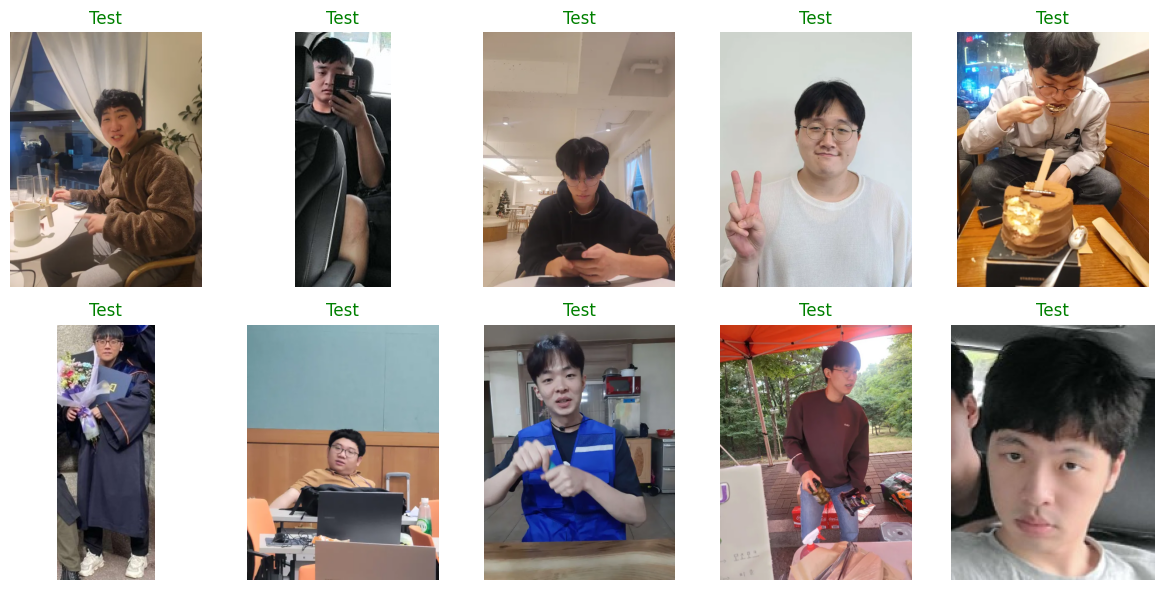

In [81]:
# 테스트 데이터셋 이미지를 출력
display_image_grid(test_images_filepaths)

In [82]:
# 이미지 데이터셋 클래스 정의

class DogvsCatDataset(Dataset):

    # 데어터셋의 전처리
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        # DogvsCatDataset 클래스를 호출할 때 transform에 대한 매개 변수를 받아 옴
        self.transform = transform
        # train 적용
        self.phase = phase
        # 채널이 3개가 아닌 이미지를 필터링하여 새로운 리스트에 저장
        self.file_list = [f for f in self.file_list if Image.open(f).mode == 'RGB']

    # images_filepaths 데이터셋의 전체 길이를 반환
    def __len__(self):
        return len(self.file_list)

    # 데이터셋에서 데이터를 가져오는 부분으로 결과는 텐서 형태
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        # 이미지에 'train' 전처리를 적용
        img_transformed = self.transform(img, self.phase)
        # 이미지 데이터에 대한 레이블 값을 가져옴
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label =  1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [83]:
# 변수 값 정의

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [84]:
# 훈련 이미지에 train_transforms를 적용
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
# 훈련 데이터(train_dataset.__getitem__[0][0])의 크기를 출력
print(train_dataset.__getitem__(index)[0].size())
# 훈련 데이터의 레이블 출력
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [85]:
# 데이터로더 정의

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# 훈련 데이터셋과 검증 데이터셋을 합쳐서 표현
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1])


In [86]:
# 모델의 네트워크 클래스

class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 2D 합성곱층이 적용, 입력 형태는 (3, 224, 224), 출력 형태는 (weight-kernel_size+1) / stride에 따라 (16, 220, 220)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        # ReLU는 활성화 함수, 새로운 텐서를 만들겠다.
        self.relu1 = nn.ReLU()
        # 최대 풀링이 적용됨, 적용 이후 출력 형태는 220/2가 되어 (16, 110, 110)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # 2D 합성곱층이 적용, 출력 형태는 (32, 106, 106)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        # 최대 풀링이 적용, 출력 형태는 (32, ,53, 53)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        # 완전 연결층에 데이터를 전달하기 위해 데이터 형태를 1차원으로 바꿈, self가 아닌 out에서 view를 호출
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        # 마지막 레이어에는 확률 계산에 부정적인 영향을 끼치는 것을 방지하기 위해 ReLU 대신 Softmax를 사용하는 것이 일반적
        out = self.output(out)
        return out

In [87]:
# 모델 객체 생성
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [88]:
# torchsummary 라이브러리를 이용한 모델의 네트워크 구조 확인
# 케라스와 같은 형태로 모델을 출력할 수 있는 라이브러리

# >pip install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [89]:
# 학습 가능한 파라미터 수 확인

def count_parameters(model):
    # p: 파라미터를 나타내는 변수
    # p.numel(): 파라미터의 요소 수를 반환하는 메서드, 3x3 크기의 경우 9개의 요소가 된다.
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [90]:
# 옵티마이저와 손실 함수 정의

#경사 하강법으로 모멘텀 SGD를 사용
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [91]:
# 모델 학습 함수 정의

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print(f'Epoch {epoch+1}/{num_epoch}')
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                # 모델을 학습(순전파 발생)
                model.train()
            else:
                # 가중치를 업데이트하지 않는다.
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0

            # dataloader_dict는 훈련 데이터셋을 의미
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # 역전파 단계를 실행하기 전에 기울기를 0으로 초기화
                optimizer.zero_grad()

                # 훈련 중일 때, 자동 미분이 활성화
                with torch.set_grad_enabled(phase == 'train'):
                    # 주어진 입력 데이터에 대한 신경망의 출력 계산
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # 손실 함수를 이용한 오차 계산
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        # 모델의 학습 가능한 모든 파라미터에 대해 기울기를 계산
                        loss.backward()
                        # optimizer의 step 함수를 호출하면 파라미터를 갱신
                        optimizer.step()
                    
                    print(loss.item())
                    # 오차를 배치 크기로 곱함 -> 평균화를 고려하여 손실을 다시 확장(전체 손실이 개별 손실의 합계를 반영)
                    epoch_loss += loss.item() * inputs.size(0)
                    # 정답과 예측이 일치하면 그것의 합계를 epoch_corrects에 저장
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # 최종 오차 계산(오차를 데이터셋의 길이(개수)로 나누어서 계산)
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            # 최종 정확도(epoch_corrects를 데이터셋의 길이(개수)로 나누어서 계산), 정확도는 소수점까지 표현
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 검증 데이터셋에 대한 가장 최적의 정확도를 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    return model

In [92]:
# 모델 학습

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


  0%|▏                                                                                 | 1/624 [00:00<02:57,  3.50it/s]

0.692645251750946


  0%|▍                                                                                 | 3/624 [00:00<02:49,  3.67it/s]

0.6957627534866333
0.6893935799598694


  1%|▋                                                                                 | 5/624 [00:01<02:05,  4.92it/s]

0.7003227472305298
0.6878134608268738


  1%|▉                                                                                 | 7/624 [00:01<01:54,  5.40it/s]

0.6914495825767517
0.7038723826408386


  1%|█▏                                                                                | 9/624 [00:01<01:51,  5.53it/s]

0.6830353140830994
0.682616651058197


  2%|█▍                                                                               | 11/624 [00:02<01:45,  5.82it/s]

0.7279134392738342
0.6939682960510254


  2%|█▋                                                                               | 13/624 [00:02<01:44,  5.87it/s]

0.6987078189849854
0.6787384748458862


  2%|█▉                                                                               | 15/624 [00:02<01:53,  5.35it/s]

0.691167950630188
0.6877772212028503


  3%|██                                                                               | 16/624 [00:03<01:50,  5.50it/s]

0.6604014039039612


  3%|██▏                                                                              | 17/624 [00:03<02:06,  4.80it/s]

0.7022832036018372


  3%|██▍                                                                              | 19/624 [00:03<02:28,  4.08it/s]

0.7706475853919983
0.6820193529129028


  3%|██▋                                                                              | 21/624 [00:04<02:02,  4.93it/s]

0.6927026510238647
0.6871857047080994


  4%|██▉                                                                              | 23/624 [00:04<01:49,  5.47it/s]

0.6793214678764343
0.6726703643798828


  4%|███▏                                                                             | 25/624 [00:04<01:43,  5.76it/s]

0.6970372200012207
0.6711865663528442


  4%|███▌                                                                             | 27/624 [00:05<01:41,  5.88it/s]

0.6935520768165588
0.6632259488105774


  5%|███▊                                                                             | 29/624 [00:05<01:38,  6.01it/s]

0.6879585981369019
0.6830176711082458


  5%|████                                                                             | 31/624 [00:05<01:37,  6.05it/s]

0.6794923543930054
0.7008664608001709


  5%|████▎                                                                            | 33/624 [00:06<01:38,  5.97it/s]

0.6710359454154968
0.7277989387512207


  6%|████▌                                                                            | 35/624 [00:06<01:37,  6.05it/s]

0.6414228677749634
0.7876380085945129


  6%|████▊                                                                            | 37/624 [00:06<01:33,  6.26it/s]

0.6427567005157471
0.7063327431678772


  6%|█████                                                                            | 39/624 [00:07<01:32,  6.35it/s]

0.6885169744491577
0.6895647644996643


  7%|█████▎                                                                           | 41/624 [00:07<01:31,  6.37it/s]

0.6919348835945129
0.6469770669937134


  7%|█████▍                                                                           | 42/624 [00:07<01:30,  6.41it/s]

0.7066409587860107


  7%|█████▌                                                                           | 43/624 [00:07<01:41,  5.73it/s]

0.7252090573310852


  7%|█████▋                                                                           | 44/624 [00:08<01:52,  5.14it/s]

0.6751386523246765


  7%|█████▉                                                                           | 46/624 [00:08<01:50,  5.22it/s]

0.6527818441390991
0.6778602600097656


  8%|██████▏                                                                          | 48/624 [00:08<01:46,  5.43it/s]

0.7114015817642212
0.7221785187721252


  8%|██████▍                                                                          | 50/624 [00:09<01:37,  5.86it/s]

0.7154554128646851
0.6563407778739929


  8%|██████▊                                                                          | 52/624 [00:09<01:32,  6.17it/s]

0.6970610618591309
0.6723324060440063


  9%|███████                                                                          | 54/624 [00:09<01:39,  5.76it/s]

0.6596050262451172
0.7012619376182556


  9%|███████▎                                                                         | 56/624 [00:10<01:35,  5.92it/s]

0.6660627126693726
0.7708998322486877


  9%|███████▌                                                                         | 58/624 [00:10<01:29,  6.29it/s]

0.6733685731887817
0.6722588539123535


 10%|███████▊                                                                         | 60/624 [00:10<01:36,  5.82it/s]

0.6909096240997314
0.7001363635063171


 10%|████████                                                                         | 62/624 [00:11<01:34,  5.96it/s]

0.6893616914749146
0.661822497844696


 10%|████████▎                                                                        | 64/624 [00:11<01:32,  6.09it/s]

0.6672579050064087
0.6944354772567749


 11%|████████▌                                                                        | 66/624 [00:11<01:35,  5.86it/s]

0.6805638074874878
0.6552982330322266


 11%|████████▊                                                                        | 68/624 [00:12<01:31,  6.05it/s]

0.6827594637870789
0.6823052167892456


 11%|█████████                                                                        | 70/624 [00:12<01:30,  6.11it/s]

0.6620447635650635
0.6421769261360168


 12%|█████████▎                                                                       | 72/624 [00:12<01:31,  6.01it/s]

0.670686662197113
0.6500164866447449


 12%|█████████▌                                                                       | 74/624 [00:13<01:29,  6.15it/s]

0.6507200598716736
0.6647025942802429


 12%|█████████▊                                                                       | 76/624 [00:13<01:27,  6.26it/s]

0.6595861911773682
0.6986111998558044


 12%|██████████▏                                                                      | 78/624 [00:13<01:29,  6.08it/s]

0.6646178960800171
0.6980924606323242


 13%|██████████▍                                                                      | 80/624 [00:14<01:34,  5.74it/s]

0.6785187721252441
0.6238147616386414


 13%|██████████▋                                                                      | 82/624 [00:14<01:34,  5.74it/s]

0.7548887133598328
0.6719797849655151


 13%|██████████▉                                                                      | 84/624 [00:14<01:31,  5.91it/s]

0.7006560564041138
0.6238301396369934


 14%|███████████▏                                                                     | 86/624 [00:15<01:30,  5.95it/s]

0.7107926607131958
0.6940217614173889


 14%|███████████▍                                                                     | 88/624 [00:15<01:25,  6.25it/s]

0.6714927554130554
0.6323326826095581


 14%|███████████▋                                                                     | 90/624 [00:15<01:22,  6.46it/s]

0.662513256072998
0.7013354301452637


 15%|███████████▉                                                                     | 92/624 [00:16<01:22,  6.44it/s]

0.6715512871742249
0.6745075583457947


 15%|████████████▏                                                                    | 94/624 [00:16<01:31,  5.82it/s]

0.6969093680381775
0.6567255258560181


 15%|████████████▍                                                                    | 96/624 [00:16<01:28,  5.99it/s]

0.6587323546409607
0.7385226488113403


 16%|████████████▌                                                                    | 97/624 [00:17<01:31,  5.73it/s]

0.6513901948928833
0.6770873665809631


 16%|████████████▊                                                                    | 99/624 [00:17<01:43,  5.07it/s]

0.6569408178329468


 16%|████████████▊                                                                   | 100/624 [00:17<01:47,  4.87it/s]

0.6483649015426636


 16%|█████████████                                                                   | 102/624 [00:18<01:44,  5.00it/s]

0.6685618758201599
0.6642745137214661


 17%|█████████████▏                                                                  | 103/624 [00:18<01:47,  4.84it/s]

0.6612001061439514


 17%|█████████████▎                                                                  | 104/624 [00:18<01:48,  4.79it/s]

0.670764684677124


 17%|█████████████▍                                                                  | 105/624 [00:18<01:53,  4.58it/s]

0.694259762763977


 17%|█████████████▋                                                                  | 107/624 [00:19<01:51,  4.62it/s]

0.6364612579345703
0.6991400718688965


 17%|█████████████▉                                                                  | 109/624 [00:19<01:45,  4.89it/s]

0.683258056640625
0.6761521100997925


 18%|██████████████▏                                                                 | 111/624 [00:19<01:39,  5.15it/s]

0.6410350799560547
0.689271092414856


 18%|██████████████▎                                                                 | 112/624 [00:20<01:42,  5.01it/s]

0.65534907579422


 18%|██████████████▍                                                                 | 113/624 [00:21<04:28,  1.90it/s]

0.6444857716560364


 18%|██████████████▌                                                                 | 114/624 [00:21<03:41,  2.30it/s]

0.6615790724754333


 19%|██████████████▊                                                                 | 116/624 [00:22<02:40,  3.17it/s]

0.6530660390853882
0.6713985204696655


 19%|███████████████▏                                                                | 118/624 [00:22<02:05,  4.04it/s]

0.7011494636535645
0.6623857021331787


 19%|███████████████▍                                                                | 120/624 [00:22<01:51,  4.52it/s]

0.6433560848236084
0.6856180429458618


 20%|███████████████▋                                                                | 122/624 [00:23<01:43,  4.86it/s]

0.7271706461906433
0.6702086925506592


 20%|███████████████▊                                                                | 123/624 [00:23<01:37,  5.12it/s]

0.619880735874176


 20%|███████████████▉                                                                | 124/624 [00:23<01:38,  5.06it/s]

0.5807286500930786


 20%|████████████████▏                                                               | 126/624 [00:23<01:39,  5.02it/s]

0.6292592287063599
0.6708303689956665


 21%|████████████████▍                                                               | 128/624 [00:24<01:37,  5.08it/s]

0.7141904830932617
0.6172884106636047


 21%|████████████████▋                                                               | 130/624 [00:24<01:37,  5.06it/s]

0.6777185797691345
0.6544793248176575


 21%|████████████████▉                                                               | 132/624 [00:25<01:29,  5.51it/s]

0.6508434414863586
0.6925825476646423


 21%|█████████████████                                                               | 133/624 [00:25<01:29,  5.49it/s]

0.6923556923866272


 22%|█████████████████▎                                                              | 135/624 [00:25<01:27,  5.61it/s]

0.6570613384246826
0.7185776233673096


 22%|█████████████████▌                                                              | 137/624 [00:26<01:31,  5.30it/s]

0.7020721435546875
0.6269909143447876


 22%|█████████████████▊                                                              | 139/624 [00:26<01:28,  5.46it/s]

0.6548649668693542
0.6185854077339172


 22%|█████████████████▉                                                              | 140/624 [00:26<01:26,  5.58it/s]

0.6760182976722717


 23%|██████████████████                                                              | 141/624 [00:26<01:38,  4.90it/s]

0.6839706897735596


 23%|██████████████████▎                                                             | 143/624 [00:27<01:43,  4.65it/s]

0.6563571691513062
0.6179677844047546


 23%|██████████████████▌                                                             | 145/624 [00:27<01:29,  5.36it/s]

0.7238248586654663
0.6502872705459595


 24%|██████████████████▊                                                             | 147/624 [00:27<01:23,  5.71it/s]

0.7146825194358826
0.578504741191864


 24%|███████████████████                                                             | 149/624 [00:28<01:19,  6.00it/s]

0.6025009155273438
0.6672007441520691


 24%|███████████████████▎                                                            | 151/624 [00:28<01:20,  5.88it/s]

0.6871423125267029
0.6259433031082153


 24%|███████████████████▍                                                            | 152/624 [00:28<01:20,  5.85it/s]

0.6628575921058655


 25%|███████████████████▋                                                            | 154/624 [00:29<01:26,  5.41it/s]

0.7034667730331421
0.7186192274093628


 25%|████████████████████                                                            | 156/624 [00:29<01:25,  5.46it/s]

0.5805091261863708
0.6607949137687683


 25%|████████████████████▎                                                           | 158/624 [00:29<01:21,  5.68it/s]

0.6164030432701111
0.6252957582473755


 26%|████████████████████▌                                                           | 160/624 [00:30<01:24,  5.48it/s]

0.6192978620529175
0.6388866305351257


 26%|████████████████████▊                                                           | 162/624 [00:30<01:25,  5.42it/s]

0.6781801581382751
0.6521680951118469


 26%|█████████████████████                                                           | 164/624 [00:30<01:21,  5.66it/s]

0.6719075441360474
0.6966965794563293


 26%|█████████████████████▏                                                          | 165/624 [00:31<01:27,  5.23it/s]

0.7039006352424622


 27%|█████████████████████▍                                                          | 167/624 [00:31<01:29,  5.12it/s]

0.6576538681983948
0.7142336368560791


 27%|█████████████████████▋                                                          | 169/624 [00:31<01:26,  5.25it/s]

0.622846245765686
0.7472693920135498


 27%|█████████████████████▉                                                          | 171/624 [00:32<01:23,  5.45it/s]

0.6561665534973145
0.6488756537437439


 28%|██████████████████████▏                                                         | 173/624 [00:32<01:21,  5.54it/s]

0.705401599407196
0.6361290812492371


 28%|██████████████████████▍                                                         | 175/624 [00:33<01:20,  5.61it/s]

0.6861374974250793
0.6600170135498047


 28%|██████████████████████▋                                                         | 177/624 [00:33<01:18,  5.70it/s]

0.7264861464500427
0.5895535349845886


 29%|██████████████████████▉                                                         | 179/624 [00:33<01:15,  5.88it/s]

0.6171476244926453
0.6338666677474976


 29%|███████████████████████▏                                                        | 181/624 [00:34<01:18,  5.65it/s]

0.610365092754364
0.6419793367385864


 29%|███████████████████████▍                                                        | 183/624 [00:34<01:25,  5.14it/s]

0.7264774441719055
0.6717333197593689


 30%|███████████████████████▋                                                        | 185/624 [00:34<01:21,  5.36it/s]

0.6386175751686096
0.650871753692627


 30%|███████████████████████▉                                                        | 187/624 [00:35<01:19,  5.51it/s]

0.656147837638855
0.6521162986755371


 30%|████████████████████████▏                                                       | 189/624 [00:35<01:16,  5.71it/s]

0.6887385845184326
0.6864541172981262


 31%|████████████████████████▍                                                       | 191/624 [00:35<01:19,  5.47it/s]

0.671784520149231
0.7019789814949036


 31%|████████████████████████▌                                                       | 192/624 [00:36<01:16,  5.67it/s]

0.7273117899894714


 31%|████████████████████████▊                                                       | 194/624 [00:36<01:24,  5.11it/s]

0.689268946647644
0.7017053365707397


 31%|█████████████████████████▏                                                      | 196/624 [00:37<01:28,  4.86it/s]

0.6384449601173401
0.6200432777404785


 32%|█████████████████████████▍                                                      | 198/624 [00:37<01:24,  5.06it/s]

0.6280232667922974
0.6934164762496948


 32%|█████████████████████████▋                                                      | 200/624 [00:37<01:17,  5.46it/s]

0.62972092628479
0.616531491279602


 32%|█████████████████████████▊                                                      | 201/624 [00:37<01:15,  5.57it/s]

0.6480075120925903


 33%|██████████████████████████                                                      | 203/624 [00:38<01:15,  5.58it/s]

0.6183361411094666
0.6327574253082275


 33%|██████████████████████████▎                                                     | 205/624 [00:38<01:12,  5.75it/s]

0.567327618598938
0.6451655626296997


 33%|██████████████████████████▍                                                     | 206/624 [00:38<01:12,  5.74it/s]

0.6920518279075623


 33%|██████████████████████████▋                                                     | 208/624 [00:39<01:23,  5.00it/s]

0.6719235777854919
0.6916409730911255


 34%|██████████████████████████▉                                                     | 210/624 [00:39<01:19,  5.19it/s]

0.5776880979537964
0.5998238325119019


 34%|███████████████████████████▏                                                    | 212/624 [00:39<01:13,  5.60it/s]

0.6207415461540222
0.55882728099823


 34%|███████████████████████████▍                                                    | 214/624 [00:40<01:13,  5.56it/s]

0.5332109332084656
0.7023352980613708


 35%|███████████████████████████▋                                                    | 216/624 [00:40<01:09,  5.84it/s]

0.6488907337188721
0.6443096399307251


 35%|███████████████████████████▊                                                    | 217/624 [00:40<01:24,  4.82it/s]

0.6121122241020203


 35%|███████████████████████████▉                                                    | 218/624 [00:41<01:31,  4.44it/s]

0.6068233251571655


 35%|████████████████████████████▏                                                   | 220/624 [00:41<01:28,  4.55it/s]

0.6474725008010864
0.622471034526825


 36%|████████████████████████████▍                                                   | 222/624 [00:42<01:30,  4.44it/s]

0.6816001534461975
0.728635311126709


 36%|████████████████████████████▋                                                   | 224/624 [00:42<01:21,  4.94it/s]

0.6548670530319214
0.663631796836853


 36%|████████████████████████████▉                                                   | 226/624 [00:42<01:20,  4.93it/s]

0.6680833101272583
0.6123529672622681


 37%|█████████████████████████████▏                                                  | 228/624 [00:43<01:24,  4.69it/s]

0.6281035542488098
0.6451553702354431


 37%|█████████████████████████████▍                                                  | 230/624 [00:43<01:20,  4.91it/s]

0.7018915414810181
0.6428540945053101


 37%|█████████████████████████████▋                                                  | 232/624 [00:44<01:19,  4.90it/s]

0.6806812286376953
0.6900465488433838


 38%|██████████████████████████████                                                  | 234/624 [00:44<01:21,  4.80it/s]

0.6959761381149292
0.6180645227432251


 38%|██████████████████████████████▎                                                 | 236/624 [00:44<01:20,  4.83it/s]

0.5859031081199646
0.7123433351516724


 38%|██████████████████████████████▍                                                 | 237/624 [00:45<01:20,  4.79it/s]

0.6082445979118347


 38%|██████████████████████████████▌                                                 | 238/624 [00:45<01:20,  4.78it/s]

0.6087914705276489


 38%|██████████████████████████████▊                                                 | 240/624 [00:45<01:20,  4.74it/s]

0.6064101457595825
0.658779501914978


 39%|██████████████████████████████▉                                                 | 241/624 [00:46<01:21,  4.71it/s]

0.6775555610656738


 39%|███████████████████████████████                                                 | 242/624 [00:46<01:21,  4.66it/s]

0.6220952868461609


 39%|███████████████████████████████▎                                                | 244/624 [00:46<01:31,  4.15it/s]

0.6027598977088928
0.7396175265312195


 39%|███████████████████████████████▍                                                | 245/624 [00:47<01:27,  4.35it/s]

0.634443998336792


 39%|███████████████████████████████▌                                                | 246/624 [00:47<01:25,  4.42it/s]

0.7397174835205078


 40%|███████████████████████████████▋                                                | 247/624 [00:47<01:23,  4.50it/s]

0.6626812219619751


 40%|███████████████████████████████▉                                                | 249/624 [00:47<01:20,  4.67it/s]

0.6702064275741577
0.6363322734832764


 40%|████████████████████████████████▏                                               | 251/624 [00:48<01:15,  4.94it/s]

0.7919642925262451
0.8322697877883911


 40%|████████████████████████████████▎                                               | 252/624 [00:48<01:16,  4.87it/s]

0.6634942293167114


 41%|████████████████████████████████▌                                               | 254/624 [00:48<01:17,  4.80it/s]

0.6576396226882935
0.6324801445007324


 41%|████████████████████████████████▋                                               | 255/624 [00:49<01:16,  4.80it/s]

0.7124777436256409


 41%|████████████████████████████████▉                                               | 257/624 [00:49<01:19,  4.62it/s]

0.6033583879470825
0.6168217658996582


 41%|█████████████████████████████████                                               | 258/624 [00:49<01:16,  4.78it/s]

0.5938848853111267


 42%|█████████████████████████████████▏                                              | 259/624 [00:49<01:17,  4.73it/s]

0.6250380277633667


 42%|█████████████████████████████████▎                                              | 260/624 [00:50<01:17,  4.71it/s]

0.6723379492759705


 42%|█████████████████████████████████▌                                              | 262/624 [00:50<01:15,  4.78it/s]

0.7024522423744202
0.593522310256958


 42%|█████████████████████████████████▊                                              | 264/624 [00:51<01:14,  4.83it/s]

0.6903277635574341
0.6400121450424194


 43%|██████████████████████████████████                                              | 266/624 [00:51<01:13,  4.90it/s]

0.7196862697601318
0.7492607831954956


 43%|██████████████████████████████████▏                                             | 267/624 [00:51<01:13,  4.83it/s]

0.6625053882598877


 43%|██████████████████████████████████▎                                             | 268/624 [00:51<01:16,  4.65it/s]

0.6495782732963562


 43%|██████████████████████████████████▍                                             | 269/624 [00:52<01:16,  4.61it/s]

0.6623137593269348


 43%|██████████████████████████████████▌                                             | 270/624 [00:52<01:31,  3.86it/s]

0.6374101042747498


 43%|██████████████████████████████████▋                                             | 271/624 [00:52<01:30,  3.90it/s]

0.6500608921051025


 44%|██████████████████████████████████▊                                             | 272/624 [00:52<01:28,  3.98it/s]

0.6565825343132019


 44%|███████████████████████████████████                                             | 273/624 [00:53<01:25,  4.12it/s]

0.7657854557037354


 44%|███████████████████████████████████▏                                            | 274/624 [00:53<01:22,  4.25it/s]

0.6628814935684204


 44%|███████████████████████████████████▎                                            | 275/624 [00:53<01:20,  4.35it/s]

0.6197627186775208


 44%|███████████████████████████████████▍                                            | 276/624 [00:54<01:50,  3.15it/s]

0.7397032976150513


 44%|███████████████████████████████████▌                                            | 277/624 [00:54<01:45,  3.29it/s]

0.6906075477600098


 45%|███████████████████████████████████▊                                            | 279/624 [00:54<01:25,  4.02it/s]

0.6013607382774353
0.6425603628158569


 45%|████████████████████████████████████                                            | 281/624 [00:55<01:22,  4.18it/s]

0.68910151720047
0.7155404686927795


 45%|████████████████████████████████████▎                                           | 283/624 [00:55<01:12,  4.69it/s]

0.7138558030128479
0.6557630896568298


 46%|████████████████████████████████████▌                                           | 285/624 [00:55<01:07,  5.04it/s]

0.6260213255882263
0.664560079574585


 46%|████████████████████████████████████▊                                           | 287/624 [00:56<01:00,  5.54it/s]

0.7059416174888611
0.6076846718788147


 46%|█████████████████████████████████████                                           | 289/624 [00:56<01:01,  5.48it/s]

0.6245765089988708
0.6381205320358276


 47%|█████████████████████████████████████▎                                          | 291/624 [00:57<01:03,  5.22it/s]

0.6301141977310181
0.655493974685669


 47%|█████████████████████████████████████▌                                          | 293/624 [00:57<01:09,  4.74it/s]

0.6841397285461426
0.6216408014297485


 47%|█████████████████████████████████████▋                                          | 294/624 [00:57<01:07,  4.91it/s]

0.6481059789657593


 47%|█████████████████████████████████████▉                                          | 296/624 [00:58<01:06,  4.95it/s]

0.5766215920448303
0.6695042848587036


 48%|██████████████████████████████████████▏                                         | 298/624 [00:58<01:03,  5.12it/s]

0.6985482573509216
0.6587892174720764


 48%|██████████████████████████████████████▍                                         | 300/624 [00:58<01:03,  5.08it/s]

0.6684460639953613
0.6443833112716675


 48%|██████████████████████████████████████▋                                         | 302/624 [00:59<01:05,  4.93it/s]

0.6368751525878906
0.5437535047531128


 49%|██████████████████████████████████████▉                                         | 304/624 [00:59<01:09,  4.63it/s]

0.6536770462989807
0.6258332133293152


 49%|███████████████████████████████████████▏                                        | 306/624 [01:00<01:11,  4.42it/s]

0.685448408126831
0.688482403755188


 49%|███████████████████████████████████████▍                                        | 308/624 [01:00<01:07,  4.68it/s]

0.6474176049232483
0.6418404579162598


 50%|███████████████████████████████████████▋                                        | 310/624 [01:01<01:03,  4.94it/s]

0.6682423949241638
0.6524792313575745


 50%|███████████████████████████████████████▊                                        | 311/624 [01:01<01:03,  4.91it/s]

0.6501912474632263


 50%|████████████████████████████████████████▏                                       | 313/624 [01:01<01:03,  4.88it/s]

0.6743940114974976
0.6880682706832886


 50%|████████████████████████████████████████▍                                       | 315/624 [01:02<01:02,  4.94it/s]

0.6436104774475098
0.6504964828491211


 51%|████████████████████████████████████████▋                                       | 317/624 [01:02<01:01,  4.97it/s]

0.6838562488555908
0.6537638306617737


 51%|████████████████████████████████████████▊                                       | 318/624 [01:02<01:00,  5.03it/s]

0.6462048292160034


 51%|█████████████████████████████████████████                                       | 320/624 [01:03<01:06,  4.57it/s]

0.6255400776863098
0.7009053826332092


 51%|█████████████████████████████████████████▏                                      | 321/624 [01:03<01:03,  4.79it/s]

0.734783947467804


 52%|█████████████████████████████████████████▍                                      | 323/624 [01:03<01:01,  4.86it/s]

0.6159383654594421
0.622727632522583


 52%|█████████████████████████████████████████▋                                      | 325/624 [01:04<01:00,  4.94it/s]

0.6499024033546448
0.702438473701477


 52%|█████████████████████████████████████████▉                                      | 327/624 [01:04<00:59,  5.00it/s]

0.6008186340332031
0.7151569128036499


 53%|██████████████████████████████████████████▏                                     | 329/624 [01:04<00:59,  5.00it/s]

0.6129672527313232
0.681233823299408


 53%|██████████████████████████████████████████▍                                     | 331/624 [01:05<00:58,  5.02it/s]

0.7037946581840515
0.6828221082687378


 53%|██████████████████████████████████████████▋                                     | 333/624 [01:05<00:56,  5.13it/s]

0.6179723143577576
0.643311083316803


 54%|██████████████████████████████████████████▊                                     | 334/624 [01:05<00:58,  5.00it/s]

0.6726982593536377


 54%|███████████████████████████████████████████                                     | 336/624 [01:06<01:05,  4.38it/s]

0.6159527897834778
0.6261559128761292


 54%|███████████████████████████████████████████▎                                    | 338/624 [01:06<01:04,  4.41it/s]

0.6608877182006836
0.6298682689666748


 54%|███████████████████████████████████████████▌                                    | 340/624 [01:07<01:02,  4.53it/s]

0.6396568417549133
0.5802251100540161


 55%|███████████████████████████████████████████▊                                    | 342/624 [01:07<00:58,  4.81it/s]

0.6375161409378052
0.7195079326629639


 55%|███████████████████████████████████████████▉                                    | 343/624 [01:07<00:58,  4.83it/s]

0.6356465220451355
0.619427502155304


 55%|████████████████████████████████████████████▎                                   | 346/624 [01:08<00:55,  4.99it/s]

0.6893805265426636
0.6728547811508179


 56%|████████████████████████████████████████████▍                                   | 347/624 [01:08<00:55,  5.00it/s]

0.6221204400062561


 56%|████████████████████████████████████████████▋                                   | 349/624 [01:09<00:56,  4.86it/s]

0.6800641417503357
0.650640070438385


 56%|████████████████████████████████████████████▊                                   | 350/624 [01:09<00:57,  4.79it/s]

0.6029889583587646


 56%|█████████████████████████████████████████████                                   | 351/624 [01:09<00:58,  4.67it/s]

0.6377815008163452


 57%|█████████████████████████████████████████████▎                                  | 353/624 [01:10<00:57,  4.75it/s]

0.6279298663139343
0.6402131915092468


 57%|█████████████████████████████████████████████▍                                  | 354/624 [01:10<00:54,  4.94it/s]

0.614528238773346
0.6046831607818604


 57%|█████████████████████████████████████████████▊                                  | 357/624 [01:10<00:52,  5.05it/s]

0.596972644329071
0.611964762210846


 58%|██████████████████████████████████████████████                                  | 359/624 [01:11<00:51,  5.10it/s]

0.6240119338035583
0.6378421187400818


 58%|██████████████████████████████████████████████▎                                 | 361/624 [01:11<00:52,  5.05it/s]

0.5875664353370667
0.7336463928222656


 58%|██████████████████████████████████████████████▌                                 | 363/624 [01:12<00:51,  5.09it/s]

0.6578913331031799
0.6089219450950623


 58%|██████████████████████████████████████████████▋                                 | 364/624 [01:12<00:53,  4.85it/s]

0.6084596514701843


 58%|██████████████████████████████████████████████▊                                 | 365/624 [01:12<00:58,  4.41it/s]

0.6120150685310364


 59%|██████████████████████████████████████████████▉                                 | 366/624 [01:12<01:08,  3.76it/s]

0.6469442844390869


 59%|███████████████████████████████████████████████▏                                | 368/624 [01:13<01:02,  4.11it/s]

0.6270894408226013
0.6474940776824951


 59%|███████████████████████████████████████████████▍                                | 370/624 [01:13<00:56,  4.53it/s]

0.6717323660850525
0.6470502614974976


 59%|███████████████████████████████████████████████▌                                | 371/624 [01:13<00:54,  4.66it/s]

0.6401075124740601


 60%|███████████████████████████████████████████████▋                                | 372/624 [01:14<00:53,  4.73it/s]

0.5653777122497559


 60%|███████████████████████████████████████████████▉                                | 374/624 [01:14<00:54,  4.59it/s]

0.6519708037376404
0.5929384231567383


 60%|████████████████████████████████████████████████                                | 375/624 [01:14<00:52,  4.70it/s]

0.5999356508255005


 60%|████████████████████████████████████████████████▏                               | 376/624 [01:15<00:52,  4.69it/s]

0.5884826183319092


 61%|████████████████████████████████████████████████▍                               | 378/624 [01:15<00:51,  4.73it/s]

0.6785640120506287
0.6711668372154236


 61%|████████████████████████████████████████████████▌                               | 379/624 [01:15<00:51,  4.77it/s]

0.6377508640289307


 61%|████████████████████████████████████████████████▊                               | 381/624 [01:16<00:50,  4.78it/s]

0.6271731853485107
0.6702649593353271


 61%|█████████████████████████████████████████████████                               | 383/624 [01:16<00:50,  4.74it/s]

0.6449679136276245
0.6298490762710571


 62%|█████████████████████████████████████████████████▏                              | 384/624 [01:16<00:52,  4.59it/s]

0.5689348578453064


 62%|█████████████████████████████████████████████████▎                              | 385/624 [01:17<00:59,  4.02it/s]

0.7103692889213562


 62%|█████████████████████████████████████████████████▍                              | 386/624 [01:17<00:56,  4.22it/s]

0.6440759897232056


 62%|█████████████████████████████████████████████████▌                              | 387/624 [01:17<00:54,  4.38it/s]

0.6020541191101074


 62%|█████████████████████████████████████████████████▋                              | 388/624 [01:17<00:56,  4.17it/s]

0.7511789202690125


 62%|█████████████████████████████████████████████████▊                              | 389/624 [01:18<00:59,  3.98it/s]

0.7029472589492798


 62%|██████████████████████████████████████████████████                              | 390/624 [01:18<00:56,  4.13it/s]

0.6207916140556335


 63%|██████████████████████████████████████████████████▏                             | 391/624 [01:18<01:05,  3.55it/s]

0.6412704586982727


 63%|██████████████████████████████████████████████████▎                             | 392/624 [01:18<01:04,  3.62it/s]

0.6671252250671387


 63%|██████████████████████████████████████████████████▍                             | 393/624 [01:19<01:12,  3.20it/s]

0.6657553911209106


 63%|██████████████████████████████████████████████████▌                             | 394/624 [01:19<01:16,  3.02it/s]

0.6652964353561401


 63%|██████████████████████████████████████████████████▋                             | 395/624 [01:19<01:10,  3.23it/s]

0.6497005820274353


 63%|██████████████████████████████████████████████████▊                             | 396/624 [01:20<01:06,  3.44it/s]

0.6752908229827881


 64%|██████████████████████████████████████████████████▉                             | 397/624 [01:20<01:01,  3.71it/s]

0.7340329885482788


 64%|███████████████████████████████████████████████████                             | 398/624 [01:20<00:57,  3.90it/s]

0.6800947189331055


 64%|███████████████████████████████████████████████████▎                            | 400/624 [01:21<00:52,  4.29it/s]

0.6207681894302368
0.6042901873588562


 64%|███████████████████████████████████████████████████▍                            | 401/624 [01:21<00:49,  4.52it/s]

0.546561062335968


 64%|███████████████████████████████████████████████████▌                            | 402/624 [01:21<00:49,  4.46it/s]

0.6420145630836487


 65%|███████████████████████████████████████████████████▋                            | 403/624 [01:21<00:53,  4.16it/s]

0.6373760104179382


 65%|███████████████████████████████████████████████████▊                            | 404/624 [01:22<00:59,  3.68it/s]

0.6012951731681824


 65%|███████████████████████████████████████████████████▉                            | 405/624 [01:22<00:56,  3.90it/s]

0.6841740608215332


 65%|████████████████████████████████████████████████████                            | 406/624 [01:22<00:53,  4.10it/s]

0.6461502313613892


 65%|████████████████████████████████████████████████████▎                           | 408/624 [01:22<00:49,  4.39it/s]

0.6139305830001831
0.6317566633224487


 66%|████████████████████████████████████████████████████▍                           | 409/624 [01:23<00:48,  4.46it/s]

0.626622200012207


 66%|████████████████████████████████████████████████████▌                           | 410/624 [01:23<00:47,  4.51it/s]

0.6696412563323975


 66%|████████████████████████████████████████████████████▋                           | 411/624 [01:23<00:47,  4.46it/s]

0.6955335140228271


 66%|████████████████████████████████████████████████████▉                           | 413/624 [01:24<00:46,  4.50it/s]

0.5913454294204712
0.7037471532821655


 67%|█████████████████████████████████████████████████████▏                          | 415/624 [01:24<00:43,  4.80it/s]

0.6145784258842468
0.5941630601882935


 67%|█████████████████████████████████████████████████████▎                          | 416/624 [01:24<00:42,  4.87it/s]

0.6149556040763855


 67%|█████████████████████████████████████████████████████▌                          | 418/624 [01:25<00:47,  4.34it/s]

0.5955460667610168
0.6682925224304199


 67%|█████████████████████████████████████████████████████▊                          | 420/624 [01:25<00:44,  4.60it/s]

0.6339412927627563
0.624631941318512


 68%|██████████████████████████████████████████████████████                          | 422/624 [01:25<00:41,  4.90it/s]

0.6358903646469116
0.7277950644493103


 68%|██████████████████████████████████████████████████████▎                         | 424/624 [01:26<00:41,  4.84it/s]

0.5491788387298584
0.6218315958976746


 68%|██████████████████████████████████████████████████████▌                         | 426/624 [01:26<00:42,  4.65it/s]

0.7215493321418762
0.6458545327186584


 68%|██████████████████████████████████████████████████████▋                         | 427/624 [01:27<00:46,  4.27it/s]

0.7441588044166565


 69%|███████████████████████████████████████████████████████                         | 429/624 [01:27<00:41,  4.65it/s]

0.6484224200248718
0.6271155476570129


 69%|███████████████████████████████████████████████████████▎                        | 431/624 [01:27<00:38,  5.02it/s]

0.6189616918563843
0.6728152632713318


 69%|███████████████████████████████████████████████████████▌                        | 433/624 [01:28<00:35,  5.45it/s]

0.6937881708145142
0.7059263586997986


 70%|███████████████████████████████████████████████████████▊                        | 435/624 [01:28<00:33,  5.56it/s]

0.6014325022697449
0.5530073642730713


 70%|████████████████████████████████████████████████████████                        | 437/624 [01:28<00:33,  5.51it/s]

0.6498039960861206
0.6285818815231323


 70%|████████████████████████████████████████████████████████▏                       | 438/624 [01:29<00:33,  5.54it/s]

0.5820475816726685


 71%|████████████████████████████████████████████████████████▍                       | 440/624 [01:29<00:35,  5.25it/s]

0.6486875414848328
0.6181467175483704


 71%|████████████████████████████████████████████████████████▋                       | 442/624 [01:29<00:32,  5.57it/s]

0.6618256568908691
0.6097448468208313


 71%|████████████████████████████████████████████████████████▉                       | 444/624 [01:30<00:32,  5.58it/s]

0.6139370203018188
0.5982738733291626


 71%|█████████████████████████████████████████████████████████▏                      | 446/624 [01:30<00:32,  5.49it/s]

0.6553583145141602
0.6175976395606995


 72%|█████████████████████████████████████████████████████████▍                      | 448/624 [01:30<00:31,  5.61it/s]

0.6228077411651611
0.6723495721817017


 72%|█████████████████████████████████████████████████████████▋                      | 450/624 [01:31<00:31,  5.56it/s]

0.6095473170280457
0.6641988754272461


 72%|█████████████████████████████████████████████████████████▉                      | 452/624 [01:31<00:31,  5.46it/s]

0.5991525650024414
0.6115145683288574


 73%|██████████████████████████████████████████████████████████▏                     | 454/624 [01:32<00:31,  5.45it/s]

0.5814231038093567
0.5253886580467224


 73%|██████████████████████████████████████████████████████████▍                     | 456/624 [01:32<00:30,  5.48it/s]

0.5999003052711487
0.6131172776222229


 73%|██████████████████████████████████████████████████████████▋                     | 458/624 [01:32<00:32,  5.07it/s]

0.5787771940231323
0.6288398504257202


 74%|██████████████████████████████████████████████████████████▊                     | 459/624 [01:33<00:33,  4.97it/s]

0.6049538254737854


 74%|██████████████████████████████████████████████████████████▉                     | 460/624 [01:33<00:32,  5.01it/s]

0.6005236506462097


 74%|███████████████████████████████████████████████████████████▏                    | 462/624 [01:33<00:34,  4.67it/s]

0.6133348941802979
0.7010614275932312


 74%|███████████████████████████████████████████████████████████▎                    | 463/624 [01:33<00:33,  4.75it/s]

0.619132399559021


 75%|███████████████████████████████████████████████████████████▌                    | 465/624 [01:34<00:33,  4.76it/s]

0.6657726168632507
0.6144431829452515


 75%|███████████████████████████████████████████████████████████▊                    | 467/624 [01:34<00:28,  5.47it/s]

0.6521288156509399
0.6514217257499695


 75%|████████████████████████████████████████████████████████████▏                   | 469/624 [01:34<00:26,  5.76it/s]

0.6683495044708252
0.7276066541671753


 75%|████████████████████████████████████████████████████████████▍                   | 471/624 [01:35<00:27,  5.60it/s]

0.5471640229225159
0.5920173525810242


 76%|████████████████████████████████████████████████████████████▋                   | 473/624 [01:35<00:25,  5.91it/s]

0.6632633805274963
0.6267489194869995


 76%|████████████████████████████████████████████████████████████▉                   | 475/624 [01:36<00:24,  5.99it/s]

0.6343368887901306
0.5719152092933655


 76%|█████████████████████████████████████████████████████████████▏                  | 477/624 [01:36<00:23,  6.16it/s]

0.7293872237205505
0.5854933857917786


 77%|█████████████████████████████████████████████████████████████▍                  | 479/624 [01:36<00:23,  6.09it/s]

0.6953771114349365
0.6737526655197144


 77%|█████████████████████████████████████████████████████████████▋                  | 481/624 [01:37<00:24,  5.95it/s]

0.6571821570396423
0.6606437563896179


 77%|█████████████████████████████████████████████████████████████▉                  | 483/624 [01:37<00:24,  5.80it/s]

0.7144938707351685
0.6271326541900635


 78%|██████████████████████████████████████████████████████████████▏                 | 485/624 [01:37<00:24,  5.76it/s]

0.550906240940094
0.6286576986312866


 78%|██████████████████████████████████████████████████████████████▍                 | 487/624 [01:38<00:23,  5.76it/s]

0.747673749923706
0.6127628684043884


 78%|██████████████████████████████████████████████████████████████▋                 | 489/624 [01:38<00:23,  5.74it/s]

0.6789966821670532
0.6337260603904724


 79%|██████████████████████████████████████████████████████████████▊                 | 490/624 [01:38<00:23,  5.75it/s]

0.7151288986206055


 79%|██████████████████████████████████████████████████████████████▉                 | 491/624 [01:38<00:24,  5.49it/s]

0.6994143724441528
0.655573308467865


 79%|███████████████████████████████████████████████████████████████▎                | 494/624 [01:39<00:24,  5.35it/s]

0.6160142421722412
0.5952879190444946


 79%|███████████████████████████████████████████████████████████████▌                | 496/624 [01:39<00:23,  5.50it/s]

0.6648224592208862
0.5792606472969055


 80%|███████████████████████████████████████████████████████████████▊                | 498/624 [01:40<00:21,  5.85it/s]

0.59539395570755
0.6500909328460693


 80%|████████████████████████████████████████████████████████████████                | 500/624 [01:40<00:20,  6.02it/s]

0.594833493232727
0.6266267895698547


 80%|████████████████████████████████████████████████████████████████▎               | 502/624 [01:40<00:20,  6.02it/s]

0.6651062369346619
0.6442915797233582


 81%|████████████████████████████████████████████████████████████████▌               | 504/624 [01:41<00:19,  6.18it/s]

0.7021507620811462
0.656446099281311


 81%|████████████████████████████████████████████████████████████████▊               | 506/624 [01:41<00:20,  5.83it/s]

0.7001864910125732
0.6276485919952393


 81%|█████████████████████████████████████████████████████████████████▏              | 508/624 [01:41<00:19,  5.94it/s]

0.5734742283821106
0.64658522605896


 82%|█████████████████████████████████████████████████████████████████▍              | 510/624 [01:42<00:21,  5.42it/s]

0.6653456091880798
0.7234490513801575


 82%|█████████████████████████████████████████████████████████████████▋              | 512/624 [01:42<00:20,  5.46it/s]

0.6446858048439026
0.6252879500389099


 82%|█████████████████████████████████████████████████████████████████▉              | 514/624 [01:42<00:19,  5.64it/s]

0.6279479265213013
0.560883104801178


 83%|██████████████████████████████████████████████████████████████████▏             | 516/624 [01:43<00:19,  5.50it/s]

0.5633611679077148
0.6359933018684387


 83%|██████████████████████████████████████████████████████████████████▍             | 518/624 [01:43<00:18,  5.69it/s]

0.6825118064880371
0.643406093120575


 83%|██████████████████████████████████████████████████████████████████▋             | 520/624 [01:43<00:18,  5.71it/s]

0.6838151812553406
0.6384932398796082


 83%|██████████████████████████████████████████████████████████████████▊             | 521/624 [01:44<00:17,  5.73it/s]

0.5873223543167114


 84%|██████████████████████████████████████████████████████████████████▉             | 522/624 [01:44<00:20,  5.02it/s]

0.6704763770103455


 84%|███████████████████████████████████████████████████████████████████▏            | 524/624 [01:44<00:22,  4.52it/s]

0.625961184501648
0.5949491262435913


 84%|███████████████████████████████████████████████████████████████████▍            | 526/624 [01:45<00:19,  4.92it/s]

0.6858530044555664
0.6699997782707214


 85%|███████████████████████████████████████████████████████████████████▋            | 528/624 [01:45<00:18,  5.10it/s]

0.7333387732505798
0.6669881343841553


 85%|███████████████████████████████████████████████████████████████████▉            | 530/624 [01:45<00:16,  5.54it/s]

0.6096088290214539
0.6137636303901672


 85%|████████████████████████████████████████████████████████████████████▏           | 532/624 [01:46<00:15,  6.05it/s]

0.6200414896011353
0.6296879053115845


 86%|████████████████████████████████████████████████████████████████████▍           | 534/624 [01:46<00:15,  5.97it/s]

0.6409217119216919
0.6447606682777405


 86%|████████████████████████████████████████████████████████████████████▋           | 536/624 [01:46<00:15,  5.83it/s]

0.6408602595329285
0.6164011359214783


 86%|████████████████████████████████████████████████████████████████████▉           | 538/624 [01:47<00:14,  5.76it/s]

0.611381471157074
0.5637733340263367


 86%|█████████████████████████████████████████████████████████████████████           | 539/624 [01:47<00:14,  5.76it/s]

0.6112932562828064


 87%|█████████████████████████████████████████████████████████████████████▎          | 541/624 [01:47<00:15,  5.50it/s]

0.6570317149162292
0.6423621773719788


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/624 [01:48<00:14,  5.65it/s]

0.6605756878852844
0.6943705677986145


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/624 [01:48<00:14,  5.68it/s]

0.6343216300010681


 88%|██████████████████████████████████████████████████████████████████████          | 546/624 [01:48<00:15,  5.07it/s]

0.6854116320610046
0.5832093358039856


 88%|██████████████████████████████████████████████████████████████████████▎         | 548/624 [01:49<00:14,  5.19it/s]

0.6322021484375
0.5562916398048401


 88%|██████████████████████████████████████████████████████████████████████▌         | 550/624 [01:49<00:14,  5.25it/s]

0.5664141774177551
0.5933677554130554


 88%|██████████████████████████████████████████████████████████████████████▊         | 552/624 [01:49<00:13,  5.29it/s]

0.6454850435256958
0.6323699951171875


 89%|███████████████████████████████████████████████████████████████████████         | 554/624 [01:50<00:13,  5.36it/s]

0.6194559931755066
0.6582129001617432


 89%|███████████████████████████████████████████████████████████████████████▎        | 556/624 [01:50<00:12,  5.42it/s]

0.6836442351341248
0.5978673696517944


 89%|███████████████████████████████████████████████████████████████████████▌        | 558/624 [01:51<00:12,  5.30it/s]

0.622276246547699
0.6394296884536743


 90%|███████████████████████████████████████████████████████████████████████▊        | 560/624 [01:51<00:12,  5.29it/s]

0.5679605603218079
0.6569991111755371


 90%|████████████████████████████████████████████████████████████████████████        | 562/624 [01:51<00:11,  5.35it/s]

0.6395577192306519
0.6144936680793762


 90%|████████████████████████████████████████████████████████████████████████▎       | 564/624 [01:52<00:11,  5.34it/s]

0.7231361269950867
0.5912946462631226


 91%|████████████████████████████████████████████████████████████████████████▌       | 566/624 [01:52<00:10,  5.40it/s]

0.6639681458473206
0.6320276856422424


 91%|████████████████████████████████████████████████████████████████████████▊       | 568/624 [01:52<00:11,  4.87it/s]

0.6377285122871399
0.6162232160568237


 91%|█████████████████████████████████████████████████████████████████████████       | 570/624 [01:53<00:10,  5.05it/s]

0.6032958030700684
0.6696714162826538


 92%|█████████████████████████████████████████████████████████████████████████▎      | 572/624 [01:53<00:10,  5.15it/s]

0.5505285263061523
0.6205068826675415


 92%|█████████████████████████████████████████████████████████████████████████▌      | 574/624 [01:54<00:09,  5.18it/s]

0.5365318059921265
0.600113570690155


 92%|█████████████████████████████████████████████████████████████████████████▊      | 576/624 [01:54<00:09,  4.93it/s]

0.6169835329055786
0.7001487016677856


 93%|██████████████████████████████████████████████████████████████████████████      | 578/624 [01:54<00:08,  5.16it/s]

0.6109762787818909
0.6636711359024048


 93%|██████████████████████████████████████████████████████████████████████████▎     | 580/624 [01:55<00:08,  5.16it/s]

0.5981884598731995
0.593937873840332


 93%|██████████████████████████████████████████████████████████████████████████▍     | 581/624 [01:55<00:08,  5.13it/s]

0.717475414276123


 93%|██████████████████████████████████████████████████████████████████████████▋     | 583/624 [01:55<00:08,  4.77it/s]

0.5770065188407898
0.573586106300354


 94%|███████████████████████████████████████████████████████████████████████████     | 585/624 [01:56<00:07,  5.22it/s]

0.567307710647583
0.5948201417922974


 94%|███████████████████████████████████████████████████████████████████████████▎    | 587/624 [01:56<00:06,  5.35it/s]

0.6472309827804565
0.5923606157302856


 94%|███████████████████████████████████████████████████████████████████████████▌    | 589/624 [01:57<00:06,  5.19it/s]

0.7209704518318176
0.5746867656707764


 95%|███████████████████████████████████████████████████████████████████████████▊    | 591/624 [01:57<00:06,  5.10it/s]

0.5947362184524536
0.6443139314651489


 95%|████████████████████████████████████████████████████████████████████████████    | 593/624 [01:57<00:05,  5.35it/s]

0.6697982549667358
0.6320276856422424


 95%|████████████████████████████████████████████████████████████████████████████▎   | 595/624 [01:58<00:05,  5.34it/s]

0.5841104388237
0.6431791186332703


 96%|████████████████████████████████████████████████████████████████████████████▌   | 597/624 [01:58<00:05,  5.30it/s]

0.6342160701751709
0.6184551119804382


 96%|████████████████████████████████████████████████████████████████████████████▊   | 599/624 [01:58<00:04,  5.35it/s]

0.617360532283783
0.6358228921890259


 96%|████████████████████████████████████████████████████████████████████████████▉   | 600/624 [01:59<00:05,  4.58it/s]

0.6157974004745483
0.6265170574188232


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 603/624 [01:59<00:04,  4.79it/s]

0.7048863172531128
0.7490909099578857


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 605/624 [02:00<00:03,  5.04it/s]

0.5471009016036987
0.6656423211097717


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 607/624 [02:00<00:03,  5.28it/s]

0.5954212546348572
0.6304479241371155


 98%|██████████████████████████████████████████████████████████████████████████████  | 609/624 [02:01<00:02,  5.19it/s]

0.6126405596733093
0.6910952925682068


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 610/624 [02:01<00:02,  5.12it/s]

0.6185405254364014


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 612/624 [02:01<00:02,  5.05it/s]

0.568132221698761
0.6075493693351746


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 614/624 [02:02<00:01,  5.12it/s]

0.6491994261741638
0.545414388179779


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 616/624 [02:02<00:01,  5.15it/s]

0.7734081149101257
0.6547533273696899


 99%|███████████████████████████████████████████████████████████████████████████████▏| 618/624 [02:02<00:01,  4.71it/s]

0.6848644018173218
0.5344641208648682


 99%|███████████████████████████████████████████████████████████████████████████████▍| 620/624 [02:03<00:00,  4.98it/s]

0.6839441061019897
0.686436116695404


100%|███████████████████████████████████████████████████████████████████████████████▌| 621/624 [02:03<00:00,  4.96it/s]

0.6563448309898376


100%|███████████████████████████████████████████████████████████████████████████████▊| 623/624 [02:03<00:00,  5.03it/s]

0.5073766708374023
0.6525475382804871


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [02:03<00:00,  5.03it/s]


0.4552386999130249
train Loss: 0.6519 Acc: 0.6170


  1%|▌                                                                                 | 1/155 [00:00<00:22,  6.97it/s]

0.6644580364227295


  1%|█                                                                                 | 2/155 [00:00<00:21,  7.22it/s]

0.619167149066925


  2%|█▌                                                                                | 3/155 [00:00<00:20,  7.28it/s]

0.5440693497657776


  3%|██                                                                                | 4/155 [00:00<00:22,  6.80it/s]

0.7175276875495911


  4%|███▏                                                                              | 6/155 [00:00<00:26,  5.72it/s]

0.5924882292747498
0.5637810826301575


  5%|████▏                                                                             | 8/155 [00:01<00:23,  6.26it/s]

0.6395055055618286
0.5970178842544556


  6%|█████▏                                                                           | 10/155 [00:01<00:21,  6.83it/s]

0.6897507309913635
0.5921587347984314


  8%|██████▎                                                                          | 12/155 [00:01<00:21,  6.73it/s]

0.5755330324172974
0.5991655588150024


  8%|██████▊                                                                          | 13/155 [00:01<00:21,  6.74it/s]

0.6063675880432129


 10%|███████▊                                                                         | 15/155 [00:02<00:21,  6.43it/s]

0.6902480125427246
0.5803232192993164


 11%|████████▉                                                                        | 17/155 [00:02<00:20,  6.72it/s]

0.7100057601928711
0.6604706048965454


 12%|█████████▉                                                                       | 19/155 [00:02<00:19,  6.87it/s]

0.61518794298172
0.609524130821228


 14%|██████████▉                                                                      | 21/155 [00:03<00:18,  7.19it/s]

0.638587474822998
0.6070806980133057


 15%|████████████                                                                     | 23/155 [00:03<00:18,  7.26it/s]

0.5379138588905334
0.6037607789039612


 16%|█████████████                                                                    | 25/155 [00:03<00:21,  6.16it/s]

0.6767114996910095
0.6262030005455017


 17%|██████████████                                                                   | 27/155 [00:04<00:19,  6.41it/s]

0.5504986047744751
0.6635189056396484


 19%|███████████████▏                                                                 | 29/155 [00:04<00:19,  6.39it/s]

0.5976177453994751
0.6269450187683105


 20%|████████████████▏                                                                | 31/155 [00:04<00:18,  6.87it/s]

0.5768477916717529
0.5929467082023621


 21%|█████████████████▏                                                               | 33/155 [00:04<00:17,  7.14it/s]

0.6700565218925476
0.6354674696922302


 23%|██████████████████▎                                                              | 35/155 [00:05<00:17,  6.94it/s]

0.5308921933174133
0.5834954977035522


 24%|███████████████████▎                                                             | 37/155 [00:05<00:18,  6.54it/s]

0.6459673643112183
0.661067008972168


 25%|████████████████████▍                                                            | 39/155 [00:05<00:19,  5.92it/s]

0.6080309748649597
0.612210750579834


 26%|█████████████████████▍                                                           | 41/155 [00:06<00:22,  5.12it/s]

0.628448486328125
0.6203889846801758


 28%|██████████████████████▍                                                          | 43/155 [00:06<00:20,  5.41it/s]

0.5689481496810913
0.6624980568885803


 29%|███████████████████████▌                                                         | 45/155 [00:07<00:19,  5.66it/s]

0.5802567601203918
0.5658075213432312


 30%|████████████████████████                                                         | 46/155 [00:07<00:19,  5.73it/s]

0.6282657980918884


 31%|█████████████████████████                                                        | 48/155 [00:07<00:20,  5.29it/s]

0.58017498254776
0.6450076103210449


 32%|██████████████████████████▏                                                      | 50/155 [00:08<00:19,  5.45it/s]

0.5940650701522827
0.6675374507904053


 33%|██████████████████████████▋                                                      | 51/155 [00:08<00:21,  4.94it/s]

0.632365882396698
0.566612184047699


 35%|████████████████████████████▏                                                    | 54/155 [00:08<00:21,  4.60it/s]

0.5509019494056702
0.6736272573471069


 35%|████████████████████████████▋                                                    | 55/155 [00:09<00:20,  4.83it/s]

0.6056881546974182


 37%|█████████████████████████████▊                                                   | 57/155 [00:09<00:18,  5.22it/s]

0.6256733536720276
0.6518641710281372


 38%|██████████████████████████████▊                                                  | 59/155 [00:09<00:17,  5.43it/s]

0.6037232279777527
0.7421516180038452


 39%|███████████████████████████████▉                                                 | 61/155 [00:10<00:17,  5.40it/s]

0.615384042263031
0.6936495304107666


 41%|████████████████████████████████▉                                                | 63/155 [00:10<00:16,  5.60it/s]

0.5985065698623657
0.6738478541374207


 41%|█████████████████████████████████▍                                               | 64/155 [00:10<00:16,  5.48it/s]

0.5584101676940918


 43%|██████████████████████████████████▍                                              | 66/155 [00:11<00:18,  4.87it/s]

0.6505666971206665
0.5686681270599365


 44%|███████████████████████████████████▌                                             | 68/155 [00:11<00:16,  5.37it/s]

0.6167331337928772
0.6549704670906067


 45%|████████████████████████████████████▌                                            | 70/155 [00:11<00:15,  5.60it/s]

0.66872239112854
0.7344398498535156


 46%|█████████████████████████████████████▋                                           | 72/155 [00:12<00:14,  5.88it/s]

0.6550750136375427
0.6205780506134033


 48%|██████████████████████████████████████▋                                          | 74/155 [00:12<00:13,  5.80it/s]

0.6730569005012512
0.7526974081993103


 49%|███████████████████████████████████████▋                                         | 76/155 [00:12<00:13,  5.89it/s]

0.6439481973648071
0.606479287147522


 50%|████████████████████████████████████████▊                                        | 78/155 [00:13<00:12,  6.05it/s]

0.7025070786476135
0.6745346784591675


 52%|█████████████████████████████████████████▊                                       | 80/155 [00:13<00:12,  6.06it/s]

0.6490781903266907
0.5937517285346985


 53%|██████████████████████████████████████████▊                                      | 82/155 [00:14<00:13,  5.44it/s]

0.5922917127609253
0.7111950516700745


 54%|███████████████████████████████████████████▉                                     | 84/155 [00:14<00:12,  5.55it/s]

0.5666698813438416
0.6113579273223877


 55%|████████████████████████████████████████████▉                                    | 86/155 [00:14<00:12,  5.71it/s]

0.6086280941963196
0.6257626414299011


 56%|█████████████████████████████████████████████▍                                   | 87/155 [00:14<00:11,  5.70it/s]

0.6472657322883606


 57%|██████████████████████████████████████████████▌                                  | 89/155 [00:15<00:12,  5.12it/s]

0.6464847326278687
0.5288105010986328


 59%|███████████████████████████████████████████████▌                                 | 91/155 [00:15<00:11,  5.51it/s]

0.6798335313796997
0.6007951498031616


 60%|████████████████████████████████████████████████▌                                | 93/155 [00:15<00:10,  5.80it/s]

0.6283681988716125
0.5551319122314453


 61%|█████████████████████████████████████████████████▋                               | 95/155 [00:16<00:10,  5.94it/s]

0.6100925803184509
0.55181884765625


 63%|██████████████████████████████████████████████████▋                              | 97/155 [00:16<00:09,  6.00it/s]

0.6365804672241211
0.6827394366264343


 64%|███████████████████████████████████████████████████▋                             | 99/155 [00:16<00:09,  5.89it/s]

0.6913553476333618
0.6264750361442566


 65%|████████████████████████████████████████████████████▏                           | 101/155 [00:17<00:09,  5.49it/s]

0.6850132346153259
0.6219963431358337


 66%|█████████████████████████████████████████████████████▏                          | 103/155 [00:17<00:09,  5.48it/s]

0.6551834344863892
0.5558662414550781


 68%|██████████████████████████████████████████████████████▏                         | 105/155 [00:18<00:08,  5.62it/s]

0.6727257966995239
0.6111916899681091


 69%|███████████████████████████████████████████████████████▏                        | 107/155 [00:18<00:08,  5.70it/s]

0.5799421072006226
0.5594581961631775


 70%|████████████████████████████████████████████████████████▎                       | 109/155 [00:18<00:07,  5.85it/s]

0.5554292798042297
0.6668449640274048


 72%|█████████████████████████████████████████████████████████▎                      | 111/155 [00:19<00:07,  5.87it/s]

0.5812335014343262
0.6715357899665833


 73%|██████████████████████████████████████████████████████████▎                     | 113/155 [00:19<00:07,  5.94it/s]

0.692482590675354
0.6950182318687439


 74%|███████████████████████████████████████████████████████████▎                    | 115/155 [00:19<00:07,  5.38it/s]

0.624436616897583
0.5635846257209778


 75%|████████████████████████████████████████████████████████████▍                   | 117/155 [00:20<00:06,  5.64it/s]

0.6584908962249756
0.6103901863098145


 77%|█████████████████████████████████████████████████████████████▍                  | 119/155 [00:20<00:06,  5.74it/s]

0.7540187835693359
0.653279185295105


 78%|██████████████████████████████████████████████████████████████▍                 | 121/155 [00:20<00:05,  5.87it/s]

0.5527024269104004
0.6600773334503174


 79%|███████████████████████████████████████████████████████████████▍                | 123/155 [00:21<00:05,  5.94it/s]

0.6013797521591187
0.6990792751312256


 81%|████████████████████████████████████████████████████████████████▌               | 125/155 [00:21<00:05,  5.67it/s]

0.5501328110694885
0.6341274976730347


 82%|█████████████████████████████████████████████████████████████████▌              | 127/155 [00:21<00:04,  5.77it/s]

0.641672670841217
0.619670033454895


 83%|██████████████████████████████████████████████████████████████████▌             | 129/155 [00:22<00:04,  5.24it/s]

0.6167483329772949
0.6435602307319641


 85%|███████████████████████████████████████████████████████████████████▌            | 131/155 [00:22<00:04,  5.25it/s]

0.6681063771247864
0.6138402223587036


 86%|████████████████████████████████████████████████████████████████████▋           | 133/155 [00:23<00:04,  5.49it/s]

0.6505689024925232
0.6267271041870117


 87%|█████████████████████████████████████████████████████████████████████▋          | 135/155 [00:23<00:03,  5.71it/s]

0.6202894449234009
0.6246774792671204


 88%|██████████████████████████████████████████████████████████████████████▋         | 137/155 [00:23<00:03,  5.68it/s]

0.6242871880531311
0.6265764236450195


 90%|███████████████████████████████████████████████████████████████████████▋        | 139/155 [00:24<00:02,  5.75it/s]

0.5926725268363953
0.6167752146720886


 91%|████████████████████████████████████████████████████████████████████████▊       | 141/155 [00:24<00:02,  5.71it/s]

0.56402587890625
0.6567709445953369


 92%|█████████████████████████████████████████████████████████████████████████▊      | 143/155 [00:24<00:02,  5.17it/s]

0.6542011499404907
0.592872679233551


 94%|██████████████████████████████████████████████████████████████████████████▊     | 145/155 [00:25<00:01,  5.39it/s]

0.6579079627990723
0.5767457485198975


 95%|███████████████████████████████████████████████████████████████████████████▊    | 147/155 [00:25<00:01,  5.22it/s]

0.6127947568893433
0.6549705862998962


 96%|████████████████████████████████████████████████████████████████████████████▉   | 149/155 [00:26<00:01,  5.31it/s]

0.6028164029121399
0.6428897976875305


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 150/155 [00:26<00:00,  5.33it/s]

0.5986955761909485


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 151/155 [00:26<00:00,  4.49it/s]

0.6551072001457214


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 153/155 [00:26<00:00,  4.58it/s]

0.5848501920700073
0.7176330089569092


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:27<00:00,  5.65it/s]


0.6084704995155334
0.5855945944786072
val Loss: 0.6261 Acc: 0.6570
Epoch 2/10
--------------------


  0%|▏                                                                                 | 1/624 [00:00<02:55,  3.55it/s]

0.7443166971206665


  0%|▎                                                                                 | 2/624 [00:00<02:35,  4.01it/s]

0.6165892481803894


  1%|▌                                                                                 | 4/624 [00:00<02:15,  4.56it/s]

0.5974007844924927
0.5416758060455322


  1%|▊                                                                                 | 6/624 [00:01<02:04,  4.96it/s]

0.5849847197532654
0.6003289818763733


  1%|█                                                                                 | 8/624 [00:01<01:56,  5.31it/s]

0.6499507427215576
0.6403480172157288


  2%|█▎                                                                               | 10/624 [00:02<02:11,  4.68it/s]

0.6408771276473999
0.7096755504608154


  2%|█▌                                                                               | 12/624 [00:02<02:01,  5.02it/s]

0.6155499219894409
0.6574122905731201


  2%|█▊                                                                               | 14/624 [00:02<02:00,  5.07it/s]

0.6314904093742371
0.6098799109458923


  2%|█▉                                                                               | 15/624 [00:03<01:59,  5.09it/s]

0.6520838737487793


  3%|██▏                                                                              | 17/624 [00:03<02:03,  4.93it/s]

0.6130676865577698
0.6641404032707214


  3%|██▍                                                                              | 19/624 [00:03<01:56,  5.21it/s]

0.6341527104377747
0.6774921417236328


  3%|██▋                                                                              | 21/624 [00:04<01:47,  5.61it/s]

0.68320631980896
0.6126105785369873


  4%|██▉                                                                              | 23/624 [00:04<01:46,  5.65it/s]

0.6717590689659119
0.6490804553031921


  4%|███▏                                                                             | 25/624 [00:04<01:42,  5.87it/s]

0.560528039932251
0.6108513474464417


  4%|███▌                                                                             | 27/624 [00:05<01:51,  5.35it/s]

0.5903405547142029
0.5773149132728577


  5%|███▊                                                                             | 29/624 [00:05<01:50,  5.37it/s]

0.691418468952179
0.5976384282112122


  5%|████                                                                             | 31/624 [00:06<01:49,  5.41it/s]

0.591829240322113
0.6111282706260681


  5%|████▎                                                                            | 33/624 [00:06<01:47,  5.52it/s]

0.5625133514404297
0.61440509557724


  6%|████▌                                                                            | 35/624 [00:06<01:48,  5.43it/s]

0.5907113552093506
0.5767601132392883


  6%|████▊                                                                            | 37/624 [00:07<01:44,  5.62it/s]

0.5782763957977295
0.5774081349372864


  6%|█████                                                                            | 39/624 [00:07<02:15,  4.32it/s]

0.6475318670272827
0.6447181105613708


  7%|█████▎                                                                           | 41/624 [00:08<01:53,  5.13it/s]

0.6098926067352295
0.5537105798721313


  7%|█████▌                                                                           | 43/624 [00:08<01:47,  5.41it/s]

0.6001395583152771
0.5557125806808472


  7%|█████▊                                                                           | 45/624 [00:08<01:40,  5.77it/s]

0.5647798776626587
0.6997040510177612


  8%|██████                                                                           | 47/624 [00:09<01:35,  6.04it/s]

0.5784444212913513
0.6468068957328796


  8%|██████▎                                                                          | 49/624 [00:09<01:32,  6.25it/s]

0.5642409324645996
0.6536509990692139


  8%|██████▍                                                                          | 50/624 [00:09<01:32,  6.24it/s]

0.6034035682678223


  8%|██████▌                                                                          | 51/624 [00:09<01:45,  5.45it/s]

0.6850718855857849


  8%|██████▉                                                                          | 53/624 [00:10<01:51,  5.10it/s]

0.676556408405304
0.6423172950744629


  9%|███████▏                                                                         | 55/624 [00:10<01:42,  5.57it/s]

0.6109231114387512
0.6479518413543701


  9%|███████▍                                                                         | 57/624 [00:10<01:34,  6.01it/s]

0.5552504658699036
0.6619650721549988


  9%|███████▋                                                                         | 59/624 [00:11<01:31,  6.15it/s]

0.5210710167884827
0.6347863674163818


 10%|███████▉                                                                         | 61/624 [00:11<01:31,  6.14it/s]

0.6248903274536133
0.5635083317756653


 10%|████████                                                                         | 62/624 [00:11<01:29,  6.26it/s]

0.6483328342437744


 10%|████████▎                                                                        | 64/624 [00:12<01:36,  5.79it/s]

0.7006534934043884
0.6856350898742676


 11%|████████▌                                                                        | 66/624 [00:12<01:31,  6.09it/s]

0.6497065424919128
0.6062001585960388


 11%|████████▊                                                                        | 68/624 [00:12<01:32,  6.04it/s]

0.6426306962966919
0.6503592729568481


 11%|█████████                                                                        | 70/624 [00:13<01:35,  5.80it/s]

0.6691902279853821
0.6183738708496094


 12%|█████████▎                                                                       | 72/624 [00:13<01:34,  5.82it/s]

0.6446657776832581
0.6676258444786072


 12%|█████████▌                                                                       | 74/624 [00:13<01:37,  5.67it/s]

0.6599781513214111
0.7171341776847839


 12%|█████████▋                                                                       | 75/624 [00:13<01:36,  5.68it/s]

0.536385178565979


 12%|█████████▉                                                                       | 77/624 [00:14<01:50,  4.96it/s]

0.6025234460830688
0.576058030128479


 13%|██████████▎                                                                      | 79/624 [00:14<01:39,  5.47it/s]

0.650526762008667
0.7669541835784912


 13%|██████████▌                                                                      | 81/624 [00:15<01:34,  5.73it/s]

0.6902255415916443
0.5711120963096619


 13%|██████████▊                                                                      | 83/624 [00:15<01:31,  5.91it/s]

0.6450411081314087
0.6390519738197327


 14%|███████████                                                                      | 85/624 [00:15<01:33,  5.74it/s]

0.5875029563903809
0.6240890026092529


 14%|███████████▎                                                                     | 87/624 [00:16<01:31,  5.85it/s]

0.6719628572463989
0.7057331800460815


 14%|███████████▌                                                                     | 89/624 [00:16<01:38,  5.45it/s]

0.5584177374839783
0.5581904649734497


 15%|███████████▊                                                                     | 91/624 [00:16<01:35,  5.57it/s]

0.6017733216285706
0.5699999332427979


 15%|████████████                                                                     | 93/624 [00:17<01:34,  5.63it/s]

0.600912868976593
0.6639613509178162


 15%|████████████▎                                                                    | 95/624 [00:17<01:28,  6.00it/s]

0.5590111017227173
0.6599453091621399


 16%|████████████▌                                                                    | 97/624 [00:17<01:25,  6.19it/s]

0.6766170263290405
0.5928893089294434


 16%|████████████▊                                                                    | 99/624 [00:18<01:27,  5.97it/s]

0.6299517154693604
0.6116446852684021


 16%|████████████▉                                                                   | 101/624 [00:18<01:31,  5.74it/s]

0.6846921443939209
0.6998530030250549


 17%|█████████████▏                                                                  | 103/624 [00:18<01:37,  5.32it/s]

0.5568426847457886
0.7315821647644043


 17%|█████████████▍                                                                  | 105/624 [00:19<01:29,  5.79it/s]

0.6387056112289429
0.6521632075309753


 17%|█████████████▋                                                                  | 107/624 [00:19<01:27,  5.91it/s]

0.620725154876709
0.6015534996986389


 17%|█████████████▉                                                                  | 109/624 [00:19<01:26,  5.95it/s]

0.582118570804596
0.6650174856185913


 18%|██████████████▏                                                                 | 111/624 [00:20<01:24,  6.07it/s]

0.6194875240325928
0.6000170707702637


 18%|██████████████▍                                                                 | 113/624 [00:20<01:29,  5.70it/s]

0.5960230827331543
0.5894718170166016


 18%|██████████████▋                                                                 | 115/624 [00:20<01:27,  5.80it/s]

0.576713502407074
0.5865362286567688


 19%|███████████████                                                                 | 117/624 [00:21<01:36,  5.26it/s]

0.5634343028068542
0.6860506534576416


 19%|███████████████▎                                                                | 119/624 [00:21<01:29,  5.64it/s]

0.5835157036781311
0.6216390132904053


 19%|███████████████▌                                                                | 121/624 [00:22<01:23,  6.03it/s]

0.6538341045379639
0.7099159955978394


 20%|███████████████▊                                                                | 123/624 [00:22<01:21,  6.11it/s]

0.6032922267913818
0.5756426453590393


 20%|████████████████                                                                | 125/624 [00:22<01:20,  6.18it/s]

0.6320360898971558
0.5856335163116455


 20%|████████████████▎                                                               | 127/624 [00:22<01:22,  5.99it/s]

0.6079837679862976
0.5520927906036377


 21%|████████████████▌                                                               | 129/624 [00:23<01:32,  5.37it/s]

0.624657928943634
0.6812407374382019


 21%|████████████████▊                                                               | 131/624 [00:23<01:29,  5.52it/s]

0.6656017303466797
0.6036219000816345


 21%|█████████████████                                                               | 133/624 [00:24<01:25,  5.75it/s]

0.5751656889915466
0.6347037553787231


 22%|█████████████████▎                                                              | 135/624 [00:24<01:25,  5.71it/s]

0.5945378541946411
0.5869178771972656


 22%|█████████████████▌                                                              | 137/624 [00:24<01:24,  5.75it/s]

0.5735927224159241
0.5893202424049377


 22%|█████████████████▊                                                              | 139/624 [00:25<01:36,  5.04it/s]

0.6229836344718933
0.6287750601768494


 23%|██████████████████                                                              | 141/624 [00:25<01:34,  5.11it/s]

0.6882153749465942
0.6272593140602112


 23%|██████████████████▎                                                             | 143/624 [00:26<01:33,  5.13it/s]

0.5887105464935303
0.6145899295806885


 23%|██████████████████▌                                                             | 145/624 [00:26<01:27,  5.49it/s]

0.6560429334640503
0.580238401889801


 24%|██████████████████▊                                                             | 147/624 [00:26<01:25,  5.55it/s]

0.6586260199546814
0.6050962805747986


 24%|███████████████████                                                             | 149/624 [00:27<01:21,  5.82it/s]

0.5852347612380981
0.6608939170837402


 24%|███████████████████▏                                                            | 150/624 [00:27<01:22,  5.78it/s]

0.5810752511024475


 24%|███████████████████▍                                                            | 152/624 [00:27<01:25,  5.51it/s]

0.6527470946311951
0.5425974130630493


 25%|███████████████████▋                                                            | 154/624 [00:27<01:22,  5.71it/s]

0.6106197237968445
0.552952229976654


 25%|████████████████████                                                            | 156/624 [00:28<01:21,  5.72it/s]

0.6239132881164551
0.5959994792938232


 25%|████████████████████▎                                                           | 158/624 [00:28<01:22,  5.63it/s]

0.6326996088027954
0.6626248359680176


 26%|████████████████████▌                                                           | 160/624 [00:29<01:21,  5.71it/s]

0.6063965559005737
0.6700759530067444


 26%|████████████████████▋                                                           | 161/624 [00:29<01:20,  5.74it/s]

0.6737138628959656


 26%|████████████████████▉                                                           | 163/624 [00:29<01:26,  5.33it/s]

0.6936639547348022
0.6108809113502502


 26%|█████████████████████▏                                                          | 165/624 [00:30<01:29,  5.15it/s]

0.6920899748802185
0.6366667151451111


 27%|█████████████████████▍                                                          | 167/624 [00:30<01:23,  5.45it/s]

0.6398392915725708
0.575666069984436


 27%|█████████████████████▋                                                          | 169/624 [00:30<01:16,  5.92it/s]

0.6387366056442261
0.728408932685852


 27%|█████████████████████▉                                                          | 171/624 [00:30<01:13,  6.20it/s]

0.6119208335876465
0.6637314558029175


 28%|██████████████████████▏                                                         | 173/624 [00:31<01:18,  5.75it/s]

0.5792965292930603
0.6633056402206421


 28%|██████████████████████▍                                                         | 175/624 [00:31<01:20,  5.60it/s]

0.6936174631118774
0.6062790751457214


 28%|██████████████████████▌                                                         | 176/624 [00:31<01:20,  5.54it/s]

0.6010620594024658
0.6477448344230652


 29%|██████████████████████▉                                                         | 179/624 [00:32<01:19,  5.61it/s]

0.7764047384262085
0.6068912148475647


 29%|███████████████████████▏                                                        | 181/624 [00:32<01:18,  5.62it/s]

0.6454813480377197
0.7550095319747925


 29%|███████████████████████▍                                                        | 183/624 [00:33<01:19,  5.57it/s]

0.591322660446167
0.5561022758483887


 30%|███████████████████████▋                                                        | 185/624 [00:33<01:18,  5.59it/s]

0.6345963478088379
0.6130975484848022


 30%|███████████████████████▊                                                        | 186/624 [00:33<01:17,  5.64it/s]

0.6287572979927063


 30%|████████████████████████                                                        | 188/624 [00:34<01:29,  4.86it/s]

0.5256181955337524
0.6784354448318481


 30%|████████████████████████▎                                                       | 190/624 [00:34<01:26,  5.03it/s]

0.5628917813301086
0.624007523059845


 31%|████████████████████████▌                                                       | 192/624 [00:34<01:22,  5.22it/s]

0.7057597041130066
0.5696998238563538


 31%|████████████████████████▊                                                       | 194/624 [00:35<01:20,  5.33it/s]

0.5705074071884155
0.5955919027328491


 31%|█████████████████████████▏                                                      | 196/624 [00:35<01:18,  5.44it/s]

0.5971875786781311
0.6364800333976746


 32%|█████████████████████████▍                                                      | 198/624 [00:36<01:25,  4.99it/s]

0.6100797057151794
0.6205680966377258


 32%|█████████████████████████▋                                                      | 200/624 [00:36<01:20,  5.24it/s]

0.5763189196586609
0.6136625409126282


 32%|█████████████████████████▉                                                      | 202/624 [00:36<01:17,  5.44it/s]

0.5877665281295776
0.6027141213417053


 33%|██████████████████████████▏                                                     | 204/624 [00:37<01:16,  5.48it/s]

0.687519907951355
0.6356512904167175


 33%|██████████████████████████▍                                                     | 206/624 [00:37<01:14,  5.60it/s]

0.5985859036445618
0.5518752932548523


 33%|██████████████████████████▋                                                     | 208/624 [00:37<01:16,  5.43it/s]

0.5985649824142456
0.6603037714958191


 34%|██████████████████████████▉                                                     | 210/624 [00:38<01:13,  5.61it/s]

0.5417894721031189
0.6110972166061401


 34%|███████████████████████████▏                                                    | 212/624 [00:38<01:12,  5.67it/s]

0.708330512046814
0.5936176180839539


 34%|███████████████████████████▍                                                    | 214/624 [00:38<01:12,  5.63it/s]

0.6237115263938904
0.6151935458183289


 35%|███████████████████████████▋                                                    | 216/624 [00:39<01:20,  5.04it/s]

0.6690329909324646
0.6537543535232544


 35%|███████████████████████████▊                                                    | 217/624 [00:39<01:20,  5.08it/s]

0.5545451641082764


 35%|███████████████████████████▉                                                    | 218/624 [00:39<01:22,  4.94it/s]

0.6630670428276062


 35%|████████████████████████████▏                                                   | 220/624 [00:40<01:22,  4.87it/s]

0.5825486183166504
0.5996375679969788


 35%|████████████████████████████▎                                                   | 221/624 [00:40<01:21,  4.94it/s]

0.659005343914032


 36%|████████████████████████████▍                                                   | 222/624 [00:40<01:34,  4.25it/s]

0.6741233468055725


 36%|████████████████████████████▋                                                   | 224/624 [00:41<01:30,  4.40it/s]

0.559827983379364
0.6631118655204773


 36%|████████████████████████████▉                                                   | 226/624 [00:41<01:32,  4.31it/s]

0.5626126527786255
0.5935686826705933


 37%|█████████████████████████████▏                                                  | 228/624 [00:42<01:24,  4.66it/s]

0.5730800628662109
0.6186946630477905


 37%|█████████████████████████████▎                                                  | 229/624 [00:42<01:21,  4.84it/s]

0.5167647004127502


 37%|█████████████████████████████▌                                                  | 231/624 [00:42<01:21,  4.80it/s]

0.5588623285293579
0.5898559093475342


 37%|█████████████████████████████▊                                                  | 233/624 [00:43<01:20,  4.88it/s]

0.6709176301956177
0.6283568739891052


 38%|██████████████████████████████                                                  | 234/624 [00:43<01:20,  4.86it/s]

0.6362415552139282


 38%|██████████████████████████████▏                                                 | 235/624 [00:43<01:20,  4.82it/s]

0.6443105340003967


 38%|██████████████████████████████▍                                                 | 237/624 [00:44<01:28,  4.39it/s]

0.6738462448120117
0.6651890873908997


 38%|██████████████████████████████▌                                                 | 238/624 [00:44<01:23,  4.61it/s]

0.6270664930343628


 38%|██████████████████████████████▋                                                 | 239/624 [00:44<01:25,  4.50it/s]

0.5988483428955078


 39%|██████████████████████████████▉                                                 | 241/624 [00:44<01:22,  4.62it/s]

0.5749752521514893
0.5521940588951111


 39%|███████████████████████████████▏                                                | 243/624 [00:45<01:18,  4.83it/s]

0.5427234172821045
0.6889435052871704


 39%|███████████████████████████████▍                                                | 245/624 [00:45<01:18,  4.84it/s]

0.5817691087722778
0.6053200960159302


 39%|███████████████████████████████▌                                                | 246/624 [00:46<01:33,  4.04it/s]

0.6072794795036316


 40%|███████████████████████████████▊                                                | 248/624 [00:46<01:23,  4.48it/s]

0.6493639349937439
0.5328995585441589


 40%|████████████████████████████████                                                | 250/624 [00:46<01:18,  4.76it/s]

0.5779026746749878
0.6988414525985718


 40%|████████████████████████████████▎                                               | 252/624 [00:47<01:15,  4.93it/s]

0.6839658617973328
0.5841072797775269


 41%|████████████████████████████████▌                                               | 254/624 [00:47<01:14,  4.94it/s]

0.6425517201423645
0.5860248804092407


 41%|████████████████████████████████▋                                               | 255/624 [00:47<01:21,  4.51it/s]

0.6416007280349731


 41%|████████████████████████████████▊                                               | 256/624 [00:48<01:21,  4.51it/s]

0.6759920120239258


 41%|█████████████████████████████████                                               | 258/624 [00:48<01:24,  4.34it/s]

0.6462074518203735
0.6059094071388245


 42%|█████████████████████████████████▏                                              | 259/624 [00:48<01:25,  4.26it/s]

0.6125972867012024


 42%|█████████████████████████████████▍                                              | 261/624 [00:49<01:21,  4.43it/s]

0.6817275285720825
0.5293500423431396


 42%|█████████████████████████████████▌                                              | 262/624 [00:49<01:20,  4.49it/s]

0.6186535358428955


 42%|█████████████████████████████████▋                                              | 263/624 [00:49<01:21,  4.44it/s]

0.5749185085296631


 42%|█████████████████████████████████▊                                              | 264/624 [00:50<01:30,  3.97it/s]

0.5375952124595642


 43%|██████████████████████████████████                                              | 266/624 [00:50<01:29,  3.99it/s]

0.6558405160903931
0.5833724737167358


 43%|██████████████████████████████████▎                                             | 268/624 [00:50<01:16,  4.64it/s]

0.62664794921875
0.63670814037323


 43%|██████████████████████████████████▌                                             | 270/624 [00:51<01:10,  5.03it/s]

0.6581612825393677
0.6605201363563538


 44%|██████████████████████████████████▊                                             | 272/624 [00:51<01:05,  5.36it/s]

0.6322344541549683
0.701001763343811


 44%|███████████████████████████████████▏                                            | 274/624 [00:52<01:01,  5.67it/s]

0.6948158144950867
0.6372885704040527


 44%|███████████████████████████████████▍                                            | 276/624 [00:52<01:00,  5.77it/s]

0.6301306486129761
0.5786721706390381


 45%|███████████████████████████████████▋                                            | 278/624 [00:52<01:09,  4.94it/s]

0.6363312005996704
0.6461964249610901


 45%|███████████████████████████████████▉                                            | 280/624 [00:53<01:05,  5.25it/s]

0.5494222640991211
0.4899032413959503


 45%|████████████████████████████████████▏                                           | 282/624 [00:53<01:05,  5.19it/s]

0.5403620600700378
0.6643703579902649


 46%|████████████████████████████████████▍                                           | 284/624 [00:53<01:03,  5.32it/s]

0.5658686757087708
0.6316320896148682


 46%|████████████████████████████████████▋                                           | 286/624 [00:54<01:04,  5.25it/s]

0.6062272787094116
0.5819552540779114


 46%|████████████████████████████████████▉                                           | 288/624 [00:54<01:03,  5.28it/s]

0.5383924245834351
0.6126328110694885


 46%|█████████████████████████████████████▏                                          | 290/624 [00:55<01:10,  4.76it/s]

0.6853065490722656
0.584636390209198


 47%|█████████████████████████████████████▍                                          | 292/624 [00:55<01:06,  4.97it/s]

0.5524995923042297
0.612754762172699


 47%|█████████████████████████████████████▋                                          | 294/624 [00:55<01:04,  5.12it/s]

0.6133402585983276
0.6447279453277588


 47%|█████████████████████████████████████▉                                          | 296/624 [00:56<01:05,  5.03it/s]

0.6797839999198914
0.5805178880691528


 48%|██████████████████████████████████████▏                                         | 298/624 [00:56<01:03,  5.11it/s]

0.5560944080352783
0.6006163358688354


 48%|██████████████████████████████████████▎                                         | 299/624 [00:56<01:03,  5.11it/s]

0.6066678166389465
0.6353650093078613


 48%|██████████████████████████████████████▋                                         | 302/624 [00:57<01:04,  4.95it/s]

0.5705175995826721
0.7576027512550354


 49%|██████████████████████████████████████▉                                         | 304/624 [00:57<01:02,  5.09it/s]

0.6208606362342834
0.6139905452728271


 49%|███████████████████████████████████████▏                                        | 306/624 [00:58<01:01,  5.18it/s]

0.6279594302177429
0.7171543836593628


 49%|███████████████████████████████████████▍                                        | 308/624 [00:58<01:01,  5.17it/s]

0.5977687239646912
0.5533091425895691


 50%|███████████████████████████████████████▋                                        | 310/624 [00:59<01:01,  5.08it/s]

0.6641112565994263
0.637863278388977


 50%|████████████████████████████████████████                                        | 312/624 [00:59<01:01,  5.09it/s]

0.6121978759765625
0.5126284956932068


 50%|████████████████████████████████████████▎                                       | 314/624 [00:59<01:07,  4.61it/s]

0.6652233600616455
0.6406026482582092


 51%|████████████████████████████████████████▌                                       | 316/624 [01:00<01:03,  4.83it/s]

0.630294144153595
0.6459625363349915


 51%|████████████████████████████████████████▊                                       | 318/624 [01:00<01:01,  4.98it/s]

0.6669419407844543
0.6699221730232239


 51%|█████████████████████████████████████████                                       | 320/624 [01:01<00:59,  5.13it/s]

0.7378670573234558
0.5820989012718201


 52%|█████████████████████████████████████████▎                                      | 322/624 [01:01<00:57,  5.22it/s]

0.6107274889945984
0.5906766653060913


 52%|█████████████████████████████████████████▌                                      | 324/624 [01:01<00:56,  5.30it/s]

0.6472845673561096
0.6118342876434326


 52%|█████████████████████████████████████████▋                                      | 325/624 [01:02<00:57,  5.20it/s]

0.6769148111343384


 52%|█████████████████████████████████████████▉                                      | 327/624 [01:02<01:01,  4.85it/s]

0.613994300365448
0.6440755128860474


 53%|██████████████████████████████████████████                                      | 328/624 [01:02<00:59,  4.93it/s]

0.6377146244049072


 53%|██████████████████████████████████████████▎                                     | 330/624 [01:03<00:58,  5.02it/s]

0.6207261681556702
0.6932660937309265


 53%|██████████████████████████████████████████▌                                     | 332/624 [01:03<00:58,  5.02it/s]

0.5402311086654663
0.580922544002533


 54%|██████████████████████████████████████████▊                                     | 334/624 [01:03<00:58,  4.99it/s]

0.6539794206619263
0.5157063603401184


 54%|███████████████████████████████████████████                                     | 336/624 [01:04<00:57,  5.05it/s]

0.6398855447769165
0.6475641131401062


 54%|███████████████████████████████████████████▎                                    | 338/624 [01:04<01:01,  4.66it/s]

0.7523403167724609
0.703122615814209


 54%|███████████████████████████████████████████▍                                    | 339/624 [01:04<00:58,  4.86it/s]

0.7225891947746277


 55%|███████████████████████████████████████████▋                                    | 341/624 [01:05<00:56,  4.97it/s]

0.7481299042701721
0.6779605150222778


 55%|███████████████████████████████████████████▉                                    | 343/624 [01:05<00:55,  5.07it/s]

0.5660867094993591
0.6426578164100647


 55%|████████████████████████████████████████████▏                                   | 345/624 [01:06<00:55,  5.00it/s]

0.6759757995605469
0.5965178608894348


 56%|████████████████████████████████████████████▍                                   | 347/624 [01:06<00:54,  5.04it/s]

0.7363773584365845
0.6598122119903564


 56%|████████████████████████████████████████████▋                                   | 349/624 [01:07<00:59,  4.63it/s]

0.6912720799446106
0.687798261642456


 56%|█████████████████████████████████████████████                                   | 351/624 [01:07<00:57,  4.77it/s]

0.6538732051849365
0.6248052716255188


 57%|█████████████████████████████████████████████▎                                  | 353/624 [01:07<00:54,  4.94it/s]

0.6066105365753174
0.5959820747375488


 57%|█████████████████████████████████████████████▌                                  | 355/624 [01:08<00:53,  5.04it/s]

0.6101255416870117
0.5898605585098267


 57%|█████████████████████████████████████████████▊                                  | 357/624 [01:08<00:51,  5.14it/s]

0.6447868347167969
0.6401500701904297


 57%|█████████████████████████████████████████████▉                                  | 358/624 [01:08<00:52,  5.09it/s]

0.5534747242927551


 58%|██████████████████████████████████████████████                                  | 359/624 [01:09<01:05,  4.06it/s]

0.6122111678123474


 58%|██████████████████████████████████████████████▏                                 | 360/624 [01:09<01:03,  4.13it/s]

0.5932459235191345


 58%|██████████████████████████████████████████████▎                                 | 361/624 [01:09<01:02,  4.22it/s]

0.6331914663314819


 58%|██████████████████████████████████████████████▍                                 | 362/624 [01:09<01:01,  4.23it/s]

0.6653174161911011


 58%|██████████████████████████████████████████████▌                                 | 363/624 [01:10<01:00,  4.31it/s]

0.5852453112602234


 58%|██████████████████████████████████████████████▋                                 | 364/624 [01:10<00:59,  4.39it/s]

0.5875742435455322


 58%|██████████████████████████████████████████████▊                                 | 365/624 [01:10<01:09,  3.74it/s]

0.5297118425369263


 59%|███████████████████████████████████████████████                                 | 367/624 [01:11<01:01,  4.19it/s]

0.5745035409927368
0.7056244611740112


 59%|███████████████████████████████████████████████▏                                | 368/624 [01:11<00:57,  4.45it/s]

0.7426462173461914


 59%|███████████████████████████████████████████████▎                                | 369/624 [01:11<00:57,  4.47it/s]

0.5454623699188232


 59%|███████████████████████████████████████████████▌                                | 371/624 [01:11<00:53,  4.71it/s]

0.6472553014755249
0.6703914403915405


 60%|███████████████████████████████████████████████▋                                | 372/624 [01:12<00:51,  4.90it/s]

0.5505038499832153


 60%|███████████████████████████████████████████████▉                                | 374/624 [01:12<00:58,  4.27it/s]

0.5684111714363098
0.5852571725845337


 60%|████████████████████████████████████████████████▏                               | 376/624 [01:13<00:53,  4.66it/s]

0.6552082300186157
0.5630741715431213


 61%|████████████████████████████████████████████████▍                               | 378/624 [01:13<00:50,  4.88it/s]

0.6307111978530884
0.6956235766410828


 61%|████████████████████████████████████████████████▋                               | 380/624 [01:13<00:49,  4.96it/s]

0.6768988370895386
0.5130271911621094


 61%|████████████████████████████████████████████████▉                               | 382/624 [01:14<00:47,  5.05it/s]

0.5741336941719055
0.5840826034545898


 62%|█████████████████████████████████████████████████▏                              | 384/624 [01:14<00:47,  5.03it/s]

0.6080936193466187
0.6904739141464233


 62%|█████████████████████████████████████████████████▍                              | 386/624 [01:15<00:46,  5.09it/s]

0.5952263474464417
0.6263045072555542


 62%|█████████████████████████████████████████████████▋                              | 388/624 [01:15<00:45,  5.14it/s]

0.6129786968231201
0.6658539772033691


 62%|██████████████████████████████████████████████████                              | 390/624 [01:15<00:46,  5.04it/s]

0.560947835445404
0.6973303556442261


 63%|██████████████████████████████████████████████████▎                             | 392/624 [01:16<00:44,  5.16it/s]

0.727695107460022
0.6913542151451111


 63%|██████████████████████████████████████████████████▌                             | 394/624 [01:16<00:50,  4.58it/s]

0.5976748466491699
0.6356225609779358


 63%|██████████████████████████████████████████████████▋                             | 395/624 [01:16<00:48,  4.69it/s]

0.7040107250213623


 64%|██████████████████████████████████████████████████▉                             | 397/624 [01:17<00:47,  4.81it/s]

0.6456494927406311
0.56584632396698


 64%|███████████████████████████████████████████████████▏                            | 399/624 [01:17<00:45,  4.95it/s]

0.674302339553833
0.5494508147239685


 64%|███████████████████████████████████████████████████▍                            | 401/624 [01:18<00:46,  4.81it/s]

0.5671224594116211
0.632267951965332


 65%|███████████████████████████████████████████████████▋                            | 403/624 [01:18<00:45,  4.81it/s]

0.6474003195762634
0.6135492920875549


 65%|███████████████████████████████████████████████████▊                            | 404/624 [01:18<00:45,  4.88it/s]

0.6539698243141174


 65%|███████████████████████████████████████████████████▉                            | 405/624 [01:18<00:45,  4.79it/s]

0.6389186978340149


 65%|████████████████████████████████████████████████████▏                           | 407/624 [01:19<00:49,  4.35it/s]

0.6514449715614319
0.6297827959060669


 66%|████████████████████████████████████████████████████▍                           | 409/624 [01:19<00:46,  4.59it/s]

0.6488901972770691
0.6211954951286316


 66%|████████████████████████████████████████████████████▌                           | 410/624 [01:20<00:45,  4.72it/s]

0.6020463705062866


 66%|████████████████████████████████████████████████████▊                           | 412/624 [01:20<00:44,  4.80it/s]

0.5637794733047485
0.5346323251724243


 66%|█████████████████████████████████████████████████████                           | 414/624 [01:20<00:41,  5.06it/s]

0.6620427966117859
0.6731553077697754


 67%|█████████████████████████████████████████████████████▏                          | 415/624 [01:21<00:41,  5.04it/s]

0.5422441959381104


 67%|█████████████████████████████████████████████████████▍                          | 417/624 [01:21<00:42,  4.87it/s]

0.6254046559333801
0.6246503591537476


 67%|█████████████████████████████████████████████████████▌                          | 418/624 [01:21<00:41,  4.94it/s]

0.5214719772338867


 67%|█████████████████████████████████████████████████████▋                          | 419/624 [01:21<00:41,  4.95it/s]

0.5742858052253723
0.5856916904449463


 68%|██████████████████████████████████████████████████████                          | 422/624 [01:22<00:39,  5.14it/s]

0.5508317947387695
0.6189265847206116


 68%|██████████████████████████████████████████████████████▎                         | 424/624 [01:22<00:38,  5.15it/s]

0.5513935685157776
0.5603613257408142


 68%|██████████████████████████████████████████████████████▌                         | 426/624 [01:23<00:38,  5.14it/s]

0.5961208939552307
0.5765163898468018


 69%|██████████████████████████████████████████████████████▊                         | 428/624 [01:23<00:38,  5.13it/s]

0.6522288918495178
0.6348186135292053


 69%|███████████████████████████████████████████████████████                         | 429/624 [01:23<00:40,  4.85it/s]

0.708741307258606


 69%|███████████████████████████████████████████████████████▎                        | 431/624 [01:24<00:41,  4.63it/s]

0.6385850310325623
0.5631458163261414


 69%|███████████████████████████████████████████████████████▌                        | 433/624 [01:24<00:39,  4.83it/s]

0.5280313491821289
0.5757925510406494


 70%|███████████████████████████████████████████████████████▊                        | 435/624 [01:25<00:37,  5.03it/s]

0.6665850281715393
0.6590297818183899


 70%|████████████████████████████████████████████████████████                        | 437/624 [01:25<00:36,  5.09it/s]

0.6212813258171082
0.5671509504318237


 70%|████████████████████████████████████████████████████████▎                       | 439/624 [01:25<00:35,  5.20it/s]

0.6490324139595032
0.5350701808929443


 71%|████████████████████████████████████████████████████████▌                       | 441/624 [01:26<00:35,  5.16it/s]

0.5054918527603149
0.5808050036430359


 71%|████████████████████████████████████████████████████████▊                       | 443/624 [01:26<00:35,  5.15it/s]

0.6584280133247375
0.6064013838768005


 71%|█████████████████████████████████████████████████████████                       | 445/624 [01:27<00:33,  5.27it/s]

0.6267868876457214
0.5725911855697632


 72%|█████████████████████████████████████████████████████████▎                      | 447/624 [01:27<00:37,  4.76it/s]

0.6288310885429382
0.6187842488288879


 72%|█████████████████████████████████████████████████████████▍                      | 448/624 [01:27<00:36,  4.80it/s]

0.5897611975669861


 72%|█████████████████████████████████████████████████████████▌                      | 449/624 [01:27<00:36,  4.80it/s]

0.565763533115387


 72%|█████████████████████████████████████████████████████████▊                      | 451/624 [01:28<00:34,  4.97it/s]

0.5227153897285461
0.5762778520584106


 73%|██████████████████████████████████████████████████████████                      | 453/624 [01:28<00:34,  4.97it/s]

0.6453628540039062
0.6207895278930664


 73%|██████████████████████████████████████████████████████████▎                     | 455/624 [01:29<00:33,  5.10it/s]

0.5962163209915161
0.6189054846763611


 73%|██████████████████████████████████████████████████████████▌                     | 457/624 [01:29<00:32,  5.16it/s]

0.6244798898696899
0.6328990459442139


 74%|██████████████████████████████████████████████████████████▊                     | 459/624 [01:29<00:31,  5.26it/s]

0.5976484417915344
0.609468936920166


 74%|███████████████████████████████████████████████████████████                     | 461/624 [01:30<00:31,  5.21it/s]

0.6729131937026978
0.6413125395774841


 74%|███████████████████████████████████████████████████████████▎                    | 463/624 [01:30<00:31,  5.17it/s]

0.5800902843475342
0.5768976211547852


 75%|███████████████████████████████████████████████████████████▌                    | 465/624 [01:31<00:30,  5.19it/s]

0.6154203414916992
0.6248021721839905


 75%|███████████████████████████████████████████████████████████▊                    | 467/624 [01:31<00:33,  4.63it/s]

0.5542095899581909
0.5632382035255432


 75%|████████████████████████████████████████████████████████████▏                   | 469/624 [01:31<00:31,  4.91it/s]

0.6762142181396484
0.6119349002838135


 75%|████████████████████████████████████████████████████████████▍                   | 471/624 [01:32<00:30,  5.00it/s]

0.6839615702629089
0.5774727463722229


 76%|████████████████████████████████████████████████████████████▋                   | 473/624 [01:32<00:29,  5.09it/s]

0.5938886404037476
0.6450085639953613


 76%|████████████████████████████████████████████████████████████▉                   | 475/624 [01:33<00:29,  5.12it/s]

0.6163501739501953
0.6472491025924683


 76%|█████████████████████████████████████████████████████████████▏                  | 477/624 [01:33<00:28,  5.18it/s]

0.6963531970977783
0.599460780620575


 77%|█████████████████████████████████████████████████████████████▍                  | 479/624 [01:33<00:28,  5.02it/s]

0.5802958011627197
0.6822612285614014


 77%|█████████████████████████████████████████████████████████████▌                  | 480/624 [01:34<00:29,  4.89it/s]

0.6123813986778259


 77%|█████████████████████████████████████████████████████████████▋                  | 481/624 [01:34<00:29,  4.81it/s]

0.5954200625419617


 77%|█████████████████████████████████████████████████████████████▉                  | 483/624 [01:34<00:32,  4.31it/s]

0.5858690142631531
0.683100163936615


 78%|██████████████████████████████████████████████████████████████▏                 | 485/624 [01:35<00:27,  4.98it/s]

0.6773759126663208
0.6399941444396973


 78%|██████████████████████████████████████████████████████████████▍                 | 487/624 [01:35<00:25,  5.47it/s]

0.6289619207382202
0.5387002825737


 78%|██████████████████████████████████████████████████████████████▋                 | 489/624 [01:35<00:24,  5.56it/s]

0.6656366586685181
0.5807790160179138


 79%|██████████████████████████████████████████████████████████████▉                 | 491/624 [01:36<00:23,  5.73it/s]

0.533555269241333
0.6466153264045715


 79%|███████████████████████████████████████████████████████████████▏                | 493/624 [01:36<00:28,  4.62it/s]

0.7105870246887207
0.5658257007598877


 79%|███████████████████████████████████████████████████████████████▍                | 495/624 [01:37<00:25,  5.00it/s]

0.5079209208488464
0.49534469842910767


 80%|███████████████████████████████████████████████████████████████▋                | 497/624 [01:37<00:24,  5.17it/s]

0.6808261275291443
0.6300129890441895


 80%|███████████████████████████████████████████████████████████████▉                | 499/624 [01:37<00:23,  5.35it/s]

0.6276896595954895
0.6518996953964233


 80%|████████████████████████████████████████████████████████████████▏               | 501/624 [01:38<00:23,  5.28it/s]

0.6666799783706665
0.515117883682251


 81%|████████████████████████████████████████████████████████████████▍               | 503/624 [01:38<00:25,  4.70it/s]

0.6788849234580994
0.6339309215545654


 81%|████████████████████████████████████████████████████████████████▋               | 505/624 [01:39<00:23,  5.12it/s]

0.609454870223999
0.5498063564300537


 81%|████████████████████████████████████████████████████████████████▊               | 506/624 [01:39<00:23,  5.06it/s]

0.6535720229148865


 81%|█████████████████████████████████████████████████████████████████▏              | 508/624 [01:39<00:23,  4.98it/s]

0.6063886284828186
0.580290675163269


 82%|█████████████████████████████████████████████████████████████████▍              | 510/624 [01:40<00:22,  4.97it/s]

0.5451096296310425
0.6076200008392334


 82%|█████████████████████████████████████████████████████████████████▌              | 511/624 [01:40<00:22,  4.95it/s]

0.5966858863830566


 82%|█████████████████████████████████████████████████████████████████▊              | 513/624 [01:40<00:25,  4.44it/s]

0.6596314311027527
0.645817756652832


 82%|█████████████████████████████████████████████████████████████████▉              | 514/624 [01:41<00:24,  4.57it/s]

0.629940390586853


 83%|██████████████████████████████████████████████████████████████████▏             | 516/624 [01:41<00:22,  4.86it/s]

0.6564065217971802
0.5617482662200928


 83%|██████████████████████████████████████████████████████████████████▍             | 518/624 [01:41<00:20,  5.13it/s]

0.5908496975898743
0.6759947538375854


 83%|██████████████████████████████████████████████████████████████████▋             | 520/624 [01:42<00:19,  5.41it/s]

0.6653621792793274
0.6053416132926941


 84%|██████████████████████████████████████████████████████████████████▉             | 522/624 [01:42<00:18,  5.48it/s]

0.6224212646484375
0.6112984418869019


 84%|███████████████████████████████████████████████████████████████████▏            | 524/624 [01:42<00:17,  5.56it/s]

0.5510145425796509
0.5275280475616455


 84%|███████████████████████████████████████████████████████████████████▍            | 526/624 [01:43<00:17,  5.67it/s]

0.6737890839576721
0.6093831658363342


 85%|███████████████████████████████████████████████████████████████████▋            | 528/624 [01:43<00:16,  5.80it/s]

0.7311390042304993
0.6063571572303772


 85%|███████████████████████████████████████████████████████████████████▉            | 530/624 [01:43<00:16,  5.63it/s]

0.5040782690048218
0.6797761917114258


 85%|████████████████████████████████████████████████████████████████████            | 531/624 [01:44<00:16,  5.71it/s]

0.8064199686050415


 85%|████████████████████████████████████████████████████████████████████▎           | 533/624 [01:44<00:18,  4.82it/s]

0.5495686531066895
0.56929612159729


 86%|████████████████████████████████████████████████████████████████████▌           | 535/624 [01:44<00:17,  5.16it/s]

0.6469249725341797
0.49442484974861145


 86%|████████████████████████████████████████████████████████████████████▊           | 537/624 [01:45<00:15,  5.46it/s]

0.7062239050865173
0.7144925594329834


 86%|█████████████████████████████████████████████████████████████████████           | 539/624 [01:45<00:14,  5.72it/s]

0.6459272503852844
0.6165109276771545


 87%|█████████████████████████████████████████████████████████████████████▏          | 540/624 [01:45<00:16,  5.04it/s]

0.648556113243103


 87%|█████████████████████████████████████████████████████████████████████▎          | 541/624 [01:46<00:19,  4.26it/s]

0.6316215395927429


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/624 [01:46<00:17,  4.57it/s]

0.5798662304878235
0.6615224480628967


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/624 [01:46<00:16,  4.89it/s]

0.640465497970581
0.6144999265670776


 88%|██████████████████████████████████████████████████████████████████████▏         | 547/624 [01:47<00:15,  5.07it/s]

0.5811095237731934
0.6079409122467041


 88%|██████████████████████████████████████████████████████████████████████▎         | 548/624 [01:47<00:14,  5.07it/s]

0.6653415560722351


 88%|██████████████████████████████████████████████████████████████████████▌         | 550/624 [01:48<00:15,  4.87it/s]

0.6130541563034058
0.7000867128372192


 88%|██████████████████████████████████████████████████████████████████████▊         | 552/624 [01:48<00:14,  4.92it/s]

0.526304304599762
0.6271393895149231


 89%|███████████████████████████████████████████████████████████████████████         | 554/624 [01:48<00:13,  5.14it/s]

0.677596390247345
0.5579394102096558


 89%|███████████████████████████████████████████████████████████████████████▎        | 556/624 [01:49<00:12,  5.28it/s]

0.5883342027664185
0.6307825446128845


 89%|███████████████████████████████████████████████████████████████████████▌        | 558/624 [01:49<00:12,  5.31it/s]

0.5609288215637207
0.5704835653305054


 90%|███████████████████████████████████████████████████████████████████████▋        | 559/624 [01:49<00:12,  5.29it/s]

0.5918545722961426


 90%|███████████████████████████████████████████████████████████████████████▉        | 561/624 [01:50<00:13,  4.78it/s]

0.6087358593940735
0.5758403539657593


 90%|████████████████████████████████████████████████████████████████████████▏       | 563/624 [01:50<00:12,  4.94it/s]

0.5231495499610901
0.6447277069091797


 91%|████████████████████████████████████████████████████████████████████████▍       | 565/624 [01:50<00:11,  4.99it/s]

0.6200309991836548
0.6351286768913269


 91%|████████████████████████████████████████████████████████████████████████▋       | 567/624 [01:51<00:11,  5.05it/s]

0.6350888609886169
0.6542909145355225


 91%|████████████████████████████████████████████████████████████████████████▊       | 568/624 [01:51<00:11,  5.05it/s]

0.6583832502365112


 91%|████████████████████████████████████████████████████████████████████████▉       | 569/624 [01:51<00:12,  4.39it/s]

0.6511127948760986


 92%|█████████████████████████████████████████████████████████████████████████▏      | 571/624 [01:52<00:11,  4.59it/s]

0.6136029362678528
0.6727665066719055


 92%|█████████████████████████████████████████████████████████████████████████▍      | 573/624 [01:52<00:10,  4.78it/s]

0.5941717028617859
0.6342593431472778


 92%|█████████████████████████████████████████████████████████████████████████▋      | 575/624 [01:53<00:09,  4.95it/s]

0.5425602197647095
0.5841755867004395


 92%|█████████████████████████████████████████████████████████████████████████▉      | 577/624 [01:53<00:09,  5.09it/s]

0.5716630816459656
0.7134726047515869


 93%|██████████████████████████████████████████████████████████████████████████      | 578/624 [01:53<00:09,  4.88it/s]

0.5843762159347534


 93%|██████████████████████████████████████████████████████████████████████████▏     | 579/624 [01:54<00:11,  3.97it/s]

0.5379366278648376


 93%|██████████████████████████████████████████████████████████████████████████▎     | 580/624 [01:54<00:10,  4.04it/s]

0.6241864562034607


 93%|██████████████████████████████████████████████████████████████████████████▍     | 581/624 [01:54<00:10,  4.10it/s]

0.5990172028541565


 93%|██████████████████████████████████████████████████████████████████████████▋     | 583/624 [01:54<00:09,  4.40it/s]

0.5928407311439514
0.6081061959266663


 94%|██████████████████████████████████████████████████████████████████████████▊     | 584/624 [01:55<00:09,  4.39it/s]

0.598336398601532


 94%|███████████████████████████████████████████████████████████████████████████▏    | 586/624 [01:55<00:09,  4.04it/s]

0.5839518308639526
0.5875366926193237


 94%|███████████████████████████████████████████████████████████████████████████▍    | 588/624 [01:56<00:08,  4.40it/s]

0.6236780285835266
0.5597270727157593


 94%|███████████████████████████████████████████████████████████████████████████▌    | 589/624 [01:56<00:07,  4.45it/s]

0.6590073108673096


 95%|███████████████████████████████████████████████████████████████████████████▊    | 591/624 [01:56<00:07,  4.16it/s]

0.6575684547424316
0.5325707793235779


 95%|████████████████████████████████████████████████████████████████████████████    | 593/624 [01:57<00:06,  4.52it/s]

0.6118353009223938
0.6052694320678711


 95%|████████████████████████████████████████████████████████████████████████████▏   | 594/624 [01:57<00:06,  4.51it/s]

0.4901607632637024


 95%|████████████████████████████████████████████████████████████████████████████▎   | 595/624 [01:57<00:06,  4.52it/s]

0.5610244870185852


 96%|████████████████████████████████████████████████████████████████████████████▍   | 596/624 [01:58<00:06,  4.30it/s]

0.5817301273345947


 96%|████████████████████████████████████████████████████████████████████████████▌   | 597/624 [01:58<00:06,  3.93it/s]

0.6864060163497925


 96%|████████████████████████████████████████████████████████████████████████████▊   | 599/624 [01:58<00:05,  4.34it/s]

0.6009905934333801
0.5497420430183411


 96%|████████████████████████████████████████████████████████████████████████████▉   | 600/624 [01:58<00:05,  4.50it/s]

0.514870285987854


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 602/624 [01:59<00:04,  4.65it/s]

0.6099163293838501
0.5365268588066101


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 603/624 [01:59<00:04,  4.83it/s]

0.5944604277610779


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 604/624 [01:59<00:04,  4.79it/s]

0.6823750734329224
0.6558940410614014


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 607/624 [02:00<00:03,  4.70it/s]

0.6108952164649963
0.6263313889503479


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 608/624 [02:00<00:03,  4.81it/s]

0.6635770201683044


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 610/624 [02:01<00:02,  4.74it/s]

0.598137378692627
0.6530292630195618


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 611/624 [02:01<00:02,  4.77it/s]

0.533230721950531


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 613/624 [02:01<00:02,  4.79it/s]

0.6100925207138062
0.5528234243392944


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 614/624 [02:01<00:02,  4.78it/s]

0.5963674187660217


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 615/624 [02:02<00:01,  4.65it/s]

0.7092898488044739


 99%|███████████████████████████████████████████████████████████████████████████████ | 617/624 [02:02<00:01,  4.74it/s]

0.5795923471450806
0.640575110912323


 99%|███████████████████████████████████████████████████████████████████████████████▎| 619/624 [02:02<00:01,  4.90it/s]

0.646730363368988
0.5702812671661377


 99%|███████████████████████████████████████████████████████████████████████████████▍| 620/624 [02:03<00:00,  4.26it/s]

0.597683310508728
0.6155505180358887


100%|███████████████████████████████████████████████████████████████████████████████▊| 623/624 [02:03<00:00,  4.78it/s]

0.6975646018981934
0.6468016505241394


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [02:03<00:00,  5.04it/s]


0.46764448285102844
train Loss: 0.6192 Acc: 0.6633


  1%|▌                                                                                 | 1/155 [00:00<00:24,  6.28it/s]

0.6349101662635803


  1%|█                                                                                 | 2/155 [00:00<00:23,  6.52it/s]

0.6327266693115234


  2%|█▌                                                                                | 3/155 [00:00<00:24,  6.32it/s]

0.6069542169570923


  3%|██                                                                                | 4/155 [00:00<00:24,  6.29it/s]

0.6651384830474854


  4%|███▏                                                                              | 6/155 [00:01<00:28,  5.18it/s]

0.6388576626777649
0.6426365971565247


  5%|████▏                                                                             | 8/155 [00:01<00:25,  5.78it/s]

0.6691086292266846
0.5582099556922913


  6%|█████▏                                                                           | 10/155 [00:01<00:23,  6.16it/s]

0.6605958342552185
0.5771700143814087


  8%|██████▎                                                                          | 12/155 [00:02<00:23,  5.96it/s]

0.5540616512298584
0.6573137044906616


  8%|██████▊                                                                          | 13/155 [00:02<00:23,  6.01it/s]

0.5769221782684326


 10%|███████▊                                                                         | 15/155 [00:02<00:24,  5.61it/s]

0.6480938196182251
0.5960606336593628


 11%|████████▉                                                                        | 17/155 [00:02<00:25,  5.44it/s]

0.7061847448348999
0.6590551137924194


 12%|█████████▉                                                                       | 19/155 [00:03<00:24,  5.45it/s]

0.65404212474823
0.5656161904335022


 14%|██████████▉                                                                      | 21/155 [00:03<00:25,  5.21it/s]

0.6806846857070923
0.6394298672676086


 15%|████████████                                                                     | 23/155 [00:04<00:27,  4.77it/s]

0.5596235990524292
0.6026707887649536


 16%|█████████████                                                                    | 25/155 [00:04<00:25,  5.01it/s]

0.6229758858680725
0.6059872508049011


 17%|██████████████                                                                   | 27/155 [00:04<00:25,  5.04it/s]

0.5970997214317322
0.6001655459403992


 19%|███████████████▏                                                                 | 29/155 [00:05<00:24,  5.11it/s]

0.6131744384765625
0.6608491539955139


 19%|███████████████▋                                                                 | 30/155 [00:05<00:27,  4.54it/s]

0.6080193519592285


 20%|████████████████▏                                                                | 31/155 [00:05<00:29,  4.25it/s]

0.5795753002166748


 21%|█████████████████▏                                                               | 33/155 [00:06<00:26,  4.58it/s]

0.6343351602554321
0.6172996759414673


 23%|██████████████████▎                                                              | 35/155 [00:06<00:22,  5.37it/s]

0.5393398404121399
0.5362720489501953


 24%|███████████████████▎                                                             | 37/155 [00:06<00:19,  5.93it/s]

0.6454083919525146
0.6470603942871094


 25%|████████████████████▍                                                            | 39/155 [00:07<00:19,  6.06it/s]

0.6608251929283142
0.6154330372810364


 26%|█████████████████████▍                                                           | 41/155 [00:07<00:20,  5.48it/s]

0.7019466161727905
0.63076251745224


 28%|██████████████████████▍                                                          | 43/155 [00:08<00:19,  5.82it/s]

0.5492763519287109
0.5779602527618408


 29%|███████████████████████▌                                                         | 45/155 [00:08<00:17,  6.15it/s]

0.5475806593894958
0.5947580337524414


 30%|████████████████████████▌                                                        | 47/155 [00:08<00:17,  6.24it/s]

0.6148735880851746
0.6381080150604248


 31%|█████████████████████████                                                        | 48/155 [00:08<00:16,  6.36it/s]

0.6081262826919556


 32%|██████████████████████████▏                                                      | 50/155 [00:09<00:19,  5.29it/s]

0.6048407554626465
0.6871041059494019


 34%|███████████████████████████▏                                                     | 52/155 [00:09<00:17,  5.82it/s]

0.6051745414733887
0.6528920531272888


 35%|████████████████████████████▏                                                    | 54/155 [00:09<00:16,  6.10it/s]

0.4794834554195404
0.6944120526313782


 36%|█████████████████████████████▎                                                   | 56/155 [00:10<00:16,  6.07it/s]

0.6156507134437561
0.6121349334716797


 37%|██████████████████████████████▎                                                  | 58/155 [00:10<00:17,  5.51it/s]

0.5691250562667847
0.6204119920730591


 39%|███████████████████████████████▎                                                 | 60/155 [00:10<00:15,  5.94it/s]

0.709618866443634
0.6388339400291443


 40%|████████████████████████████████▍                                                | 62/155 [00:11<00:14,  6.38it/s]

0.6877428889274597
0.5483742952346802


 41%|█████████████████████████████████▍                                               | 64/155 [00:11<00:13,  6.53it/s]

0.6669346690177917
0.6305752992630005


 42%|█████████████████████████████████▉                                               | 65/155 [00:11<00:13,  6.62it/s]

0.6840165853500366


 43%|███████████████████████████████████                                              | 67/155 [00:12<00:15,  5.55it/s]

0.5195788741111755
0.5936086177825928


 45%|████████████████████████████████████                                             | 69/155 [00:12<00:14,  6.02it/s]

0.6300279498100281
0.7020904421806335


 46%|█████████████████████████████████████                                            | 71/155 [00:12<00:13,  6.26it/s]

0.794728696346283
0.6532387733459473


 47%|██████████████████████████████████████▏                                          | 73/155 [00:13<00:12,  6.33it/s]

0.6790933012962341
0.6777976155281067


 48%|██████████████████████████████████████▋                                          | 74/155 [00:13<00:12,  6.42it/s]

0.7201269865036011


 49%|███████████████████████████████████████▋                                         | 76/155 [00:13<00:14,  5.62it/s]

0.6986664533615112
0.6827345490455627


 50%|████████████████████████████████████████▊                                        | 78/155 [00:13<00:12,  6.27it/s]

0.7159540057182312
0.6764421463012695


 52%|█████████████████████████████████████████▊                                       | 80/155 [00:14<00:11,  6.50it/s]

0.691252589225769
0.6424168348312378


 53%|██████████████████████████████████████████▊                                      | 82/155 [00:14<00:10,  6.74it/s]

0.6209821701049805
0.7161522507667542


 54%|███████████████████████████████████████████▎                                     | 83/155 [00:14<00:10,  6.73it/s]

0.5681732296943665


 55%|████████████████████████████████████████████▍                                    | 85/155 [00:15<00:12,  5.56it/s]

0.672455906867981
0.5995893478393555


 56%|█████████████████████████████████████████████▍                                   | 87/155 [00:15<00:11,  6.03it/s]

0.6296141147613525
0.6029872298240662


 57%|██████████████████████████████████████████████▌                                  | 89/155 [00:15<00:10,  6.28it/s]

0.5730311274528503
0.5129719376564026


 59%|███████████████████████████████████████████████▌                                 | 91/155 [00:16<00:10,  6.23it/s]

0.6743701100349426
0.6495444774627686


 59%|████████████████████████████████████████████████                                 | 92/155 [00:16<00:10,  6.12it/s]

0.6045784950256348


 61%|█████████████████████████████████████████████████                                | 94/155 [00:16<00:10,  5.81it/s]

0.5703108310699463
0.6355454325675964


 62%|██████████████████████████████████████████████████▏                              | 96/155 [00:16<00:09,  6.35it/s]

0.5273182988166809
0.6556859612464905


 63%|███████████████████████████████████████████████████▏                             | 98/155 [00:17<00:08,  6.47it/s]

0.6807725429534912
0.684495747089386


 65%|███████████████████████████████████████████████████▌                            | 100/155 [00:17<00:08,  6.78it/s]

0.6700788140296936
0.6795456409454346


 66%|████████████████████████████████████████████████████▋                           | 102/155 [00:17<00:09,  5.75it/s]

0.5437527298927307
0.7198822498321533


 67%|█████████████████████████████████████████████████████▋                          | 104/155 [00:18<00:08,  6.13it/s]

0.5324451327323914
0.7293318510055542


 68%|██████████████████████████████████████████████████████▋                         | 106/155 [00:18<00:07,  6.50it/s]

0.6426120400428772
0.644185483455658


 70%|███████████████████████████████████████████████████████▋                        | 108/155 [00:18<00:07,  6.54it/s]

0.5939967632293701
0.5152120590209961


 71%|████████████████████████████████████████████████████████▊                       | 110/155 [00:19<00:06,  6.65it/s]

0.6689653396606445
0.6783468723297119


 72%|█████████████████████████████████████████████████████████▊                      | 112/155 [00:19<00:07,  5.53it/s]

0.6707807779312134
0.6451398134231567


 74%|██████████████████████████████████████████████████████████▊                     | 114/155 [00:19<00:07,  5.84it/s]

0.7412895560264587
0.6617081761360168


 75%|███████████████████████████████████████████████████████████▊                    | 116/155 [00:20<00:06,  5.87it/s]

0.5151836276054382
0.6555318236351013


 76%|████████████████████████████████████████████████████████████▉                   | 118/155 [00:20<00:06,  6.02it/s]

0.6563321948051453
0.6711313724517822


 77%|█████████████████████████████████████████████████████████████▍                  | 119/155 [00:20<00:05,  6.07it/s]

0.6524423360824585


 78%|██████████████████████████████████████████████████████████████▍                 | 121/155 [00:21<00:08,  4.08it/s]

0.6343975067138672
0.6483193635940552


 79%|███████████████████████████████████████████████████████████████▍                | 123/155 [00:21<00:06,  4.60it/s]

0.6145461797714233
0.5983944535255432


 81%|████████████████████████████████████████████████████████████████▌               | 125/155 [00:22<00:05,  5.04it/s]

0.6077859401702881
0.5931847095489502


 82%|█████████████████████████████████████████████████████████████████▌              | 127/155 [00:22<00:04,  5.85it/s]

0.6292514204978943
0.598345935344696


 83%|██████████████████████████████████████████████████████████████████▌             | 129/155 [00:22<00:03,  6.56it/s]

0.6402116417884827
0.6299830675125122


 85%|███████████████████████████████████████████████████████████████████▌            | 131/155 [00:22<00:03,  6.06it/s]

0.6624241471290588
0.5345233678817749


 86%|████████████████████████████████████████████████████████████████████▋           | 133/155 [00:23<00:03,  6.79it/s]

0.6570730805397034
0.6701595187187195


 87%|█████████████████████████████████████████████████████████████████████▋          | 135/155 [00:23<00:02,  6.92it/s]

0.7272289991378784
0.6154913306236267


 88%|██████████████████████████████████████████████████████████████████████▋         | 137/155 [00:23<00:02,  6.90it/s]

0.6183986067771912
0.6388589143753052


 89%|███████████████████████████████████████████████████████████████████████▏        | 138/155 [00:23<00:02,  6.83it/s]

0.6261866092681885


 90%|████████████████████████████████████████████████████████████████████████▎       | 140/155 [00:24<00:02,  6.18it/s]

0.5415322780609131
0.5191118121147156


 92%|█████████████████████████████████████████████████████████████████████████▎      | 142/155 [00:24<00:01,  6.59it/s]

0.6634860038757324
0.6642832159996033


 93%|██████████████████████████████████████████████████████████████████████████▎     | 144/155 [00:24<00:01,  6.73it/s]

0.5267704725265503
0.6979917883872986


 94%|███████████████████████████████████████████████████████████████████████████▎    | 146/155 [00:25<00:01,  5.89it/s]

0.5235453248023987
0.6172777414321899


 95%|███████████████████████████████████████████████████████████████████████████▊    | 147/155 [00:25<00:01,  4.20it/s]

0.6400510668754578


 96%|████████████████████████████████████████████████████████████████████████████▉   | 149/155 [00:26<00:01,  4.20it/s]

0.6282662153244019
0.6338046789169312


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 151/155 [00:26<00:00,  4.67it/s]

0.6423965692520142
0.6517513394355774


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 153/155 [00:26<00:00,  5.62it/s]

0.5872365236282349
0.5936005711555481


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:27<00:00,  5.71it/s]


0.5690664649009705
0.6187887787818909
val Loss: 0.6281 Acc: 0.6469
Epoch 3/10
--------------------


  0%|▎                                                                                 | 2/624 [00:00<02:07,  4.88it/s]

0.7550032734870911
0.6264370679855347


  0%|▍                                                                                 | 3/624 [00:00<02:02,  5.08it/s]

0.595335066318512


  1%|▌                                                                                 | 4/624 [00:00<02:19,  4.43it/s]

0.5915230512619019


  1%|▋                                                                                 | 5/624 [00:01<02:33,  4.03it/s]

0.6658463478088379


  1%|▊                                                                                 | 6/624 [00:01<02:38,  3.89it/s]

0.5755072832107544


  1%|▉                                                                                 | 7/624 [00:01<02:49,  3.64it/s]

0.6061381101608276


  1%|█                                                                                 | 8/624 [00:02<03:02,  3.37it/s]

0.5872182846069336


  2%|█▎                                                                               | 10/624 [00:02<02:35,  3.95it/s]

0.5840895175933838
0.5906980633735657


  2%|█▍                                                                               | 11/624 [00:02<02:20,  4.38it/s]

0.6020434498786926


  2%|█▋                                                                               | 13/624 [00:03<02:17,  4.43it/s]

0.5827018618583679
0.620795726776123


  2%|█▉                                                                               | 15/624 [00:03<02:03,  4.94it/s]

0.5998446941375732
0.6250049471855164


  3%|██▏                                                                              | 17/624 [00:04<02:12,  4.59it/s]

0.6747855544090271
0.568606972694397


  3%|██▍                                                                              | 19/624 [00:04<02:02,  4.95it/s]

0.6124046444892883
0.5845358371734619


  3%|██▋                                                                              | 21/624 [00:04<01:58,  5.11it/s]

0.580497682094574
0.6961688995361328


  4%|██▉                                                                              | 23/624 [00:05<01:50,  5.44it/s]

0.626468300819397
0.5937609076499939


  4%|███                                                                              | 24/624 [00:05<01:53,  5.31it/s]

0.5933230519294739


  4%|███▏                                                                             | 25/624 [00:05<02:12,  4.51it/s]

0.5570961236953735


  4%|███▍                                                                             | 26/624 [00:05<02:14,  4.44it/s]

0.6548042297363281


  4%|███▌                                                                             | 27/624 [00:06<02:21,  4.21it/s]

0.650015652179718


  5%|███▊                                                                             | 29/624 [00:06<02:10,  4.56it/s]

0.576766312122345
0.6301035284996033


  5%|███▉                                                                             | 30/624 [00:06<02:03,  4.82it/s]

0.6689263582229614


  5%|████▏                                                                            | 32/624 [00:07<02:14,  4.40it/s]

0.5362613797187805
0.5867022275924683


  5%|████▍                                                                            | 34/624 [00:07<01:58,  4.97it/s]

0.5847808122634888
0.6658743619918823


  6%|████▋                                                                            | 36/624 [00:07<01:52,  5.23it/s]

0.5383259057998657
0.5245087742805481


  6%|████▊                                                                            | 37/624 [00:08<01:52,  5.23it/s]

0.649468183517456


  6%|████▉                                                                            | 38/624 [00:08<01:54,  5.13it/s]

0.5883928537368774


  6%|█████                                                                            | 39/624 [00:08<02:17,  4.25it/s]

0.688183605670929


  7%|█████▎                                                                           | 41/624 [00:09<02:09,  4.51it/s]

0.6429526209831238
0.6293930411338806


  7%|█████▌                                                                           | 43/624 [00:09<01:55,  5.01it/s]

0.732633650302887
0.596392810344696


  7%|█████▊                                                                           | 45/624 [00:09<01:48,  5.34it/s]

0.6075461506843567
0.591963529586792


  7%|█████▉                                                                           | 46/624 [00:09<01:45,  5.47it/s]

0.7154321670532227


  8%|██████▏                                                                          | 48/624 [00:10<01:59,  4.82it/s]

0.5436795949935913
0.6228743195533752


  8%|██████▍                                                                          | 50/624 [00:10<01:46,  5.38it/s]

0.6098856925964355
0.5140119791030884


  8%|██████▊                                                                          | 52/624 [00:11<01:42,  5.59it/s]

0.5693161487579346
0.6310117244720459


  9%|███████                                                                          | 54/624 [00:11<01:44,  5.48it/s]

0.6157445907592773
0.6650123000144958


  9%|███████▎                                                                         | 56/624 [00:11<01:48,  5.22it/s]

0.6452277898788452
0.6330749988555908


  9%|███████▌                                                                         | 58/624 [00:12<01:41,  5.59it/s]

0.600733757019043
0.5570087432861328


 10%|███████▊                                                                         | 60/624 [00:12<01:38,  5.72it/s]

0.7436481714248657
0.5733460783958435


 10%|████████                                                                         | 62/624 [00:12<01:34,  5.96it/s]

0.5090819001197815
0.5882542729377747


 10%|████████▎                                                                        | 64/624 [00:13<01:43,  5.39it/s]

0.7273935675621033
0.5106537342071533


 11%|████████▌                                                                        | 66/624 [00:13<01:39,  5.63it/s]

0.6641290783882141
0.6385905742645264


 11%|████████▊                                                                        | 68/624 [00:13<01:40,  5.55it/s]

0.6434004306793213
0.45373862981796265


 11%|█████████                                                                        | 70/624 [00:14<01:36,  5.74it/s]

0.5680328607559204
0.6842737197875977


 12%|█████████▎                                                                       | 72/624 [00:14<01:30,  6.12it/s]

0.5876474380493164
0.48511961102485657


 12%|█████████▌                                                                       | 74/624 [00:15<01:39,  5.55it/s]

0.5575541853904724
0.7130111455917358


 12%|█████████▊                                                                       | 76/624 [00:15<01:32,  5.91it/s]

0.6049365997314453
0.569693386554718


 12%|██████████▏                                                                      | 78/624 [00:15<01:29,  6.09it/s]

0.6656293272972107
0.5740698575973511


 13%|██████████▍                                                                      | 80/624 [00:16<01:32,  5.91it/s]

0.6097506880760193
0.6159034371376038


 13%|██████████▋                                                                      | 82/624 [00:16<02:06,  4.28it/s]

0.5635501146316528
0.5843347907066345


 13%|██████████▊                                                                      | 83/624 [00:16<02:11,  4.13it/s]

0.5876975059509277


 14%|███████████                                                                      | 85/624 [00:17<02:00,  4.46it/s]

0.645904004573822
0.522524356842041


 14%|███████████▎                                                                     | 87/624 [00:17<01:47,  4.98it/s]

0.6045953035354614
0.6470345854759216


 14%|███████████▍                                                                     | 88/624 [00:17<01:44,  5.12it/s]

0.548780083656311


 14%|███████████▋                                                                     | 90/624 [00:18<01:57,  4.53it/s]

0.6624727249145508
0.5187468528747559


 15%|███████████▉                                                                     | 92/624 [00:18<01:46,  4.98it/s]

0.6388903260231018
0.6779881715774536


 15%|████████████▏                                                                    | 94/624 [00:19<01:41,  5.23it/s]

0.6129320859909058
0.5636489391326904


 15%|████████████▍                                                                    | 96/624 [00:19<01:34,  5.58it/s]

0.6512388586997986
0.6684557795524597


 16%|████████████▌                                                                    | 97/624 [00:19<01:34,  5.56it/s]

0.5791446566581726


 16%|████████████▊                                                                    | 99/624 [00:20<01:43,  5.06it/s]

0.5669023394584656
0.6373541355133057


 16%|████████████▉                                                                   | 101/624 [00:20<01:36,  5.43it/s]

0.5716134309768677
0.6821730136871338


 17%|█████████████▏                                                                  | 103/624 [00:20<01:35,  5.46it/s]

0.6697366237640381
0.5298154354095459


 17%|█████████████▍                                                                  | 105/624 [00:21<01:33,  5.55it/s]

0.5149743556976318
0.6705495715141296


 17%|█████████████▋                                                                  | 107/624 [00:21<01:47,  4.82it/s]

0.5138347744941711
0.6012599468231201


 17%|█████████████▉                                                                  | 109/624 [00:21<01:36,  5.32it/s]

0.5660650730133057
0.6429999470710754


 18%|██████████████▏                                                                 | 111/624 [00:22<01:33,  5.50it/s]

0.561110258102417
0.5311530232429504


 18%|██████████████▍                                                                 | 113/624 [00:22<01:29,  5.74it/s]

0.6209728717803955
0.6270020604133606


 18%|██████████████▋                                                                 | 115/624 [00:23<01:36,  5.26it/s]

0.5537052750587463
0.574333667755127


 19%|███████████████                                                                 | 117/624 [00:23<01:32,  5.47it/s]

0.5941550731658936
0.604977011680603


 19%|███████████████▎                                                                | 119/624 [00:23<01:28,  5.71it/s]

0.5883445739746094
0.5767743587493896


 19%|███████████████▌                                                                | 121/624 [00:24<01:25,  5.86it/s]

0.5572545528411865
0.5843702554702759


 20%|███████████████▋                                                                | 122/624 [00:24<01:27,  5.75it/s]

0.6034178733825684


 20%|███████████████▉                                                                | 124/624 [00:24<01:37,  5.14it/s]

0.6774992942810059
0.5609803199768066


 20%|████████████████                                                                | 125/624 [00:24<01:42,  4.87it/s]

0.5770536661148071


 20%|████████████████▎                                                               | 127/624 [00:25<01:43,  4.79it/s]

0.5922532081604004
0.5989445447921753


 21%|████████████████▍                                                               | 128/624 [00:25<01:38,  5.03it/s]

0.4933570325374603


 21%|████████████████▋                                                               | 130/624 [00:26<01:44,  4.72it/s]

0.7295092344284058
0.6675214171409607


 21%|████████████████▉                                                               | 132/624 [00:26<01:37,  5.04it/s]

0.6238657832145691
0.5668488144874573


 21%|█████████████████▏                                                              | 134/624 [00:26<01:33,  5.22it/s]

0.6616456508636475
0.6614118218421936


 22%|█████████████████▎                                                              | 135/624 [00:26<01:32,  5.31it/s]

0.5536457300186157


 22%|█████████████████▍                                                              | 136/624 [00:27<01:34,  5.15it/s]

0.5811276435852051


 22%|█████████████████▌                                                              | 137/624 [00:27<01:53,  4.28it/s]

0.5193437337875366


 22%|█████████████████▊                                                              | 139/624 [00:27<01:48,  4.47it/s]

0.600902259349823
0.5416051745414734


 23%|██████████████████                                                              | 141/624 [00:28<01:41,  4.74it/s]

0.8170773983001709
0.5676717162132263


 23%|██████████████████▏                                                             | 142/624 [00:28<01:41,  4.73it/s]

0.5436358451843262


 23%|██████████████████▍                                                             | 144/624 [00:29<01:44,  4.60it/s]

0.56129390001297
0.5885878801345825


 23%|██████████████████▋                                                             | 146/624 [00:29<01:32,  5.18it/s]

0.5585068464279175
0.5349875688552856


 24%|██████████████████▉                                                             | 148/624 [00:29<01:24,  5.63it/s]

0.5492217540740967
0.5136553049087524


 24%|███████████████████                                                             | 149/624 [00:29<01:24,  5.64it/s]

0.6172978281974792


 24%|███████████████████▎                                                            | 151/624 [00:30<01:28,  5.33it/s]

0.696915864944458
0.6612931489944458


 25%|███████████████████▌                                                            | 153/624 [00:30<01:20,  5.84it/s]

0.4851369261741638
0.6123677492141724


 25%|███████████████████▊                                                            | 155/624 [00:30<01:18,  5.97it/s]

0.6033461689949036
0.6958625316619873


 25%|████████████████████                                                            | 156/624 [00:31<01:16,  6.12it/s]

0.5668537616729736


 25%|████████████████████▎                                                           | 158/624 [00:31<01:25,  5.47it/s]

0.5916700959205627
0.6377499103546143


 26%|████████████████████▌                                                           | 160/624 [00:31<01:23,  5.54it/s]

0.5856615900993347
0.5884027481079102


 26%|████████████████████▊                                                           | 162/624 [00:32<01:20,  5.75it/s]

0.5582305788993835
0.5430202484130859


 26%|█████████████████████                                                           | 164/624 [00:32<01:18,  5.85it/s]

0.5744760036468506
0.6508947610855103


 27%|█████████████████████▎                                                          | 166/624 [00:32<01:25,  5.36it/s]

0.5783069133758545
0.6246157884597778


 27%|█████████████████████▌                                                          | 168/624 [00:33<01:21,  5.62it/s]

0.5658261775970459
0.6435636281967163


 27%|█████████████████████▊                                                          | 170/624 [00:33<01:18,  5.77it/s]

0.673363208770752
0.5832312107086182


 28%|██████████████████████                                                          | 172/624 [00:33<01:19,  5.67it/s]

0.6185219883918762
0.5941116213798523


 28%|██████████████████████▎                                                         | 174/624 [00:34<01:28,  5.10it/s]

0.589513897895813
0.5806759595870972


 28%|██████████████████████▌                                                         | 176/624 [00:34<01:24,  5.32it/s]

0.5406206250190735
0.5393670201301575


 29%|██████████████████████▊                                                         | 178/624 [00:35<01:21,  5.44it/s]

0.5305366516113281
0.6182778477668762


 29%|███████████████████████                                                         | 180/624 [00:35<01:21,  5.44it/s]

0.6287345290184021
0.6580430269241333


 29%|███████████████████████▎                                                        | 182/624 [00:35<01:28,  5.00it/s]

0.5117895007133484
0.5358082056045532


 29%|███████████████████████▌                                                        | 184/624 [00:36<01:23,  5.28it/s]

0.6900621056556702
0.6541338562965393


 30%|███████████████████████▊                                                        | 186/624 [00:36<01:22,  5.28it/s]

0.56447833776474
0.5740653276443481


 30%|████████████████████████                                                        | 188/624 [00:37<01:20,  5.39it/s]

0.602837860584259
0.543299674987793


 30%|████████████████████████▎                                                       | 190/624 [00:37<01:26,  5.04it/s]

0.519618034362793
0.5687077045440674


 31%|████████████████████████▌                                                       | 192/624 [00:37<01:23,  5.16it/s]

0.5386432409286499
0.5375622510910034


 31%|████████████████████████▊                                                       | 194/624 [00:38<01:21,  5.26it/s]

0.7070392966270447
0.5288447737693787


 31%|█████████████████████████▏                                                      | 196/624 [00:38<01:20,  5.29it/s]

0.7133063673973083
0.6035202145576477


 32%|█████████████████████████▎                                                      | 197/624 [00:38<01:22,  5.20it/s]

0.5511902570724487


 32%|█████████████████████████▌                                                      | 199/624 [00:39<01:27,  4.84it/s]

0.5799436569213867
0.580575704574585


 32%|█████████████████████████▊                                                      | 201/624 [00:39<01:21,  5.19it/s]

0.6527964472770691
0.6586596965789795


 33%|██████████████████████████                                                      | 203/624 [00:40<01:18,  5.39it/s]

0.625231921672821
0.6529390811920166


 33%|██████████████████████████▏                                                     | 204/624 [00:40<01:18,  5.37it/s]

0.6198829412460327


 33%|██████████████████████████▍                                                     | 206/624 [00:40<01:23,  4.98it/s]

0.6367348432540894
0.6094076037406921


 33%|██████████████████████████▋                                                     | 208/624 [00:41<01:17,  5.36it/s]

0.5112672448158264
0.588968813419342


 34%|██████████████████████████▉                                                     | 210/624 [00:41<01:16,  5.38it/s]

0.6295684576034546
0.46560415625572205


 34%|███████████████████████████                                                     | 211/624 [00:41<01:16,  5.38it/s]

0.6628718376159668


 34%|███████████████████████████▎                                                    | 213/624 [00:42<01:23,  4.90it/s]

0.5445470809936523
0.5939874649047852


 34%|███████████████████████████▌                                                    | 215/624 [00:42<01:19,  5.13it/s]

0.6585439443588257
0.5687624216079712


 35%|███████████████████████████▊                                                    | 217/624 [00:42<01:15,  5.42it/s]

0.5788758993148804
0.7433640956878662


 35%|███████████████████████████▉                                                    | 218/624 [00:42<01:15,  5.38it/s]

0.6334968209266663


 35%|████████████████████████████▏                                                   | 220/624 [00:43<01:20,  4.99it/s]

0.5195410847663879
0.5774758458137512


 36%|████████████████████████████▍                                                   | 222/624 [00:43<01:17,  5.16it/s]

0.6110804677009583
0.6468377709388733


 36%|████████████████████████████▋                                                   | 224/624 [00:44<01:14,  5.40it/s]

0.6798327565193176
0.49976909160614014


 36%|████████████████████████████▊                                                   | 225/624 [00:44<01:14,  5.37it/s]

0.6130508780479431


 36%|█████████████████████████████                                                   | 227/624 [00:44<01:21,  4.90it/s]

0.6674486398696899
0.6320486664772034


 37%|█████████████████████████████▎                                                  | 229/624 [00:45<01:16,  5.17it/s]

0.6477990746498108
0.5367549061775208


 37%|█████████████████████████████▌                                                  | 231/624 [00:45<01:15,  5.21it/s]

0.5960780382156372
0.5692964792251587


 37%|█████████████████████████████▊                                                  | 233/624 [00:45<01:13,  5.31it/s]

0.6250382661819458
0.654956579208374


 38%|██████████████████████████████▏                                                 | 235/624 [00:46<01:14,  5.20it/s]

0.6095864176750183
0.5367161631584167


 38%|██████████████████████████████▍                                                 | 237/624 [00:46<01:11,  5.39it/s]

0.5895019769668579
0.4425708055496216


 38%|██████████████████████████████▋                                                 | 239/624 [00:47<01:11,  5.42it/s]

0.6027960181236267
0.6067655086517334


 38%|██████████████████████████████▊                                                 | 240/624 [00:47<01:12,  5.33it/s]

0.5529540777206421
0.6576679348945618


 39%|███████████████████████████████▏                                                | 243/624 [00:47<01:13,  5.18it/s]

0.621293842792511
0.6613702178001404


 39%|███████████████████████████████▍                                                | 245/624 [00:48<01:10,  5.39it/s]

0.6057681441307068
0.6025020480155945


 40%|███████████████████████████████▋                                                | 247/624 [00:48<01:09,  5.45it/s]

0.651850163936615
0.6680303812026978


 40%|███████████████████████████████▉                                                | 249/624 [00:48<01:07,  5.52it/s]

0.6807789206504822
0.57105553150177


 40%|████████████████████████████████                                                | 250/624 [00:49<01:07,  5.53it/s]

0.5756699442863464


 40%|████████████████████████████████▎                                               | 252/624 [00:49<01:15,  4.92it/s]

0.5967899560928345
0.5282129049301147


 41%|████████████████████████████████▌                                               | 254/624 [00:49<01:12,  5.11it/s]

0.6942725777626038
0.6982628107070923


 41%|████████████████████████████████▊                                               | 256/624 [00:50<01:08,  5.35it/s]

0.6248928308486938
0.6131746768951416


 41%|████████████████████████████████▉                                               | 257/624 [00:50<01:09,  5.31it/s]

0.6733026504516602


 42%|█████████████████████████████████▏                                              | 259/624 [00:50<01:15,  4.86it/s]

0.6713212728500366
0.6661787629127502


 42%|█████████████████████████████████▍                                              | 261/624 [00:51<01:09,  5.20it/s]

0.5803934335708618
0.5685033798217773


 42%|█████████████████████████████████▋                                              | 263/624 [00:51<01:07,  5.36it/s]

0.5760005116462708
0.6275631785392761


 42%|█████████████████████████████████▉                                              | 265/624 [00:52<01:08,  5.22it/s]

0.6675522923469543
0.6261131167411804


 43%|██████████████████████████████████▏                                             | 267/624 [00:52<01:11,  4.96it/s]

0.5394368767738342
0.5377768278121948


 43%|██████████████████████████████████▍                                             | 269/624 [00:52<01:07,  5.28it/s]

0.5751718878746033
0.579522967338562


 43%|██████████████████████████████████▋                                             | 271/624 [00:53<01:06,  5.30it/s]

0.5673218369483948
0.6490815281867981


 44%|███████████████████████████████████                                             | 273/624 [00:53<01:05,  5.36it/s]

0.5387770533561707
0.6698881387710571


 44%|███████████████████████████████████▎                                            | 275/624 [00:54<01:11,  4.90it/s]

0.6680570840835571
0.5893373489379883


 44%|███████████████████████████████████▌                                            | 277/624 [00:54<01:06,  5.24it/s]

0.6216216683387756
0.554751455783844


 45%|███████████████████████████████████▊                                            | 279/624 [00:54<01:04,  5.33it/s]

0.6135740280151367
0.5827049016952515


 45%|████████████████████████████████████                                            | 281/624 [00:55<01:02,  5.47it/s]

0.5171172618865967
0.6203478574752808


 45%|████████████████████████████████████▎                                           | 283/624 [00:55<01:09,  4.89it/s]

0.564673125743866
0.595524787902832


 46%|████████████████████████████████████▌                                           | 285/624 [00:55<01:08,  4.96it/s]

0.6328735947608948
0.554877758026123


 46%|████████████████████████████████████▊                                           | 287/624 [00:56<01:07,  4.99it/s]

0.6041676998138428
0.4951191842556


 46%|████████████████████████████████████▉                                           | 288/624 [00:56<01:07,  4.95it/s]

0.6333911418914795


 46%|█████████████████████████████████████                                           | 289/624 [00:56<01:14,  4.50it/s]

0.6677244901657104


 47%|█████████████████████████████████████▎                                          | 291/624 [00:57<01:14,  4.44it/s]

0.5889160633087158
0.6037099957466125


 47%|█████████████████████████████████████▍                                          | 292/624 [00:57<01:13,  4.50it/s]

0.6308929920196533


 47%|█████████████████████████████████████▋                                          | 294/624 [00:57<01:10,  4.68it/s]

0.6236534118652344
0.4852011203765869


 47%|█████████████████████████████████████▊                                          | 295/624 [00:58<01:08,  4.79it/s]

0.6368962526321411
0.6406806111335754


 48%|██████████████████████████████████████▏                                         | 298/624 [00:58<01:08,  4.74it/s]

0.5377914309501648
0.5612942576408386


 48%|██████████████████████████████████████▍                                         | 300/624 [00:59<01:04,  5.06it/s]

0.5948622226715088
0.5679563879966736


 48%|██████████████████████████████████████▋                                         | 302/624 [00:59<01:00,  5.33it/s]

0.6175405383110046
0.55311518907547


 49%|██████████████████████████████████████▊                                         | 303/624 [00:59<01:00,  5.30it/s]

0.5731260180473328


 49%|███████████████████████████████████████                                         | 305/624 [01:00<01:02,  5.14it/s]

0.6883798837661743
0.6123870015144348


 49%|███████████████████████████████████████▏                                        | 306/624 [01:00<01:03,  4.98it/s]

0.6111863255500793


 49%|███████████████████████████████████████▍                                        | 308/624 [01:00<01:09,  4.53it/s]

0.6635516881942749
0.6281281113624573


 50%|███████████████████████████████████████▌                                        | 309/624 [01:01<01:07,  4.67it/s]

0.5647739768028259


 50%|███████████████████████████████████████▊                                        | 311/624 [01:01<01:05,  4.75it/s]

0.6125562787055969
0.5875282883644104


 50%|████████████████████████████████████████                                        | 312/624 [01:01<01:04,  4.82it/s]

0.5926765203475952


 50%|████████████████████████████████████████▎                                       | 314/624 [01:02<01:02,  4.99it/s]

0.6422066688537598
0.508240282535553


 50%|████████████████████████████████████████▍                                       | 315/624 [01:02<01:17,  3.99it/s]

0.6298843622207642


 51%|████████████████████████████████████████▌                                       | 316/624 [01:02<01:15,  4.07it/s]

0.5860885977745056


 51%|████████████████████████████████████████▋                                       | 317/624 [01:02<01:19,  3.87it/s]

0.5984099507331848


 51%|████████████████████████████████████████▊                                       | 318/624 [01:03<01:23,  3.68it/s]

0.6024854779243469


 51%|████████████████████████████████████████▉                                       | 319/624 [01:03<01:18,  3.90it/s]

0.6433570384979248


 51%|█████████████████████████████████████████▏                                      | 321/624 [01:04<01:19,  3.79it/s]

0.5735722780227661
0.6751487851142883


 52%|█████████████████████████████████████████▍                                      | 323/624 [01:04<01:09,  4.33it/s]

0.4885671138763428
0.5843533277511597


 52%|█████████████████████████████████████████▌                                      | 324/624 [01:04<01:06,  4.52it/s]

0.5742561221122742


 52%|█████████████████████████████████████████▋                                      | 325/624 [01:04<01:06,  4.46it/s]

0.6462763547897339


 52%|█████████████████████████████████████████▊                                      | 326/624 [01:05<01:15,  3.92it/s]

0.5556501746177673


 53%|██████████████████████████████████████████                                      | 328/624 [01:05<01:13,  4.04it/s]

0.6418110728263855
0.547855019569397


 53%|██████████████████████████████████████████▎                                     | 330/624 [01:06<01:04,  4.58it/s]

0.6697156429290771
0.5657366514205933


 53%|██████████████████████████████████████████▌                                     | 332/624 [01:06<00:59,  4.95it/s]

0.5608637928962708
0.6054191589355469


 53%|██████████████████████████████████████████▋                                     | 333/624 [01:06<00:58,  5.01it/s]

0.5940951108932495


 54%|██████████████████████████████████████████▉                                     | 335/624 [01:07<00:57,  5.01it/s]

0.58754962682724
0.5699484944343567


 54%|███████████████████████████████████████████▏                                    | 337/624 [01:07<00:56,  5.06it/s]

0.6257701516151428
0.6115850210189819


 54%|███████████████████████████████████████████▍                                    | 339/624 [01:07<00:57,  4.98it/s]

0.462263822555542
0.5995343923568726


 54%|███████████████████████████████████████████▌                                    | 340/624 [01:08<00:58,  4.86it/s]

0.5846086740493774


 55%|███████████████████████████████████████████▋                                    | 341/624 [01:08<01:10,  4.04it/s]

0.5182957649230957


 55%|███████████████████████████████████████████▊                                    | 342/624 [01:08<01:09,  4.07it/s]

0.6038974523544312


 55%|████████████████████████████████████████████                                    | 344/624 [01:09<01:04,  4.37it/s]

0.579403281211853
0.5511067509651184


 55%|████████████████████████████████████████████▏                                   | 345/624 [01:09<01:03,  4.43it/s]

0.6592878699302673


 56%|████████████████████████████████████████████▍                                   | 347/624 [01:09<01:07,  4.12it/s]

0.5744540095329285
0.5640919804573059


 56%|████████████████████████████████████████████▋                                   | 349/624 [01:10<01:00,  4.51it/s]

0.5499865412712097
0.5278685092926025


 56%|████████████████████████████████████████████▊                                   | 350/624 [01:10<00:57,  4.73it/s]

0.66978919506073


 56%|█████████████████████████████████████████████▏                                  | 352/624 [01:10<00:57,  4.75it/s]

0.5723071694374084
0.7023666501045227


 57%|█████████████████████████████████████████████▎                                  | 353/624 [01:11<01:02,  4.37it/s]

0.7076655030250549


 57%|█████████████████████████████████████████████▍                                  | 354/624 [01:11<00:59,  4.53it/s]

0.6207374930381775


 57%|█████████████████████████████████████████████▋                                  | 356/624 [01:11<00:57,  4.64it/s]

0.5570527911186218
0.43396663665771484


 57%|█████████████████████████████████████████████▉                                  | 358/624 [01:12<00:53,  4.95it/s]

0.6464325189590454
0.5035028457641602


 58%|██████████████████████████████████████████████▏                                 | 360/624 [01:12<00:50,  5.19it/s]

0.6550859212875366
0.691597580909729


 58%|██████████████████████████████████████████████▍                                 | 362/624 [01:12<00:53,  4.88it/s]

0.6180024743080139
0.48383527994155884


 58%|██████████████████████████████████████████████▋                                 | 364/624 [01:13<00:51,  5.03it/s]

0.5573999881744385
0.5578870177268982


 58%|██████████████████████████████████████████████▊                                 | 365/624 [01:13<00:50,  5.11it/s]

0.5689874887466431


 59%|██████████████████████████████████████████████▉                                 | 366/624 [01:13<00:52,  4.95it/s]

0.6091472506523132


 59%|███████████████████████████████████████████████                                 | 367/624 [01:13<00:52,  4.85it/s]

0.5734435319900513


 59%|███████████████████████████████████████████████▎                                | 369/624 [01:14<00:57,  4.42it/s]

0.5955166816711426
0.5584332346916199


 59%|███████████████████████████████████████████████▍                                | 370/624 [01:14<00:56,  4.52it/s]

0.6556772589683533


 60%|███████████████████████████████████████████████▋                                | 372/624 [01:15<00:52,  4.78it/s]

0.5694311261177063
0.6756128668785095


 60%|███████████████████████████████████████████████▉                                | 374/624 [01:15<00:53,  4.70it/s]

0.5607396960258484
0.6214425563812256


 60%|████████████████████████████████████████████████                                | 375/624 [01:15<00:53,  4.66it/s]

0.5963373184204102


 60%|████████████████████████████████████████████████▎                               | 377/624 [01:16<00:54,  4.51it/s]

0.6194843053817749
0.6889564394950867


 61%|████████████████████████████████████████████████▌                               | 379/624 [01:16<00:49,  4.94it/s]

0.6387382745742798
0.5193209648132324


 61%|████████████████████████████████████████████████▊                               | 381/624 [01:16<00:47,  5.13it/s]

0.624842643737793
0.5735738277435303


 61%|████████████████████████████████████████████████▉                               | 382/624 [01:17<00:47,  5.09it/s]

0.6369395852088928


 62%|█████████████████████████████████████████████████▏                              | 384/624 [01:17<00:48,  4.96it/s]

0.685925304889679
0.6662760376930237


 62%|█████████████████████████████████████████████████▍                              | 386/624 [01:17<00:48,  4.96it/s]

0.6592050194740295
0.5916344523429871


 62%|█████████████████████████████████████████████████▋                              | 388/624 [01:18<00:46,  5.07it/s]

0.5711656808853149
0.7102175951004028


 62%|██████████████████████████████████████████████████                              | 390/624 [01:18<00:49,  4.69it/s]

0.5850805044174194
0.6097010970115662


 63%|██████████████████████████████████████████████████▎                             | 392/624 [01:19<00:46,  5.02it/s]

0.5526556372642517
0.6144245862960815


 63%|██████████████████████████████████████████████████▌                             | 394/624 [01:19<00:43,  5.24it/s]

0.5214903950691223
0.602046012878418


 63%|██████████████████████████████████████████████████▋                             | 395/624 [01:19<00:43,  5.30it/s]

0.6040106415748596


 63%|██████████████████████████████████████████████████▊                             | 396/624 [01:20<00:58,  3.87it/s]

0.5098711252212524


 64%|██████████████████████████████████████████████████▉                             | 397/624 [01:20<00:59,  3.80it/s]

0.5976030230522156


 64%|███████████████████████████████████████████████████▏                            | 399/624 [01:20<00:52,  4.29it/s]

0.6001446843147278
0.6624535322189331


 64%|███████████████████████████████████████████████████▎                            | 400/624 [01:21<00:58,  3.84it/s]

0.5721468329429626


 64%|███████████████████████████████████████████████████▌                            | 402/624 [01:21<00:57,  3.89it/s]

0.5980291962623596
0.5840445756912231


 65%|███████████████████████████████████████████████████▊                            | 404/624 [01:22<00:49,  4.43it/s]

0.5814971923828125
0.5762253403663635


 65%|████████████████████████████████████████████████████                            | 406/624 [01:22<00:46,  4.65it/s]

0.6124539375305176
0.5782637000083923


 65%|████████████████████████████████████████████████████▎                           | 408/624 [01:22<00:43,  4.95it/s]

0.51526939868927
0.5584720969200134


 66%|████████████████████████████████████████████████████▌                           | 410/624 [01:23<00:45,  4.66it/s]

0.6391714811325073
0.5595787763595581


 66%|████████████████████████████████████████████████████▊                           | 412/624 [01:23<00:41,  5.09it/s]

0.5657817721366882
0.5667939186096191


 66%|█████████████████████████████████████████████████████                           | 414/624 [01:24<00:40,  5.21it/s]

0.5395790934562683
0.4804019629955292


 67%|█████████████████████████████████████████████████████▏                          | 415/624 [01:24<00:39,  5.30it/s]

0.5202039480209351


 67%|█████████████████████████████████████████████████████▎                          | 416/624 [01:24<00:44,  4.67it/s]

0.603520929813385


 67%|█████████████████████████████████████████████████████▌                          | 418/624 [01:24<00:42,  4.81it/s]

0.5626786351203918
0.688000500202179


 67%|█████████████████████████████████████████████████████▊                          | 420/624 [01:25<00:40,  5.05it/s]

0.6324066519737244
0.6336114406585693


 67%|█████████████████████████████████████████████████████▉                          | 421/624 [01:25<00:40,  5.05it/s]

0.6370980739593506


 68%|██████████████████████████████████████████████████████▏                         | 423/624 [01:25<00:42,  4.72it/s]

0.5652487277984619
0.5933191180229187


 68%|██████████████████████████████████████████████████████▍                         | 425/624 [01:26<00:38,  5.12it/s]

0.6558639407157898
0.5289006233215332


 68%|██████████████████████████████████████████████████████▋                         | 427/624 [01:26<00:38,  5.14it/s]

0.6400836110115051
0.5231963396072388


 69%|███████████████████████████████████████████████████████                         | 429/624 [01:27<00:41,  4.70it/s]

0.557276725769043
0.6111814975738525


 69%|███████████████████████████████████████████████████████▎                        | 431/624 [01:27<00:37,  5.14it/s]

0.5329265594482422
0.6538329124450684


 69%|███████████████████████████████████████████████████████▌                        | 433/624 [01:27<00:36,  5.24it/s]

0.6396797299385071
0.526023268699646


 70%|███████████████████████████████████████████████████████▊                        | 435/624 [01:28<00:35,  5.37it/s]

0.5530983805656433
0.5998620986938477


 70%|████████████████████████████████████████████████████████                        | 437/624 [01:28<00:37,  4.93it/s]

0.6531751751899719
0.5168583393096924


 70%|████████████████████████████████████████████████████████▎                       | 439/624 [01:29<00:36,  5.14it/s]

0.4750632345676422
0.651329755783081


 71%|████████████████████████████████████████████████████████▌                       | 441/624 [01:29<00:34,  5.32it/s]

0.6183465123176575
0.6288098692893982


 71%|████████████████████████████████████████████████████████▋                       | 442/624 [01:29<00:34,  5.33it/s]

0.5071135759353638


 71%|████████████████████████████████████████████████████████▊                       | 443/624 [01:29<00:34,  5.22it/s]

0.5369755029678345


 71%|████████████████████████████████████████████████████████▉                       | 444/624 [01:30<00:39,  4.55it/s]

0.6609583497047424


 71%|█████████████████████████████████████████████████████████▏                      | 446/624 [01:30<00:36,  4.86it/s]

0.511253833770752
0.600617527961731


 72%|█████████████████████████████████████████████████████████▍                      | 448/624 [01:30<00:34,  5.08it/s]

0.602001428604126
0.5572243928909302


 72%|█████████████████████████████████████████████████████████▋                      | 450/624 [01:31<00:33,  5.13it/s]

0.6385664939880371
0.6008514165878296


 72%|█████████████████████████████████████████████████████████▊                      | 451/624 [01:31<00:37,  4.61it/s]

0.6328795552253723
0.5528322458267212


 73%|██████████████████████████████████████████████████████████▏                     | 454/624 [01:32<00:33,  5.13it/s]

0.6238992214202881
0.5338573455810547


 73%|██████████████████████████████████████████████████████████▍                     | 456/624 [01:32<00:31,  5.36it/s]

0.5152339935302734
0.5130999684333801


 73%|██████████████████████████████████████████████████████████▋                     | 458/624 [01:32<00:31,  5.32it/s]

0.6538754105567932
0.6066619157791138


 74%|██████████████████████████████████████████████████████████▉                     | 460/624 [01:33<00:33,  4.88it/s]

0.5797227025032043
0.6337926387786865


 74%|███████████████████████████████████████████████████████████▏                    | 462/624 [01:33<00:32,  4.99it/s]

0.6399993300437927
0.6671819090843201


 74%|███████████████████████████████████████████████████████████▍                    | 464/624 [01:34<00:31,  5.08it/s]

0.5991941690444946
0.5775253176689148


 75%|███████████████████████████████████████████████████████████▋                    | 466/624 [01:34<00:31,  5.09it/s]

0.5378040671348572
0.6159570813179016


 75%|████████████████████████████████████████████████████████████                    | 468/624 [01:35<00:33,  4.71it/s]

0.602062463760376
0.591772735118866


 75%|████████████████████████████████████████████████████████████▎                   | 470/624 [01:35<00:30,  5.06it/s]

0.5312877297401428
0.5068786144256592


 76%|████████████████████████████████████████████████████████████▌                   | 472/624 [01:35<00:28,  5.26it/s]

0.548554003238678
0.5136660933494568


 76%|████████████████████████████████████████████████████████████▊                   | 474/624 [01:36<00:29,  5.16it/s]

0.5454306602478027
0.5562835931777954


 76%|████████████████████████████████████████████████████████████▉                   | 475/624 [01:36<00:35,  4.18it/s]

0.5764513611793518


 76%|█████████████████████████████████████████████████████████████                   | 476/624 [01:36<00:34,  4.28it/s]

0.6104663014411926


 76%|█████████████████████████████████████████████████████████████▏                  | 477/624 [01:36<00:34,  4.30it/s]

0.5617637634277344


 77%|█████████████████████████████████████████████████████████████▎                  | 478/624 [01:37<00:35,  4.16it/s]

0.5470647811889648


 77%|█████████████████████████████████████████████████████████████▍                  | 479/624 [01:37<00:34,  4.26it/s]

0.5882102251052856


 77%|█████████████████████████████████████████████████████████████▌                  | 480/624 [01:37<00:41,  3.48it/s]

0.5758347511291504


 77%|█████████████████████████████████████████████████████████████▋                  | 481/624 [01:38<00:41,  3.42it/s]

0.7116226553916931


 77%|█████████████████████████████████████████████████████████████▉                  | 483/624 [01:38<00:37,  3.76it/s]

0.5889976024627686
0.6213135719299316


 78%|██████████████████████████████████████████████████████████████                  | 484/624 [01:38<00:34,  4.03it/s]

0.6395930051803589


 78%|██████████████████████████████████████████████████████████████▎                 | 486/624 [01:39<00:35,  3.89it/s]

0.6169033646583557
0.5376431941986084


 78%|██████████████████████████████████████████████████████████████▌                 | 488/624 [01:39<00:30,  4.43it/s]

0.503855288028717
0.6120309829711914


 79%|██████████████████████████████████████████████████████████████▊                 | 490/624 [01:40<00:27,  4.89it/s]

0.5216320753097534
0.5108457803726196


 79%|██████████████████████████████████████████████████████████████▉                 | 491/624 [01:40<00:27,  4.81it/s]

0.4644288718700409


 79%|███████████████████████████████████████████████████████████████▏                | 493/624 [01:40<00:30,  4.25it/s]

0.5989900231361389
0.6250030994415283


 79%|███████████████████████████████████████████████████████████████▍                | 495/624 [01:41<00:27,  4.70it/s]

0.6301532983779907
0.6303941607475281


 80%|███████████████████████████████████████████████████████████████▋                | 497/624 [01:41<00:26,  4.85it/s]

0.6317383646965027
0.5514538884162903


 80%|███████████████████████████████████████████████████████████████▉                | 499/624 [01:42<00:26,  4.66it/s]

0.5788562893867493
0.4768160283565521


 80%|████████████████████████████████████████████████████████████████▏               | 501/624 [01:42<00:24,  4.95it/s]

0.5785732269287109
0.6651471853256226


 81%|████████████████████████████████████████████████████████████████▍               | 503/624 [01:42<00:24,  4.95it/s]

0.6830909252166748
0.577258288860321


 81%|████████████████████████████████████████████████████████████████▋               | 505/624 [01:43<00:23,  4.97it/s]

0.6002713441848755
0.5919798612594604


 81%|████████████████████████████████████████████████████████████████▊               | 506/624 [01:43<00:26,  4.38it/s]

0.6741728186607361


 81%|█████████████████████████████████████████████████████████████████▏              | 508/624 [01:44<00:24,  4.79it/s]

0.6537879705429077
0.6510873436927795


 82%|█████████████████████████████████████████████████████████████████▍              | 510/624 [01:44<00:22,  5.03it/s]

0.6367786526679993
0.5952614545822144


 82%|█████████████████████████████████████████████████████████████████▋              | 512/624 [01:44<00:21,  5.20it/s]

0.5793459415435791
0.5493457913398743


 82%|█████████████████████████████████████████████████████████████████▉              | 514/624 [01:45<00:22,  4.82it/s]

0.514391303062439
0.6119173765182495


 83%|██████████████████████████████████████████████████████████████████▏             | 516/624 [01:45<00:21,  5.13it/s]

0.7113649249076843
0.6719161868095398


 83%|██████████████████████████████████████████████████████████████████▍             | 518/624 [01:45<00:20,  5.20it/s]

0.5697957277297974
0.5336273312568665


 83%|██████████████████████████████████████████████████████████████████▌             | 519/624 [01:46<00:19,  5.26it/s]

0.5740042924880981


 83%|██████████████████████████████████████████████████████████████████▊             | 521/624 [01:46<00:21,  4.74it/s]

0.5745756030082703
0.6207706332206726


 84%|███████████████████████████████████████████████████████████████████             | 523/624 [01:47<00:20,  4.94it/s]

0.6090879440307617
0.6426122784614563


 84%|███████████████████████████████████████████████████████████████████▎            | 525/624 [01:47<00:19,  5.11it/s]

0.6913471817970276
0.5461499691009521


 84%|███████████████████████████████████████████████████████████████████▍            | 526/624 [01:47<00:19,  5.13it/s]

0.5649564266204834


 85%|███████████████████████████████████████████████████████████████████▋            | 528/624 [01:48<00:19,  4.83it/s]

0.4660836160182953
0.6204302906990051


 85%|███████████████████████████████████████████████████████████████████▉            | 530/624 [01:48<00:19,  4.95it/s]

0.6001924276351929
0.5129653811454773


 85%|████████████████████████████████████████████████████████████████████            | 531/624 [01:48<00:19,  4.87it/s]

0.565737247467041


 85%|████████████████████████████████████████████████████████████████████▏           | 532/624 [01:48<00:19,  4.83it/s]

0.6026738882064819


 86%|████████████████████████████████████████████████████████████████████▍           | 534/624 [01:49<00:20,  4.33it/s]

0.6494239568710327
0.5895759463310242


 86%|████████████████████████████████████████████████████████████████████▋           | 536/624 [01:49<00:19,  4.55it/s]

0.5727795362472534
0.5528486371040344


 86%|████████████████████████████████████████████████████████████████████▊           | 537/624 [01:50<00:18,  4.62it/s]

0.5587339997291565


 86%|█████████████████████████████████████████████████████████████████████           | 539/624 [01:50<00:18,  4.65it/s]

0.5739908814430237
0.5103306770324707


 87%|█████████████████████████████████████████████████████████████████████▎          | 541/624 [01:50<00:19,  4.35it/s]

0.5560529828071594
0.5695513486862183


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/624 [01:51<00:17,  4.74it/s]

0.555496096611023
0.5393722057342529


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/624 [01:51<00:16,  4.76it/s]

0.515190601348877
0.5795864462852478


 88%|██████████████████████████████████████████████████████████████████████          | 546/624 [01:52<00:18,  4.31it/s]

0.5437881946563721


 88%|██████████████████████████████████████████████████████████████████████▏         | 547/624 [01:52<00:24,  3.20it/s]

0.5637246966362


 88%|██████████████████████████████████████████████████████████████████████▎         | 548/624 [01:52<00:22,  3.34it/s]

0.58033686876297


 88%|██████████████████████████████████████████████████████████████████████▍         | 549/624 [01:53<00:21,  3.43it/s]

0.5330651998519897


 88%|██████████████████████████████████████████████████████████████████████▌         | 550/624 [01:53<00:21,  3.40it/s]

0.5199325680732727


 88%|██████████████████████████████████████████████████████████████████████▋         | 551/624 [01:53<00:24,  2.95it/s]

0.6674606204032898


 88%|██████████████████████████████████████████████████████████████████████▊         | 552/624 [01:54<00:22,  3.24it/s]

0.5354949831962585


 89%|██████████████████████████████████████████████████████████████████████▉         | 553/624 [01:54<00:20,  3.44it/s]

0.6809860467910767


 89%|███████████████████████████████████████████████████████████████████████▏        | 555/624 [01:54<00:17,  3.85it/s]

0.6387283802032471
0.6861370801925659


 89%|███████████████████████████████████████████████████████████████████████▎        | 556/624 [01:55<00:19,  3.48it/s]

0.5081930160522461


 89%|███████████████████████████████████████████████████████████████████████▌        | 558/624 [01:55<00:16,  4.00it/s]

0.6884309649467468
0.5668607354164124


 90%|███████████████████████████████████████████████████████████████████████▊        | 560/624 [01:55<00:14,  4.57it/s]

0.6456795334815979
0.5603817105293274


 90%|███████████████████████████████████████████████████████████████████████▉        | 561/624 [01:56<00:13,  4.59it/s]

0.5599594116210938


 90%|████████████████████████████████████████████████████████████████████████        | 562/624 [01:56<00:13,  4.69it/s]

0.5313886404037476


 90%|████████████████████████████████████████████████████████████████████████▎       | 564/624 [01:56<00:13,  4.32it/s]

0.6827767491340637
0.6044874787330627


 91%|████████████████████████████████████████████████████████████████████████▌       | 566/624 [01:57<00:12,  4.77it/s]

0.6316339373588562
0.6480640172958374


 91%|████████████████████████████████████████████████████████████████████████▊       | 568/624 [01:57<00:11,  4.83it/s]

0.6517746448516846
0.6077790260314941


 91%|█████████████████████████████████████████████████████████████████████████       | 570/624 [01:58<00:11,  4.64it/s]

0.6782668828964233
0.4965740442276001


 92%|█████████████████████████████████████████████████████████████████████████▎      | 572/624 [01:58<00:10,  4.95it/s]

0.523248553276062
0.6699249744415283


 92%|█████████████████████████████████████████████████████████████████████████▌      | 574/624 [01:58<00:10,  4.94it/s]

0.6710054874420166
0.5760588049888611


 92%|█████████████████████████████████████████████████████████████████████████▋      | 575/624 [01:59<00:09,  4.93it/s]

0.5312108993530273


 92%|█████████████████████████████████████████████████████████████████████████▊      | 576/624 [01:59<00:10,  4.55it/s]

0.6291448473930359


 93%|██████████████████████████████████████████████████████████████████████████      | 578/624 [01:59<00:10,  4.38it/s]

0.5075348019599915
0.6382083892822266


 93%|██████████████████████████████████████████████████████████████████████████▏     | 579/624 [02:00<00:09,  4.54it/s]

0.48188596963882446


 93%|██████████████████████████████████████████████████████████████████████████▍     | 581/624 [02:00<00:09,  4.76it/s]

0.5786824226379395
0.6444494724273682


 93%|██████████████████████████████████████████████████████████████████████████▌     | 582/624 [02:00<00:08,  4.85it/s]

0.490809828042984


 94%|██████████████████████████████████████████████████████████████████████████▊     | 584/624 [02:01<00:08,  4.56it/s]

0.6406545639038086
0.5881547331809998


 94%|███████████████████████████████████████████████████████████████████████████▏    | 586/624 [02:01<00:07,  5.10it/s]

0.5359319448471069
0.6423946022987366


 94%|███████████████████████████████████████████████████████████████████████████▍    | 588/624 [02:01<00:06,  5.49it/s]

0.5755019187927246
0.7207676768302917


 94%|███████████████████████████████████████████████████████████████████████████▌    | 589/624 [02:02<00:06,  5.52it/s]

0.6349515318870544


 95%|███████████████████████████████████████████████████████████████████████████▊    | 591/624 [02:02<00:08,  4.00it/s]

0.6103975176811218
0.6657816767692566


 95%|████████████████████████████████████████████████████████████████████████████    | 593/624 [02:03<00:06,  4.68it/s]

0.522995114326477
0.5888105034828186


 95%|████████████████████████████████████████████████████████████████████████████▎   | 595/624 [02:03<00:05,  5.14it/s]

0.5425665974617004
0.5196414589881897


 96%|████████████████████████████████████████████████████████████████████████████▌   | 597/624 [02:03<00:05,  4.77it/s]

0.6919012069702148
0.591749906539917


 96%|████████████████████████████████████████████████████████████████████████████▊   | 599/624 [02:04<00:05,  4.88it/s]

0.5449113845825195
0.5896759033203125


 96%|█████████████████████████████████████████████████████████████████████████████   | 601/624 [02:04<00:04,  5.13it/s]

0.65781569480896
0.5609997510910034


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 602/624 [02:04<00:04,  5.21it/s]

0.5969530344009399


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 604/624 [02:05<00:04,  4.93it/s]

0.6370840668678284
0.46151432394981384


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 606/624 [02:05<00:03,  5.31it/s]

0.5377197265625
0.6093960404396057


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 608/624 [02:06<00:03,  5.25it/s]

0.6465678811073303
0.5833566188812256


 98%|██████████████████████████████████████████████████████████████████████████████  | 609/624 [02:06<00:02,  5.27it/s]

0.627550482749939


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 611/624 [02:06<00:02,  4.95it/s]

0.5758293867111206
0.5569383502006531


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 613/624 [02:07<00:02,  5.08it/s]

0.6721411943435669
0.5504993200302124


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 615/624 [02:07<00:01,  5.17it/s]

0.5552075505256653
0.5724585056304932


 99%|███████████████████████████████████████████████████████████████████████████████ | 617/624 [02:07<00:01,  4.66it/s]

0.6283247470855713
0.6283412575721741


 99%|███████████████████████████████████████████████████████████████████████████████▎| 619/624 [02:08<00:01,  4.98it/s]

0.5931323766708374
0.6205111742019653


100%|███████████████████████████████████████████████████████████████████████████████▌| 621/624 [02:08<00:00,  5.10it/s]

0.6313923597335815
0.6467698812484741


100%|███████████████████████████████████████████████████████████████████████████████▊| 623/624 [02:09<00:00,  5.23it/s]

0.6903608441352844
0.6715505123138428


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [02:09<00:00,  4.83it/s]


0.6412940621376038
train Loss: 0.5968 Acc: 0.6943


  1%|▌                                                                                 | 1/155 [00:00<00:26,  5.91it/s]

0.5970926284790039


  1%|█                                                                                 | 2/155 [00:00<00:23,  6.40it/s]

0.5663027763366699


  2%|█▌                                                                                | 3/155 [00:00<00:23,  6.58it/s]

0.49434587359428406


  3%|██▋                                                                               | 5/155 [00:00<00:26,  5.72it/s]

0.629187822341919
0.5211102366447449


  5%|███▋                                                                              | 7/155 [00:01<00:23,  6.32it/s]

0.49757063388824463
0.5571450591087341


  6%|████▊                                                                             | 9/155 [00:01<00:21,  6.78it/s]

0.6198566555976868
0.6002437472343445


  6%|█████▏                                                                           | 10/155 [00:01<00:20,  7.01it/s]

0.5089200735092163


  8%|██████▎                                                                          | 12/155 [00:01<00:23,  6.07it/s]

0.5362960696220398
0.6004552841186523


  9%|███████▎                                                                         | 14/155 [00:02<00:24,  5.86it/s]

0.544073224067688
0.6054702401161194


 10%|████████▎                                                                        | 16/155 [00:02<00:24,  5.69it/s]

0.5389347672462463
0.5561453700065613


 12%|█████████▍                                                                       | 18/155 [00:03<00:27,  5.04it/s]

0.5764409303665161
0.5940065979957581


 13%|██████████▍                                                                      | 20/155 [00:03<00:24,  5.44it/s]

0.5210860967636108
0.5628358721733093


 14%|███████████▍                                                                     | 22/155 [00:03<00:24,  5.45it/s]

0.5476649403572083
0.4825260639190674


 15%|████████████                                                                     | 23/155 [00:03<00:22,  5.76it/s]

0.6048445105552673


 16%|█████████████                                                                    | 25/155 [00:04<00:24,  5.29it/s]

0.5793667435646057
0.5757357478141785


 17%|██████████████                                                                   | 27/155 [00:04<00:21,  5.93it/s]

0.4888782501220703
0.5993269085884094


 19%|███████████████▏                                                                 | 29/155 [00:05<00:20,  6.29it/s]

0.5488472580909729
0.5494780540466309


 20%|████████████████▏                                                                | 31/155 [00:05<00:21,  5.81it/s]

0.5253279209136963
0.5389119386672974


 21%|█████████████████▏                                                               | 33/155 [00:05<00:19,  6.35it/s]

0.6861279606819153
0.5994441509246826


 23%|██████████████████▎                                                              | 35/155 [00:06<00:19,  6.14it/s]

0.5035094618797302
0.6035280823707581


 24%|███████████████████▎                                                             | 37/155 [00:06<00:17,  6.80it/s]

0.599066436290741
0.650327742099762


 25%|████████████████████▍                                                            | 39/155 [00:06<00:20,  5.62it/s]

0.5518018007278442
0.5233527421951294


 26%|█████████████████████▍                                                           | 41/155 [00:06<00:18,  6.27it/s]

0.582267165184021
0.5596766471862793


 28%|██████████████████████▍                                                          | 43/155 [00:07<00:16,  6.64it/s]

0.5369791984558105
0.6078078746795654


 29%|███████████████████████▌                                                         | 45/155 [00:07<00:17,  6.23it/s]

0.4568348526954651
0.6208986043930054


 30%|████████████████████████▌                                                        | 47/155 [00:07<00:18,  5.72it/s]

0.5517438054084778
0.5022936463356018


 32%|█████████████████████████▌                                                       | 49/155 [00:08<00:16,  6.25it/s]

0.5398704409599304
0.522125244140625


 33%|██████████████████████████▋                                                      | 51/155 [00:08<00:15,  6.59it/s]

0.5994431972503662
0.6193687319755554


 34%|███████████████████████████▏                                                     | 52/155 [00:08<00:15,  6.71it/s]

0.5207330584526062


 35%|████████████████████████████▏                                                    | 54/155 [00:09<00:17,  5.79it/s]

0.5271331071853638
0.6887227892875671


 36%|█████████████████████████████▎                                                   | 56/155 [00:09<00:17,  5.77it/s]

0.6239789128303528
0.4953560531139374


 37%|██████████████████████████████▎                                                  | 58/155 [00:09<00:17,  5.66it/s]

0.5868119597434998
0.5605934262275696


 39%|███████████████████████████████▎                                                 | 60/155 [00:10<00:16,  5.74it/s]

0.6208999156951904
0.5935099720954895


 40%|████████████████████████████████▍                                                | 62/155 [00:10<00:17,  5.17it/s]

0.6636984348297119
0.5436832904815674


 41%|█████████████████████████████████▍                                               | 64/155 [00:10<00:16,  5.44it/s]

0.5935550332069397
0.5860053300857544


 43%|██████████████████████████████████▍                                              | 66/155 [00:11<00:16,  5.54it/s]

0.6407232284545898
0.5128422975540161


 44%|███████████████████████████████████▌                                             | 68/155 [00:11<00:18,  4.80it/s]

0.5511487722396851
0.568251371383667


 45%|████████████████████████████████████▌                                            | 70/155 [00:12<00:17,  4.82it/s]

0.5735934376716614
0.6823669672012329


 46%|█████████████████████████████████████▋                                           | 72/155 [00:12<00:15,  5.24it/s]

0.5697888135910034
0.6308075189590454


 47%|██████████████████████████████████████▏                                          | 73/155 [00:12<00:15,  5.26it/s]

0.667482852935791


 48%|██████████████████████████████████████▋                                          | 74/155 [00:12<00:16,  4.99it/s]

0.6599618792533875


 49%|███████████████████████████████████████▋                                         | 76/155 [00:13<00:15,  5.14it/s]

0.649772584438324
0.5806248784065247


 50%|████████████████████████████████████████▊                                        | 78/155 [00:13<00:13,  5.51it/s]

0.6146090030670166
0.5417118668556213


 52%|█████████████████████████████████████████▊                                       | 80/155 [00:14<00:13,  5.68it/s]

0.5487484335899353
0.622438907623291


 53%|██████████████████████████████████████████▊                                      | 82/155 [00:14<00:14,  5.17it/s]

0.5576539039611816
0.63174968957901


 54%|███████████████████████████████████████████▉                                     | 84/155 [00:14<00:13,  5.34it/s]

0.51804518699646
0.5505691766738892


 55%|████████████████████████████████████████████▉                                    | 86/155 [00:15<00:12,  5.54it/s]

0.5904948711395264
0.5980657339096069


 56%|█████████████████████████████████████████████▍                                   | 87/155 [00:15<00:12,  5.57it/s]

0.5714326500892639


 57%|██████████████████████████████████████████████▌                                  | 89/155 [00:15<00:13,  5.01it/s]

0.5794602036476135
0.49184897541999817


 59%|███████████████████████████████████████████████▌                                 | 91/155 [00:16<00:11,  5.42it/s]

0.6844043135643005
0.5459482669830322


 60%|████████████████████████████████████████████████▌                                | 93/155 [00:16<00:10,  5.64it/s]

0.6291747093200684
0.5311938524246216


 61%|█████████████████████████████████████████████████                                | 94/155 [00:16<00:11,  5.50it/s]

0.5069797039031982


 62%|██████████████████████████████████████████████████▏                              | 96/155 [00:17<00:11,  5.29it/s]

0.5314215421676636
0.6849417686462402


 63%|███████████████████████████████████████████████████▏                             | 98/155 [00:17<00:10,  5.46it/s]

0.6004794239997864
0.599271833896637


 65%|███████████████████████████████████████████████████▌                            | 100/155 [00:17<00:10,  5.44it/s]

0.6232792735099792
0.6202986240386963


 65%|████████████████████████████████████████████████████▏                           | 101/155 [00:17<00:09,  5.55it/s]

0.5201844573020935


 66%|█████████████████████████████████████████████████████▏                          | 103/155 [00:18<00:10,  5.07it/s]

0.5885316729545593
0.5180187225341797


 68%|██████████████████████████████████████████████████████▏                         | 105/155 [00:18<00:09,  5.29it/s]

0.5776534080505371
0.6157412528991699


 69%|███████████████████████████████████████████████████████▏                        | 107/155 [00:19<00:08,  5.52it/s]

0.538478434085846
0.515970766544342


 70%|███████████████████████████████████████████████████████▋                        | 108/155 [00:19<00:08,  5.59it/s]

0.5691375732421875


 71%|████████████████████████████████████████████████████████▊                       | 110/155 [00:19<00:08,  5.09it/s]

0.6326709389686584
0.5081532597541809


 72%|█████████████████████████████████████████████████████████▊                      | 112/155 [00:20<00:07,  5.55it/s]

0.583197295665741
0.666485607624054


 74%|██████████████████████████████████████████████████████████▊                     | 114/155 [00:20<00:07,  5.70it/s]

0.6316930651664734
0.5969794988632202


 74%|███████████████████████████████████████████████████████████▎                    | 115/155 [00:20<00:07,  5.62it/s]

0.5240433812141418


 75%|████████████████████████████████████████████████████████████▍                   | 117/155 [00:21<00:07,  5.12it/s]

0.5635142922401428
0.5455690026283264


 77%|█████████████████████████████████████████████████████████████▍                  | 119/155 [00:21<00:06,  5.31it/s]

0.5994833707809448
0.5986807942390442


 78%|██████████████████████████████████████████████████████████████▍                 | 121/155 [00:21<00:06,  5.48it/s]

0.49020323157310486
0.6107388734817505


 79%|██████████████████████████████████████████████████████████████▉                 | 122/155 [00:21<00:05,  5.64it/s]

0.5389968752861023


 80%|████████████████████████████████████████████████████████████████                | 124/155 [00:22<00:05,  5.31it/s]

0.574700117111206
0.5528290867805481


 81%|█████████████████████████████████████████████████████████████████               | 126/155 [00:22<00:05,  5.42it/s]

0.6125882863998413
0.6410118341445923


 82%|█████████████████████████████████████████████████████████████████▌              | 127/155 [00:22<00:05,  5.55it/s]

0.49566036462783813


 83%|██████████████████████████████████████████████████████████████████▌             | 129/155 [00:23<00:05,  5.14it/s]

0.5866678953170776
0.49525928497314453


 85%|███████████████████████████████████████████████████████████████████▌            | 131/155 [00:23<00:04,  5.29it/s]

0.6232747435569763
0.5695223212242126


 86%|████████████████████████████████████████████████████████████████████▋           | 133/155 [00:24<00:03,  5.54it/s]

0.5889678597450256
0.5944615006446838


 87%|█████████████████████████████████████████████████████████████████████▋          | 135/155 [00:24<00:03,  5.17it/s]

0.5828832387924194
0.4993151128292084


 88%|██████████████████████████████████████████████████████████████████████▋         | 137/155 [00:24<00:03,  5.30it/s]

0.5432665944099426
0.5702391862869263


 90%|███████████████████████████████████████████████████████████████████████▋        | 139/155 [00:25<00:02,  5.47it/s]

0.4887358546257019
0.5863004326820374


 91%|████████████████████████████████████████████████████████████████████████▊       | 141/155 [00:25<00:02,  4.84it/s]

0.5731241703033447
0.6275404691696167


 92%|█████████████████████████████████████████████████████████████████████████▊      | 143/155 [00:25<00:02,  5.15it/s]

0.6492611169815063
0.5178497433662415


 94%|██████████████████████████████████████████████████████████████████████████▊     | 145/155 [00:26<00:01,  5.32it/s]

0.6387649178504944
0.4861084222793579


 94%|███████████████████████████████████████████████████████████████████████████▎    | 146/155 [00:26<00:01,  5.00it/s]

0.5883849859237671


 95%|████████████████████████████████████████████████████████████████████████████▍   | 148/155 [00:27<00:01,  4.84it/s]

0.6330929398536682
0.4775680601596832


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 150/155 [00:27<00:01,  4.90it/s]

0.6088182330131531
0.5349279642105103


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 152/155 [00:27<00:00,  4.46it/s]

0.5845591425895691
0.6128277778625488


 99%|███████████████████████████████████████████████████████████████████████████████▍| 154/155 [00:28<00:00,  4.96it/s]

0.5899448990821838
0.6566317677497864


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:28<00:00,  5.45it/s]


0.590121328830719
val Loss: 0.5746 Acc: 0.7309
Epoch 4/10
--------------------


  0%|▏                                                                                 | 1/624 [00:00<03:22,  3.07it/s]

0.6034311652183533


  0%|▍                                                                                 | 3/624 [00:00<02:36,  3.97it/s]

0.5479613542556763
0.5254340767860413


  1%|▋                                                                                 | 5/624 [00:01<02:08,  4.83it/s]

0.5230007171630859
0.5008387565612793


  1%|▉                                                                                 | 7/624 [00:01<02:03,  4.99it/s]

0.5691784620285034
0.6583573222160339


  1%|█▏                                                                                | 9/624 [00:02<02:24,  4.26it/s]

0.5934505462646484
0.6525837182998657


  2%|█▍                                                                               | 11/624 [00:02<02:09,  4.73it/s]

0.48720014095306396
0.6223042607307434


  2%|█▋                                                                               | 13/624 [00:02<02:01,  5.02it/s]

0.6377426385879517
0.6176702380180359


  2%|█▉                                                                               | 15/624 [00:03<01:57,  5.19it/s]

0.6199682950973511
0.5958152413368225


  3%|██▏                                                                              | 17/624 [00:03<02:08,  4.73it/s]

0.6851849555969238
0.6176161170005798


  3%|██▍                                                                              | 19/624 [00:04<01:55,  5.22it/s]

0.5165544748306274
0.6679781675338745


  3%|██▋                                                                              | 21/624 [00:04<01:54,  5.29it/s]

0.6506965756416321
0.4690002202987671


  4%|██▉                                                                              | 23/624 [00:04<02:01,  4.94it/s]

0.6593117713928223
0.5939332842826843


  4%|███▏                                                                             | 25/624 [00:05<01:54,  5.24it/s]

0.7004172205924988
0.5787492394447327


  4%|███▌                                                                             | 27/624 [00:05<01:49,  5.46it/s]

0.5532819628715515
0.5654881596565247


  5%|███▊                                                                             | 29/624 [00:06<01:55,  5.16it/s]

0.6652757525444031
0.6873973608016968


  5%|████                                                                             | 31/624 [00:06<01:49,  5.40it/s]

0.4982818067073822
0.7569168210029602


  5%|████▎                                                                            | 33/624 [00:06<01:47,  5.48it/s]

0.5722926259040833
0.4675363600254059


  6%|████▌                                                                            | 35/624 [00:07<01:45,  5.58it/s]

0.6027621626853943
0.6406437158584595


  6%|████▊                                                                            | 37/624 [00:07<02:02,  4.78it/s]

0.516636848449707
0.606144905090332


  6%|█████                                                                            | 39/624 [00:07<01:54,  5.12it/s]

0.547392725944519
0.6208479404449463


  7%|█████▎                                                                           | 41/624 [00:08<01:46,  5.46it/s]

0.6650767922401428
0.5479469299316406


  7%|█████▍                                                                           | 42/624 [00:08<01:44,  5.55it/s]

0.5742787718772888


  7%|█████▋                                                                           | 44/624 [00:08<01:57,  4.92it/s]

0.6757341623306274
0.4449789822101593


  7%|█████▉                                                                           | 46/624 [00:09<01:51,  5.20it/s]

0.5756277441978455
0.7132822275161743


  8%|██████▏                                                                          | 48/624 [00:09<01:49,  5.28it/s]

0.5438511371612549
0.62134850025177


  8%|██████▍                                                                          | 50/624 [00:10<01:56,  4.93it/s]

0.6229693293571472
0.5608420372009277


  8%|██████▊                                                                          | 52/624 [00:10<01:44,  5.46it/s]

0.6117506623268127
0.6551113724708557


  9%|███████                                                                          | 54/624 [00:10<01:43,  5.49it/s]

0.5693750381469727
0.6277592182159424


  9%|███████▏                                                                         | 55/624 [00:10<01:43,  5.52it/s]

0.536889374256134


  9%|███████▍                                                                         | 57/624 [00:11<01:58,  4.79it/s]

0.5584622025489807
0.6411817669868469


  9%|███████▋                                                                         | 59/624 [00:11<01:46,  5.31it/s]

0.5189815759658813
0.5341551303863525


 10%|███████▊                                                                         | 60/624 [00:12<01:49,  5.15it/s]

0.5372574925422668


 10%|████████                                                                         | 62/624 [00:12<01:56,  4.81it/s]

0.533843994140625
0.6147322654724121


 10%|████████▎                                                                        | 64/624 [00:12<01:47,  5.19it/s]

0.5357014536857605
0.5410839319229126


 11%|████████▌                                                                        | 66/624 [00:13<01:45,  5.30it/s]

0.7068590521812439
0.631186842918396


 11%|████████▋                                                                        | 67/624 [00:13<01:43,  5.40it/s]

0.5730685591697693


 11%|████████▉                                                                        | 69/624 [00:13<01:53,  4.91it/s]

0.5075172185897827
0.6096047163009644


 11%|█████████▏                                                                       | 71/624 [00:14<01:48,  5.12it/s]

0.545300304889679
0.5281549096107483


 12%|█████████▎                                                                       | 72/624 [00:14<01:42,  5.39it/s]

0.45743370056152344


 12%|█████████▌                                                                       | 74/624 [00:14<01:49,  5.03it/s]

0.5670594573020935
0.582401692867279


 12%|█████████▊                                                                       | 76/624 [00:15<01:47,  5.08it/s]

0.6028136014938354
0.600945770740509


 12%|██████████▏                                                                      | 78/624 [00:15<01:37,  5.60it/s]

0.5631111860275269
0.6638147830963135


 13%|██████████▎                                                                      | 79/624 [00:15<01:40,  5.41it/s]

0.6001494526863098


 13%|██████████▌                                                                      | 81/624 [00:16<01:48,  4.99it/s]

0.7328314185142517
0.6392160654067993


 13%|██████████▊                                                                      | 83/624 [00:16<01:36,  5.59it/s]

0.5357414484024048
0.5594326853752136


 13%|██████████▉                                                                      | 84/624 [00:16<01:34,  5.69it/s]

0.5970284342765808


 14%|███████████▏                                                                     | 86/624 [00:17<01:44,  5.16it/s]

0.6414322853088379
0.5956427454948425


 14%|███████████▍                                                                     | 88/624 [00:17<01:36,  5.53it/s]

0.5701392889022827
0.5766340494155884


 14%|███████████▋                                                                     | 90/624 [00:17<01:32,  5.77it/s]

0.6443580389022827
0.5693456530570984


 15%|███████████▉                                                                     | 92/624 [00:18<01:42,  5.17it/s]

0.6497713923454285
0.6273458003997803


 15%|████████████▏                                                                    | 94/624 [00:18<01:38,  5.38it/s]

0.6478131413459778
0.5814658403396606


 15%|████████████▍                                                                    | 96/624 [00:18<01:35,  5.51it/s]

0.5495190620422363
0.5989375710487366


 16%|████████████▋                                                                    | 98/624 [00:19<01:47,  4.87it/s]

0.5709774494171143
0.5904746055603027


 16%|████████████▊                                                                   | 100/624 [00:19<01:37,  5.37it/s]

0.6029858589172363
0.5915356278419495


 16%|████████████▉                                                                   | 101/624 [00:19<01:34,  5.51it/s]

0.6549363136291504


 16%|█████████████                                                                   | 102/624 [00:20<01:42,  5.08it/s]

0.6288536787033081


 17%|█████████████▎                                                                  | 104/624 [00:20<01:50,  4.69it/s]

0.49938610196113586
0.6290877461433411


 17%|█████████████▌                                                                  | 106/624 [00:20<01:39,  5.22it/s]

0.5957995057106018
0.6548683047294617


 17%|█████████████▋                                                                  | 107/624 [00:21<01:36,  5.35it/s]

0.577345609664917


 17%|█████████████▉                                                                  | 109/624 [00:21<01:43,  4.99it/s]

0.48646464943885803
0.5886887907981873


 18%|██████████████▏                                                                 | 111/624 [00:21<01:41,  5.03it/s]

0.5587031245231628
0.5037714838981628


 18%|██████████████▍                                                                 | 113/624 [00:22<01:35,  5.34it/s]

0.6068422794342041
0.5718513131141663


 18%|██████████████▌                                                                 | 114/624 [00:22<01:34,  5.41it/s]

0.5609553456306458


 19%|██████████████▊                                                                 | 116/624 [00:22<01:37,  5.19it/s]

0.6234915852546692
0.528261661529541


 19%|███████████████▏                                                                | 118/624 [00:23<01:31,  5.55it/s]

0.6293185353279114
0.6556845903396606


 19%|███████████████▎                                                                | 119/624 [00:23<01:28,  5.70it/s]

0.5118884444236755


 19%|███████████████▌                                                                | 121/624 [00:23<01:37,  5.16it/s]

0.6785717606544495
0.6555455923080444


 20%|███████████████▊                                                                | 123/624 [00:24<01:36,  5.20it/s]

0.5163401365280151
0.6057928204536438


 20%|████████████████                                                                | 125/624 [00:24<01:29,  5.58it/s]

0.623621940612793
0.5409970283508301


 20%|████████████████▎                                                               | 127/624 [00:24<01:31,  5.46it/s]

0.5873759388923645
0.5654690265655518


 21%|████████████████▌                                                               | 129/624 [00:25<01:26,  5.75it/s]

0.553619921207428
0.614518940448761


 21%|████████████████▊                                                               | 131/624 [00:25<01:28,  5.56it/s]

0.5951529741287231
0.6085649132728577


 21%|█████████████████                                                               | 133/624 [00:25<01:22,  5.97it/s]

0.5778605937957764
0.5557348728179932


 22%|█████████████████▎                                                              | 135/624 [00:26<01:32,  5.31it/s]

0.6078373789787292
0.5881341695785522


 22%|█████████████████▌                                                              | 137/624 [00:26<01:28,  5.49it/s]

0.5264090895652771
0.6093630194664001


 22%|█████████████████▊                                                              | 139/624 [00:27<01:25,  5.68it/s]

0.5603705644607544
0.5889101624488831


 23%|██████████████████                                                              | 141/624 [00:27<01:29,  5.42it/s]

0.6216751337051392
0.5392943620681763


 23%|██████████████████▎                                                             | 143/624 [00:27<01:24,  5.70it/s]

0.6339380741119385
0.5483680963516235


 23%|██████████████████▌                                                             | 145/624 [00:28<01:21,  5.85it/s]

0.5300665497779846
0.6605277061462402


 23%|██████████████████▋                                                             | 146/624 [00:28<01:22,  5.79it/s]

0.6004603505134583


 24%|██████████████████▊                                                             | 147/624 [00:28<01:43,  4.63it/s]

0.5110596418380737
0.5984099507331848


 24%|███████████████████▏                                                            | 150/624 [00:29<01:36,  4.90it/s]

0.6186038851737976
0.5582858920097351


 24%|███████████████████▎                                                            | 151/624 [00:29<01:34,  4.99it/s]

0.5468353629112244


 24%|███████████████████▍                                                            | 152/624 [00:29<01:37,  4.85it/s]

0.5525823831558228


 25%|███████████████████▌                                                            | 153/624 [00:30<01:57,  4.01it/s]

0.5748826861381531


 25%|███████████████████▊                                                            | 155/624 [00:30<01:47,  4.37it/s]

0.5767325162887573
0.6677923202514648


 25%|████████████████████▏                                                           | 157/624 [00:30<01:38,  4.74it/s]

0.564519464969635
0.5280214548110962


 25%|████████████████████▍                                                           | 159/624 [00:31<01:40,  4.64it/s]

0.5941910147666931
0.6399121880531311


 26%|████████████████████▌                                                           | 160/624 [00:31<01:38,  4.73it/s]

0.6315635442733765
0.601547122001648


 26%|████████████████████▉                                                           | 163/624 [00:32<01:28,  5.20it/s]

0.5049377679824829
0.5378286242485046


 26%|█████████████████████▏                                                          | 165/624 [00:32<01:25,  5.34it/s]

0.5040280818939209
0.5904897451400757


 27%|█████████████████████▎                                                          | 166/624 [00:32<01:36,  4.76it/s]

0.5647372603416443


 27%|█████████████████████▍                                                          | 167/624 [00:32<01:47,  4.26it/s]

0.6375431418418884


 27%|█████████████████████▋                                                          | 169/624 [00:33<01:44,  4.36it/s]

0.6276320815086365
0.5344114899635315


 27%|█████████████████████▊                                                          | 170/624 [00:33<01:37,  4.65it/s]

0.5831758379936218


 28%|██████████████████████                                                          | 172/624 [00:34<01:34,  4.77it/s]

0.6142733097076416
0.5528191924095154


 28%|██████████████████████▎                                                         | 174/624 [00:34<01:32,  4.87it/s]

0.5437420606613159
0.6345471739768982


 28%|██████████████████████▍                                                         | 175/624 [00:34<01:27,  5.11it/s]

0.5006191730499268


 28%|██████████████████████▋                                                         | 177/624 [00:35<01:30,  4.92it/s]

0.5407005548477173
0.5459948182106018


 29%|██████████████████████▉                                                         | 179/624 [00:35<01:27,  5.06it/s]

0.5547782778739929
0.6867543458938599


 29%|███████████████████████                                                         | 180/624 [00:35<01:26,  5.13it/s]

0.5511549115180969


 29%|███████████████████████▎                                                        | 182/624 [00:36<01:31,  4.81it/s]

0.6299679279327393
0.5190738439559937


 29%|███████████████████████▌                                                        | 184/624 [00:36<01:28,  4.98it/s]

0.5406175851821899
0.5285866856575012


 30%|███████████████████████▋                                                        | 185/624 [00:36<01:26,  5.07it/s]

0.577782154083252


 30%|███████████████████████▉                                                        | 187/624 [00:37<01:33,  4.66it/s]

0.6022875308990479
0.6115429997444153


 30%|████████████████████████▏                                                       | 189/624 [00:37<01:27,  4.99it/s]

0.5902984142303467
0.5318130850791931


 31%|████████████████████████▍                                                       | 191/624 [00:37<01:22,  5.23it/s]

0.534783124923706
0.5561302304267883


 31%|████████████████████████▋                                                       | 193/624 [00:38<01:29,  4.81it/s]

0.521751344203949
0.5198786854743958


 31%|█████████████████████████                                                       | 195/624 [00:38<01:24,  5.07it/s]

0.5440559387207031
0.5712850689888


 32%|█████████████████████████▎                                                      | 197/624 [00:39<01:19,  5.40it/s]

0.6018046736717224
0.5413948893547058


 32%|█████████████████████████▍                                                      | 198/624 [00:39<01:35,  4.44it/s]

0.6489425301551819


 32%|█████████████████████████▌                                                      | 199/624 [00:39<01:36,  4.42it/s]

0.5969533920288086


 32%|█████████████████████████▋                                                      | 200/624 [00:39<01:37,  4.35it/s]

0.5235551595687866


 32%|█████████████████████████▉                                                      | 202/624 [00:40<01:31,  4.60it/s]

0.6619401574134827
0.5441231727600098


 33%|██████████████████████████                                                      | 203/624 [00:40<01:39,  4.22it/s]

0.45255622267723083


 33%|██████████████████████████▎                                                     | 205/624 [00:40<01:35,  4.39it/s]

0.5659225583076477
0.5542567372322083


 33%|██████████████████████████▌                                                     | 207/624 [00:41<01:31,  4.56it/s]

0.6142936944961548
0.5997823476791382


 33%|██████████████████████████▊                                                     | 209/624 [00:41<01:33,  4.44it/s]

0.5263086557388306
0.5656206607818604


 34%|███████████████████████████                                                     | 211/624 [00:42<01:24,  4.89it/s]

0.5552325248718262
0.6447837352752686


 34%|███████████████████████████▏                                                    | 212/624 [00:42<01:25,  4.83it/s]

0.4909733831882477


 34%|███████████████████████████▎                                                    | 213/624 [00:42<01:25,  4.82it/s]

0.5269560813903809


 34%|███████████████████████████▍                                                    | 214/624 [00:42<01:35,  4.27it/s]

0.585623025894165


 34%|███████████████████████████▌                                                    | 215/624 [00:43<01:33,  4.38it/s]

0.6472514867782593


 35%|███████████████████████████▊                                                    | 217/624 [00:43<01:26,  4.68it/s]

0.5601134300231934
0.5084711909294128


 35%|████████████████████████████                                                    | 219/624 [00:43<01:20,  5.01it/s]

0.6547546982765198
0.5845067501068115


 35%|████████████████████████████▎                                                   | 221/624 [00:44<01:30,  4.45it/s]

0.5555433034896851
0.6336799263954163


 36%|████████████████████████████▌                                                   | 223/624 [00:44<01:23,  4.79it/s]

0.6441072821617126
0.650201141834259


 36%|████████████████████████████▊                                                   | 225/624 [00:45<01:22,  4.85it/s]

0.5400363206863403
0.6964048743247986


 36%|█████████████████████████████                                                   | 227/624 [00:45<01:30,  4.41it/s]

0.5003979206085205
0.6398985981941223


 37%|█████████████████████████████▏                                                  | 228/624 [00:45<01:27,  4.55it/s]

0.4932180345058441


 37%|█████████████████████████████▎                                                  | 229/624 [00:46<01:24,  4.65it/s]

0.6328996419906616


 37%|█████████████████████████████▍                                                  | 230/624 [00:46<01:23,  4.72it/s]

0.5965394377708435


 37%|█████████████████████████████▌                                                  | 231/624 [00:46<01:35,  4.12it/s]

0.6271377801895142


 37%|█████████████████████████████▊                                                  | 233/624 [00:47<01:29,  4.36it/s]

0.6106749773025513
0.6431297063827515


 38%|██████████████████████████████                                                  | 234/624 [00:47<01:28,  4.39it/s]

0.5655218958854675
0.6067802906036377


 38%|██████████████████████████████▍                                                 | 237/624 [00:48<01:24,  4.58it/s]

0.6363838315010071
0.5329573750495911


 38%|██████████████████████████████▌                                                 | 238/624 [00:48<01:22,  4.68it/s]

0.5559448599815369


 38%|██████████████████████████████▊                                                 | 240/624 [00:48<01:21,  4.73it/s]

0.5726659297943115
0.6603925228118896


 39%|██████████████████████████████▉                                                 | 241/624 [00:48<01:21,  4.68it/s]

0.6192891597747803


 39%|███████████████████████████████                                                 | 242/624 [00:49<01:21,  4.70it/s]

0.6107685565948486


 39%|███████████████████████████████▎                                                | 244/624 [00:49<01:33,  4.06it/s]

0.6399744749069214
0.5041830539703369


 39%|███████████████████████████████▌                                                | 246/624 [00:50<01:22,  4.59it/s]

0.5574467182159424
0.6085810661315918


 40%|███████████████████████████████▋                                                | 247/624 [00:50<01:18,  4.77it/s]

0.6578119397163391


 40%|███████████████████████████████▉                                                | 249/624 [00:50<01:22,  4.53it/s]

0.46714603900909424
0.5695385932922363


 40%|████████████████████████████████▏                                               | 251/624 [00:51<01:15,  4.92it/s]

0.6342180967330933
0.5299872159957886


 40%|████████████████████████████████▎                                               | 252/624 [00:51<01:13,  5.04it/s]

0.5420629382133484


 41%|████████████████████████████████▍                                               | 253/624 [00:51<01:17,  4.77it/s]

0.5285350680351257


 41%|████████████████████████████████▋                                               | 255/624 [00:52<01:30,  4.07it/s]

0.6673856973648071
0.5376967787742615


 41%|████████████████████████████████▉                                               | 257/624 [00:52<01:21,  4.51it/s]

0.6686969995498657
0.5492902994155884


 41%|█████████████████████████████████                                               | 258/624 [00:52<01:18,  4.67it/s]

0.5888780951499939


 42%|█████████████████████████████████▏                                              | 259/624 [00:53<01:29,  4.09it/s]

0.5754585266113281


 42%|█████████████████████████████████▎                                              | 260/624 [00:53<01:25,  4.27it/s]

0.5812769532203674


 42%|█████████████████████████████████▌                                              | 262/624 [00:53<01:18,  4.62it/s]

0.6298013925552368
0.6135176420211792


 42%|█████████████████████████████████▊                                              | 264/624 [00:54<01:12,  4.94it/s]

0.6301752328872681
0.6814019680023193


 43%|██████████████████████████████████                                              | 266/624 [00:54<01:22,  4.33it/s]

0.6517435312271118
0.5989876389503479


 43%|██████████████████████████████████▏                                             | 267/624 [00:54<01:17,  4.59it/s]

0.5482616424560547


 43%|██████████████████████████████████▎                                             | 268/624 [00:54<01:20,  4.45it/s]

0.6353585720062256


 43%|██████████████████████████████████▍                                             | 269/624 [00:55<01:19,  4.45it/s]

0.6191241145133972


 43%|██████████████████████████████████▋                                             | 271/624 [00:55<01:22,  4.29it/s]

0.5813381671905518
0.6260032057762146


 44%|███████████████████████████████████                                             | 273/624 [00:56<01:15,  4.66it/s]

0.6407017111778259
0.6216845512390137


 44%|███████████████████████████████████▏                                            | 274/624 [00:56<01:13,  4.77it/s]

0.6044838428497314


 44%|███████████████████████████████████▍                                            | 276/624 [00:56<01:18,  4.43it/s]

0.5349227786064148
0.576751172542572


 45%|███████████████████████████████████▋                                            | 278/624 [00:57<01:12,  4.79it/s]

0.6236559748649597
0.5813564658164978


 45%|███████████████████████████████████▉                                            | 280/624 [00:57<01:08,  5.05it/s]

0.5250055193901062
0.5850768089294434


 45%|████████████████████████████████████                                            | 281/624 [00:57<01:14,  4.62it/s]

0.585075855255127


 45%|████████████████████████████████████▎                                           | 283/624 [00:58<01:11,  4.75it/s]

0.6428961157798767
0.5905689001083374


 46%|████████████████████████████████████▌                                           | 285/624 [00:58<01:07,  5.04it/s]

0.6025034189224243
0.7037798762321472


 46%|████████████████████████████████████▊                                           | 287/624 [00:58<01:04,  5.24it/s]

0.5694913268089294
0.6143395304679871


 46%|█████████████████████████████████████                                           | 289/624 [00:59<01:14,  4.51it/s]

0.6009308099746704
0.6421037316322327


 47%|█████████████████████████████████████▎                                          | 291/624 [00:59<01:09,  4.76it/s]

0.5578559637069702
0.5702581405639648


 47%|█████████████████████████████████████▍                                          | 292/624 [01:00<01:08,  4.86it/s]

0.6569463610649109


 47%|█████████████████████████████████████▌                                          | 293/624 [01:00<01:09,  4.77it/s]

0.5911577343940735


 47%|█████████████████████████████████████▋                                          | 294/624 [01:00<01:18,  4.20it/s]

0.5982974171638489


 47%|█████████████████████████████████████▊                                          | 295/624 [01:00<01:15,  4.39it/s]

0.5165169835090637


 48%|██████████████████████████████████████                                          | 297/624 [01:01<01:10,  4.65it/s]

0.6165471076965332
0.6567203998565674


 48%|██████████████████████████████████████▏                                         | 298/624 [01:01<01:07,  4.81it/s]

0.6152989268302917


 48%|██████████████████████████████████████▎                                         | 299/624 [01:01<01:17,  4.21it/s]

0.619176983833313


 48%|██████████████████████████████████████▌                                         | 301/624 [01:02<01:09,  4.65it/s]

0.6866260170936584
0.6230821013450623


 49%|██████████████████████████████████████▊                                         | 303/624 [01:02<01:07,  4.77it/s]

0.6684722900390625
0.5189571976661682


 49%|██████████████████████████████████████▉                                         | 304/624 [01:02<01:04,  4.93it/s]

0.6346458196640015


 49%|███████████████████████████████████████                                         | 305/624 [01:03<01:13,  4.31it/s]

0.5385008454322815


 49%|███████████████████████████████████████▏                                        | 306/624 [01:03<01:13,  4.33it/s]

0.556969404220581


 49%|███████████████████████████████████████▍                                        | 308/624 [01:03<01:07,  4.68it/s]

0.542182445526123
0.4688480794429779


 50%|███████████████████████████████████████▌                                        | 309/624 [01:03<01:04,  4.85it/s]

0.486432820558548


 50%|███████████████████████████████████████▊                                        | 311/624 [01:04<01:09,  4.48it/s]

0.5707765817642212
0.5641427636146545


 50%|████████████████████████████████████████▏                                       | 313/624 [01:04<01:05,  4.76it/s]

0.6032552123069763
0.5228255391120911


 50%|████████████████████████████████████████▍                                       | 315/624 [01:05<01:02,  4.96it/s]

0.5592911839485168
0.4869651794433594


 51%|████████████████████████████████████████▋                                       | 317/624 [01:05<01:07,  4.55it/s]

0.578916609287262
0.624369740486145


 51%|████████████████████████████████████████▉                                       | 319/624 [01:05<01:02,  4.86it/s]

0.5503426790237427
0.5212273001670837


 51%|█████████████████████████████████████████▏                                      | 321/624 [01:06<00:59,  5.11it/s]

0.6406918168067932
0.5682359933853149


 52%|█████████████████████████████████████████▎                                      | 322/624 [01:06<00:58,  5.20it/s]

0.5065178871154785


 52%|█████████████████████████████████████████▍                                      | 323/624 [01:06<01:01,  4.91it/s]

0.5421069860458374


 52%|█████████████████████████████████████████▋                                      | 325/624 [01:07<01:00,  4.94it/s]

0.5685408115386963
0.6006191372871399


 52%|█████████████████████████████████████████▉                                      | 327/624 [01:07<00:56,  5.22it/s]

0.5878774523735046
0.5816379189491272


 53%|██████████████████████████████████████████▏                                     | 329/624 [01:07<00:59,  4.97it/s]

0.5974922776222229
0.5530353784561157


 53%|██████████████████████████████████████████▍                                     | 331/624 [01:08<00:55,  5.28it/s]

0.6037167906761169
0.5104476809501648


 53%|██████████████████████████████████████████▋                                     | 333/624 [01:08<00:53,  5.47it/s]

0.5950925350189209
0.5381540656089783


 54%|██████████████████████████████████████████▉                                     | 335/624 [01:09<00:52,  5.46it/s]

0.6049497723579407
0.5218942761421204


 54%|███████████████████████████████████████████▏                                    | 337/624 [01:09<00:54,  5.22it/s]

0.5073317885398865
0.5530514717102051


 54%|███████████████████████████████████████████▍                                    | 339/624 [01:09<00:55,  5.18it/s]

0.5130648016929626
0.542866051197052


 55%|███████████████████████████████████████████▋                                    | 341/624 [01:10<00:52,  5.41it/s]

0.55767822265625
0.6272292733192444


 55%|███████████████████████████████████████████▉                                    | 343/624 [01:10<00:57,  4.91it/s]

0.5676734447479248
0.5686798691749573


 55%|████████████████████████████████████████████▏                                   | 345/624 [01:11<00:53,  5.22it/s]

0.5926171541213989
0.5737311840057373


 56%|████████████████████████████████████████████▍                                   | 347/624 [01:11<00:51,  5.36it/s]

0.526617705821991
0.5002111792564392


 56%|████████████████████████████████████████████▌                                   | 348/624 [01:11<00:49,  5.56it/s]

0.5762189626693726


 56%|████████████████████████████████████████████▊                                   | 350/624 [01:12<00:54,  4.98it/s]

0.5759274959564209
0.6056696176528931


 56%|█████████████████████████████████████████████▏                                  | 352/624 [01:12<00:50,  5.37it/s]

0.6217511892318726
0.6284598112106323


 57%|█████████████████████████████████████████████▍                                  | 354/624 [01:12<00:48,  5.60it/s]

0.6909047365188599
0.5524866580963135


 57%|█████████████████████████████████████████████▋                                  | 356/624 [01:13<00:53,  5.01it/s]

0.5064092874526978
0.6295551061630249


 57%|█████████████████████████████████████████████▉                                  | 358/624 [01:13<00:48,  5.46it/s]

0.5098802447319031
0.6051088571548462


 58%|██████████████████████████████████████████████▏                                 | 360/624 [01:13<00:45,  5.84it/s]

0.5800777077674866
0.5000405311584473


 58%|██████████████████████████████████████████████▍                                 | 362/624 [01:14<00:51,  5.08it/s]

0.6012501120567322
0.6057106852531433


 58%|██████████████████████████████████████████████▋                                 | 364/624 [01:14<00:45,  5.68it/s]

0.6177355051040649
0.5529110431671143


 59%|██████████████████████████████████████████████▉                                 | 366/624 [01:14<00:45,  5.70it/s]

0.537740170955658
0.5420947074890137


 59%|███████████████████████████████████████████████                                 | 367/624 [01:15<00:44,  5.83it/s]

0.49680644273757935


 59%|███████████████████████████████████████████████▎                                | 369/624 [01:15<00:49,  5.11it/s]

0.6206272840499878
0.6738801598548889


 59%|███████████████████████████████████████████████▌                                | 371/624 [01:15<00:45,  5.54it/s]

0.5955767035484314
0.6035458445549011


 60%|███████████████████████████████████████████████▋                                | 372/624 [01:16<00:44,  5.67it/s]

0.5331372022628784


 60%|███████████████████████████████████████████████▉                                | 374/624 [01:16<00:48,  5.11it/s]

0.6636553406715393
0.5733324885368347


 60%|████████████████████████████████████████████████▏                               | 376/624 [01:16<00:43,  5.68it/s]

0.6438500881195068
0.5458061695098877


 60%|████████████████████████████████████████████████▎                               | 377/624 [01:17<00:42,  5.78it/s]

0.5269004106521606


 61%|████████████████████████████████████████████████▌                               | 379/624 [01:17<00:47,  5.20it/s]

0.5352413654327393
0.5990201234817505


 61%|████████████████████████████████████████████████▊                               | 381/624 [01:17<00:43,  5.56it/s]

0.6024884581565857
0.4955202639102936


 61%|████████████████████████████████████████████████▉                               | 382/624 [01:17<00:42,  5.72it/s]

0.5966165661811829


 62%|█████████████████████████████████████████████████▏                              | 384/624 [01:18<00:46,  5.13it/s]

0.5397997498512268
0.462302565574646


 62%|█████████████████████████████████████████████████▍                              | 386/624 [01:18<00:42,  5.58it/s]

0.5853708982467651
0.5573548674583435


 62%|█████████████████████████████████████████████████▌                              | 387/624 [01:18<00:41,  5.67it/s]

0.49044808745384216


 62%|█████████████████████████████████████████████████▊                              | 389/624 [01:19<00:46,  5.03it/s]

0.5945888161659241
0.5410286784172058


 63%|██████████████████████████████████████████████████▏                             | 391/624 [01:19<00:44,  5.27it/s]

0.5257273316383362
0.5861487984657288


 63%|██████████████████████████████████████████████████▍                             | 393/624 [01:20<00:42,  5.42it/s]

0.5990484952926636
0.5532010197639465


 63%|██████████████████████████████████████████████████▋                             | 395/624 [01:20<00:46,  4.95it/s]

0.6499205231666565
0.5705716609954834


 64%|██████████████████████████████████████████████████▉                             | 397/624 [01:20<00:43,  5.25it/s]

0.7660183906555176
0.6313087344169617


 64%|███████████████████████████████████████████████████▏                            | 399/624 [01:21<00:43,  5.13it/s]

0.5329735279083252
0.6543816328048706


 64%|███████████████████████████████████████████████████▍                            | 401/624 [01:21<00:45,  4.92it/s]

0.5787588357925415
0.5249689221382141


 65%|███████████████████████████████████████████████████▋                            | 403/624 [01:22<00:43,  5.14it/s]

0.5819627642631531
0.45825740694999695


 65%|███████████████████████████████████████████████████▉                            | 405/624 [01:22<00:41,  5.31it/s]

0.6022045612335205
0.6838443279266357


 65%|████████████████████████████████████████████████████▏                           | 407/624 [01:22<00:44,  4.91it/s]

0.5846008658409119
0.5473287105560303


 65%|████████████████████████████████████████████████████▎                           | 408/624 [01:23<00:43,  4.98it/s]

0.5710570812225342


 66%|████████████████████████████████████████████████████▍                           | 409/624 [01:23<00:44,  4.85it/s]

0.5578959584236145


 66%|████████████████████████████████████████████████████▌                           | 410/624 [01:23<00:45,  4.75it/s]

0.5116556882858276


 66%|████████████████████████████████████████████████████▊                           | 412/624 [01:23<00:45,  4.63it/s]

0.5598812699317932
0.7133129239082336


 66%|█████████████████████████████████████████████████████                           | 414/624 [01:24<00:41,  5.10it/s]

0.6016714572906494
0.6189063787460327


 67%|█████████████████████████████████████████████████████▏                          | 415/624 [01:24<00:39,  5.26it/s]

0.6243323087692261


 67%|█████████████████████████████████████████████████████▍                          | 417/624 [01:24<00:42,  4.89it/s]

0.48522862792015076
0.5436962246894836


 67%|█████████████████████████████████████████████████████▋                          | 419/624 [01:25<00:39,  5.25it/s]

0.592357873916626
0.5637277364730835


 67%|█████████████████████████████████████████████████████▉                          | 421/624 [01:25<00:36,  5.54it/s]

0.5529682636260986
0.49296557903289795


 68%|██████████████████████████████████████████████████████▏                         | 423/624 [01:26<00:39,  5.11it/s]

0.6633015275001526
0.5681794881820679


 68%|██████████████████████████████████████████████████████▍                         | 425/624 [01:26<00:37,  5.33it/s]

0.5419257879257202
0.6382282972335815


 68%|██████████████████████████████████████████████████████▋                         | 427/624 [01:26<00:35,  5.50it/s]

0.5615946054458618
0.6121612787246704


 69%|███████████████████████████████████████████████████████                         | 429/624 [01:27<00:38,  5.05it/s]

0.5772613883018494
0.5750023126602173


 69%|███████████████████████████████████████████████████████▎                        | 431/624 [01:27<00:36,  5.36it/s]

0.5796106457710266
0.5386801958084106


 69%|███████████████████████████████████████████████████████▌                        | 433/624 [01:27<00:35,  5.31it/s]

0.5348082184791565
0.6223331093788147


 70%|███████████████████████████████████████████████████████▋                        | 434/624 [01:28<00:37,  5.04it/s]

0.48375701904296875


 70%|███████████████████████████████████████████████████████▊                        | 435/624 [01:28<00:39,  4.76it/s]

0.5835167765617371


 70%|████████████████████████████████████████████████████████                        | 437/624 [01:28<00:38,  4.86it/s]

0.604955792427063
0.6456230878829956


 70%|████████████████████████████████████████████████████████▎                       | 439/624 [01:29<00:38,  4.85it/s]

0.6211245656013489
0.5687006115913391


 71%|████████████████████████████████████████████████████████▌                       | 441/624 [01:29<00:39,  4.62it/s]

0.6454929709434509
0.49474143981933594


 71%|████████████████████████████████████████████████████████▊                       | 443/624 [01:30<00:36,  4.99it/s]

0.5803176164627075
0.4954497218132019


 71%|█████████████████████████████████████████████████████████                       | 445/624 [01:30<00:34,  5.24it/s]

0.5950512290000916
0.5805975794792175


 72%|█████████████████████████████████████████████████████████▎                      | 447/624 [01:30<00:37,  4.75it/s]

0.5537943243980408
0.45781299471855164


 72%|█████████████████████████████████████████████████████████▌                      | 449/624 [01:31<00:34,  5.11it/s]

0.5982007384300232
0.599911093711853


 72%|█████████████████████████████████████████████████████████▊                      | 451/624 [01:31<00:32,  5.28it/s]

0.4930422306060791
0.46799126267433167


 72%|█████████████████████████████████████████████████████████▉                      | 452/624 [01:31<00:32,  5.24it/s]

0.6268185973167419


 73%|██████████████████████████████████████████████████████████▏                     | 454/624 [01:32<00:36,  4.71it/s]

0.5665345788002014
0.5389041304588318


 73%|██████████████████████████████████████████████████████████▍                     | 456/624 [01:32<00:33,  5.00it/s]

0.6562683582305908
0.5752154588699341


 73%|██████████████████████████████████████████████████████████▋                     | 458/624 [01:33<00:34,  4.79it/s]

0.6340044736862183
0.5603368878364563


 74%|██████████████████████████████████████████████████████████▉                     | 460/624 [01:33<00:32,  5.07it/s]

0.548930287361145
0.6146050691604614


 74%|███████████████████████████████████████████████████████████                     | 461/624 [01:33<00:31,  5.14it/s]

0.4970397353172302


 74%|███████████████████████████████████████████████████████████▎                    | 463/624 [01:34<00:35,  4.60it/s]

0.6648312211036682
0.5146374702453613


 75%|███████████████████████████████████████████████████████████▌                    | 465/624 [01:34<00:32,  4.85it/s]

0.533080518245697
0.6343710422515869


 75%|███████████████████████████████████████████████████████████▋                    | 466/624 [01:34<00:31,  4.96it/s]

0.5359212160110474


 75%|████████████████████████████████████████████████████████████                    | 468/624 [01:35<00:34,  4.57it/s]

0.5909672975540161
0.6026649475097656


 75%|████████████████████████████████████████████████████████████▎                   | 470/624 [01:35<00:31,  4.84it/s]

0.5065299868583679
0.4369432330131531


 75%|████████████████████████████████████████████████████████████▍                   | 471/624 [01:35<00:30,  4.99it/s]

0.5207149386405945


 76%|████████████████████████████████████████████████████████████▋                   | 473/624 [01:36<00:32,  4.61it/s]

0.5239402651786804
0.5374020338058472


 76%|████████████████████████████████████████████████████████████▉                   | 475/624 [01:36<00:30,  4.91it/s]

0.6140361428260803
0.6390004754066467


 76%|█████████████████████████████████████████████████████████████                   | 476/624 [01:36<00:30,  4.82it/s]

0.5824031829833984


 77%|█████████████████████████████████████████████████████████████▎                  | 478/624 [01:37<00:31,  4.58it/s]

0.6612025499343872
0.6181223392486572


 77%|█████████████████████████████████████████████████████████████▌                  | 480/624 [01:37<00:28,  4.97it/s]

0.5253771543502808
0.5863178968429565


 77%|█████████████████████████████████████████████████████████████▋                  | 481/624 [01:38<00:28,  5.00it/s]

0.6318928599357605


 77%|█████████████████████████████████████████████████████████████▊                  | 482/624 [01:38<00:30,  4.72it/s]

0.7401437759399414


 77%|█████████████████████████████████████████████████████████████▉                  | 483/624 [01:38<00:30,  4.63it/s]

0.6585391759872437


 78%|██████████████████████████████████████████████████████████████▏                 | 485/624 [01:38<00:28,  4.89it/s]

0.553762674331665
0.5228359699249268


 78%|██████████████████████████████████████████████████████████████▍                 | 487/624 [01:39<00:29,  4.60it/s]

0.7104522585868835
0.5486104488372803


 78%|██████████████████████████████████████████████████████████████▋                 | 489/624 [01:39<00:27,  4.92it/s]

0.6044264435768127
0.6065095663070679


 79%|██████████████████████████████████████████████████████████████▉                 | 491/624 [01:40<00:26,  5.03it/s]

0.6513586044311523
0.6310278177261353


 79%|███████████████████████████████████████████████████████████████▏                | 493/624 [01:40<00:27,  4.74it/s]

0.517998456954956
0.5093514323234558


 79%|███████████████████████████████████████████████████████████████▍                | 495/624 [01:40<00:26,  4.88it/s]

0.5297846794128418
0.591119647026062


 80%|███████████████████████████████████████████████████████████████▋                | 497/624 [01:41<00:25,  4.97it/s]

0.5937483906745911
0.4980037212371826


 80%|███████████████████████████████████████████████████████████████▊                | 498/624 [01:41<00:24,  5.08it/s]

0.5548251867294312


 80%|████████████████████████████████████████████████████████████████                | 500/624 [01:42<00:26,  4.71it/s]

0.5393016338348389
0.6524293422698975


 80%|████████████████████████████████████████████████████████████████▎               | 502/624 [01:42<00:24,  4.93it/s]

0.520520806312561
0.5451674461364746


 81%|████████████████████████████████████████████████████████████████▌               | 504/624 [01:42<00:26,  4.49it/s]

0.5700549483299255
0.4449739158153534


 81%|████████████████████████████████████████████████████████████████▊               | 506/624 [01:43<00:24,  4.90it/s]

0.610017716884613
0.5654466152191162


 81%|█████████████████████████████████████████████████████████████████               | 507/624 [01:43<00:23,  5.03it/s]

0.5766962170600891


 82%|█████████████████████████████████████████████████████████████████▎              | 509/624 [01:43<00:24,  4.68it/s]

0.6548790335655212
0.6132788062095642


 82%|█████████████████████████████████████████████████████████████████▌              | 511/624 [01:44<00:22,  4.93it/s]

0.6462308168411255
0.5296126008033752


 82%|█████████████████████████████████████████████████████████████████▊              | 513/624 [01:44<00:23,  4.82it/s]

0.6023893356323242
0.5157408118247986


 83%|██████████████████████████████████████████████████████████████████              | 515/624 [01:45<00:21,  4.98it/s]

0.5394858717918396
0.6339923739433289


 83%|██████████████████████████████████████████████████████████████████▏             | 516/624 [01:45<00:21,  5.06it/s]

0.5350145101547241


 83%|██████████████████████████████████████████████████████████████████▍             | 518/624 [01:45<00:23,  4.52it/s]

0.592174768447876
0.5567798614501953


 83%|██████████████████████████████████████████████████████████████████▋             | 520/624 [01:46<00:21,  4.84it/s]

0.5501748323440552
0.601481556892395


 83%|██████████████████████████████████████████████████████████████████▊             | 521/624 [01:46<00:21,  4.70it/s]

0.5517557263374329


 84%|███████████████████████████████████████████████████████████████████             | 523/624 [01:46<00:21,  4.63it/s]

0.572158694267273
0.5043625235557556


 84%|███████████████████████████████████████████████████████████████████▎            | 525/624 [01:47<00:20,  4.92it/s]

0.5456613302230835
0.5903675556182861


 84%|███████████████████████████████████████████████████████████████████▍            | 526/624 [01:47<00:19,  4.93it/s]

0.5963403582572937


 85%|███████████████████████████████████████████████████████████████████▋            | 528/624 [01:47<00:20,  4.60it/s]

0.5894989371299744
0.5226328372955322


 85%|███████████████████████████████████████████████████████████████████▉            | 530/624 [01:48<00:18,  4.97it/s]

0.6489687561988831
0.6161819696426392


 85%|████████████████████████████████████████████████████████████████████▏           | 532/624 [01:48<00:19,  4.60it/s]

0.6085647940635681
0.4884882867336273


 85%|████████████████████████████████████████████████████████████████████▎           | 533/624 [01:49<00:18,  4.80it/s]

0.5837293267250061


 86%|████████████████████████████████████████████████████████████████████▍           | 534/624 [01:49<00:18,  4.88it/s]

0.5362783074378967


 86%|████████████████████████████████████████████████████████████████████▌           | 535/624 [01:49<00:18,  4.83it/s]

0.5850544571876526


 86%|████████████████████████████████████████████████████████████████████▊           | 537/624 [01:49<00:19,  4.55it/s]

0.6030704975128174
0.5882642269134521


 86%|█████████████████████████████████████████████████████████████████████           | 539/624 [01:50<00:16,  5.02it/s]

0.5376033186912537
0.7120027542114258


 87%|█████████████████████████████████████████████████████████████████████▎          | 541/624 [01:50<00:15,  5.28it/s]

0.5843859910964966
0.5179453492164612


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/624 [01:51<00:17,  4.76it/s]

0.6438500881195068
0.6666480898857117


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/624 [01:51<00:15,  5.16it/s]

0.49091190099716187
0.5658370852470398


 88%|██████████████████████████████████████████████████████████████████████          | 546/624 [01:51<00:14,  5.32it/s]

0.6036621928215027


 88%|██████████████████████████████████████████████████████████████████████▎         | 548/624 [01:52<00:16,  4.67it/s]

0.6129041314125061
0.6358221769332886


 88%|██████████████████████████████████████████████████████████████████████▌         | 550/624 [01:52<00:14,  5.19it/s]

0.5876814723014832
0.7001539468765259


 88%|██████████████████████████████████████████████████████████████████████▊         | 552/624 [01:52<00:13,  5.41it/s]

0.6255632638931274
0.5531845092773438


 89%|███████████████████████████████████████████████████████████████████████         | 554/624 [01:53<00:14,  4.88it/s]

0.572654664516449
0.5878354907035828


 89%|███████████████████████████████████████████████████████████████████████▎        | 556/624 [01:53<00:13,  5.19it/s]

0.7013640403747559
0.5717666745185852


 89%|███████████████████████████████████████████████████████████████████████▍        | 557/624 [01:53<00:12,  5.31it/s]

0.5261043906211853


 89%|███████████████████████████████████████████████████████████████████████▌        | 558/624 [01:54<00:12,  5.13it/s]

0.5847375392913818


 90%|███████████████████████████████████████████████████████████████████████▊        | 560/624 [01:54<00:12,  5.16it/s]

0.6051161289215088
0.6153473258018494


 90%|████████████████████████████████████████████████████████████████████████        | 562/624 [01:54<00:11,  5.26it/s]

0.6249521374702454
0.4461074769496918


 90%|████████████████████████████████████████████████████████████████████████▎       | 564/624 [01:55<00:11,  5.13it/s]

0.5667571425437927
0.6579298973083496


 91%|████████████████████████████████████████████████████████████████████████▌       | 566/624 [01:55<00:12,  4.77it/s]

0.4700663387775421
0.6051495671272278


 91%|████████████████████████████████████████████████████████████████████████▊       | 568/624 [01:56<00:10,  5.10it/s]

0.5784964561462402
0.5804308652877808


 91%|█████████████████████████████████████████████████████████████████████████       | 570/624 [01:56<00:10,  5.18it/s]

0.5712631940841675
0.5272393226623535


 92%|█████████████████████████████████████████████████████████████████████████▎      | 572/624 [01:56<00:10,  4.77it/s]

0.5605602860450745
0.5244713425636292


 92%|█████████████████████████████████████████████████████████████████████████▌      | 574/624 [01:57<00:09,  5.00it/s]

0.5409979820251465
0.5375959873199463


 92%|█████████████████████████████████████████████████████████████████████████▊      | 576/624 [01:57<00:09,  5.16it/s]

0.5201999545097351
0.517735481262207


 93%|██████████████████████████████████████████████████████████████████████████      | 578/624 [01:58<00:09,  4.94it/s]

0.6544005870819092
0.644456148147583


 93%|██████████████████████████████████████████████████████████████████████████▎     | 580/624 [01:58<00:08,  5.18it/s]

0.4785989820957184
0.5528464317321777


 93%|██████████████████████████████████████████████████████████████████████████▍     | 581/624 [01:58<00:08,  5.24it/s]

0.5358448624610901


 93%|██████████████████████████████████████████████████████████████████████████▋     | 583/624 [01:59<00:08,  4.72it/s]

0.6468913555145264
0.5936115384101868


 94%|███████████████████████████████████████████████████████████████████████████     | 585/624 [01:59<00:07,  4.97it/s]

0.5392119884490967
0.5400620698928833


 94%|███████████████████████████████████████████████████████████████████████████▎    | 587/624 [01:59<00:07,  5.15it/s]

0.5073661208152771
0.5763635039329529


 94%|███████████████████████████████████████████████████████████████████████████▌    | 589/624 [02:00<00:07,  4.77it/s]

0.5202059149742126
0.6132651567459106


 95%|███████████████████████████████████████████████████████████████████████████▊    | 591/624 [02:00<00:06,  4.93it/s]

0.5497959852218628
0.46980756521224976


 95%|███████████████████████████████████████████████████████████████████████████▉    | 592/624 [02:00<00:06,  5.09it/s]

0.5676625967025757


 95%|████████████████████████████████████████████████████████████████████████████    | 593/624 [02:01<00:06,  4.77it/s]

0.5760529637336731


 95%|████████████████████████████████████████████████████████████████████████████▎   | 595/624 [02:01<00:06,  4.76it/s]

0.5695141553878784
0.5708585977554321


 96%|████████████████████████████████████████████████████████████████████████████▌   | 597/624 [02:01<00:05,  5.04it/s]

0.5643151998519897
0.5751798152923584


 96%|████████████████████████████████████████████████████████████████████████████▊   | 599/624 [02:02<00:05,  4.56it/s]

0.5645386576652527
0.6712779998779297


 96%|█████████████████████████████████████████████████████████████████████████████   | 601/624 [02:02<00:04,  4.87it/s]

0.5535378456115723
0.5656501650810242


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 602/624 [02:03<00:04,  4.97it/s]

0.520145833492279


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 604/624 [02:03<00:04,  4.67it/s]

0.5022913813591003
0.5321385860443115


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 606/624 [02:03<00:03,  4.78it/s]

0.5335602164268494
0.5261675715446472


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 608/624 [02:04<00:03,  4.99it/s]

0.7054417133331299
0.6967973709106445


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 610/624 [02:04<00:03,  4.51it/s]

0.5541272163391113
0.5450791716575623


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 612/624 [02:05<00:02,  4.89it/s]

0.5446571111679077
0.5818793773651123


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 614/624 [02:05<00:01,  5.12it/s]

0.6114933490753174
0.5815759301185608


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 616/624 [02:05<00:01,  5.18it/s]

0.5380609631538391
0.5263959169387817


 99%|███████████████████████████████████████████████████████████████████████████████▏| 618/624 [02:06<00:01,  5.05it/s]

0.5524401068687439
0.5867754220962524


 99%|███████████████████████████████████████████████████████████████████████████████▍| 620/624 [02:06<00:00,  5.15it/s]

0.6515577435493469
0.5622140765190125


100%|███████████████████████████████████████████████████████████████████████████████▌| 621/624 [02:06<00:00,  5.18it/s]

0.5273597836494446


100%|███████████████████████████████████████████████████████████████████████████████▊| 623/624 [02:07<00:00,  4.66it/s]

0.5337321758270264
0.6077918410301208


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [02:07<00:00,  4.89it/s]


0.7626100182533264
train Loss: 0.5805 Acc: 0.7154


  1%|▌                                                                                 | 1/155 [00:00<00:24,  6.39it/s]

0.5432256460189819


  2%|█▌                                                                                | 3/155 [00:00<00:27,  5.61it/s]

0.5620819926261902
0.4970410466194153


  3%|██▋                                                                               | 5/155 [00:00<00:24,  6.20it/s]

0.5781442523002625
0.5655148029327393


  4%|███▏                                                                              | 6/155 [00:00<00:23,  6.34it/s]

0.48283541202545166


  5%|████▏                                                                             | 8/155 [00:01<00:25,  5.70it/s]

0.5464017391204834
0.5669173002243042


  6%|█████▏                                                                           | 10/155 [00:01<00:23,  6.23it/s]

0.615297794342041
0.4462147355079651


  8%|██████▎                                                                          | 12/155 [00:02<00:24,  5.85it/s]

0.5012190341949463
0.581231415271759


  9%|███████▎                                                                         | 14/155 [00:02<00:23,  6.12it/s]

0.5010159015655518
0.547133207321167


 10%|███████▊                                                                         | 15/155 [00:02<00:23,  6.00it/s]

0.5367841720581055


 11%|████████▉                                                                        | 17/155 [00:02<00:26,  5.17it/s]

0.5385159850120544
0.5421132445335388


 12%|█████████▉                                                                       | 19/155 [00:03<00:25,  5.42it/s]

0.5972328186035156
0.4946996867656708


 13%|██████████▍                                                                      | 20/155 [00:03<00:25,  5.33it/s]

0.5452007055282593


 14%|███████████▍                                                                     | 22/155 [00:03<00:25,  5.23it/s]

0.5378982424736023
0.4853711426258087


 15%|████████████▌                                                                    | 24/155 [00:04<00:23,  5.54it/s]

0.5463640689849854
0.5751254558563232


 17%|█████████████▌                                                                   | 26/155 [00:04<00:26,  4.91it/s]

0.5470151305198669
0.47844362258911133


 18%|██████████████▋                                                                  | 28/155 [00:05<00:24,  5.26it/s]

0.547536313533783
0.5054591298103333


 19%|███████████████▏                                                                 | 29/155 [00:05<00:26,  4.83it/s]

0.5516301393508911


 19%|███████████████▋                                                                 | 30/155 [00:05<00:30,  4.06it/s]

0.5260179042816162


 21%|████████████████▋                                                                | 32/155 [00:06<00:27,  4.41it/s]

0.5534747838973999
0.6474152207374573


 22%|█████████████████▊                                                               | 34/155 [00:06<00:25,  4.70it/s]

0.5862629413604736
0.4834837317466736


 23%|██████████████████▊                                                              | 36/155 [00:06<00:23,  5.17it/s]

0.601899266242981
0.603705108165741


 24%|███████████████████▎                                                             | 37/155 [00:07<00:22,  5.30it/s]

0.6229148507118225


 25%|████████████████████▍                                                            | 39/155 [00:07<00:23,  4.92it/s]

0.5395973324775696
0.5090477466583252


 26%|█████████████████████▍                                                           | 41/155 [00:07<00:21,  5.24it/s]

0.5896092653274536
0.5788110494613647


 28%|██████████████████████▍                                                          | 43/155 [00:08<00:20,  5.42it/s]

0.5007143020629883
0.5626474618911743


 29%|███████████████████████▌                                                         | 45/155 [00:08<00:22,  4.93it/s]

0.4467248022556305
0.5529645681381226


 30%|████████████████████████▌                                                        | 47/155 [00:09<00:20,  5.29it/s]

0.5042688250541687
0.5134392380714417


 31%|█████████████████████████                                                        | 48/155 [00:09<00:19,  5.37it/s]

0.5271076560020447


 32%|██████████████████████████▏                                                      | 50/155 [00:09<00:21,  4.92it/s]

0.5270750522613525
0.5849688649177551


 34%|███████████████████████████▏                                                     | 52/155 [00:10<00:19,  5.20it/s]

0.5769374370574951
0.5052171349525452


 34%|███████████████████████████▋                                                     | 53/155 [00:10<00:18,  5.37it/s]

0.50750333070755


 35%|████████████████████████████▋                                                    | 55/155 [00:10<00:20,  4.84it/s]

0.6891823410987854
0.5840916037559509


 37%|█████████████████████████████▊                                                   | 57/155 [00:11<00:18,  5.20it/s]

0.45385903120040894
0.5330621004104614


 38%|██████████████████████████████▊                                                  | 59/155 [00:11<00:19,  4.86it/s]

0.5337892770767212
0.5964850783348083


 39%|███████████████████████████████▉                                                 | 61/155 [00:11<00:17,  5.26it/s]

0.6145943999290466
0.6715778708457947


 40%|████████████████████████████████▍                                                | 62/155 [00:11<00:17,  5.41it/s]

0.5245548486709595


 41%|█████████████████████████████████▍                                               | 64/155 [00:12<00:18,  4.99it/s]

0.5703832507133484
0.5449306964874268


 43%|██████████████████████████████████▍                                              | 66/155 [00:12<00:16,  5.27it/s]

0.601760983467102
0.4587344229221344


 44%|███████████████████████████████████▌                                             | 68/155 [00:13<00:17,  4.93it/s]

0.5115480422973633
0.5481228828430176


 45%|████████████████████████████████████▌                                            | 70/155 [00:13<00:16,  5.23it/s]

0.5912070870399475
0.675853431224823


 46%|█████████████████████████████████████▋                                           | 72/155 [00:13<00:15,  5.51it/s]

0.545328676700592
0.5823971033096313


 48%|██████████████████████████████████████▋                                          | 74/155 [00:14<00:15,  5.29it/s]

0.6664831042289734
0.6547646522521973


 49%|███████████████████████████████████████▋                                         | 76/155 [00:14<00:14,  5.40it/s]

0.5934032201766968
0.5688425898551941


 50%|████████████████████████████████████████▊                                        | 78/155 [00:15<00:15,  5.02it/s]

0.6445126533508301
0.5416601896286011


 51%|█████████████████████████████████████████▎                                       | 79/155 [00:15<00:14,  5.21it/s]

0.5252910852432251


 52%|██████████████████████████████████████████▎                                      | 81/155 [00:15<00:14,  5.14it/s]

0.6013718247413635
0.574603259563446


 53%|██████████████████████████████████████████▊                                      | 82/155 [00:15<00:13,  5.45it/s]

0.63871830701828


 54%|███████████████████████████████████████████▉                                     | 84/155 [00:16<00:15,  4.67it/s]

0.4725821912288666
0.5671983957290649


 55%|████████████████████████████████████████████▉                                    | 86/155 [00:16<00:13,  5.23it/s]

0.5847668647766113
0.5600490570068359


 57%|█████████████████████████████████████████████▉                                   | 88/155 [00:17<00:13,  5.10it/s]

0.5504695773124695
0.5216104984283447


 58%|███████████████████████████████████████████████                                  | 90/155 [00:17<00:11,  5.62it/s]

0.4485953748226166
0.6179907917976379


 59%|███████████████████████████████████████████████▌                                 | 91/155 [00:17<00:10,  5.82it/s]

0.5249062776565552


 60%|████████████████████████████████████████████████▌                                | 93/155 [00:18<00:11,  5.55it/s]

0.6112908124923706
0.4922991394996643


 61%|█████████████████████████████████████████████████▋                               | 95/155 [00:18<00:09,  6.23it/s]

0.526069700717926
0.47520339488983154


 62%|██████████████████████████████████████████████████▏                              | 96/155 [00:18<00:08,  6.59it/s]

0.7016922235488892


 63%|███████████████████████████████████████████████████▏                             | 98/155 [00:18<00:10,  5.25it/s]

0.5887659788131714
0.5895512700080872


 64%|███████████████████████████████████████████████████▋                             | 99/155 [00:19<00:10,  5.46it/s]

0.6289695501327515


 65%|████████████████████████████████████████████████████▏                           | 101/155 [00:19<00:10,  5.30it/s]

0.6316061019897461
0.45941656827926636


 66%|████████████████████████████████████████████████████▋                           | 102/155 [00:19<00:09,  5.47it/s]

0.5620564222335815


 67%|█████████████████████████████████████████████████████▋                          | 104/155 [00:20<00:09,  5.62it/s]

0.4998911917209625
0.5532095432281494


 68%|██████████████████████████████████████████████████████▋                         | 106/155 [00:20<00:08,  5.94it/s]

0.5992108583450317
0.5196899175643921


 70%|███████████████████████████████████████████████████████▋                        | 108/155 [00:20<00:07,  6.26it/s]

0.4982149004936218
0.5316681265830994


 71%|████████████████████████████████████████████████████████▊                       | 110/155 [00:20<00:06,  6.55it/s]

0.5788196325302124
0.47405579686164856


 72%|█████████████████████████████████████████████████████████▊                      | 112/155 [00:21<00:06,  6.96it/s]

0.5460296869277954
0.632612943649292


 74%|██████████████████████████████████████████████████████████▊                     | 114/155 [00:21<00:05,  6.96it/s]

0.6708467602729797
0.6297463774681091


 75%|███████████████████████████████████████████████████████████▊                    | 116/155 [00:21<00:05,  6.83it/s]

0.46998292207717896
0.5380581021308899


 75%|████████████████████████████████████████████████████████████▍                   | 117/155 [00:21<00:05,  6.46it/s]

0.5607141256332397


 77%|█████████████████████████████████████████████████████████████▍                  | 119/155 [00:22<00:06,  6.00it/s]

0.5935536623001099
0.5278170704841614


 78%|██████████████████████████████████████████████████████████████▍                 | 121/155 [00:22<00:05,  6.56it/s]

0.5214207172393799
0.6100837588310242


 79%|███████████████████████████████████████████████████████████████▍                | 123/155 [00:22<00:04,  6.79it/s]

0.5249974727630615
0.5474536418914795


 81%|████████████████████████████████████████████████████████████████▌               | 125/155 [00:23<00:05,  5.96it/s]

0.5575484037399292
0.5598142743110657


 82%|█████████████████████████████████████████████████████████████████▌              | 127/155 [00:23<00:04,  6.44it/s]

0.6242815256118774
0.4969661831855774


 83%|██████████████████████████████████████████████████████████████████▌             | 129/155 [00:23<00:03,  6.74it/s]

0.5695054531097412
0.5021031498908997


 85%|███████████████████████████████████████████████████████████████████▌            | 131/155 [00:24<00:03,  6.48it/s]

0.578766405582428
0.5129038691520691


 85%|████████████████████████████████████████████████████████████████████▏           | 132/155 [00:24<00:03,  6.57it/s]

0.5711025595664978


 86%|█████████████████████████████████████████████████████████████████████▏          | 134/155 [00:24<00:03,  5.41it/s]

0.5811642408370972
0.5799012184143066


 88%|██████████████████████████████████████████████████████████████████████▏         | 136/155 [00:25<00:03,  5.83it/s]

0.5072282552719116
0.492936909198761


 88%|██████████████████████████████████████████████████████████████████████▋         | 137/155 [00:25<00:03,  6.00it/s]

0.5671094655990601


 90%|███████████████████████████████████████████████████████████████████████▋        | 139/155 [00:25<00:03,  5.16it/s]

0.459669828414917
0.5144301056861877


 91%|████████████████████████████████████████████████████████████████████████▊       | 141/155 [00:26<00:02,  5.10it/s]

0.567232608795166
0.5940035581588745


 92%|█████████████████████████████████████████████████████████████████████████▊      | 143/155 [00:26<00:02,  5.02it/s]

0.6026489734649658
0.48870837688446045


 94%|██████████████████████████████████████████████████████████████████████████▊     | 145/155 [00:26<00:01,  5.57it/s]

0.6262686848640442
0.43955546617507935


 95%|███████████████████████████████████████████████████████████████████████████▊    | 147/155 [00:27<00:01,  5.85it/s]

0.5485789179801941
0.6113861799240112


 95%|████████████████████████████████████████████████████████████████████████████▍   | 148/155 [00:27<00:01,  5.77it/s]

0.4601960778236389


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 150/155 [00:27<00:01,  4.96it/s]

0.5909466743469238
0.5313409566879272


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 152/155 [00:28<00:00,  5.65it/s]

0.5648140907287598
0.565547525882721


 99%|███████████████████████████████████████████████████████████████████████████████▍| 154/155 [00:28<00:00,  5.81it/s]

0.5158889293670654
0.6196974515914917


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:28<00:00,  5.42it/s]


0.5742558836936951
val Loss: 0.5540 Acc: 0.7483
Epoch 5/10
--------------------


  0%|▎                                                                                 | 2/624 [00:00<01:54,  5.41it/s]

0.5651434063911438
0.48657435178756714


  1%|▌                                                                                 | 4/624 [00:00<02:22,  4.34it/s]

0.5581879615783691
0.5700343251228333


  1%|▊                                                                                 | 6/624 [00:01<02:02,  5.04it/s]

0.6000991463661194
0.5583769083023071


  1%|█                                                                                 | 8/624 [00:01<01:54,  5.40it/s]

0.5257831811904907
0.5559035539627075


  2%|█▎                                                                               | 10/624 [00:01<01:52,  5.47it/s]

0.5155063271522522
0.5156184434890747


  2%|█▌                                                                               | 12/624 [00:02<01:51,  5.48it/s]

0.5213075280189514
0.588832676410675


  2%|█▊                                                                               | 14/624 [00:02<02:02,  4.98it/s]

0.4835112690925598
0.64433753490448


  3%|██                                                                               | 16/624 [00:03<01:54,  5.32it/s]

0.6228017807006836
0.6741819381713867


  3%|██▎                                                                              | 18/624 [00:03<01:51,  5.41it/s]

0.5223792791366577
0.6476120352745056


  3%|██▌                                                                              | 20/624 [00:03<01:48,  5.57it/s]

0.5529168844223022
0.5524781346321106


  3%|██▋                                                                              | 21/624 [00:04<01:49,  5.51it/s]

0.513728141784668


  4%|██▉                                                                              | 23/624 [00:04<02:02,  4.91it/s]

0.5342448353767395
0.5281238555908203


  4%|███▏                                                                             | 25/624 [00:04<01:51,  5.37it/s]

0.6298443078994751
0.6538276076316833


  4%|███▌                                                                             | 27/624 [00:05<01:49,  5.47it/s]

0.5860613584518433
0.4837154448032379


  5%|███▊                                                                             | 29/624 [00:05<01:46,  5.58it/s]

0.5448280572891235
0.521817147731781


  5%|████                                                                             | 31/624 [00:05<01:52,  5.26it/s]

0.6406448483467102
0.4661180078983307


  5%|████▎                                                                            | 33/624 [00:06<01:45,  5.62it/s]

0.5610798001289368
0.5397369265556335


  6%|████▌                                                                            | 35/624 [00:06<01:46,  5.55it/s]

0.6292112469673157
0.5563749670982361


  6%|████▊                                                                            | 37/624 [00:07<01:47,  5.46it/s]

0.4473779797554016
0.6263370513916016


  6%|█████                                                                            | 39/624 [00:07<01:47,  5.44it/s]

0.6403547525405884
0.5951231718063354


  7%|█████▎                                                                           | 41/624 [00:07<02:02,  4.75it/s]

0.604785680770874
0.5206558108329773


  7%|█████▌                                                                           | 43/624 [00:08<01:48,  5.34it/s]

0.5142112374305725
0.4863818883895874


  7%|█████▊                                                                           | 45/624 [00:08<01:43,  5.61it/s]

0.6127618551254272
0.49348515272140503


  7%|█████▉                                                                           | 46/624 [00:08<01:41,  5.67it/s]

0.5691006779670715


  8%|██████▏                                                                          | 48/624 [00:09<01:54,  5.02it/s]

0.5645017623901367
0.6364080309867859


  8%|██████▍                                                                          | 50/624 [00:09<01:43,  5.54it/s]

0.646970808506012
0.5470100045204163


  8%|██████▊                                                                          | 52/624 [00:09<01:42,  5.56it/s]

0.5507157444953918
0.5961282849311829


  9%|███████                                                                          | 54/624 [00:10<01:39,  5.71it/s]

0.6405083537101746
0.5059780478477478


  9%|███████▏                                                                         | 55/624 [00:10<01:40,  5.68it/s]

0.529185950756073


  9%|███████▍                                                                         | 57/624 [00:10<01:50,  5.15it/s]

0.5232428312301636
0.6379694938659668


  9%|███████▋                                                                         | 59/624 [00:11<01:44,  5.42it/s]

0.5775704383850098
0.6619430184364319


 10%|███████▉                                                                         | 61/624 [00:11<01:39,  5.68it/s]

0.5747253894805908
0.564375102519989


 10%|████████▏                                                                        | 63/624 [00:11<01:45,  5.34it/s]

0.583520233631134
0.6137036681175232


 10%|████████▍                                                                        | 65/624 [00:12<01:48,  5.15it/s]

0.571140706539154
0.5464755892753601


 11%|████████▋                                                                        | 67/624 [00:12<01:45,  5.28it/s]

0.5359773635864258
0.6019436120986938


 11%|████████▉                                                                        | 69/624 [00:13<01:42,  5.39it/s]

0.5838849544525146
0.6210328936576843


 11%|█████████▏                                                                       | 71/624 [00:13<01:39,  5.55it/s]

0.5305587649345398
0.506621241569519


 12%|█████████▍                                                                       | 73/624 [00:13<01:46,  5.18it/s]

0.4984545111656189
0.5168123841285706


 12%|█████████▋                                                                       | 75/624 [00:14<01:41,  5.43it/s]

0.521365761756897
0.4660698473453522


 12%|█████████▉                                                                       | 77/624 [00:14<01:38,  5.58it/s]

0.5441138744354248
0.5816932320594788


 13%|██████████▎                                                                      | 79/624 [00:14<01:34,  5.77it/s]

0.6871013045310974
0.6144374012947083


 13%|██████████▌                                                                      | 81/624 [00:15<01:33,  5.80it/s]

0.5232394337654114
0.5352453589439392


 13%|██████████▊                                                                      | 83/624 [00:15<01:42,  5.29it/s]

0.6912711262702942
0.5791186094284058


 13%|██████████▉                                                                      | 84/624 [00:15<01:38,  5.51it/s]

0.634067714214325


 14%|███████████▏                                                                     | 86/624 [00:16<01:43,  5.19it/s]

0.5386106967926025
0.6278021335601807


 14%|███████████▎                                                                     | 87/624 [00:16<01:41,  5.31it/s]

0.6443169713020325


 14%|███████████▍                                                                     | 88/624 [00:16<01:49,  4.88it/s]

0.5926480889320374


 14%|███████████▋                                                                     | 90/624 [00:17<01:54,  4.67it/s]

0.6124482154846191
0.5546098947525024


 15%|███████████▊                                                                     | 91/624 [00:17<01:48,  4.91it/s]

0.5356615781784058


 15%|███████████▉                                                                     | 92/624 [00:17<01:52,  4.71it/s]

0.6423447728157043


 15%|████████████▏                                                                    | 94/624 [00:18<01:54,  4.63it/s]

0.5358384251594543
0.5532872080802917


 15%|████████████▍                                                                    | 96/624 [00:18<01:48,  4.85it/s]

0.5646370649337769
0.6292705535888672


 16%|████████████▋                                                                    | 98/624 [00:18<01:40,  5.21it/s]

0.5430894494056702
0.6230666637420654


 16%|████████████▊                                                                   | 100/624 [00:19<01:45,  4.97it/s]

0.5964910984039307
0.5690365433692932


 16%|█████████████                                                                   | 102/624 [00:19<01:40,  5.17it/s]

0.5797408819198608
0.6615492701530457


 17%|█████████████▎                                                                  | 104/624 [00:19<01:31,  5.66it/s]

0.4670504629611969
0.725442111492157


 17%|█████████████▌                                                                  | 106/624 [00:20<01:26,  5.96it/s]

0.6102085709571838
0.4889189898967743


 17%|█████████████▊                                                                  | 108/624 [00:20<01:39,  5.19it/s]

0.6388752460479736
0.5894642472267151


 18%|██████████████                                                                  | 110/624 [00:21<01:32,  5.53it/s]

0.6235405206680298
0.5788763165473938


 18%|██████████████▏                                                                 | 111/624 [00:21<01:31,  5.59it/s]

0.5515456795692444


 18%|██████████████▍                                                                 | 113/624 [00:21<01:44,  4.90it/s]

0.533120334148407
0.6632968783378601


 18%|██████████████▋                                                                 | 115/624 [00:22<01:40,  5.04it/s]

0.5716628432273865
0.6181187033653259


 19%|███████████████                                                                 | 117/624 [00:22<01:31,  5.51it/s]

0.5998415946960449
0.5579212307929993


 19%|███████████████▎                                                                | 119/624 [00:22<01:27,  5.75it/s]

0.5429929494857788
0.48890793323516846


 19%|███████████████▍                                                                | 120/624 [00:22<01:30,  5.59it/s]

0.6222814917564392


 20%|███████████████▋                                                                | 122/624 [00:23<01:48,  4.63it/s]

0.5746876001358032
0.6145475506782532


 20%|███████████████▊                                                                | 123/624 [00:23<01:44,  4.80it/s]

0.5486994385719299


 20%|████████████████                                                                | 125/624 [00:24<01:37,  5.12it/s]

0.5086138248443604
0.5003003478050232


 20%|████████████████▎                                                               | 127/624 [00:24<01:33,  5.29it/s]

0.6032806634902954
0.6088457703590393


 21%|████████████████▍                                                               | 128/624 [00:24<01:39,  4.99it/s]

0.6071103811264038


 21%|████████████████▋                                                               | 130/624 [00:25<01:49,  4.52it/s]

0.5565425157546997
0.5113910436630249


 21%|████████████████▉                                                               | 132/624 [00:25<01:39,  4.94it/s]

0.6030487418174744
0.5101631283760071


 21%|█████████████████                                                               | 133/624 [00:25<01:33,  5.24it/s]

0.5717139840126038


 22%|█████████████████▎                                                              | 135/624 [00:26<01:42,  4.76it/s]

0.6157281398773193
0.5899126529693604


 22%|█████████████████▍                                                              | 136/624 [00:26<01:37,  5.00it/s]

0.5720211267471313


 22%|█████████████████▋                                                              | 138/624 [00:26<01:32,  5.23it/s]

0.5185869336128235
0.4704955518245697


 22%|█████████████████▉                                                              | 140/624 [00:27<01:34,  5.14it/s]

0.513314962387085
0.5125498175621033


 23%|██████████████████▏                                                             | 142/624 [00:27<01:30,  5.33it/s]

0.5745916962623596
0.5079870223999023


 23%|██████████████████▍                                                             | 144/624 [00:27<01:25,  5.62it/s]

0.5839241743087769
0.4855388104915619


 23%|██████████████████▌                                                             | 145/624 [00:27<01:26,  5.55it/s]

0.5859701633453369


 24%|██████████████████▊                                                             | 147/624 [00:28<01:35,  4.99it/s]

0.5576483011245728
0.5337774157524109


 24%|███████████████████                                                             | 149/624 [00:28<01:30,  5.26it/s]

0.6788592338562012
0.5857157111167908


 24%|███████████████████▏                                                            | 150/624 [00:28<01:28,  5.33it/s]

0.5640896558761597


 24%|███████████████████▍                                                            | 152/624 [00:29<01:36,  4.89it/s]

0.6603112816810608
0.5071353912353516


 25%|███████████████████▋                                                            | 154/624 [00:29<01:30,  5.21it/s]

0.5771378874778748
0.5336663126945496


 25%|███████████████████▊                                                            | 155/624 [00:29<01:28,  5.33it/s]

0.5340433716773987


 25%|████████████████████▏                                                           | 157/624 [00:30<01:35,  4.89it/s]

0.6101452708244324
0.5970273017883301


 25%|████████████████████▍                                                           | 159/624 [00:30<01:32,  5.02it/s]

0.5180324912071228
0.5532859563827515


 26%|████████████████████▋                                                           | 161/624 [00:31<01:30,  5.14it/s]

0.5564466118812561
0.5892425179481506


 26%|████████████████████▉                                                           | 163/624 [00:31<01:26,  5.31it/s]

0.6241052150726318
0.5264866352081299


 26%|█████████████████████                                                           | 164/624 [00:31<01:25,  5.35it/s]

0.5563893914222717


 27%|█████████████████████▎                                                          | 166/624 [00:32<01:35,  4.77it/s]

0.6116303205490112
0.5706984996795654


 27%|█████████████████████▌                                                          | 168/624 [00:32<01:31,  4.97it/s]

0.574981689453125
0.6535986661911011


 27%|█████████████████████▊                                                          | 170/624 [00:32<01:27,  5.18it/s]

0.6194722056388855
0.5576348304748535


 28%|██████████████████████                                                          | 172/624 [00:33<01:28,  5.12it/s]

0.5562578439712524
0.5285359025001526


 28%|██████████████████████▏                                                         | 173/624 [00:33<01:27,  5.16it/s]

0.5644718408584595


 28%|██████████████████████▍                                                         | 175/624 [00:34<01:34,  4.77it/s]

0.4613371193408966
0.5298782587051392


 28%|██████████████████████▋                                                         | 177/624 [00:34<01:28,  5.04it/s]

0.536983847618103
0.6458407044410706


 29%|██████████████████████▊                                                         | 178/624 [00:34<01:39,  4.49it/s]

0.6629468202590942
0.5409506559371948


 29%|███████████████████████▏                                                        | 181/624 [00:35<01:27,  5.08it/s]

0.4706834852695465
0.6092431545257568


 29%|███████████████████████▍                                                        | 183/624 [00:35<01:26,  5.12it/s]

0.5540148019790649
0.6586208343505859


 29%|███████████████████████▌                                                        | 184/624 [00:35<01:28,  4.99it/s]

0.6680620908737183


 30%|███████████████████████▊                                                        | 186/624 [00:36<01:31,  4.81it/s]

0.5628763437271118
0.5130577087402344


 30%|████████████████████████                                                        | 188/624 [00:36<01:25,  5.10it/s]

0.4779774844646454
0.5743125081062317


 30%|████████████████████████▎                                                       | 190/624 [00:37<01:30,  4.79it/s]

0.5331750512123108
0.6629238724708557


 31%|████████████████████████▌                                                       | 192/624 [00:37<01:25,  5.06it/s]

0.5458099842071533
0.5447530746459961


 31%|████████████████████████▊                                                       | 194/624 [00:37<01:21,  5.29it/s]

0.5865079164505005
0.522337794303894


 31%|█████████████████████████                                                       | 195/624 [00:38<01:20,  5.34it/s]

0.5770204663276672


 32%|█████████████████████████▎                                                      | 197/624 [00:38<01:32,  4.63it/s]

0.556227445602417
0.568970263004303


 32%|█████████████████████████▌                                                      | 199/624 [00:38<01:24,  5.01it/s]

0.6071314811706543
0.6198707222938538


 32%|█████████████████████████▋                                                      | 200/624 [00:39<01:26,  4.91it/s]

0.5228627920150757


 32%|█████████████████████████▉                                                      | 202/624 [00:39<01:27,  4.80it/s]

0.5503473281860352
0.5804726481437683


 33%|██████████████████████████▏                                                     | 204/624 [00:39<01:26,  4.87it/s]

0.549270749092102
0.5527799129486084


 33%|██████████████████████████▎                                                     | 205/624 [00:40<01:27,  4.77it/s]

0.542411208152771


 33%|██████████████████████████▍                                                     | 206/624 [00:40<01:45,  3.96it/s]

0.6569870710372925


 33%|██████████████████████████▋                                                     | 208/624 [00:40<01:34,  4.42it/s]

0.7105310559272766
0.6361389756202698


 33%|██████████████████████████▊                                                     | 209/624 [00:41<01:36,  4.29it/s]

0.51181960105896


 34%|██████████████████████████▉                                                     | 210/624 [00:41<01:36,  4.28it/s]

0.5777966380119324


 34%|███████████████████████████                                                     | 211/624 [00:41<01:35,  4.34it/s]

0.5542986989021301


 34%|███████████████████████████▏                                                    | 212/624 [00:41<01:34,  4.35it/s]

0.6209846138954163


 34%|███████████████████████████▍                                                    | 214/624 [00:42<01:39,  4.10it/s]

0.4892916679382324
0.5574989914894104


 35%|███████████████████████████▋                                                    | 216/624 [00:42<01:28,  4.59it/s]

0.6631627678871155
0.6255220174789429


 35%|███████████████████████████▊                                                    | 217/624 [00:42<01:23,  4.87it/s]

0.5913794040679932


 35%|███████████████████████████▉                                                    | 218/624 [00:43<01:23,  4.86it/s]

0.5022940039634705


 35%|████████████████████████████▏                                                   | 220/624 [00:43<01:21,  4.94it/s]

0.5361685156822205
0.6577713489532471


 36%|████████████████████████████▍                                                   | 222/624 [00:44<01:27,  4.62it/s]

0.5274398922920227
0.5330469608306885


 36%|████████████████████████████▌                                                   | 223/624 [00:44<01:22,  4.85it/s]

0.6310963034629822


 36%|████████████████████████████▋                                                   | 224/624 [00:44<01:23,  4.79it/s]

0.5948707461357117


 36%|████████████████████████████▊                                                   | 225/624 [00:44<01:23,  4.80it/s]

0.47885987162590027


 36%|█████████████████████████████                                                   | 227/624 [00:45<01:21,  4.89it/s]

0.5362827181816101
0.5476934313774109


 37%|█████████████████████████████▏                                                  | 228/624 [00:45<01:19,  5.01it/s]

0.5934242606163025


 37%|█████████████████████████████▍                                                  | 230/624 [00:45<01:16,  5.15it/s]

0.5386173725128174
0.48332855105400085


 37%|█████████████████████████████▋                                                  | 232/624 [00:46<01:15,  5.17it/s]

0.5670369863510132
0.5349209904670715


 38%|██████████████████████████████                                                  | 234/624 [00:46<01:15,  5.15it/s]

0.5417424440383911
0.49414047598838806


 38%|██████████████████████████████▎                                                 | 236/624 [00:46<01:22,  4.68it/s]

0.7135198712348938
0.5316100716590881


 38%|██████████████████████████████▌                                                 | 238/624 [00:47<01:17,  4.99it/s]

0.6051429510116577
0.5726521611213684


 38%|██████████████████████████████▋                                                 | 239/624 [00:47<01:15,  5.10it/s]

0.6397424936294556


 39%|██████████████████████████████▉                                                 | 241/624 [00:47<01:13,  5.19it/s]

0.5395203828811646
0.479024201631546


 39%|███████████████████████████████▏                                                | 243/624 [00:48<01:13,  5.20it/s]

0.5193139314651489
0.5127066969871521


 39%|███████████████████████████████▎                                                | 244/624 [00:48<01:12,  5.21it/s]

0.47878074645996094


 39%|███████████████████████████████▌                                                | 246/624 [00:48<01:20,  4.72it/s]

0.5168789625167847
0.6247868537902832


 40%|███████████████████████████████▊                                                | 248/624 [00:49<01:16,  4.93it/s]

0.6197823286056519
0.48454105854034424


 40%|████████████████████████████████                                                | 250/624 [00:49<01:14,  5.03it/s]

0.5727220773696899
0.5419490933418274


 40%|████████████████████████████████▎                                               | 252/624 [00:50<01:12,  5.13it/s]

0.5828734040260315
0.5716907978057861


 41%|████████████████████████████████▍                                               | 253/624 [00:50<01:11,  5.21it/s]

0.5402324795722961


 41%|████████████████████████████████▋                                               | 255/624 [00:50<01:19,  4.62it/s]

0.5973934531211853
0.598314106464386


 41%|████████████████████████████████▉                                               | 257/624 [00:51<01:14,  4.91it/s]

0.6461418867111206
0.5880788564682007


 42%|█████████████████████████████████▏                                              | 259/624 [00:51<01:12,  5.05it/s]

0.5478285551071167
0.6378263831138611


 42%|█████████████████████████████████▍                                              | 261/624 [00:51<01:10,  5.15it/s]

0.5615982413291931
0.5842137932777405


 42%|█████████████████████████████████▌                                              | 262/624 [00:52<01:10,  5.15it/s]

0.5919610857963562


 42%|█████████████████████████████████▊                                              | 264/624 [00:52<01:16,  4.73it/s]

0.5916524529457092
0.691716194152832


 43%|██████████████████████████████████                                              | 266/624 [00:52<01:12,  4.97it/s]

0.6991686224937439
0.5991838574409485


 43%|██████████████████████████████████▎                                             | 268/624 [00:53<01:12,  4.90it/s]

0.5359724760055542
0.5665463805198669


 43%|██████████████████████████████████▌                                             | 270/624 [00:53<01:09,  5.08it/s]

0.5056732296943665
0.5488854646682739


 43%|██████████████████████████████████▋                                             | 271/624 [00:53<01:08,  5.18it/s]

0.6289764642715454


 44%|███████████████████████████████████                                             | 273/624 [00:54<01:15,  4.66it/s]

0.5608789324760437
0.5667974352836609


 44%|███████████████████████████████████▎                                            | 275/624 [00:54<01:11,  4.85it/s]

0.5572103261947632
0.6206451058387756


 44%|███████████████████████████████████▍                                            | 276/624 [00:54<01:10,  4.97it/s]

0.5567502379417419


 45%|███████████████████████████████████▋                                            | 278/624 [00:55<01:09,  4.98it/s]

0.6000343561172485
0.5881110429763794


 45%|███████████████████████████████████▉                                            | 280/624 [00:55<01:14,  4.59it/s]

0.6233227252960205
0.6912640333175659


 45%|████████████████████████████████████▏                                           | 282/624 [00:56<01:10,  4.84it/s]

0.7119104266166687
0.4439001977443695


 46%|████████████████████████████████████▍                                           | 284/624 [00:56<01:07,  5.05it/s]

0.5887969732284546
0.7605750560760498


 46%|████████████████████████████████████▋                                           | 286/624 [00:57<01:13,  4.59it/s]

0.7261143922805786
0.6230902075767517


 46%|████████████████████████████████████▉                                           | 288/624 [00:57<01:08,  4.94it/s]

0.5850317478179932
0.5432193279266357


 46%|█████████████████████████████████████▏                                          | 290/624 [00:57<01:05,  5.08it/s]

0.5871580839157104
0.4890765845775604


 47%|█████████████████████████████████████▍                                          | 292/624 [00:58<01:10,  4.68it/s]

0.4487134516239166
0.5810861587524414


 47%|█████████████████████████████████████▋                                          | 294/624 [00:58<01:07,  4.90it/s]

0.5532470941543579
0.5580145716667175


 47%|█████████████████████████████████████▉                                          | 296/624 [00:59<01:05,  4.99it/s]

0.6033323407173157
0.690994143486023


 48%|██████████████████████████████████████▏                                         | 298/624 [00:59<01:02,  5.22it/s]

0.5043326616287231
0.5181275606155396


 48%|██████████████████████████████████████▍                                         | 300/624 [00:59<01:01,  5.23it/s]

0.6032704710960388
0.5627988576889038


 48%|██████████████████████████████████████▋                                         | 302/624 [01:00<01:08,  4.70it/s]

0.6343716979026794
0.5391001105308533


 49%|██████████████████████████████████████▉                                         | 304/624 [01:00<01:04,  4.99it/s]

0.5656857490539551
0.6555136442184448


 49%|███████████████████████████████████████▏                                        | 306/624 [01:01<01:02,  5.09it/s]

0.6269021034240723
0.4768030643463135


 49%|███████████████████████████████████████▍                                        | 308/624 [01:01<01:01,  5.11it/s]

0.6102896928787231
0.6804109215736389


 50%|███████████████████████████████████████▋                                        | 310/624 [01:01<00:59,  5.25it/s]

0.6278858184814453
0.482954204082489


 50%|████████████████████████████████████████                                        | 312/624 [01:02<01:00,  5.18it/s]

0.5596200227737427
0.5457261204719543


 50%|████████████████████████████████████████▎                                       | 314/624 [01:02<00:59,  5.19it/s]

0.6410822868347168
0.690650999546051


 50%|████████████████████████████████████████▍                                       | 315/624 [01:02<00:58,  5.27it/s]

0.5899534821510315


 51%|████████████████████████████████████████▌                                       | 316/624 [01:03<01:08,  4.49it/s]

0.5033284425735474


 51%|████████████████████████████████████████▊                                       | 318/624 [01:03<01:03,  4.85it/s]

0.6010440587997437
0.5297375917434692


 51%|█████████████████████████████████████████                                       | 320/624 [01:03<01:00,  4.99it/s]

0.6247715353965759
0.5466396808624268


 52%|█████████████████████████████████████████▎                                      | 322/624 [01:04<01:04,  4.66it/s]

0.49492502212524414
0.6416932344436646


 52%|█████████████████████████████████████████▌                                      | 324/624 [01:04<01:00,  5.00it/s]

0.5829039812088013
0.5956128239631653


 52%|█████████████████████████████████████████▋                                      | 325/624 [01:04<00:58,  5.07it/s]

0.5563782453536987


 52%|█████████████████████████████████████████▉                                      | 327/624 [01:05<01:03,  4.67it/s]

0.5592647194862366
0.5963652729988098


 53%|██████████████████████████████████████████▏                                     | 329/624 [01:05<00:57,  5.09it/s]

0.5505105257034302
0.6020026803016663


 53%|██████████████████████████████████████████▍                                     | 331/624 [01:06<00:57,  5.14it/s]

0.6379401087760925
0.5503304600715637


 53%|██████████████████████████████████████████▋                                     | 333/624 [01:06<00:55,  5.20it/s]

0.5228589773178101
0.5551703572273254


 54%|██████████████████████████████████████████▊                                     | 334/624 [01:06<01:05,  4.46it/s]

0.5767984986305237


 54%|███████████████████████████████████████████                                     | 336/624 [01:07<01:00,  4.76it/s]

0.5185542106628418
0.5521745085716248


 54%|███████████████████████████████████████████▎                                    | 338/624 [01:07<00:58,  4.91it/s]

0.5845287442207336
0.5917512774467468


 54%|███████████████████████████████████████████▍                                    | 339/624 [01:07<00:58,  4.88it/s]

0.6962212324142456


 55%|███████████████████████████████████████████▋                                    | 341/624 [01:08<00:56,  5.00it/s]

0.499962717294693
0.6282132863998413


 55%|███████████████████████████████████████████▊                                    | 342/624 [01:08<00:55,  5.09it/s]

0.5849679112434387


 55%|████████████████████████████████████████████                                    | 344/624 [01:08<01:01,  4.57it/s]

0.6397010087966919
0.5831900238990784


 55%|████████████████████████████████████████████▎                                   | 346/624 [01:09<00:56,  4.88it/s]

0.5453091263771057
0.5620692372322083


 56%|████████████████████████████████████████████▍                                   | 347/624 [01:09<00:55,  5.03it/s]

0.5524945855140686


 56%|████████████████████████████████████████████▌                                   | 348/624 [01:09<01:00,  4.59it/s]

0.5333214998245239


 56%|████████████████████████████████████████████▋                                   | 349/624 [01:10<01:01,  4.45it/s]

0.5075383186340332


 56%|████████████████████████████████████████████▊                                   | 350/624 [01:10<01:01,  4.43it/s]

0.5198501944541931


 56%|█████████████████████████████████████████████▏                                  | 352/624 [01:10<00:58,  4.62it/s]

0.652646541595459
0.6281837821006775


 57%|█████████████████████████████████████████████▎                                  | 353/624 [01:10<01:05,  4.13it/s]

0.5850323438644409


 57%|█████████████████████████████████████████████▍                                  | 354/624 [01:11<01:03,  4.25it/s]

0.5863182544708252


 57%|█████████████████████████████████████████████▌                                  | 355/624 [01:11<01:02,  4.29it/s]

0.5963364839553833


 57%|█████████████████████████████████████████████▋                                  | 356/624 [01:11<01:06,  4.05it/s]

0.4909990727901459


 57%|█████████████████████████████████████████████▊                                  | 357/624 [01:11<01:03,  4.22it/s]

0.5396391153335571


 57%|█████████████████████████████████████████████▉                                  | 358/624 [01:12<01:01,  4.30it/s]

0.4674524962902069


 58%|██████████████████████████████████████████████                                  | 359/624 [01:12<01:14,  3.53it/s]

0.6118938326835632


 58%|██████████████████████████████████████████████▏                                 | 360/624 [01:12<01:10,  3.75it/s]

0.575567364692688


 58%|██████████████████████████████████████████████▎                                 | 361/624 [01:13<01:14,  3.52it/s]

0.6057031154632568


 58%|██████████████████████████████████████████████▍                                 | 362/624 [01:13<01:14,  3.50it/s]

0.6350023150444031


 58%|██████████████████████████████████████████████▋                                 | 364/624 [01:13<01:04,  4.04it/s]

0.5875082015991211
0.6322928071022034


 59%|██████████████████████████████████████████████▉                                 | 366/624 [01:14<00:57,  4.52it/s]

0.5684819221496582
0.5949505567550659


 59%|███████████████████████████████████████████████▏                                | 368/624 [01:14<00:54,  4.72it/s]

0.6074656844139099
0.6349579095840454


 59%|███████████████████████████████████████████████▎                                | 369/624 [01:14<01:01,  4.17it/s]

0.4675528109073639


 59%|███████████████████████████████████████████████▍                                | 370/624 [01:15<00:59,  4.30it/s]

0.6008213758468628


 59%|███████████████████████████████████████████████▌                                | 371/624 [01:15<00:57,  4.36it/s]

0.6909037828445435


 60%|███████████████████████████████████████████████▋                                | 372/624 [01:15<00:56,  4.46it/s]

0.49919188022613525


 60%|███████████████████████████████████████████████▉                                | 374/624 [01:15<00:53,  4.65it/s]

0.6124372482299805
0.5248849987983704


 60%|████████████████████████████████████████████████▏                               | 376/624 [01:16<00:57,  4.34it/s]

0.5245436429977417
0.5655398368835449


 60%|████████████████████████████████████████████████▎                               | 377/624 [01:16<00:55,  4.48it/s]

0.5872352123260498


 61%|████████████████████████████████████████████████▍                               | 378/624 [01:16<00:53,  4.58it/s]

0.5569303631782532


 61%|████████████████████████████████████████████████▋                               | 380/624 [01:17<00:52,  4.66it/s]

0.5488048195838928
0.5296798348426819


 61%|████████████████████████████████████████████████▊                               | 381/624 [01:17<00:50,  4.77it/s]

0.54000324010849
0.6570928692817688


 62%|█████████████████████████████████████████████████▏                              | 384/624 [01:18<00:48,  4.90it/s]

0.48808109760284424
0.6446441411972046


 62%|█████████████████████████████████████████████████▎                              | 385/624 [01:18<00:54,  4.37it/s]

0.5447096228599548


 62%|█████████████████████████████████████████████████▌                              | 387/624 [01:18<00:50,  4.69it/s]

0.5985392928123474
0.57776939868927


 62%|█████████████████████████████████████████████████▊                              | 389/624 [01:19<00:48,  4.84it/s]

0.5372865200042725
0.48358383774757385


 62%|██████████████████████████████████████████████████                              | 390/624 [01:19<00:47,  4.89it/s]

0.5474472045898438


 63%|██████████████████████████████████████████████████▎                             | 392/624 [01:19<00:48,  4.78it/s]

0.585177481174469
0.6073015928268433


 63%|██████████████████████████████████████████████████▍                             | 393/624 [01:20<00:56,  4.11it/s]

0.5990493297576904


 63%|██████████████████████████████████████████████████▋                             | 395/624 [01:20<00:51,  4.48it/s]

0.5561274886131287
0.612441897392273


 63%|██████████████████████████████████████████████████▊                             | 396/624 [01:20<00:50,  4.55it/s]

0.6435614824295044


 64%|██████████████████████████████████████████████████▉                             | 397/624 [01:21<00:49,  4.63it/s]

0.5370116233825684


 64%|███████████████████████████████████████████████████▏                            | 399/624 [01:21<00:47,  4.77it/s]

0.5322068333625793
0.5482513904571533


 64%|███████████████████████████████████████████████████▍                            | 401/624 [01:21<00:52,  4.23it/s]

0.5022096037864685
0.4819946587085724


 64%|███████████████████████████████████████████████████▌                            | 402/624 [01:22<00:50,  4.38it/s]

0.5700998902320862


 65%|███████████████████████████████████████████████████▋                            | 403/624 [01:22<00:49,  4.44it/s]

0.5909948945045471


 65%|███████████████████████████████████████████████████▉                            | 405/624 [01:22<00:47,  4.64it/s]

0.5468810796737671
0.5588150024414062


 65%|████████████████████████████████████████████████████▏                           | 407/624 [01:23<00:45,  4.81it/s]

0.468539834022522
0.6363166570663452


 66%|████████████████████████████████████████████████████▍                           | 409/624 [01:23<00:49,  4.36it/s]

0.5368940234184265
0.6436764001846313


 66%|████████████████████████████████████████████████████▌                           | 410/624 [01:23<00:47,  4.46it/s]

0.5333535671234131


 66%|████████████████████████████████████████████████████▋                           | 411/624 [01:24<00:49,  4.34it/s]

0.6275689005851746


 66%|████████████████████████████████████████████████████▊                           | 412/624 [01:24<00:48,  4.35it/s]

0.5873271822929382


 66%|████████████████████████████████████████████████████▉                           | 413/624 [01:24<00:49,  4.28it/s]

0.5431627631187439


 66%|█████████████████████████████████████████████████████                           | 414/624 [01:25<00:56,  3.68it/s]

0.5821548104286194


 67%|█████████████████████████████████████████████████████▏                          | 415/624 [01:25<00:53,  3.88it/s]

0.556280791759491


 67%|█████████████████████████████████████████████████████▍                          | 417/624 [01:25<00:48,  4.24it/s]

0.6549068093299866
0.5900589227676392


 67%|█████████████████████████████████████████████████████▌                          | 418/624 [01:26<00:54,  3.80it/s]

0.600013792514801


 67%|█████████████████████████████████████████████████████▋                          | 419/624 [01:26<00:51,  3.96it/s]

0.6370988488197327


 67%|█████████████████████████████████████████████████████▊                          | 420/624 [01:26<00:50,  4.06it/s]

0.5033587217330933


 67%|█████████████████████████████████████████████████████▉                          | 421/624 [01:26<00:49,  4.09it/s]

0.6443161368370056


 68%|██████████████████████████████████████████████████████                          | 422/624 [01:26<00:48,  4.19it/s]

0.5486882328987122


 68%|██████████████████████████████████████████████████████▏                         | 423/624 [01:27<00:54,  3.68it/s]

0.5620019435882568


 68%|██████████████████████████████████████████████████████▍                         | 425/624 [01:27<00:48,  4.14it/s]

0.47850877046585083
0.4678719937801361


 68%|██████████████████████████████████████████████████████▌                         | 426/624 [01:27<00:45,  4.34it/s]

0.588075578212738


 68%|██████████████████████████████████████████████████████▋                         | 427/624 [01:28<00:45,  4.31it/s]

0.4965035319328308


 69%|███████████████████████████████████████████████████████                         | 429/624 [01:28<00:42,  4.58it/s]

0.5486785173416138
0.4986005127429962


 69%|███████████████████████████████████████████████████████▎                        | 431/624 [01:29<00:47,  4.09it/s]

0.6413089632987976
0.58854079246521


 69%|███████████████████████████████████████████████████████▌                        | 433/624 [01:29<00:41,  4.57it/s]

0.516147255897522
0.6495067477226257


 70%|███████████████████████████████████████████████████████▊                        | 435/624 [01:29<00:39,  4.77it/s]

0.5735814571380615
0.5269527435302734


 70%|███████████████████████████████████████████████████████▉                        | 436/624 [01:30<00:40,  4.61it/s]

0.574371337890625


 70%|████████████████████████████████████████████████████████▏                       | 438/624 [01:30<00:38,  4.85it/s]

0.5268861651420593
0.5478430390357971


 70%|████████████████████████████████████████████████████████▎                       | 439/624 [01:30<00:43,  4.29it/s]

0.5036703944206238


 71%|████████████████████████████████████████████████████████▍                       | 440/624 [01:31<00:42,  4.34it/s]

0.621382474899292
0.6707614660263062


 71%|████████████████████████████████████████████████████████▊                       | 443/624 [01:31<00:36,  4.91it/s]

0.5669594407081604
0.49071288108825684


 71%|█████████████████████████████████████████████████████████                       | 445/624 [01:32<00:36,  4.85it/s]

0.5935207605361938
0.577325165271759


 71%|█████████████████████████████████████████████████████████▏                      | 446/624 [01:32<00:36,  4.90it/s]

0.4514777958393097


 72%|█████████████████████████████████████████████████████████▍                      | 448/624 [01:32<00:36,  4.88it/s]

0.6312983632087708
0.6334582567214966


 72%|█████████████████████████████████████████████████████████▌                      | 449/624 [01:32<00:40,  4.27it/s]

0.4775099456310272


 72%|█████████████████████████████████████████████████████████▊                      | 451/624 [01:33<00:38,  4.54it/s]

0.5067425966262817
0.5110297203063965


 72%|█████████████████████████████████████████████████████████▉                      | 452/624 [01:33<00:37,  4.62it/s]

0.48877474665641785


 73%|██████████████████████████████████████████████████████████                      | 453/624 [01:33<00:36,  4.70it/s]

0.5750291347503662


 73%|██████████████████████████████████████████████████████████▎                     | 455/624 [01:34<00:35,  4.75it/s]

0.6175953149795532
0.627345860004425


 73%|██████████████████████████████████████████████████████████▍                     | 456/624 [01:34<00:41,  4.07it/s]

0.4682554304599762


 73%|██████████████████████████████████████████████████████████▋                     | 458/624 [01:34<00:36,  4.50it/s]

0.5132251381874084
0.586170494556427


 74%|██████████████████████████████████████████████████████████▊                     | 459/624 [01:35<00:35,  4.66it/s]

0.5305233597755432


 74%|███████████████████████████████████████████████████████████                     | 461/624 [01:35<00:34,  4.71it/s]

0.4983593225479126
0.6187766194343567


 74%|███████████████████████████████████████████████████████████▎                    | 463/624 [01:36<00:33,  4.77it/s]

0.5203483700752258
0.4815431833267212


 74%|███████████████████████████████████████████████████████████▍                    | 464/624 [01:36<00:33,  4.80it/s]

0.48923394083976746


 75%|███████████████████████████████████████████████████████████▋                    | 466/624 [01:36<00:36,  4.39it/s]

0.6339499354362488
0.5181606411933899


 75%|████████████████████████████████████████████████████████████                    | 468/624 [01:37<00:33,  4.68it/s]

0.6206759810447693
0.5401352643966675


 75%|████████████████████████████████████████████████████████████▏                   | 469/624 [01:37<00:36,  4.21it/s]

0.4942511022090912


 75%|████████████████████████████████████████████████████████████▍                   | 471/624 [01:37<00:34,  4.46it/s]

0.498043417930603
0.5552164912223816


 76%|████████████████████████████████████████████████████████████▋                   | 473/624 [01:38<00:32,  4.71it/s]

0.6532703638076782
0.5202682614326477


 76%|████████████████████████████████████████████████████████████▉                   | 475/624 [01:38<00:31,  4.75it/s]

0.5551058053970337
0.5784192681312561


 76%|█████████████████████████████████████████████████████████████▏                  | 477/624 [01:39<00:30,  4.83it/s]

0.48102039098739624
0.5217450261116028


 77%|█████████████████████████████████████████████████████████████▎                  | 478/624 [01:39<00:35,  4.08it/s]

0.5576422214508057


 77%|█████████████████████████████████████████████████████████████▍                  | 479/624 [01:39<00:34,  4.23it/s]

0.6327104568481445


 77%|█████████████████████████████████████████████████████████████▋                  | 481/624 [01:40<00:31,  4.59it/s]

0.6044356822967529
0.5826127529144287


 77%|█████████████████████████████████████████████████████████████▊                  | 482/624 [01:40<00:31,  4.49it/s]

0.6095823049545288


 78%|██████████████████████████████████████████████████████████████                  | 484/624 [01:40<00:32,  4.29it/s]

0.5847649574279785
0.5094437003135681


 78%|██████████████████████████████████████████████████████████████▏                 | 485/624 [01:40<00:31,  4.42it/s]

0.5637184381484985


 78%|██████████████████████████████████████████████████████████████▎                 | 486/624 [01:41<00:30,  4.48it/s]

0.5665168762207031


 78%|██████████████████████████████████████████████████████████████▍                 | 487/624 [01:41<00:31,  4.39it/s]

0.6055740714073181


 78%|██████████████████████████████████████████████████████████████▌                 | 488/624 [01:41<00:30,  4.40it/s]

0.5529828071594238


 78%|██████████████████████████████████████████████████████████████▋                 | 489/624 [01:41<00:34,  3.91it/s]

0.5604283809661865
0.5907571315765381


 79%|███████████████████████████████████████████████████████████████                 | 492/624 [01:42<00:28,  4.67it/s]

0.5382809042930603
0.5488073825836182


 79%|███████████████████████████████████████████████████████████████▎                | 494/624 [01:42<00:26,  4.83it/s]

0.5295373797416687
0.6590995192527771


 79%|███████████████████████████████████████████████████████████████▍                | 495/624 [01:43<00:26,  4.88it/s]

0.5570489764213562


 79%|███████████████████████████████████████████████████████████████▌                | 496/624 [01:43<00:25,  4.93it/s]

0.5283026695251465


 80%|███████████████████████████████████████████████████████████████▋                | 497/624 [01:43<00:26,  4.85it/s]

0.5592987537384033


 80%|███████████████████████████████████████████████████████████████▊                | 498/624 [01:43<00:31,  4.01it/s]

0.6739968061447144


 80%|████████████████████████████████████████████████████████████████                | 500/624 [01:44<00:27,  4.46it/s]

0.5350610613822937
0.529799222946167


 80%|████████████████████████████████████████████████████████████████▎               | 502/624 [01:44<00:25,  4.73it/s]

0.6081523299217224
0.5617712140083313


 81%|████████████████████████████████████████████████████████████████▍               | 503/624 [01:44<00:27,  4.44it/s]

0.6220337152481079


 81%|████████████████████████████████████████████████████████████████▌               | 504/624 [01:45<00:27,  4.42it/s]

0.590616762638092


 81%|████████████████████████████████████████████████████████████████▋               | 505/624 [01:45<00:29,  4.04it/s]

0.4838622212409973


 81%|████████████████████████████████████████████████████████████████▊               | 506/624 [01:45<00:28,  4.20it/s]

0.4319513142108917


 81%|█████████████████████████████████████████████████████████████████               | 507/624 [01:45<00:27,  4.32it/s]

0.5592896342277527


 81%|█████████████████████████████████████████████████████████████████▏              | 508/624 [01:46<00:26,  4.39it/s]

0.6170506477355957


 82%|█████████████████████████████████████████████████████████████████▎              | 509/624 [01:46<00:25,  4.44it/s]

0.5648302435874939


 82%|█████████████████████████████████████████████████████████████████▍              | 510/624 [01:46<00:25,  4.45it/s]

0.5332953929901123


 82%|█████████████████████████████████████████████████████████████████▌              | 511/624 [01:46<00:24,  4.55it/s]

0.5234134197235107


 82%|█████████████████████████████████████████████████████████████████▋              | 512/624 [01:47<00:29,  3.85it/s]

0.5866504311561584


 82%|█████████████████████████████████████████████████████████████████▊              | 513/624 [01:47<00:28,  3.96it/s]

0.5184025168418884


 82%|█████████████████████████████████████████████████████████████████▉              | 514/624 [01:47<00:27,  4.07it/s]

0.5042745471000671


 83%|██████████████████████████████████████████████████████████████████              | 515/624 [01:47<00:26,  4.14it/s]

0.6073998808860779


 83%|██████████████████████████████████████████████████████████████████▏             | 516/624 [01:48<00:25,  4.22it/s]

0.6124088168144226


 83%|██████████████████████████████████████████████████████████████████▎             | 517/624 [01:48<00:26,  3.98it/s]

0.5304290652275085


 83%|██████████████████████████████████████████████████████████████████▌             | 519/624 [01:48<00:23,  4.43it/s]

0.5737836956977844
0.6817868947982788


 83%|██████████████████████████████████████████████████████████████████▋             | 520/624 [01:48<00:22,  4.60it/s]

0.5385105609893799


 83%|██████████████████████████████████████████████████████████████████▊             | 521/624 [01:49<00:22,  4.59it/s]

0.5556661486625671


 84%|██████████████████████████████████████████████████████████████████▉             | 522/624 [01:49<00:22,  4.62it/s]

0.6324441432952881


 84%|███████████████████████████████████████████████████████████████████▏            | 524/624 [01:49<00:21,  4.71it/s]

0.5557169914245605
0.5543935298919678


 84%|███████████████████████████████████████████████████████████████████▍            | 526/624 [01:50<00:22,  4.44it/s]

0.5516305565834045
0.6237694025039673


 84%|███████████████████████████████████████████████████████████████████▌            | 527/624 [01:50<00:21,  4.53it/s]

0.6047268509864807
0.4776866137981415


 85%|███████████████████████████████████████████████████████████████████▉            | 530/624 [01:51<00:19,  4.71it/s]

0.4890279471874237
0.570175051689148


 85%|████████████████████████████████████████████████████████████████████            | 531/624 [01:51<00:22,  4.17it/s]

0.5688096880912781


 85%|████████████████████████████████████████████████████████████████████▎           | 533/624 [01:51<00:20,  4.45it/s]

0.5255609750747681
0.5606216192245483


 86%|████████████████████████████████████████████████████████████████████▍           | 534/624 [01:52<00:19,  4.53it/s]

0.5039729475975037


 86%|████████████████████████████████████████████████████████████████████▌           | 535/624 [01:52<00:20,  4.40it/s]

0.4903319478034973


 86%|████████████████████████████████████████████████████████████████████▊           | 537/624 [01:52<00:19,  4.39it/s]

0.5545930862426758
0.5487373471260071


 86%|█████████████████████████████████████████████████████████████████████           | 539/624 [01:53<00:20,  4.12it/s]

0.5509478449821472
0.5128249526023865


 87%|█████████████████████████████████████████████████████████████████████▏          | 540/624 [01:53<00:19,  4.29it/s]

0.5025116801261902


 87%|█████████████████████████████████████████████████████████████████████▎          | 541/624 [01:53<00:19,  4.30it/s]

0.5258116126060486


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/624 [01:54<00:19,  4.24it/s]

0.5156503319740295


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/624 [01:54<00:19,  4.08it/s]

0.6502671837806702


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/624 [01:54<00:22,  3.49it/s]

0.6461567878723145


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/624 [01:54<00:21,  3.74it/s]

0.6405200362205505


 88%|██████████████████████████████████████████████████████████████████████          | 546/624 [01:55<00:19,  3.96it/s]

0.5561571717262268


 88%|██████████████████████████████████████████████████████████████████████▏         | 547/624 [01:55<00:19,  3.98it/s]

0.5919643044471741


 88%|██████████████████████████████████████████████████████████████████████▎         | 548/624 [01:55<00:18,  4.06it/s]

0.5253172516822815


 88%|██████████████████████████████████████████████████████████████████████▍         | 549/624 [01:55<00:18,  3.95it/s]

0.5381589531898499


 88%|██████████████████████████████████████████████████████████████████████▌         | 550/624 [01:56<00:20,  3.69it/s]

0.5698752403259277


 88%|██████████████████████████████████████████████████████████████████████▋         | 551/624 [01:56<00:19,  3.83it/s]

0.45182156562805176


 88%|██████████████████████████████████████████████████████████████████████▊         | 552/624 [01:56<00:18,  3.91it/s]

0.5104958415031433


 89%|██████████████████████████████████████████████████████████████████████▉         | 553/624 [01:56<00:17,  4.00it/s]

0.5143170952796936


 89%|███████████████████████████████████████████████████████████████████████         | 554/624 [01:57<00:19,  3.57it/s]

0.6243176460266113


 89%|███████████████████████████████████████████████████████████████████████▏        | 555/624 [01:57<00:18,  3.81it/s]

0.640631914138794


 89%|███████████████████████████████████████████████████████████████████████▍        | 557/624 [01:57<00:16,  3.98it/s]

0.5395607352256775
0.46679598093032837


 90%|███████████████████████████████████████████████████████████████████████▋        | 559/624 [01:58<00:16,  3.96it/s]

0.5034425854682922
0.5962304472923279


 90%|███████████████████████████████████████████████████████████████████████▊        | 560/624 [01:58<00:15,  4.08it/s]

0.5427466034889221


 90%|███████████████████████████████████████████████████████████████████████▉        | 561/624 [01:58<00:15,  4.14it/s]

0.5820786952972412


 90%|████████████████████████████████████████████████████████████████████████        | 562/624 [01:59<00:14,  4.23it/s]

0.5356215834617615


 90%|████████████████████████████████████████████████████████████████████████▎       | 564/624 [01:59<00:13,  4.51it/s]

0.5475288033485413
0.5260709524154663


 91%|████████████████████████████████████████████████████████████████████████▍       | 565/624 [01:59<00:12,  4.58it/s]

0.6148772239685059


 91%|████████████████████████████████████████████████████████████████████████▌       | 566/624 [02:00<00:12,  4.55it/s]

0.5802686810493469


 91%|████████████████████████████████████████████████████████████████████████▋       | 567/624 [02:00<00:13,  4.26it/s]

0.6207872629165649


 91%|████████████████████████████████████████████████████████████████████████▊       | 568/624 [02:00<00:13,  4.14it/s]

0.5057718753814697


 91%|████████████████████████████████████████████████████████████████████████▉       | 569/624 [02:00<00:15,  3.46it/s]

0.6367880702018738


 91%|█████████████████████████████████████████████████████████████████████████       | 570/624 [02:01<00:14,  3.66it/s]

0.47399502992630005


 92%|█████████████████████████████████████████████████████████████████████████▏      | 571/624 [02:01<00:14,  3.65it/s]

0.6416016817092896


 92%|█████████████████████████████████████████████████████████████████████████▎      | 572/624 [02:01<00:13,  3.86it/s]

0.5765306353569031


 92%|█████████████████████████████████████████████████████████████████████████▍      | 573/624 [02:01<00:13,  3.81it/s]

0.5502102971076965


 92%|█████████████████████████████████████████████████████████████████████████▌      | 574/624 [02:02<00:13,  3.61it/s]

0.480919748544693


 92%|█████████████████████████████████████████████████████████████████████████▊      | 576/624 [02:02<00:12,  3.89it/s]

0.5931952595710754
0.5927494764328003


 92%|█████████████████████████████████████████████████████████████████████████▉      | 577/624 [02:02<00:11,  4.08it/s]

0.625599205493927


 93%|██████████████████████████████████████████████████████████████████████████      | 578/624 [02:03<00:10,  4.28it/s]

0.47290411591529846


 93%|██████████████████████████████████████████████████████████████████████████▏     | 579/624 [02:03<00:10,  4.32it/s]

0.5567503571510315


 93%|██████████████████████████████████████████████████████████████████████████▎     | 580/624 [02:03<00:10,  4.39it/s]

0.397747278213501


 93%|██████████████████████████████████████████████████████████████████████████▍     | 581/624 [02:03<00:09,  4.43it/s]

0.5925242304801941


 93%|██████████████████████████████████████████████████████████████████████████▌     | 582/624 [02:04<00:09,  4.41it/s]

0.5038773417472839


 93%|██████████████████████████████████████████████████████████████████████████▋     | 583/624 [02:04<00:09,  4.21it/s]

0.5631282925605774


 94%|██████████████████████████████████████████████████████████████████████████▊     | 584/624 [02:04<00:09,  4.39it/s]

0.5571799874305725


 94%|███████████████████████████████████████████████████████████████████████████     | 585/624 [02:04<00:08,  4.41it/s]

0.6501901149749756


 94%|███████████████████████████████████████████████████████████████████████████▏    | 586/624 [02:04<00:08,  4.41it/s]

0.5190224051475525


 94%|███████████████████████████████████████████████████████████████████████████▎    | 587/624 [02:05<00:08,  4.38it/s]

0.6498088240623474


 94%|███████████████████████████████████████████████████████████████████████████▍    | 588/624 [02:05<00:09,  3.73it/s]

0.596524715423584
0.5473835468292236


 95%|███████████████████████████████████████████████████████████████████████████▊    | 591/624 [02:06<00:07,  4.26it/s]

0.5170329213142395
0.4893319606781006


 95%|███████████████████████████████████████████████████████████████████████████▉    | 592/624 [02:06<00:07,  4.35it/s]

0.4633479118347168


 95%|████████████████████████████████████████████████████████████████████████████    | 593/624 [02:06<00:07,  4.38it/s]

0.6598363518714905


 95%|████████████████████████████████████████████████████████████████████████████▏   | 594/624 [02:06<00:07,  4.19it/s]

0.5277765989303589


 95%|████████████████████████████████████████████████████████████████████████████▎   | 595/624 [02:07<00:06,  4.25it/s]

0.5951550006866455


 96%|████████████████████████████████████████████████████████████████████████████▍   | 596/624 [02:07<00:06,  4.31it/s]

0.5351913571357727


 96%|████████████████████████████████████████████████████████████████████████████▌   | 597/624 [02:07<00:06,  4.27it/s]

0.5810466408729553


 96%|████████████████████████████████████████████████████████████████████████████▋   | 598/624 [02:08<00:07,  3.66it/s]

0.4437962770462036


 96%|████████████████████████████████████████████████████████████████████████████▊   | 599/624 [02:08<00:06,  3.89it/s]

0.5374307036399841


 96%|█████████████████████████████████████████████████████████████████████████████   | 601/624 [02:08<00:05,  4.08it/s]

0.624358594417572
0.5263794660568237


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 602/624 [02:09<00:05,  3.74it/s]

0.5236045122146606


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 603/624 [02:09<00:05,  3.85it/s]

0.49661633372306824


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 604/624 [02:09<00:05,  3.94it/s]

0.47625666856765747


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 605/624 [02:09<00:04,  4.04it/s]

0.5087090730667114


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 606/624 [02:09<00:04,  4.11it/s]

0.6133790016174316


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 607/624 [02:10<00:04,  3.60it/s]

0.4957468807697296


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 608/624 [02:10<00:04,  3.75it/s]

0.5625940561294556


 98%|██████████████████████████████████████████████████████████████████████████████  | 609/624 [02:10<00:03,  3.89it/s]

0.5559775233268738


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 610/624 [02:11<00:03,  3.95it/s]

0.549764096736908


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 611/624 [02:11<00:03,  4.02it/s]

0.5170041918754578


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 613/624 [02:11<00:03,  3.61it/s]

0.49921470880508423
0.5678048133850098


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 615/624 [02:12<00:02,  4.19it/s]

0.5351188778877258
0.5523244142532349


 99%|███████████████████████████████████████████████████████████████████████████████ | 617/624 [02:12<00:01,  4.34it/s]

0.5460723638534546
0.5458295345306396


 99%|███████████████████████████████████████████████████████████████████████████████▎| 619/624 [02:13<00:01,  4.06it/s]

0.5670832991600037
0.5733683109283447


100%|███████████████████████████████████████████████████████████████████████████████▌| 621/624 [02:13<00:00,  4.42it/s]

0.5035972595214844
0.6224275827407837


100%|███████████████████████████████████████████████████████████████████████████████▋| 622/624 [02:13<00:00,  4.47it/s]

0.5569354891777039


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [02:14<00:00,  4.65it/s]


0.623283863067627
0.5276409983634949
train Loss: 0.5671 Acc: 0.7290


  1%|█                                                                                 | 2/155 [00:00<00:24,  6.34it/s]

0.5284398794174194
0.6101939678192139


  2%|█▌                                                                                | 3/155 [00:00<00:23,  6.49it/s]

0.5403828024864197


  3%|██▋                                                                               | 5/155 [00:01<00:33,  4.42it/s]

0.541952908039093
0.6231586337089539


  5%|███▋                                                                              | 7/155 [00:01<00:29,  5.10it/s]

0.47483983635902405
0.5206364393234253


  5%|████▏                                                                             | 8/155 [00:01<00:28,  5.18it/s]

0.5150931477546692


  6%|█████▏                                                                           | 10/155 [00:02<00:30,  4.78it/s]

0.6027577519416809
0.42198628187179565


  8%|██████▎                                                                          | 12/155 [00:02<00:27,  5.25it/s]

0.5099445581436157
0.5993690490722656


  8%|██████▊                                                                          | 13/155 [00:02<00:26,  5.39it/s]

0.4662248194217682


  9%|███████▎                                                                         | 14/155 [00:02<00:27,  5.16it/s]

0.5810919404029846


 10%|████████▎                                                                        | 16/155 [00:03<00:32,  4.24it/s]

0.5238548517227173
0.5640221834182739


 11%|████████▉                                                                        | 17/155 [00:03<00:35,  3.94it/s]

0.5663559436798096


 12%|█████████▍                                                                       | 18/155 [00:03<00:33,  4.03it/s]

0.5928165912628174


 12%|█████████▉                                                                       | 19/155 [00:04<00:33,  4.02it/s]

0.5127314925193787


 13%|██████████▍                                                                      | 20/155 [00:04<00:32,  4.11it/s]

0.5560991168022156


 14%|██████████▉                                                                      | 21/155 [00:04<00:32,  4.16it/s]

0.5635038614273071


 14%|███████████▍                                                                     | 22/155 [00:04<00:33,  3.99it/s]

0.4736991822719574


 15%|████████████                                                                     | 23/155 [00:05<00:39,  3.30it/s]

0.4901151657104492


 15%|████████████▌                                                                    | 24/155 [00:05<00:36,  3.56it/s]

0.5689458250999451


 16%|█████████████                                                                    | 25/155 [00:05<00:37,  3.48it/s]

0.5267811417579651


 17%|█████████████▌                                                                   | 26/155 [00:06<00:40,  3.16it/s]

0.467954158782959


 17%|██████████████                                                                   | 27/155 [00:06<00:37,  3.41it/s]

0.5387431979179382


 18%|██████████████▋                                                                  | 28/155 [00:06<00:37,  3.38it/s]

0.4921334385871887


 19%|███████████████▏                                                                 | 29/155 [00:07<00:44,  2.86it/s]

0.5720757842063904


 19%|███████████████▋                                                                 | 30/155 [00:07<00:39,  3.15it/s]

0.5469974875450134


 20%|████████████████▏                                                                | 31/155 [00:07<00:39,  3.16it/s]

0.5814700126647949


 21%|████████████████▋                                                                | 32/155 [00:08<00:38,  3.20it/s]

0.6042686700820923


 21%|█████████████████▏                                                               | 33/155 [00:08<00:39,  3.06it/s]

0.5773503184318542


 22%|█████████████████▊                                                               | 34/155 [00:08<00:41,  2.90it/s]

0.48904305696487427


 23%|██████████████████▎                                                              | 35/155 [00:09<00:36,  3.26it/s]

0.5550472736358643


 23%|██████████████████▊                                                              | 36/155 [00:09<00:33,  3.51it/s]

0.6155576705932617


 24%|███████████████████▎                                                             | 37/155 [00:09<00:31,  3.69it/s]

0.6402969360351562


 25%|███████████████████▊                                                             | 38/155 [00:09<00:30,  3.81it/s]

0.5529996752738953


 25%|████████████████████▍                                                            | 39/155 [00:10<00:33,  3.43it/s]

0.5095310807228088


 26%|████████████████████▉                                                            | 40/155 [00:10<00:31,  3.61it/s]

0.5979372262954712


 27%|█████████████████████▉                                                           | 42/155 [00:10<00:28,  4.01it/s]

0.5410297513008118
0.5073013305664062


 28%|██████████████████████▉                                                          | 44/155 [00:11<00:24,  4.57it/s]

0.5984033942222595
0.4566991627216339


 30%|████████████████████████                                                         | 46/155 [00:11<00:22,  4.74it/s]

0.5442256331443787
0.5049980878829956


 30%|████████████████████████▌                                                        | 47/155 [00:11<00:22,  4.82it/s]

0.5264065861701965


 31%|█████████████████████████                                                        | 48/155 [00:12<00:27,  3.95it/s]

0.536901593208313


 32%|█████████████████████████▌                                                       | 49/155 [00:12<00:27,  3.88it/s]

0.540746808052063


 32%|██████████████████████████▏                                                      | 50/155 [00:12<00:27,  3.85it/s]

0.6278338432312012


 33%|██████████████████████████▋                                                      | 51/155 [00:12<00:25,  4.02it/s]

0.5342479944229126


 34%|███████████████████████████▏                                                     | 52/155 [00:13<00:25,  3.97it/s]

0.5495826601982117


 34%|███████████████████████████▋                                                     | 53/155 [00:13<00:25,  4.02it/s]

0.507853090763092


 35%|████████████████████████████▏                                                    | 54/155 [00:13<00:26,  3.86it/s]

0.6421143412590027


 35%|████████████████████████████▋                                                    | 55/155 [00:13<00:24,  4.05it/s]

0.5648639798164368


 36%|█████████████████████████████▎                                                   | 56/155 [00:14<00:25,  3.95it/s]

0.4627927243709564


 37%|██████████████████████████████▎                                                  | 58/155 [00:14<00:22,  4.39it/s]

0.5422055125236511
0.545296847820282


 38%|██████████████████████████████▊                                                  | 59/155 [00:14<00:25,  3.81it/s]

0.6212997436523438


 39%|███████████████████████████████▎                                                 | 60/155 [00:15<00:23,  4.00it/s]

0.6280556321144104


 40%|████████████████████████████████▍                                                | 62/155 [00:15<00:22,  4.16it/s]

0.6258284449577332
0.4995163679122925


 41%|█████████████████████████████████▍                                               | 64/155 [00:16<00:19,  4.79it/s]

0.5984821915626526
0.5112655758857727


 42%|█████████████████████████████████▉                                               | 65/155 [00:16<00:18,  4.92it/s]

0.6044865250587463


 43%|██████████████████████████████████▍                                              | 66/155 [00:16<00:18,  4.80it/s]

0.4484691619873047


 43%|███████████████████████████████████                                              | 67/155 [00:16<00:18,  4.75it/s]

0.5031855702400208


 44%|███████████████████████████████████▌                                             | 68/155 [00:16<00:19,  4.49it/s]

0.551417887210846


 45%|████████████████████████████████████▌                                            | 70/155 [00:17<00:17,  4.74it/s]

0.616779088973999
0.6901336908340454


 46%|█████████████████████████████████████▋                                           | 72/155 [00:17<00:16,  5.10it/s]

0.5177017450332642
0.6072636842727661


 48%|██████████████████████████████████████▋                                          | 74/155 [00:18<00:15,  5.23it/s]

0.6149266362190247
0.6787705421447754


 49%|███████████████████████████████████████▋                                         | 76/155 [00:18<00:14,  5.41it/s]

0.5925275683403015
0.5758049488067627


 50%|████████████████████████████████████████▊                                        | 78/155 [00:18<00:13,  5.62it/s]

0.666711688041687
0.5748976469039917


 52%|█████████████████████████████████████████▊                                       | 80/155 [00:19<00:13,  5.59it/s]

0.6348795294761658
0.5900160074234009


 52%|██████████████████████████████████████████▎                                      | 81/155 [00:19<00:13,  5.54it/s]

0.5867144465446472


 54%|███████████████████████████████████████████▎                                     | 83/155 [00:19<00:13,  5.15it/s]

0.6318485140800476
0.4769725203514099


 55%|████████████████████████████████████████████▍                                    | 85/155 [00:20<00:13,  5.29it/s]

0.618229329586029
0.5526975393295288


 55%|████████████████████████████████████████████▉                                    | 86/155 [00:20<00:13,  5.26it/s]

0.5341261029243469


 57%|█████████████████████████████████████████████▉                                   | 88/155 [00:20<00:12,  5.18it/s]

0.5488978028297424
0.4927482008934021


 57%|██████████████████████████████████████████████▌                                  | 89/155 [00:20<00:12,  5.28it/s]

0.44444653391838074


 59%|███████████████████████████████████████████████▌                                 | 91/155 [00:21<00:13,  4.64it/s]

0.6446542143821716
0.5331421494483948


 60%|████████████████████████████████████████████████▌                                | 93/155 [00:21<00:12,  5.04it/s]

0.6218047142028809
0.5161161422729492


 61%|█████████████████████████████████████████████████▋                               | 95/155 [00:22<00:12,  4.64it/s]

0.5209109783172607
0.5071661472320557


 62%|██████████████████████████████████████████████████▏                              | 96/155 [00:22<00:12,  4.89it/s]

0.6787657737731934


 63%|██████████████████████████████████████████████████▋                              | 97/155 [00:22<00:12,  4.73it/s]

0.5995033383369446


 63%|███████████████████████████████████████████████████▏                             | 98/155 [00:22<00:14,  4.03it/s]

0.6195386052131653


 65%|███████████████████████████████████████████████████▌                            | 100/155 [00:23<00:13,  4.21it/s]

0.6218650341033936
0.5941773653030396


 66%|████████████████████████████████████████████████████▋                           | 102/155 [00:23<00:12,  4.30it/s]

0.4408397376537323
0.572148323059082


 67%|█████████████████████████████████████████████████████▋                          | 104/155 [00:24<00:10,  4.87it/s]

0.4703340232372284
0.6033921241760254


 68%|██████████████████████████████████████████████████████▏                         | 105/155 [00:24<00:10,  4.98it/s]

0.6252356767654419


 69%|███████████████████████████████████████████████████████▏                        | 107/155 [00:24<00:10,  4.51it/s]

0.5076005458831787
0.526923418045044


 70%|███████████████████████████████████████████████████████▋                        | 108/155 [00:25<00:10,  4.69it/s]

0.49838846921920776


 70%|████████████████████████████████████████████████████████▎                       | 109/155 [00:25<00:10,  4.26it/s]

0.593085765838623


 72%|█████████████████████████████████████████████████████████▎                      | 111/155 [00:25<00:09,  4.64it/s]

0.507231593132019
0.5551154613494873


 73%|██████████████████████████████████████████████████████████▎                     | 113/155 [00:26<00:09,  4.55it/s]

0.5838878154754639
0.6749458909034729


 74%|███████████████████████████████████████████████████████████▎                    | 115/155 [00:26<00:07,  5.04it/s]

0.6518696546554565
0.47624436020851135


 75%|████████████████████████████████████████████████████████████▍                   | 117/155 [00:27<00:07,  5.27it/s]

0.5326696038246155
0.5772140622138977


 77%|█████████████████████████████████████████████████████████████▍                  | 119/155 [00:27<00:08,  4.49it/s]

0.5995671153068542
0.48860374093055725


 77%|█████████████████████████████████████████████████████████████▉                  | 120/155 [00:27<00:07,  4.77it/s]

0.5250261425971985


 78%|██████████████████████████████████████████████████████████████▍                 | 121/155 [00:27<00:07,  4.68it/s]

0.5969672203063965


 79%|██████████████████████████████████████████████████████████████▉                 | 122/155 [00:28<00:07,  4.20it/s]

0.517862856388092


 79%|███████████████████████████████████████████████████████████████▍                | 123/155 [00:28<00:07,  4.16it/s]

0.5464804768562317


 80%|████████████████████████████████████████████████████████████████                | 124/155 [00:28<00:07,  4.29it/s]

0.5219718217849731


 81%|████████████████████████████████████████████████████████████████▌               | 125/155 [00:29<00:07,  3.95it/s]

0.5499323010444641


 82%|█████████████████████████████████████████████████████████████████▌              | 127/155 [00:29<00:06,  4.39it/s]

0.5869718790054321
0.523320198059082


 83%|██████████████████████████████████████████████████████████████████▌             | 129/155 [00:29<00:06,  4.20it/s]

0.5671510100364685
0.5628066658973694


 85%|███████████████████████████████████████████████████████████████████▌            | 131/155 [00:30<00:05,  4.70it/s]

0.6085229516029358
0.48630672693252563


 86%|████████████████████████████████████████████████████████████████████▋           | 133/155 [00:30<00:04,  4.58it/s]

0.5907769203186035
0.5741019248962402


 87%|█████████████████████████████████████████████████████████████████████▋          | 135/155 [00:31<00:03,  5.04it/s]

0.5926840305328369
0.5550117492675781


 88%|██████████████████████████████████████████████████████████████████████▋         | 137/155 [00:31<00:03,  5.19it/s]

0.4923420548439026
0.5753915905952454


 90%|███████████████████████████████████████████████████████████████████████▋        | 139/155 [00:31<00:03,  4.79it/s]

0.46835944056510925
0.5517569780349731


 91%|████████████████████████████████████████████████████████████████████████▊       | 141/155 [00:32<00:02,  5.11it/s]

0.5317514538764954
0.6164028644561768


 92%|█████████████████████████████████████████████████████████████████████████▊      | 143/155 [00:32<00:02,  4.64it/s]

0.6212478280067444
0.4867878556251526


 94%|██████████████████████████████████████████████████████████████████████████▊     | 145/155 [00:33<00:02,  4.94it/s]

0.6216325759887695
0.42327380180358887


 95%|███████████████████████████████████████████████████████████████████████████▊    | 147/155 [00:33<00:01,  5.14it/s]

0.546698272228241
0.5781148672103882


 95%|████████████████████████████████████████████████████████████████████████████▍   | 148/155 [00:33<00:01,  4.33it/s]

0.5179047584533691


 96%|████████████████████████████████████████████████████████████████████████████▉   | 149/155 [00:34<00:01,  4.40it/s]

0.5761975049972534


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 151/155 [00:34<00:00,  4.88it/s]

0.5613127946853638
0.5919601321220398


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 153/155 [00:35<00:00,  4.44it/s]

0.5495596528053284
0.5399370193481445


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:35<00:00,  4.38it/s]


0.5985476970672607
0.5186232924461365
val Loss: 0.5562 Acc: 0.7410
Epoch 6/10
--------------------


  0%|▎                                                                                 | 2/624 [00:00<02:25,  4.28it/s]

0.5978215336799622
0.606795072555542


  1%|▌                                                                                 | 4/624 [00:00<02:13,  4.64it/s]

0.5918042659759521
0.5412992835044861


  1%|▋                                                                                 | 5/624 [00:01<02:13,  4.63it/s]

0.522445797920227


  1%|▊                                                                                 | 6/624 [00:01<02:12,  4.65it/s]

0.57002854347229


  1%|▉                                                                                 | 7/624 [00:01<02:39,  3.86it/s]

0.625836968421936


  1%|█                                                                                 | 8/624 [00:01<02:34,  3.99it/s]

0.48572635650634766


  1%|█▏                                                                                | 9/624 [00:02<02:53,  3.55it/s]

0.5437448620796204


  2%|█▎                                                                               | 10/624 [00:02<02:42,  3.79it/s]

0.6318453550338745


  2%|█▍                                                                               | 11/624 [00:02<02:31,  4.04it/s]

0.6301790475845337


  2%|█▌                                                                               | 12/624 [00:02<02:28,  4.11it/s]

0.5222426652908325


  2%|█▋                                                                               | 13/624 [00:03<02:49,  3.60it/s]

0.5406419634819031


  2%|█▊                                                                               | 14/624 [00:03<02:47,  3.65it/s]

0.5981048345565796


  2%|█▉                                                                               | 15/624 [00:03<02:49,  3.59it/s]

0.624418318271637


  3%|██                                                                               | 16/624 [00:04<03:13,  3.15it/s]

0.5903948545455933


  3%|██▎                                                                              | 18/624 [00:04<02:39,  3.80it/s]

0.5277501940727234
0.5500228404998779


  3%|██▍                                                                              | 19/624 [00:04<02:31,  3.99it/s]

0.5359674692153931


  3%|██▌                                                                              | 20/624 [00:05<02:23,  4.22it/s]

0.640182375907898


  3%|██▋                                                                              | 21/624 [00:05<02:21,  4.27it/s]

0.4944785237312317


  4%|██▊                                                                              | 22/624 [00:05<02:30,  4.01it/s]

0.5309567451477051


  4%|██▉                                                                              | 23/624 [00:05<02:31,  3.97it/s]

0.4805949032306671


  4%|███                                                                              | 24/624 [00:06<02:33,  3.91it/s]

0.5308849811553955


  4%|███▏                                                                             | 25/624 [00:06<03:04,  3.24it/s]

0.5277886390686035


  4%|███▍                                                                             | 26/624 [00:06<02:49,  3.53it/s]

0.6502813696861267


  4%|███▌                                                                             | 27/624 [00:07<02:48,  3.55it/s]

0.5424813032150269


  4%|███▋                                                                             | 28/624 [00:07<02:59,  3.31it/s]

0.5279322862625122


  5%|███▊                                                                             | 29/624 [00:07<03:05,  3.21it/s]

0.47984182834625244


  5%|███▉                                                                             | 30/624 [00:08<02:55,  3.39it/s]

0.6364752054214478


  5%|████                                                                             | 31/624 [00:08<03:11,  3.09it/s]

0.5544686913490295


  5%|████▏                                                                            | 32/624 [00:08<02:53,  3.42it/s]

0.5820782780647278


  5%|████▎                                                                            | 33/624 [00:08<02:47,  3.52it/s]

0.6157304048538208


  5%|████▍                                                                            | 34/624 [00:09<02:43,  3.62it/s]

0.6340358257293701


  6%|████▌                                                                            | 35/624 [00:09<02:58,  3.30it/s]

0.509747326374054


  6%|████▋                                                                            | 36/624 [00:09<02:45,  3.56it/s]

0.5354915857315063


  6%|████▊                                                                            | 37/624 [00:10<02:59,  3.26it/s]

0.5148705840110779


  6%|████▉                                                                            | 38/624 [00:10<02:54,  3.36it/s]

0.6233379244804382


  6%|█████                                                                            | 39/624 [00:10<02:47,  3.50it/s]

0.5794494152069092


  6%|█████▏                                                                           | 40/624 [00:10<02:52,  3.39it/s]

0.5085742473602295


  7%|█████▎                                                                           | 41/624 [00:11<02:50,  3.43it/s]

0.5349492430686951


  7%|█████▍                                                                           | 42/624 [00:11<02:41,  3.60it/s]

0.5012136101722717


  7%|█████▌                                                                           | 43/624 [00:11<02:48,  3.45it/s]

0.6047977209091187


  7%|█████▋                                                                           | 44/624 [00:12<02:43,  3.54it/s]

0.5444592237472534


  7%|█████▊                                                                           | 45/624 [00:12<02:53,  3.34it/s]

0.5368635058403015


  7%|█████▉                                                                           | 46/624 [00:12<03:15,  2.96it/s]

0.6131630539894104


  8%|██████                                                                           | 47/624 [00:13<03:00,  3.19it/s]

0.5364134311676025


  8%|██████▏                                                                          | 48/624 [00:13<02:44,  3.50it/s]

0.49164479970932007


  8%|██████▎                                                                          | 49/624 [00:13<02:47,  3.43it/s]

0.560300886631012


  8%|██████▍                                                                          | 50/624 [00:13<02:38,  3.62it/s]

0.5261646509170532


  8%|██████▊                                                                          | 52/624 [00:14<02:16,  4.18it/s]

0.536970853805542
0.5446732044219971


  9%|███████                                                                          | 54/624 [00:14<02:02,  4.65it/s]

0.6660352945327759
0.5750550031661987


  9%|███████▎                                                                         | 56/624 [00:15<01:55,  4.93it/s]

0.49774348735809326
0.5790753364562988


  9%|███████▌                                                                         | 58/624 [00:15<01:48,  5.23it/s]

0.5837228894233704
0.6713835000991821


 10%|███████▊                                                                         | 60/624 [00:15<01:47,  5.25it/s]

0.5653896331787109
0.6357145309448242


 10%|████████                                                                         | 62/624 [00:16<01:47,  5.24it/s]

0.5907970666885376
0.4735202193260193


 10%|████████▏                                                                        | 63/624 [00:16<01:45,  5.34it/s]

0.5207806825637817


 10%|████████▍                                                                        | 65/624 [00:16<02:02,  4.58it/s]

0.5329545736312866
0.4969768226146698


 11%|████████▋                                                                        | 67/624 [00:17<01:52,  4.95it/s]

0.5363643169403076
0.5773324966430664


 11%|████████▉                                                                        | 69/624 [00:17<01:47,  5.19it/s]

0.5733356475830078
0.5280504822731018


 11%|█████████▏                                                                       | 71/624 [00:18<01:58,  4.65it/s]

0.5991869568824768
0.5066890120506287


 12%|█████████▍                                                                       | 73/624 [00:18<01:51,  4.94it/s]

0.5795249938964844
0.5385356545448303


 12%|█████████▌                                                                       | 74/624 [00:18<01:47,  5.09it/s]

0.592335045337677


 12%|█████████▋                                                                       | 75/624 [00:18<01:51,  4.93it/s]

0.5132993459701538


 12%|█████████▉                                                                       | 77/624 [00:19<01:52,  4.85it/s]

0.6323718428611755
0.697147011756897


 12%|██████████▏                                                                      | 78/624 [00:19<01:51,  4.88it/s]

0.5286444425582886


 13%|██████████▎                                                                      | 79/624 [00:19<01:58,  4.60it/s]

0.473313570022583


 13%|██████████▍                                                                      | 80/624 [00:19<02:05,  4.32it/s]

0.5222422480583191


 13%|██████████▌                                                                      | 81/624 [00:20<02:03,  4.38it/s]

0.5819183588027954


 13%|██████████▊                                                                      | 83/624 [00:20<01:58,  4.58it/s]

0.6578086614608765
0.5949154496192932


 14%|███████████                                                                      | 85/624 [00:21<02:03,  4.35it/s]

0.5826926231384277
0.5521067976951599


 14%|███████████▏                                                                     | 86/624 [00:21<01:59,  4.50it/s]

0.5423169732093811


 14%|███████████▎                                                                     | 87/624 [00:21<02:16,  3.93it/s]

0.528674304485321


 14%|███████████▌                                                                     | 89/624 [00:22<02:18,  3.87it/s]

0.571084201335907
0.4913959503173828


 15%|███████████▊                                                                     | 91/624 [00:22<01:58,  4.49it/s]

0.5208951234817505
0.5486564040184021


 15%|████████████                                                                     | 93/624 [00:23<02:02,  4.33it/s]

0.47075241804122925
0.47261738777160645


 15%|████████████▎                                                                    | 95/624 [00:23<01:56,  4.54it/s]

0.5721930861473083
0.5706703066825867


 15%|████████████▍                                                                    | 96/624 [00:23<02:02,  4.31it/s]

0.5506433248519897


 16%|████████████▋                                                                    | 98/624 [00:24<01:54,  4.58it/s]

0.5608446002006531
0.6217562556266785


 16%|████████████▊                                                                    | 99/624 [00:24<01:55,  4.55it/s]

0.5533788204193115


 16%|████████████▊                                                                   | 100/624 [00:24<02:12,  3.95it/s]

0.7094404697418213


 16%|█████████████                                                                   | 102/624 [00:25<01:59,  4.38it/s]

0.5685253739356995
0.531873881816864


 17%|█████████████▎                                                                  | 104/624 [00:25<01:51,  4.65it/s]

0.5935452580451965
0.5817298889160156


 17%|█████████████▍                                                                  | 105/624 [00:25<02:09,  4.01it/s]

0.533263623714447


 17%|█████████████▌                                                                  | 106/624 [00:26<02:10,  3.98it/s]

0.6225342750549316


 17%|█████████████▊                                                                  | 108/624 [00:26<01:58,  4.36it/s]

0.5780003070831299
0.5855112671852112


 18%|██████████████                                                                  | 110/624 [00:27<02:04,  4.13it/s]

0.5431979894638062
0.5694013237953186


 18%|██████████████▎                                                                 | 112/624 [00:27<01:53,  4.50it/s]

0.5291511416435242
0.6203000545501709


 18%|██████████████▌                                                                 | 114/624 [00:28<02:00,  4.25it/s]

0.5540183782577515
0.5736544132232666


 19%|██████████████▊                                                                 | 116/624 [00:28<01:55,  4.40it/s]

0.5589596033096313
0.4853323698043823


 19%|███████████████▏                                                                | 118/624 [00:28<01:58,  4.28it/s]

0.5166248679161072
0.5326650142669678


 19%|███████████████▍                                                                | 120/624 [00:29<01:53,  4.46it/s]

0.6177853345870972
0.5143853425979614


 20%|███████████████▋                                                                | 122/624 [00:29<01:57,  4.28it/s]

0.5281487107276917
0.4902650713920593


 20%|███████████████▉                                                                | 124/624 [00:30<01:49,  4.56it/s]

0.5215089321136475
0.6523231267929077


 20%|████████████████                                                                | 125/624 [00:30<02:00,  4.15it/s]

0.5532301068305969


 20%|████████████████▎                                                               | 127/624 [00:31<01:51,  4.46it/s]

0.5712888836860657
0.5136781334877014


 21%|████████████████▍                                                               | 128/624 [00:31<01:47,  4.63it/s]

0.5169495344161987


 21%|████████████████▋                                                               | 130/624 [00:31<01:53,  4.35it/s]

0.5245606303215027
0.5086649060249329


 21%|████████████████▉                                                               | 132/624 [00:32<01:42,  4.79it/s]

0.4888434410095215
0.6386317014694214


 21%|█████████████████                                                               | 133/624 [00:32<01:52,  4.35it/s]

0.549837589263916


 21%|█████████████████▏                                                              | 134/624 [00:32<01:52,  4.36it/s]

0.546576738357544


 22%|█████████████████▍                                                              | 136/624 [00:33<01:44,  4.67it/s]

0.6303057670593262
0.5704287886619568


 22%|█████████████████▋                                                              | 138/624 [00:33<01:47,  4.53it/s]

0.5445805191993713
0.6385180354118347


 22%|█████████████████▉                                                              | 140/624 [00:33<01:38,  4.93it/s]

0.5226248502731323
0.5446216464042664


 23%|██████████████████▏                                                             | 142/624 [00:34<01:43,  4.66it/s]

0.6515101790428162
0.49767687916755676


 23%|██████████████████▍                                                             | 144/624 [00:34<01:37,  4.91it/s]

0.450936883687973
0.571076512336731


 23%|██████████████████▌                                                             | 145/624 [00:34<01:35,  5.03it/s]

0.4979092478752136


 23%|██████████████████▋                                                             | 146/624 [00:35<01:52,  4.26it/s]

0.5707691311836243


 24%|██████████████████▉                                                             | 148/624 [00:35<01:42,  4.66it/s]

0.7129321694374084
0.5593199729919434


 24%|███████████████████                                                             | 149/624 [00:35<01:39,  4.76it/s]

0.6315677762031555


 24%|███████████████████▏                                                            | 150/624 [00:36<01:51,  4.27it/s]

0.5440213084220886


 24%|███████████████████▍                                                            | 152/624 [00:36<01:41,  4.66it/s]

0.5541545748710632
0.5726869702339172


 25%|███████████████████▋                                                            | 154/624 [00:36<01:43,  4.53it/s]

0.48950228095054626
0.4680830240249634


 25%|████████████████████                                                            | 156/624 [00:37<01:35,  4.91it/s]

0.5450949668884277
0.5300461053848267


 25%|████████████████████▏                                                           | 157/624 [00:37<01:33,  4.98it/s]

0.59063321352005


 25%|████████████████████▎                                                           | 158/624 [00:37<01:49,  4.26it/s]

0.6478491425514221


 25%|████████████████████▍                                                           | 159/624 [00:38<01:45,  4.39it/s]

0.6023969054222107


 26%|████████████████████▌                                                           | 160/624 [00:38<01:59,  3.88it/s]

0.6667128205299377


 26%|████████████████████▋                                                           | 161/624 [00:38<01:56,  3.97it/s]

0.5249317288398743


 26%|████████████████████▊                                                           | 162/624 [00:38<01:56,  3.95it/s]

0.5059102177619934


 26%|████████████████████▉                                                           | 163/624 [00:39<02:19,  3.31it/s]

0.5619053840637207


 26%|█████████████████████▏                                                          | 165/624 [00:39<01:54,  4.02it/s]

0.568009614944458
0.4993046224117279


 27%|█████████████████████▎                                                          | 166/624 [00:39<01:46,  4.28it/s]

0.5021580457687378


 27%|█████████████████████▍                                                          | 167/624 [00:40<01:57,  3.90it/s]

0.5286985039710999


 27%|█████████████████████▌                                                          | 168/624 [00:40<01:53,  4.03it/s]

0.5877019762992859


 27%|█████████████████████▊                                                          | 170/624 [00:40<01:41,  4.49it/s]

0.5386700630187988
0.6140486001968384


 27%|█████████████████████▉                                                          | 171/624 [00:41<01:50,  4.10it/s]

0.54288250207901


 28%|██████████████████████                                                          | 172/624 [00:41<01:44,  4.32it/s]

0.550290584564209


 28%|██████████████████████▏                                                         | 173/624 [00:41<01:48,  4.15it/s]

0.6121779680252075


 28%|██████████████████████▎                                                         | 174/624 [00:41<01:48,  4.15it/s]

0.4995765686035156


 28%|██████████████████████▍                                                         | 175/624 [00:42<01:47,  4.16it/s]

0.49481308460235596


 28%|██████████████████████▌                                                         | 176/624 [00:42<01:48,  4.12it/s]

0.5767790675163269


 28%|██████████████████████▋                                                         | 177/624 [00:42<01:46,  4.20it/s]

0.4955255687236786


 29%|██████████████████████▊                                                         | 178/624 [00:42<01:51,  4.01it/s]

0.5599685311317444


 29%|██████████████████████▉                                                         | 179/624 [00:43<02:01,  3.67it/s]

0.5371182560920715


 29%|███████████████████████                                                         | 180/624 [00:43<02:16,  3.25it/s]

0.45214295387268066


 29%|███████████████████████▏                                                        | 181/624 [00:43<02:03,  3.59it/s]

0.6197160482406616


 29%|███████████████████████▎                                                        | 182/624 [00:44<02:02,  3.62it/s]

0.5821819305419922


 29%|███████████████████████▍                                                        | 183/624 [00:44<01:59,  3.68it/s]

0.5819597840309143


 30%|███████████████████████▋                                                        | 185/624 [00:44<01:43,  4.26it/s]

0.5094059705734253
0.6090095639228821


 30%|███████████████████████▉                                                        | 187/624 [00:45<01:31,  4.77it/s]

0.5384795069694519
0.5789094567298889


 30%|████████████████████████▏                                                       | 189/624 [00:45<01:36,  4.50it/s]

0.45222193002700806
0.5450673699378967


 31%|████████████████████████▍                                                       | 191/624 [00:45<01:26,  5.02it/s]

0.48308664560317993
0.5859927535057068


 31%|████████████████████████▋                                                       | 193/624 [00:46<01:27,  4.93it/s]

0.5178865194320679
0.6059361696243286


 31%|█████████████████████████                                                       | 195/624 [00:46<01:24,  5.09it/s]

0.6262745261192322
0.5938757658004761


 32%|█████████████████████████▎                                                      | 197/624 [00:47<01:20,  5.27it/s]

0.5482686161994934
0.534280002117157


 32%|█████████████████████████▌                                                      | 199/624 [00:47<01:30,  4.71it/s]

0.576496958732605
0.5957785248756409


 32%|█████████████████████████▊                                                      | 201/624 [00:47<01:28,  4.81it/s]

0.5690217018127441
0.5394754409790039


 32%|█████████████████████████▉                                                      | 202/624 [00:48<01:34,  4.45it/s]

0.4780508279800415


 33%|██████████████████████████                                                      | 203/624 [00:48<02:10,  3.23it/s]

0.5940763354301453


 33%|██████████████████████████▏                                                     | 204/624 [00:49<02:01,  3.45it/s]

0.5294092893600464


 33%|██████████████████████████▎                                                     | 205/624 [00:49<02:18,  3.02it/s]

0.6231028437614441


 33%|██████████████████████████▍                                                     | 206/624 [00:49<02:07,  3.28it/s]

0.6139259934425354


 33%|██████████████████████████▌                                                     | 207/624 [00:49<01:55,  3.62it/s]

0.4720320999622345


 33%|██████████████████████████▋                                                     | 208/624 [00:50<01:48,  3.83it/s]

0.569237232208252


 33%|██████████████████████████▊                                                     | 209/624 [00:50<01:57,  3.54it/s]

0.6020622253417969


 34%|██████████████████████████▉                                                     | 210/624 [00:50<01:50,  3.73it/s]

0.5296669006347656


 34%|███████████████████████████                                                     | 211/624 [00:51<02:09,  3.20it/s]

0.5258837342262268


 34%|███████████████████████████▏                                                    | 212/624 [00:51<01:58,  3.47it/s]

0.6640686392784119


 34%|███████████████████████████▎                                                    | 213/624 [00:51<02:08,  3.21it/s]

0.5666247010231018


 34%|███████████████████████████▌                                                    | 215/624 [00:52<01:47,  3.80it/s]

0.6054624319076538
0.6601274013519287


 35%|███████████████████████████▋                                                    | 216/624 [00:52<01:39,  4.11it/s]

0.5056757926940918


 35%|███████████████████████████▉                                                    | 218/624 [00:52<01:38,  4.13it/s]

0.5088706016540527
0.5497552156448364


 35%|████████████████████████████▏                                                   | 220/624 [00:53<01:28,  4.55it/s]

0.495999813079834
0.538665235042572


 36%|████████████████████████████▍                                                   | 222/624 [00:53<01:19,  5.06it/s]

0.6055622100830078
0.5742989182472229


 36%|████████████████████████████▋                                                   | 224/624 [00:53<01:15,  5.30it/s]

0.4914714992046356
0.5834155082702637


 36%|████████████████████████████▉                                                   | 226/624 [00:54<01:13,  5.43it/s]

0.5011716485023499
0.505116879940033


 37%|█████████████████████████████▏                                                  | 228/624 [00:54<01:16,  5.15it/s]

0.6521149277687073
0.554063618183136


 37%|█████████████████████████████▍                                                  | 230/624 [00:55<01:12,  5.43it/s]

0.48643991351127625
0.5453753471374512


 37%|█████████████████████████████▌                                                  | 231/624 [00:55<01:10,  5.60it/s]

0.5392262935638428


 37%|█████████████████████████████▊                                                  | 233/624 [00:55<01:18,  5.00it/s]

0.7001516222953796
0.5921435356140137


 38%|██████████████████████████████▏                                                 | 235/624 [00:56<01:20,  4.82it/s]

0.5910603404045105
0.49643465876579285


 38%|██████████████████████████████▍                                                 | 237/624 [00:56<01:24,  4.58it/s]

0.5730866193771362
0.573167085647583


 38%|██████████████████████████████▋                                                 | 239/624 [00:56<01:17,  4.97it/s]

0.6414961814880371
0.4817597270011902


 38%|██████████████████████████████▊                                                 | 240/624 [00:57<01:13,  5.21it/s]

0.4898505210876465


 39%|███████████████████████████████                                                 | 242/624 [00:57<01:17,  4.95it/s]

0.5423256158828735
0.5345040559768677


 39%|███████████████████████████████▎                                                | 244/624 [00:57<01:15,  5.01it/s]

0.46070799231529236
0.5807943940162659


 39%|███████████████████████████████▌                                                | 246/624 [00:58<01:22,  4.61it/s]

0.6257293820381165
0.5992803573608398


 40%|███████████████████████████████▊                                                | 248/624 [00:58<01:13,  5.11it/s]

0.6197996735572815
0.6198143362998962


 40%|███████████████████████████████▉                                                | 249/624 [00:59<01:15,  4.95it/s]

0.5565663576126099


 40%|████████████████████████████████▏                                               | 251/624 [00:59<01:20,  4.62it/s]

0.520529568195343
0.5702066421508789


 41%|████████████████████████████████▍                                               | 253/624 [00:59<01:12,  5.11it/s]

0.6225739121437073
0.6053389310836792


 41%|████████████████████████████████▋                                               | 255/624 [01:00<01:17,  4.75it/s]

0.5940288305282593
0.5123609304428101


 41%|████████████████████████████████▉                                               | 257/624 [01:00<01:10,  5.17it/s]

0.5551767945289612
0.6087716221809387


 41%|█████████████████████████████████                                               | 258/624 [01:00<01:08,  5.33it/s]

0.5768287181854248


 42%|█████████████████████████████████▎                                              | 260/624 [01:01<01:14,  4.91it/s]

0.6555881500244141
0.5919062495231628


 42%|█████████████████████████████████▍                                              | 261/624 [01:01<01:13,  4.96it/s]

0.543992817401886


 42%|█████████████████████████████████▋                                              | 263/624 [01:01<01:20,  4.49it/s]

0.5737671256065369
0.50208979845047


 42%|█████████████████████████████████▉                                              | 265/624 [01:02<01:12,  4.95it/s]

0.4961461126804352
0.44684916734695435


 43%|██████████████████████████████████                                              | 266/624 [01:02<01:08,  5.20it/s]

0.49814319610595703


 43%|██████████████████████████████████▎                                             | 268/624 [01:03<01:18,  4.53it/s]

0.5551624894142151
0.5657838582992554


 43%|██████████████████████████████████▍                                             | 269/624 [01:03<01:14,  4.80it/s]

0.5148731470108032


 43%|██████████████████████████████████▋                                             | 271/624 [01:03<01:17,  4.55it/s]

0.5953822731971741
0.5764497518539429


 44%|███████████████████████████████████                                             | 273/624 [01:04<01:09,  5.03it/s]

0.46572211384773254
0.629984438419342


 44%|███████████████████████████████████▎                                            | 275/624 [01:04<01:12,  4.80it/s]

0.5020391941070557
0.5779295563697815


 44%|███████████████████████████████████▌                                            | 277/624 [01:04<01:05,  5.31it/s]

0.5503154397010803
0.5393679141998291


 45%|███████████████████████████████████▋                                            | 278/624 [01:05<01:03,  5.46it/s]

0.49705567955970764


 45%|███████████████████████████████████▉                                            | 280/624 [01:05<01:09,  4.96it/s]

0.5081138610839844
0.5197638869285583


 45%|████████████████████████████████████                                            | 281/624 [01:05<01:06,  5.19it/s]

0.577953040599823


 45%|████████████████████████████████████▎                                           | 283/624 [01:06<01:11,  4.80it/s]

0.599825382232666
0.6220356225967407


 46%|████████████████████████████████████▍                                           | 284/624 [01:06<01:07,  5.00it/s]

0.533067524433136


 46%|████████████████████████████████████▌                                           | 285/624 [01:06<01:13,  4.64it/s]

0.6282781362533569


 46%|████████████████████████████████████▋                                           | 286/624 [01:06<01:16,  4.43it/s]

0.5649380683898926


 46%|████████████████████████████████████▊                                           | 287/624 [01:07<01:27,  3.84it/s]

0.5614340901374817


 46%|█████████████████████████████████████                                           | 289/624 [01:07<01:17,  4.31it/s]

0.5408876538276672
0.47835320234298706


 46%|█████████████████████████████████████▏                                          | 290/624 [01:07<01:22,  4.04it/s]

0.6309807300567627


 47%|█████████████████████████████████████▍                                          | 292/624 [01:08<01:14,  4.46it/s]

0.5919415354728699
0.5511088967323303


 47%|█████████████████████████████████████▌                                          | 293/624 [01:08<01:12,  4.59it/s]

0.5476464033126831


 47%|█████████████████████████████████████▋                                          | 294/624 [01:08<01:45,  3.13it/s]

0.4533107280731201


 47%|█████████████████████████████████████▊                                          | 295/624 [01:09<01:45,  3.11it/s]

0.450451135635376


 47%|█████████████████████████████████████▉                                          | 296/624 [01:09<01:41,  3.23it/s]

0.4682577848434448


 48%|██████████████████████████████████████                                          | 297/624 [01:09<01:50,  2.97it/s]

0.5682263970375061


 48%|██████████████████████████████████████▏                                         | 298/624 [01:10<01:38,  3.32it/s]

0.5451894402503967


 48%|██████████████████████████████████████▎                                         | 299/624 [01:10<01:41,  3.22it/s]

0.5320127606391907


 48%|██████████████████████████████████████▍                                         | 300/624 [01:10<01:40,  3.23it/s]

0.5228080749511719


 48%|██████████████████████████████████████▋                                         | 302/624 [01:11<01:23,  3.84it/s]

0.4843808114528656
0.6462485194206238


 49%|██████████████████████████████████████▉                                         | 304/624 [01:11<01:18,  4.09it/s]

0.5848053097724915
0.5209631323814392


 49%|███████████████████████████████████████                                         | 305/624 [01:11<01:13,  4.36it/s]

0.574368953704834


 49%|███████████████████████████████████████▎                                        | 307/624 [01:12<01:09,  4.55it/s]

0.5261560678482056
0.5687894225120544


 49%|███████████████████████████████████████▍                                        | 308/624 [01:12<01:08,  4.64it/s]

0.5170032382011414


 50%|███████████████████████████████████████▌                                        | 309/624 [01:13<01:38,  3.19it/s]

0.583651602268219


 50%|███████████████████████████████████████▋                                        | 310/624 [01:13<01:36,  3.25it/s]

0.5318326354026794


 50%|████████████████████████████████████████                                        | 312/624 [01:14<01:39,  3.13it/s]

0.5877674221992493
0.5441834330558777


 50%|████████████████████████████████████████▎                                       | 314/624 [01:14<01:21,  3.81it/s]

0.5971674919128418
0.7009598612785339


 50%|████████████████████████████████████████▍                                       | 315/624 [01:14<01:16,  4.03it/s]

0.7045395374298096


 51%|████████████████████████████████████████▋                                       | 317/624 [01:15<01:08,  4.46it/s]

0.5837694406509399
0.5968248844146729


 51%|████████████████████████████████████████▉                                       | 319/624 [01:15<01:05,  4.68it/s]

0.48644745349884033
0.5301840305328369


 51%|█████████████████████████████████████████▏                                      | 321/624 [01:15<01:00,  4.98it/s]

0.5830129384994507
0.5476639270782471


 52%|█████████████████████████████████████████▎                                      | 322/624 [01:16<01:01,  4.92it/s]

0.5208454728126526


 52%|█████████████████████████████████████████▍                                      | 323/624 [01:16<01:10,  4.29it/s]

0.504640519618988


 52%|█████████████████████████████████████████▌                                      | 324/624 [01:16<01:10,  4.28it/s]

0.7431290745735168


 52%|█████████████████████████████████████████▋                                      | 325/624 [01:16<01:10,  4.27it/s]

0.6466479301452637


 52%|█████████████████████████████████████████▊                                      | 326/624 [01:17<01:09,  4.27it/s]

0.6359536647796631


 53%|██████████████████████████████████████████                                      | 328/624 [01:17<01:06,  4.45it/s]

0.5657497644424438
0.590137243270874


 53%|██████████████████████████████████████████▏                                     | 329/624 [01:17<01:03,  4.66it/s]

0.5825209021568298


 53%|██████████████████████████████████████████▍                                     | 331/624 [01:18<01:02,  4.70it/s]

0.5090731978416443
0.5387696623802185


 53%|██████████████████████████████████████████▋                                     | 333/624 [01:18<01:10,  4.11it/s]

0.5521204471588135
0.6075385212898254


 54%|██████████████████████████████████████████▉                                     | 335/624 [01:19<01:04,  4.48it/s]

0.5357075333595276
0.535829484462738


 54%|███████████████████████████████████████████                                     | 336/624 [01:19<01:12,  3.98it/s]

0.5503566265106201


 54%|███████████████████████████████████████████▏                                    | 337/624 [01:19<01:09,  4.11it/s]

0.5488544702529907


 54%|███████████████████████████████████████████▎                                    | 338/624 [01:19<01:08,  4.18it/s]

0.4874807298183441


 54%|███████████████████████████████████████████▍                                    | 339/624 [01:20<01:05,  4.32it/s]

0.46629729866981506


 54%|███████████████████████████████████████████▌                                    | 340/624 [01:20<01:06,  4.28it/s]

0.598540723323822


 55%|███████████████████████████████████████████▋                                    | 341/624 [01:20<01:06,  4.28it/s]

0.49933192133903503


 55%|███████████████████████████████████████████▉                                    | 343/624 [01:21<00:59,  4.70it/s]

0.5840974450111389
0.5397428274154663


 55%|████████████████████████████████████████████                                    | 344/624 [01:21<00:58,  4.82it/s]

0.5083842277526855


 55%|████████████████████████████████████████████▎                                   | 346/624 [01:21<01:00,  4.57it/s]

0.49459606409072876
0.5255154967308044


 56%|████████████████████████████████████████████▌                                   | 348/624 [01:22<00:56,  4.90it/s]

0.5516376495361328
0.6003674268722534


 56%|████████████████████████████████████████████▊                                   | 350/624 [01:22<00:59,  4.59it/s]

0.659602701663971
0.5916174054145813


 56%|█████████████████████████████████████████████▏                                  | 352/624 [01:22<00:55,  4.93it/s]

0.5524991750717163
0.521037757396698


 57%|█████████████████████████████████████████████▍                                  | 354/624 [01:23<00:52,  5.11it/s]

0.5073508024215698
0.501402735710144


 57%|█████████████████████████████████████████████▋                                  | 356/624 [01:23<00:58,  4.62it/s]

0.5167390704154968
0.5517534613609314


 57%|█████████████████████████████████████████████▉                                  | 358/624 [01:24<00:53,  4.95it/s]

0.5723236799240112
0.5870783925056458


 58%|██████████████████████████████████████████████                                  | 359/624 [01:24<00:52,  5.05it/s]

0.5666412115097046


 58%|██████████████████████████████████████████████▎                                 | 361/624 [01:24<00:58,  4.46it/s]

0.545339822769165
0.6074004769325256


 58%|██████████████████████████████████████████████▌                                 | 363/624 [01:25<00:53,  4.87it/s]

0.5030022859573364
0.6299662590026855


 58%|██████████████████████████████████████████████▊                                 | 365/624 [01:25<00:57,  4.52it/s]

0.6014199256896973
0.586320698261261


 59%|███████████████████████████████████████████████                                 | 367/624 [01:26<00:52,  4.86it/s]

0.5732365250587463
0.5680038332939148


 59%|███████████████████████████████████████████████▏                                | 368/624 [01:26<00:51,  4.96it/s]

0.5956019163131714


 59%|███████████████████████████████████████████████▎                                | 369/624 [01:26<00:51,  4.91it/s]

0.5666669011116028


 59%|███████████████████████████████████████████████▌                                | 371/624 [01:27<00:55,  4.55it/s]

0.48389047384262085
0.47715169191360474


 60%|███████████████████████████████████████████████▊                                | 373/624 [01:27<00:52,  4.79it/s]

0.4867945909500122
0.5569941401481628


 60%|████████████████████████████████████████████████                                | 375/624 [01:27<00:48,  5.10it/s]

0.5668511390686035
0.5675343871116638


 60%|████████████████████████████████████████████████▎                               | 377/624 [01:28<00:48,  5.14it/s]

0.5768380761146545
0.5328359603881836


 61%|████████████████████████████████████████████████▌                               | 379/624 [01:28<00:46,  5.29it/s]

0.6269198656082153
0.6602833271026611


 61%|████████████████████████████████████████████████▋                               | 380/624 [01:28<00:45,  5.37it/s]

0.5213125348091125
0.5654903650283813


 61%|█████████████████████████████████████████████████                               | 383/624 [01:29<00:44,  5.39it/s]

0.5390673875808716
0.49157094955444336


 62%|█████████████████████████████████████████████████▏                              | 384/624 [01:29<00:45,  5.27it/s]

0.4322461187839508


 62%|█████████████████████████████████████████████████▍                              | 386/624 [01:29<00:49,  4.80it/s]

0.5620062351226807
0.6308172941207886


 62%|█████████████████████████████████████████████████▋                              | 388/624 [01:30<00:46,  5.08it/s]

0.5651016235351562
0.535689651966095


 62%|█████████████████████████████████████████████████▊                              | 389/624 [01:30<00:45,  5.21it/s]

0.5379067659378052


 63%|██████████████████████████████████████████████████▏                             | 391/624 [01:31<00:48,  4.77it/s]

0.5744326710700989
0.5389240384101868


 63%|██████████████████████████████████████████████████▍                             | 393/624 [01:31<00:45,  5.09it/s]

0.5058607459068298
0.5368679165840149


 63%|██████████████████████████████████████████████████▌                             | 394/624 [01:31<00:50,  4.53it/s]

0.5853123068809509


 63%|██████████████████████████████████████████████████▋                             | 395/624 [01:31<00:50,  4.55it/s]

0.5554003119468689


 64%|██████████████████████████████████████████████████▉                             | 397/624 [01:32<00:48,  4.68it/s]

0.5444746613502502
0.5558105111122131


 64%|███████████████████████████████████████████████████                             | 398/624 [01:32<00:47,  4.73it/s]

0.5216792821884155


 64%|███████████████████████████████████████████████████▎                            | 400/624 [01:33<00:55,  4.00it/s]

0.4929976463317871
0.5690123438835144


 64%|███████████████████████████████████████████████████▍                            | 401/624 [01:33<00:52,  4.26it/s]

0.5730818510055542


 64%|███████████████████████████████████████████████████▌                            | 402/624 [01:33<00:51,  4.33it/s]

0.5008413791656494


 65%|███████████████████████████████████████████████████▋                            | 403/624 [01:33<01:00,  3.65it/s]

0.6418442130088806


 65%|███████████████████████████████████████████████████▊                            | 404/624 [01:34<00:57,  3.86it/s]

0.5809929370880127


 65%|███████████████████████████████████████████████████▉                            | 405/624 [01:34<00:54,  4.04it/s]

0.6408584117889404


 65%|████████████████████████████████████████████████████                            | 406/624 [01:34<00:52,  4.19it/s]

0.49463868141174316


 65%|████████████████████████████████████████████████████▎                           | 408/624 [01:35<00:55,  3.88it/s]

0.513899028301239
0.5981317758560181


 66%|████████████████████████████████████████████████████▌                           | 410/624 [01:35<00:48,  4.43it/s]

0.5546477437019348
0.6240033507347107


 66%|████████████████████████████████████████████████████▊                           | 412/624 [01:35<00:44,  4.72it/s]

0.5745828747749329
0.5452165603637695


 66%|████████████████████████████████████████████████████▉                           | 413/624 [01:36<00:42,  4.92it/s]

0.6052179932594299


 67%|█████████████████████████████████████████████████████▏                          | 415/624 [01:36<00:41,  5.02it/s]

0.4864000082015991
0.51832515001297


 67%|█████████████████████████████████████████████████████▍                          | 417/624 [01:36<00:40,  5.08it/s]

0.5107671618461609
0.5056452751159668


 67%|█████████████████████████████████████████████████████▌                          | 418/624 [01:37<00:41,  4.96it/s]

0.6354784369468689


 67%|█████████████████████████████████████████████████████▋                          | 419/624 [01:37<00:47,  4.32it/s]

0.6225626468658447


 67%|█████████████████████████████████████████████████████▊                          | 420/624 [01:37<00:47,  4.32it/s]

0.5926123857498169


 67%|█████████████████████████████████████████████████████▉                          | 421/624 [01:37<00:47,  4.23it/s]

0.6016260981559753


 68%|██████████████████████████████████████████████████████                          | 422/624 [01:38<00:48,  4.17it/s]

0.609313428401947


 68%|██████████████████████████████████████████████████████▏                         | 423/624 [01:38<00:46,  4.32it/s]

0.5133922696113586


 68%|██████████████████████████████████████████████████████▍                         | 425/624 [01:38<00:42,  4.68it/s]

0.6279077529907227
0.5480272173881531


 68%|██████████████████████████████████████████████████████▋                         | 427/624 [01:39<00:43,  4.57it/s]

0.503993034362793
0.6051431894302368


 69%|███████████████████████████████████████████████████████                         | 429/624 [01:39<00:41,  4.70it/s]

0.6437101364135742
0.6222226023674011


 69%|███████████████████████████████████████████████████████▏                        | 430/624 [01:39<00:41,  4.68it/s]

0.521308183670044


 69%|███████████████████████████████████████████████████████▎                        | 431/624 [01:40<00:48,  3.96it/s]

0.6406422853469849


 69%|███████████████████████████████████████████████████████▍                        | 432/624 [01:40<00:49,  3.92it/s]

0.5822279453277588


 70%|███████████████████████████████████████████████████████▋                        | 434/624 [01:41<00:49,  3.81it/s]

0.5390968918800354
0.6343653798103333


 70%|███████████████████████████████████████████████████████▊                        | 435/624 [01:41<00:47,  3.98it/s]

0.503172755241394


 70%|███████████████████████████████████████████████████████▉                        | 436/624 [01:41<00:52,  3.57it/s]

0.5880011320114136


 70%|████████████████████████████████████████████████████████                        | 437/624 [01:42<01:07,  2.76it/s]

0.5387462377548218


 70%|████████████████████████████████████████████████████████▏                       | 438/624 [01:42<01:01,  3.03it/s]

0.7239872813224792


 71%|████████████████████████████████████████████████████████▍                       | 440/624 [01:42<00:53,  3.44it/s]

0.4754364788532257
0.6019901633262634


 71%|████████████████████████████████████████████████████████▋                       | 442/624 [01:43<00:43,  4.19it/s]

0.5606456398963928
0.5979284048080444


 71%|████████████████████████████████████████████████████████▉                       | 444/624 [01:43<00:39,  4.56it/s]

0.5212153792381287
0.5447379946708679


 71%|█████████████████████████████████████████████████████████                       | 445/624 [01:43<00:39,  4.54it/s]

0.6613854765892029


 71%|█████████████████████████████████████████████████████████▏                      | 446/624 [01:44<00:39,  4.48it/s]

0.6694806218147278


 72%|█████████████████████████████████████████████████████████▎                      | 447/624 [01:44<00:41,  4.30it/s]

0.6040590405464172


 72%|█████████████████████████████████████████████████████████▍                      | 448/624 [01:44<00:40,  4.30it/s]

0.540462076663971


 72%|█████████████████████████████████████████████████████████▌                      | 449/624 [01:44<00:42,  4.09it/s]

0.6092052459716797


 72%|█████████████████████████████████████████████████████████▋                      | 450/624 [01:45<00:41,  4.21it/s]

0.6473315358161926


 72%|█████████████████████████████████████████████████████████▉                      | 452/624 [01:45<00:37,  4.55it/s]

0.5045861005783081
0.579702615737915


 73%|██████████████████████████████████████████████████████████                      | 453/624 [01:45<00:36,  4.66it/s]

0.5199316740036011


 73%|██████████████████████████████████████████████████████████▏                     | 454/624 [01:46<00:41,  4.13it/s]

0.6409599184989929


 73%|██████████████████████████████████████████████████████████▎                     | 455/624 [01:46<00:42,  3.99it/s]

0.5612789392471313


 73%|██████████████████████████████████████████████████████████▍                     | 456/624 [01:46<00:43,  3.86it/s]

0.5196949243545532


 73%|██████████████████████████████████████████████████████████▌                     | 457/624 [01:47<00:52,  3.20it/s]

0.5628128051757812


 73%|██████████████████████████████████████████████████████████▋                     | 458/624 [01:47<00:49,  3.36it/s]

0.54236900806427


 74%|██████████████████████████████████████████████████████████▊                     | 459/624 [01:47<00:46,  3.55it/s]

0.48906296491622925


 74%|██████████████████████████████████████████████████████████▉                     | 460/624 [01:47<00:49,  3.29it/s]

0.43284231424331665


 74%|███████████████████████████████████████████████████████████                     | 461/624 [01:48<00:46,  3.49it/s]

0.4732199013233185


 74%|███████████████████████████████████████████████████████████▏                    | 462/624 [01:48<00:44,  3.63it/s]

0.6381365656852722


 74%|███████████████████████████████████████████████████████████▎                    | 463/624 [01:48<00:50,  3.21it/s]

0.5824325084686279


 75%|███████████████████████████████████████████████████████████▌                    | 465/624 [01:49<00:41,  3.83it/s]

0.502471387386322
0.6163142919540405


 75%|███████████████████████████████████████████████████████████▋                    | 466/624 [01:49<00:44,  3.58it/s]

0.5451971292495728


 75%|███████████████████████████████████████████████████████████▊                    | 467/624 [01:50<00:58,  2.67it/s]

0.5162218809127808


 75%|████████████████████████████████████████████████████████████                    | 468/624 [01:50<00:51,  3.03it/s]

0.6073542237281799


 75%|████████████████████████████████████████████████████████████▎                   | 470/624 [01:50<00:41,  3.70it/s]

0.5330619812011719
0.4827144145965576


 75%|████████████████████████████████████████████████████████████▍                   | 471/624 [01:51<00:40,  3.80it/s]

0.4929920434951782


 76%|████████████████████████████████████████████████████████████▋                   | 473/624 [01:51<00:35,  4.28it/s]

0.4917771518230438
0.4876101315021515


 76%|████████████████████████████████████████████████████████████▊                   | 474/624 [01:51<00:33,  4.52it/s]

0.5470969080924988


 76%|████████████████████████████████████████████████████████████▉                   | 475/624 [01:52<00:42,  3.52it/s]

0.5473568439483643


 76%|█████████████████████████████████████████████████████████████                   | 476/624 [01:52<00:39,  3.74it/s]

0.5386759638786316


 76%|█████████████████████████████████████████████████████████████▏                  | 477/624 [01:52<00:39,  3.68it/s]

0.5699871182441711


 77%|█████████████████████████████████████████████████████████████▎                  | 478/624 [01:52<00:38,  3.84it/s]

0.5364418029785156


 77%|█████████████████████████████████████████████████████████████▍                  | 479/624 [01:53<00:36,  3.92it/s]

0.5337474346160889


 77%|█████████████████████████████████████████████████████████████▌                  | 480/624 [01:53<00:35,  4.00it/s]

0.5103127360343933


 77%|█████████████████████████████████████████████████████████████▋                  | 481/624 [01:53<00:37,  3.84it/s]

0.6172811985015869


 77%|█████████████████████████████████████████████████████████████▊                  | 482/624 [01:54<00:44,  3.22it/s]

0.5369992852210999


 77%|█████████████████████████████████████████████████████████████▉                  | 483/624 [01:54<00:40,  3.50it/s]

0.6382038593292236


 78%|██████████████████████████████████████████████████████████████▏                 | 485/624 [01:54<00:34,  4.01it/s]

0.5732065439224243
0.6104225516319275


 78%|██████████████████████████████████████████████████████████████▎                 | 486/624 [01:55<00:38,  3.56it/s]

0.5909215211868286


 78%|██████████████████████████████████████████████████████████████▍                 | 487/624 [01:55<00:36,  3.76it/s]

0.5854814052581787


 78%|██████████████████████████████████████████████████████████████▌                 | 488/624 [01:55<00:41,  3.30it/s]

0.6037327647209167


 78%|██████████████████████████████████████████████████████████████▋                 | 489/624 [01:55<00:37,  3.58it/s]

0.4452362656593323


 79%|██████████████████████████████████████████████████████████████▉                 | 491/624 [01:56<00:32,  4.08it/s]

0.5539449453353882
0.5858940482139587


 79%|███████████████████████████████████████████████████████████████▏                | 493/624 [01:56<00:29,  4.46it/s]

0.4993830621242523
0.5773630738258362


 79%|███████████████████████████████████████████████████████████████▍                | 495/624 [01:57<00:30,  4.27it/s]

0.5855259299278259
0.6077929735183716


 79%|███████████████████████████████████████████████████████████████▌                | 496/624 [01:57<00:29,  4.33it/s]

0.5862112641334534


 80%|███████████████████████████████████████████████████████████████▋                | 497/624 [01:57<00:28,  4.40it/s]

0.5717189311981201


 80%|███████████████████████████████████████████████████████████████▊                | 498/624 [01:57<00:30,  4.17it/s]

0.4001489579677582


 80%|███████████████████████████████████████████████████████████████▉                | 499/624 [01:58<00:31,  3.99it/s]

0.49993064999580383


 80%|████████████████████████████████████████████████████████████████                | 500/624 [01:58<00:31,  3.89it/s]

0.5960750579833984


 80%|████████████████████████████████████████████████████████████████▏               | 501/624 [01:58<00:31,  3.91it/s]

0.5576620101928711


 80%|████████████████████████████████████████████████████████████████▎               | 502/624 [01:58<00:29,  4.07it/s]

0.4414306879043579


 81%|████████████████████████████████████████████████████████████████▍               | 503/624 [01:59<00:31,  3.85it/s]

0.5346065163612366


 81%|████████████████████████████████████████████████████████████████▌               | 504/624 [01:59<00:32,  3.67it/s]

0.5162702202796936


 81%|████████████████████████████████████████████████████████████████▋               | 505/624 [01:59<00:35,  3.39it/s]

0.5448642373085022


 81%|████████████████████████████████████████████████████████████████▊               | 506/624 [02:00<00:33,  3.56it/s]

0.6589187979698181


 81%|█████████████████████████████████████████████████████████████████               | 507/624 [02:00<00:31,  3.67it/s]

0.5261451601982117


 81%|█████████████████████████████████████████████████████████████████▏              | 508/624 [02:00<00:35,  3.26it/s]

0.5655692219734192


 82%|█████████████████████████████████████████████████████████████████▍              | 510/624 [02:01<00:29,  3.85it/s]

0.5683329105377197
0.511091411113739


 82%|█████████████████████████████████████████████████████████████████▌              | 511/624 [02:01<00:28,  3.96it/s]

0.4668678045272827


 82%|█████████████████████████████████████████████████████████████████▊              | 513/624 [02:02<00:28,  3.89it/s]

0.5405519604682922
0.5697699189186096


 82%|█████████████████████████████████████████████████████████████████▉              | 514/624 [02:02<00:27,  4.06it/s]

0.5674880146980286


 83%|██████████████████████████████████████████████████████████████████              | 515/624 [02:02<00:28,  3.83it/s]

0.5257585644721985


 83%|██████████████████████████████████████████████████████████████████▏             | 516/624 [02:02<00:27,  3.91it/s]

0.6390582323074341


 83%|██████████████████████████████████████████████████████████████████▎             | 517/624 [02:02<00:26,  4.02it/s]

0.5687170624732971


 83%|██████████████████████████████████████████████████████████████████▍             | 518/624 [02:03<00:25,  4.08it/s]

0.5274497270584106


 83%|██████████████████████████████████████████████████████████████████▌             | 519/624 [02:03<00:25,  4.07it/s]

0.5122960209846497


 83%|██████████████████████████████████████████████████████████████████▋             | 520/624 [02:03<00:29,  3.51it/s]

0.5759035348892212


 83%|██████████████████████████████████████████████████████████████████▊             | 521/624 [02:04<00:27,  3.70it/s]

0.5731717348098755


 84%|██████████████████████████████████████████████████████████████████▉             | 522/624 [02:04<00:26,  3.83it/s]

0.5479865074157715


 84%|███████████████████████████████████████████████████████████████████▏            | 524/624 [02:04<00:24,  4.17it/s]

0.5577934980392456
0.5858147144317627


 84%|███████████████████████████████████████████████████████████████████▍            | 526/624 [02:05<00:21,  4.49it/s]

0.5435920357704163
0.5066829323768616


 84%|███████████████████████████████████████████████████████████████████▌            | 527/624 [02:05<00:21,  4.54it/s]

0.5184655785560608


 85%|███████████████████████████████████████████████████████████████████▊            | 529/624 [02:05<00:20,  4.64it/s]

0.5558653473854065
0.6393308043479919


 85%|████████████████████████████████████████████████████████████████████            | 531/624 [02:06<00:21,  4.32it/s]

0.6236984729766846
0.6269156336784363


 85%|████████████████████████████████████████████████████████████████████▎           | 533/624 [02:06<00:19,  4.60it/s]

0.5290802717208862
0.5340241193771362


 86%|████████████████████████████████████████████████████████████████████▍           | 534/624 [02:06<00:19,  4.71it/s]

0.6688911318778992


 86%|████████████████████████████████████████████████████████████████████▌           | 535/624 [02:07<00:18,  4.71it/s]

0.5371416211128235


 86%|████████████████████████████████████████████████████████████████████▋           | 536/624 [02:07<00:19,  4.59it/s]

0.5749896168708801


 86%|████████████████████████████████████████████████████████████████████▊           | 537/624 [02:07<00:26,  3.29it/s]

0.5431193113327026


 86%|████████████████████████████████████████████████████████████████████▉           | 538/624 [02:08<00:30,  2.84it/s]

0.42649030685424805


 87%|█████████████████████████████████████████████████████████████████████▏          | 540/624 [02:09<00:28,  2.97it/s]

0.5628806948661804
0.5057170391082764


 87%|█████████████████████████████████████████████████████████████████████▎          | 541/624 [02:09<00:24,  3.34it/s]

0.5308539867401123


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/624 [02:09<00:22,  3.61it/s]

0.4717962443828583


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/624 [02:09<00:21,  3.78it/s]

0.5424345135688782


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/624 [02:09<00:20,  3.87it/s]

0.5419707894325256


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/624 [02:10<00:22,  3.49it/s]

0.6431987881660461


 88%|██████████████████████████████████████████████████████████████████████▏         | 547/624 [02:10<00:19,  4.02it/s]

0.6392999887466431
0.5914662480354309


 88%|██████████████████████████████████████████████████████████████████████▎         | 548/624 [02:10<00:17,  4.26it/s]

0.557468831539154


 88%|██████████████████████████████████████████████████████████████████████▍         | 549/624 [02:11<00:19,  3.91it/s]

0.5680484771728516


 88%|██████████████████████████████████████████████████████████████████████▌         | 550/624 [02:11<00:18,  4.07it/s]

0.448655903339386


 88%|██████████████████████████████████████████████████████████████████████▋         | 551/624 [02:11<00:17,  4.25it/s]

0.6651715636253357


 88%|██████████████████████████████████████████████████████████████████████▊         | 552/624 [02:11<00:16,  4.27it/s]

0.4736013412475586


 89%|██████████████████████████████████████████████████████████████████████▉         | 553/624 [02:12<00:18,  3.78it/s]

0.4641827642917633


 89%|███████████████████████████████████████████████████████████████████████         | 554/624 [02:12<00:18,  3.83it/s]

0.51442950963974


 89%|███████████████████████████████████████████████████████████████████████▏        | 555/624 [02:12<00:17,  3.99it/s]

0.5908101797103882


 89%|███████████████████████████████████████████████████████████████████████▎        | 556/624 [02:13<00:20,  3.29it/s]

0.5603569746017456


 89%|███████████████████████████████████████████████████████████████████████▍        | 557/624 [02:13<00:19,  3.45it/s]

0.6662664413452148


 89%|███████████████████████████████████████████████████████████████████████▌        | 558/624 [02:13<00:18,  3.66it/s]

0.5012590289115906


 90%|███████████████████████████████████████████████████████████████████████▋        | 559/624 [02:14<00:19,  3.39it/s]

0.567666232585907


 90%|███████████████████████████████████████████████████████████████████████▊        | 560/624 [02:14<00:18,  3.52it/s]

0.5487231016159058


 90%|███████████████████████████████████████████████████████████████████████▉        | 561/624 [02:14<00:16,  3.75it/s]

0.6550482511520386


 90%|████████████████████████████████████████████████████████████████████████        | 562/624 [02:14<00:15,  3.96it/s]

0.6917099356651306


 90%|████████████████████████████████████████████████████████████████████████▏       | 563/624 [02:14<00:14,  4.09it/s]

0.46752262115478516


 90%|████████████████████████████████████████████████████████████████████████▎       | 564/624 [02:15<00:14,  4.09it/s]

0.6378575563430786


 91%|████████████████████████████████████████████████████████████████████████▍       | 565/624 [02:15<00:14,  4.03it/s]

0.5674025416374207


 91%|████████████████████████████████████████████████████████████████████████▌       | 566/624 [02:15<00:14,  3.91it/s]

0.5890876650810242


 91%|████████████████████████████████████████████████████████████████████████▋       | 567/624 [02:15<00:14,  3.90it/s]

0.5795084238052368


 91%|████████████████████████████████████████████████████████████████████████▊       | 568/624 [02:16<00:16,  3.49it/s]

0.6421033143997192


 91%|████████████████████████████████████████████████████████████████████████▉       | 569/624 [02:16<00:15,  3.67it/s]

0.4736561179161072


 91%|█████████████████████████████████████████████████████████████████████████       | 570/624 [02:16<00:14,  3.85it/s]

0.629744291305542


 92%|█████████████████████████████████████████████████████████████████████████▏      | 571/624 [02:17<00:14,  3.57it/s]

0.5443509221076965


 92%|█████████████████████████████████████████████████████████████████████████▎      | 572/624 [02:17<00:13,  3.75it/s]

0.5902527570724487


 92%|█████████████████████████████████████████████████████████████████████████▍      | 573/624 [02:17<00:13,  3.89it/s]

0.49451524019241333


 92%|█████████████████████████████████████████████████████████████████████████▌      | 574/624 [02:17<00:12,  3.93it/s]

0.6392393112182617


 92%|█████████████████████████████████████████████████████████████████████████▋      | 575/624 [02:18<00:12,  4.01it/s]

0.44567179679870605


 92%|█████████████████████████████████████████████████████████████████████████▊      | 576/624 [02:18<00:11,  4.11it/s]

0.5773348808288574


 92%|█████████████████████████████████████████████████████████████████████████▉      | 577/624 [02:18<00:12,  3.68it/s]

0.49369916319847107


 93%|██████████████████████████████████████████████████████████████████████████      | 578/624 [02:18<00:12,  3.73it/s]

0.626699686050415


 93%|██████████████████████████████████████████████████████████████████████████▏     | 579/624 [02:19<00:11,  3.91it/s]

0.5133041739463806


 93%|██████████████████████████████████████████████████████████████████████████▎     | 580/624 [02:19<00:11,  3.91it/s]

0.6297528743743896


 93%|██████████████████████████████████████████████████████████████████████████▍     | 581/624 [02:19<00:10,  3.94it/s]

0.5768919587135315


 93%|██████████████████████████████████████████████████████████████████████████▌     | 582/624 [02:19<00:10,  4.07it/s]

0.623353123664856


 93%|██████████████████████████████████████████████████████████████████████████▋     | 583/624 [02:20<00:09,  4.23it/s]

0.5501480102539062


 94%|██████████████████████████████████████████████████████████████████████████▊     | 584/624 [02:20<00:09,  4.22it/s]

0.4900189936161041


 94%|███████████████████████████████████████████████████████████████████████████     | 585/624 [02:20<00:10,  3.71it/s]

0.6206463575363159


 94%|███████████████████████████████████████████████████████████████████████████▏    | 586/624 [02:20<00:10,  3.79it/s]

0.5947465896606445


 94%|███████████████████████████████████████████████████████████████████████████▎    | 587/624 [02:21<00:10,  3.63it/s]

0.6208167672157288


 94%|███████████████████████████████████████████████████████████████████████████▍    | 588/624 [02:21<00:12,  2.96it/s]

0.6309703588485718


 94%|███████████████████████████████████████████████████████████████████████████▌    | 589/624 [02:21<00:10,  3.25it/s]

0.5617925524711609


 95%|███████████████████████████████████████████████████████████████████████████▋    | 590/624 [02:22<00:09,  3.46it/s]

0.5533499717712402


 95%|███████████████████████████████████████████████████████████████████████████▊    | 591/624 [02:22<00:09,  3.31it/s]

0.5851467251777649


 95%|███████████████████████████████████████████████████████████████████████████▉    | 592/624 [02:22<00:08,  3.58it/s]

0.4702340066432953


 95%|████████████████████████████████████████████████████████████████████████████    | 593/624 [02:22<00:08,  3.84it/s]

0.5764960050582886


 95%|████████████████████████████████████████████████████████████████████████████▎   | 595/624 [02:23<00:06,  4.35it/s]

0.5649288296699524
0.5896875858306885


 96%|████████████████████████████████████████████████████████████████████████████▍   | 596/624 [02:23<00:06,  4.50it/s]

0.5495060086250305


 96%|████████████████████████████████████████████████████████████████████████████▌   | 597/624 [02:23<00:05,  4.51it/s]

0.4831222593784332


 96%|████████████████████████████████████████████████████████████████████████████▊   | 599/624 [02:24<00:05,  4.27it/s]

0.5864221453666687
0.6075736284255981


 96%|████████████████████████████████████████████████████████████████████████████▉   | 600/624 [02:24<00:05,  4.58it/s]

0.549507737159729


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 602/624 [02:24<00:04,  4.68it/s]

0.6362459659576416
0.4357905983924866


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 603/624 [02:25<00:04,  4.75it/s]

0.5211179256439209


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 604/624 [02:25<00:04,  4.13it/s]

0.44660574197769165


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 605/624 [02:25<00:04,  4.17it/s]

0.5416154861450195


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 606/624 [02:25<00:04,  4.28it/s]

0.5718902349472046


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 607/624 [02:26<00:03,  4.29it/s]

0.5275124311447144


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 608/624 [02:26<00:03,  4.45it/s]

0.5089727640151978


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 610/624 [02:26<00:02,  4.70it/s]

0.48064568638801575
0.5580728650093079


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 612/624 [02:27<00:02,  5.09it/s]

0.5754997730255127
0.6160131096839905


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 613/624 [02:27<00:02,  5.02it/s]

0.5657669305801392


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 614/624 [02:27<00:02,  4.53it/s]

0.4307873547077179


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 615/624 [02:27<00:01,  4.56it/s]

0.48245832324028015


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 616/624 [02:28<00:01,  4.53it/s]

0.43282508850097656


 99%|███████████████████████████████████████████████████████████████████████████████▏| 618/624 [02:28<00:01,  4.75it/s]

0.4884530007839203
0.5433553457260132


 99%|███████████████████████████████████████████████████████████████████████████████▍| 620/624 [02:28<00:00,  5.11it/s]

0.6505450010299683
0.6553118824958801


100%|███████████████████████████████████████████████████████████████████████████████▋| 622/624 [02:29<00:00,  5.13it/s]

0.5119146704673767
0.460544228553772


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [02:29<00:00,  4.17it/s]


0.6647266745567322
0.39186403155326843
train Loss: 0.5580 Acc: 0.7385


  1%|█                                                                                 | 2/155 [00:00<00:22,  6.94it/s]

0.5185834169387817
0.5557073950767517


  2%|█▌                                                                                | 3/155 [00:00<00:21,  7.12it/s]

0.5369864106178284


  3%|██▋                                                                               | 5/155 [00:00<00:29,  5.07it/s]

0.5268023014068604
0.5524060130119324


  4%|███▏                                                                              | 6/155 [00:01<00:27,  5.45it/s]

0.45718100666999817


  5%|████▏                                                                             | 8/155 [00:01<00:28,  5.23it/s]

0.509266197681427
0.5407009124755859


  6%|█████▏                                                                           | 10/155 [00:01<00:24,  5.84it/s]

0.5862431526184082
0.4086582362651825


  7%|█████▋                                                                           | 11/155 [00:01<00:24,  5.82it/s]

0.5050899982452393


  8%|██████▊                                                                          | 13/155 [00:02<00:25,  5.51it/s]

0.5600177645683289
0.4822310209274292


  9%|███████▎                                                                         | 14/155 [00:02<00:24,  5.84it/s]

0.5654370188713074


 10%|███████▊                                                                         | 15/155 [00:02<00:27,  5.11it/s]

0.4827865958213806


 11%|████████▉                                                                        | 17/155 [00:03<00:25,  5.41it/s]

0.5188111066818237
0.5627840757369995


 12%|█████████▉                                                                       | 19/155 [00:03<00:22,  5.99it/s]

0.5782883167266846
0.5399476885795593


 14%|██████████▉                                                                      | 21/155 [00:03<00:21,  6.37it/s]

0.513764500617981
0.5238447189331055


 14%|███████████▍                                                                     | 22/155 [00:03<00:20,  6.42it/s]

0.4921947419643402


 15%|████████████▌                                                                    | 24/155 [00:04<00:24,  5.43it/s]

0.5027035474777222
0.5539200901985168


 17%|█████████████▌                                                                   | 26/155 [00:04<00:21,  5.89it/s]

0.5382486581802368
0.4739260971546173


 18%|██████████████▋                                                                  | 28/155 [00:05<00:23,  5.46it/s]

0.521094560623169
0.48872318863868713


 19%|███████████████▋                                                                 | 30/155 [00:05<00:21,  5.83it/s]

0.5410839319229126
0.4700586497783661


 21%|████████████████▋                                                                | 32/155 [00:05<00:19,  6.18it/s]

0.5131178498268127
0.5913214683532715


 21%|█████████████████▏                                                               | 33/155 [00:05<00:19,  6.36it/s]

0.5969716906547546


 23%|██████████████████▎                                                              | 35/155 [00:06<00:20,  5.72it/s]

0.4352872669696808
0.5864672064781189


 24%|███████████████████▎                                                             | 37/155 [00:06<00:20,  5.71it/s]

0.6310539245605469
0.6311684250831604


 25%|████████████████████▍                                                            | 39/155 [00:06<00:19,  5.89it/s]

0.5355596542358398
0.45048263669013977


 26%|█████████████████████▍                                                           | 41/155 [00:07<00:18,  6.16it/s]

0.5093539953231812
0.5710688233375549


 28%|██████████████████████▍                                                          | 43/155 [00:07<00:17,  6.33it/s]

0.4800904393196106
0.6007710099220276


 29%|███████████████████████▌                                                         | 45/155 [00:07<00:17,  6.45it/s]

0.45962539315223694
0.5331069231033325


 30%|████████████████████████▌                                                        | 47/155 [00:08<00:16,  6.55it/s]

0.4488184154033661
0.472007691860199


 31%|█████████████████████████                                                        | 48/155 [00:08<00:15,  6.76it/s]

0.5262884497642517


 32%|██████████████████████████▏                                                      | 50/155 [00:08<00:19,  5.52it/s]

0.53822922706604
0.5591890811920166


 34%|███████████████████████████▏                                                     | 52/155 [00:08<00:17,  5.98it/s]

0.5581964254379272
0.5056675672531128


 34%|███████████████████████████▋                                                     | 53/155 [00:09<00:16,  6.34it/s]

0.49979448318481445


 35%|████████████████████████████▋                                                    | 55/155 [00:09<00:17,  5.77it/s]

0.5930824279785156
0.5829541683197021


 37%|█████████████████████████████▊                                                   | 57/155 [00:09<00:15,  6.24it/s]

0.456664502620697
0.5499283671379089


 38%|██████████████████████████████▊                                                  | 59/155 [00:10<00:15,  6.36it/s]

0.49209287762641907
0.584697961807251


 39%|███████████████████████████████▉                                                 | 61/155 [00:10<00:14,  6.39it/s]

0.6391071081161499
0.6509658694267273


 40%|████████████████████████████████▍                                                | 62/155 [00:10<00:14,  6.60it/s]

0.49586525559425354


 41%|█████████████████████████████████▍                                               | 64/155 [00:10<00:16,  5.36it/s]

0.581695020198822
0.5292727947235107


 43%|██████████████████████████████████▍                                              | 66/155 [00:11<00:15,  5.87it/s]

0.5752240419387817
0.4338798224925995


 43%|███████████████████████████████████                                              | 67/155 [00:11<00:14,  6.19it/s]

0.5215846300125122


 45%|████████████████████████████████████                                             | 69/155 [00:11<00:16,  5.13it/s]

0.5583589673042297
0.5349679589271545


 45%|████████████████████████████████████▌                                            | 70/155 [00:12<00:16,  5.19it/s]

0.6932747960090637


 46%|█████████████████████████████████████▋                                           | 72/155 [00:12<00:17,  4.67it/s]

0.5236073732376099
0.555971086025238


 48%|██████████████████████████████████████▋                                          | 74/155 [00:12<00:16,  4.98it/s]

0.5862002372741699
0.6427561640739441


 48%|███████████████████████████████████████▏                                         | 75/155 [00:13<00:16,  4.90it/s]

0.5280736684799194


 50%|████████████████████████████████████████▏                                        | 77/155 [00:13<00:15,  5.01it/s]

0.5505712032318115
0.6438297629356384


 51%|█████████████████████████████████████████▎                                       | 79/155 [00:13<00:14,  5.11it/s]

0.5464048981666565
0.562060534954071


 52%|██████████████████████████████████████████▎                                      | 81/155 [00:14<00:15,  4.81it/s]

0.5650292038917542
0.5575577020645142


 53%|██████████████████████████████████████████▊                                      | 82/155 [00:14<00:16,  4.50it/s]

0.557265043258667


 54%|███████████████████████████████████████████▎                                     | 83/155 [00:14<00:16,  4.32it/s]

0.48234453797340393


 54%|███████████████████████████████████████████▉                                     | 84/155 [00:15<00:17,  3.99it/s]

0.5322123169898987


 55%|████████████████████████████████████████████▍                                    | 85/155 [00:15<00:16,  4.16it/s]

0.5325061082839966


 55%|████████████████████████████████████████████▉                                    | 86/155 [00:15<00:16,  4.20it/s]

0.5466528534889221


 57%|█████████████████████████████████████████████▉                                   | 88/155 [00:16<00:16,  4.11it/s]

0.5600341558456421
0.5027446150779724


 58%|███████████████████████████████████████████████                                  | 90/155 [00:16<00:14,  4.63it/s]

0.4377729892730713
0.6188737154006958


 59%|████████████████████████████████████████████████                                 | 92/155 [00:17<00:14,  4.21it/s]

0.4783174693584442
0.5886020660400391


 61%|█████████████████████████████████████████████████                                | 94/155 [00:17<00:14,  4.31it/s]

0.48484480381011963
0.45115798711776733


 61%|█████████████████████████████████████████████████▋                               | 95/155 [00:17<00:13,  4.36it/s]

0.5070788264274597


 62%|██████████████████████████████████████████████████▏                              | 96/155 [00:18<00:15,  3.77it/s]

0.6340020895004272


 63%|██████████████████████████████████████████████████▋                              | 97/155 [00:18<00:15,  3.74it/s]

0.6106526851654053


 63%|███████████████████████████████████████████████████▏                             | 98/155 [00:18<00:15,  3.80it/s]

0.5885253548622131


 64%|███████████████████████████████████████████████████▋                             | 99/155 [00:19<00:17,  3.26it/s]

0.5534185767173767


 65%|███████████████████████████████████████████████████▌                            | 100/155 [00:19<00:16,  3.39it/s]

0.57730633020401


 65%|████████████████████████████████████████████████████▏                           | 101/155 [00:19<00:16,  3.25it/s]

0.48178187012672424


 66%|████████████████████████████████████████████████████▋                           | 102/155 [00:19<00:15,  3.39it/s]

0.5390921235084534


 66%|█████████████████████████████████████████████████████▏                          | 103/155 [00:20<00:14,  3.59it/s]

0.46098414063453674


 67%|█████████████████████████████████████████████████████▋                          | 104/155 [00:20<00:14,  3.46it/s]

0.5546878576278687


 68%|██████████████████████████████████████████████████████▏                         | 105/155 [00:20<00:15,  3.25it/s]

0.6243054270744324


 68%|██████████████████████████████████████████████████████▋                         | 106/155 [00:21<00:13,  3.57it/s]

0.49162882566452026


 69%|███████████████████████████████████████████████████████▏                        | 107/155 [00:21<00:12,  3.74it/s]

0.47580885887145996


 70%|███████████████████████████████████████████████████████▋                        | 108/155 [00:21<00:12,  3.80it/s]

0.47145339846611023


 70%|████████████████████████████████████████████████████████▎                       | 109/155 [00:21<00:11,  3.95it/s]

0.5840693116188049


 71%|████████████████████████████████████████████████████████▊                       | 110/155 [00:22<00:13,  3.46it/s]

0.5000528693199158


 72%|█████████████████████████████████████████████████████████▎                      | 111/155 [00:22<00:12,  3.59it/s]

0.511716365814209


 72%|█████████████████████████████████████████████████████████▊                      | 112/155 [00:22<00:11,  3.69it/s]

0.5635262131690979


 73%|██████████████████████████████████████████████████████████▎                     | 113/155 [00:23<00:12,  3.37it/s]

0.6190065145492554


 74%|██████████████████████████████████████████████████████████▊                     | 114/155 [00:23<00:11,  3.61it/s]

0.6100760698318481


 74%|███████████████████████████████████████████████████████████▎                    | 115/155 [00:23<00:11,  3.56it/s]

0.4475040137767792


 75%|███████████████████████████████████████████████████████████▊                    | 116/155 [00:23<00:12,  3.22it/s]

0.49571099877357483


 75%|████████████████████████████████████████████████████████████▍                   | 117/155 [00:24<00:11,  3.45it/s]

0.49332910776138306


 76%|████████████████████████████████████████████████████████████▉                   | 118/155 [00:24<00:10,  3.63it/s]

0.5462270975112915


 77%|█████████████████████████████████████████████████████████████▍                  | 119/155 [00:24<00:09,  3.76it/s]

0.4781230688095093


 77%|█████████████████████████████████████████████████████████████▉                  | 120/155 [00:24<00:09,  3.88it/s]

0.4814586639404297


 78%|██████████████████████████████████████████████████████████████▍                 | 121/155 [00:25<00:08,  4.04it/s]

0.5764439702033997


 79%|███████████████████████████████████████████████████████████████▍                | 123/155 [00:25<00:07,  4.43it/s]

0.48050469160079956
0.5334281921386719


 80%|████████████████████████████████████████████████████████████████                | 124/155 [00:25<00:06,  4.53it/s]

0.5067264437675476


 81%|████████████████████████████████████████████████████████████████▌               | 125/155 [00:25<00:06,  4.56it/s]

0.5606540441513062


 81%|█████████████████████████████████████████████████████████████████               | 126/155 [00:26<00:06,  4.58it/s]

0.6152333617210388


 82%|█████████████████████████████████████████████████████████████████▌              | 127/155 [00:26<00:06,  4.62it/s]

0.48498639464378357


 83%|██████████████████████████████████████████████████████████████████              | 128/155 [00:26<00:06,  4.50it/s]

0.5568147301673889


 83%|██████████████████████████████████████████████████████████████████▌             | 129/155 [00:26<00:05,  4.39it/s]

0.49748140573501587


 84%|███████████████████████████████████████████████████████████████████             | 130/155 [00:27<00:06,  3.69it/s]

0.5136589407920837


 85%|███████████████████████████████████████████████████████████████████▌            | 131/155 [00:27<00:06,  3.78it/s]

0.4937828481197357


 85%|████████████████████████████████████████████████████████████████████▏           | 132/155 [00:27<00:05,  3.93it/s]

0.5891956090927124


 86%|████████████████████████████████████████████████████████████████████▋           | 133/155 [00:27<00:05,  4.01it/s]

0.5777201652526855


 86%|█████████████████████████████████████████████████████████████████████▏          | 134/155 [00:28<00:05,  3.91it/s]

0.5565328598022461


 87%|█████████████████████████████████████████████████████████████████████▋          | 135/155 [00:28<00:05,  3.88it/s]

0.5331631302833557


 88%|██████████████████████████████████████████████████████████████████████▏         | 136/155 [00:28<00:04,  3.93it/s]

0.45459118485450745


 88%|██████████████████████████████████████████████████████████████████████▋         | 137/155 [00:28<00:04,  4.00it/s]

0.5136402249336243


 89%|███████████████████████████████████████████████████████████████████████▏        | 138/155 [00:29<00:04,  4.04it/s]

0.4706017076969147


 90%|████████████████████████████████████████████████████████████████████████▎       | 140/155 [00:29<00:03,  4.41it/s]

0.5183321237564087
0.5184818506240845


 91%|████████████████████████████████████████████████████████████████████████▊       | 141/155 [00:29<00:03,  4.56it/s]

0.5912817716598511


 92%|█████████████████████████████████████████████████████████████████████████▎      | 142/155 [00:30<00:02,  4.65it/s]

0.5713856220245361


 93%|██████████████████████████████████████████████████████████████████████████▎     | 144/155 [00:30<00:02,  4.80it/s]

0.4916232228279114
0.5540623068809509


 94%|███████████████████████████████████████████████████████████████████████████▎    | 146/155 [00:30<00:02,  4.29it/s]

0.42147353291511536
0.5391921401023865


 95%|████████████████████████████████████████████████████████████████████████████▍   | 148/155 [00:31<00:01,  4.64it/s]

0.593731164932251
0.4598832428455353


 96%|████████████████████████████████████████████████████████████████████████████▉   | 149/155 [00:31<00:01,  4.76it/s]

0.5252997279167175


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 150/155 [00:31<00:01,  4.14it/s]

0.5827553272247314


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 151/155 [00:32<00:00,  4.10it/s]

0.5854284167289734


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 152/155 [00:32<00:00,  4.08it/s]

0.601891815662384


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 153/155 [00:32<00:00,  4.16it/s]

0.5514087080955505


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:33<00:00,  3.96it/s]

0.5805025696754456
0.5430832505226135


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:33<00:00,  4.68it/s]


val Loss: 0.5354 Acc: 0.7659
Epoch 7/10
--------------------


  0%|▎                                                                                 | 2/624 [00:00<02:32,  4.07it/s]

0.608749508857727
0.5572510361671448


  0%|▍                                                                                 | 3/624 [00:00<02:50,  3.65it/s]

0.5960628390312195


  1%|▌                                                                                 | 4/624 [00:01<02:45,  3.74it/s]

0.48965486884117126


  1%|▋                                                                                 | 5/624 [00:01<02:39,  3.88it/s]

0.5501199960708618


  1%|▊                                                                                 | 6/624 [00:01<03:00,  3.43it/s]

0.5202048420906067


  1%|▉                                                                                 | 7/624 [00:01<02:48,  3.66it/s]

0.5275985598564148


  1%|█                                                                                 | 8/624 [00:02<03:12,  3.20it/s]

0.5432283282279968


  1%|█▏                                                                                | 9/624 [00:02<02:59,  3.42it/s]

0.5558173656463623


  2%|█▎                                                                               | 10/624 [00:02<02:45,  3.70it/s]

0.5395498275756836


  2%|█▍                                                                               | 11/624 [00:03<02:54,  3.52it/s]

0.5612295269966125


  2%|█▌                                                                               | 12/624 [00:03<02:44,  3.72it/s]

0.4472600221633911


  2%|█▋                                                                               | 13/624 [00:03<02:34,  3.95it/s]

0.4862023591995239


  2%|█▊                                                                               | 14/624 [00:03<02:32,  4.01it/s]

0.49692919850349426


  2%|█▉                                                                               | 15/624 [00:04<02:39,  3.81it/s]

0.551270604133606


  3%|██                                                                               | 16/624 [00:04<02:34,  3.94it/s]

0.5474609136581421


  3%|██▏                                                                              | 17/624 [00:04<02:35,  3.92it/s]

0.5347208380699158


  3%|██▎                                                                              | 18/624 [00:04<02:53,  3.48it/s]

0.46075186133384705


  3%|██▍                                                                              | 19/624 [00:05<02:51,  3.53it/s]

0.6036400198936462


  3%|██▌                                                                              | 20/624 [00:05<02:46,  3.64it/s]

0.4858676493167877


  3%|██▋                                                                              | 21/624 [00:05<02:39,  3.79it/s]

0.5560089945793152


  4%|██▊                                                                              | 22/624 [00:05<02:31,  3.98it/s]

0.5941829681396484


  4%|██▉                                                                              | 23/624 [00:06<02:29,  4.02it/s]

0.613324761390686


  4%|███                                                                              | 24/624 [00:06<02:42,  3.68it/s]

0.48376309871673584


  4%|███▏                                                                             | 25/624 [00:06<03:09,  3.16it/s]

0.5600203275680542


  4%|███▍                                                                             | 26/624 [00:07<02:53,  3.44it/s]

0.5843995213508606
0.49019330739974976


  5%|███▊                                                                             | 29/624 [00:07<02:10,  4.56it/s]

0.6449155807495117
0.5040454268455505


  5%|████                                                                             | 31/624 [00:08<01:59,  4.98it/s]

0.48902273178100586
0.6167868375778198


  5%|████▏                                                                            | 32/624 [00:08<02:02,  4.84it/s]

0.5670821070671082


  5%|████▎                                                                            | 33/624 [00:08<02:20,  4.20it/s]

0.5009350776672363


  6%|████▌                                                                            | 35/624 [00:09<02:11,  4.49it/s]

0.5222381949424744
0.498217910528183


  6%|████▊                                                                            | 37/624 [00:09<02:01,  4.84it/s]

0.5429266095161438
0.4892946481704712


  6%|█████                                                                            | 39/624 [00:09<01:56,  5.01it/s]

0.4977930784225464
0.6268265247344971


  7%|█████▎                                                                           | 41/624 [00:10<01:54,  5.11it/s]

0.549014687538147
0.5883328318595886


  7%|█████▌                                                                           | 43/624 [00:10<01:52,  5.15it/s]

0.5780153274536133
0.5115437507629395


  7%|█████▊                                                                           | 45/624 [00:10<01:51,  5.17it/s]

0.5222916603088379
0.5455385446548462


  8%|██████                                                                           | 47/624 [00:11<01:52,  5.14it/s]

0.5781729221343994
0.6088366508483887


  8%|██████▏                                                                          | 48/624 [00:11<01:50,  5.21it/s]

0.5118884444236755


  8%|██████▎                                                                          | 49/624 [00:11<02:10,  4.41it/s]

0.4836052656173706


  8%|██████▌                                                                          | 51/624 [00:12<02:01,  4.70it/s]

0.5088761448860168
0.647724449634552


  8%|██████▊                                                                          | 52/624 [00:12<01:59,  4.79it/s]

0.5503430962562561


  8%|██████▉                                                                          | 53/624 [00:12<02:14,  4.25it/s]

0.6296418309211731


  9%|███████▏                                                                         | 55/624 [00:13<02:03,  4.61it/s]

0.5264695882797241
0.4913386106491089


  9%|███████▍                                                                         | 57/624 [00:13<02:12,  4.27it/s]

0.6213867664337158
0.4978291988372803


  9%|███████▋                                                                         | 59/624 [00:14<01:59,  4.75it/s]

0.6531531810760498
0.6675758361816406


 10%|███████▉                                                                         | 61/624 [00:14<02:03,  4.56it/s]

0.559767484664917
0.5271051526069641


 10%|████████▏                                                                        | 63/624 [00:14<01:51,  5.03it/s]

0.5203039646148682
0.5337477922439575


 10%|████████▎                                                                        | 64/624 [00:15<01:55,  4.83it/s]

0.5689347982406616


 10%|████████▍                                                                        | 65/624 [00:15<01:59,  4.67it/s]

0.5219014883041382


 11%|████████▋                                                                        | 67/624 [00:15<02:02,  4.55it/s]

0.49735787510871887
0.6105363965034485


 11%|████████▊                                                                        | 68/624 [00:16<02:12,  4.20it/s]

0.4792913794517517


 11%|█████████                                                                        | 70/624 [00:16<01:58,  4.69it/s]

0.5553467869758606
0.4798920750617981


 11%|█████████▏                                                                       | 71/624 [00:16<01:53,  4.89it/s]

0.5770160555839539


 12%|█████████▎                                                                       | 72/624 [00:16<01:57,  4.71it/s]

0.5792778134346008


 12%|█████████▌                                                                       | 74/624 [00:17<02:11,  4.19it/s]

0.6377954483032227
0.4951760470867157


 12%|█████████▋                                                                       | 75/624 [00:17<02:03,  4.45it/s]

0.5495273470878601


 12%|█████████▊                                                                       | 76/624 [00:17<02:07,  4.28it/s]

0.5069664716720581


 12%|█████████▉                                                                       | 77/624 [00:18<02:12,  4.12it/s]

0.5837401747703552


 13%|██████████▎                                                                      | 79/624 [00:18<02:05,  4.33it/s]

0.460597425699234
0.5867733359336853


 13%|██████████▍                                                                      | 80/624 [00:18<01:58,  4.59it/s]

0.5995850563049316


 13%|██████████▌                                                                      | 81/624 [00:19<02:13,  4.08it/s]

0.5224984884262085


 13%|██████████▊                                                                      | 83/624 [00:19<01:59,  4.52it/s]

0.597973108291626
0.5120581984519958


 13%|██████████▉                                                                      | 84/624 [00:19<01:54,  4.72it/s]

0.5986930727958679


 14%|███████████▏                                                                     | 86/624 [00:20<02:02,  4.41it/s]

0.5764748454093933
0.44046875834465027


 14%|███████████▎                                                                     | 87/624 [00:20<01:57,  4.55it/s]

0.4917336404323578


 14%|███████████▍                                                                     | 88/624 [00:20<02:09,  4.13it/s]

0.5842955112457275


 14%|███████████▋                                                                     | 90/624 [00:21<01:56,  4.58it/s]

0.5223654508590698
0.5098921656608582


 15%|███████████▉                                                                     | 92/624 [00:21<01:57,  4.53it/s]

0.4825775623321533
0.48007750511169434


 15%|████████████▏                                                                    | 94/624 [00:21<01:48,  4.87it/s]

0.5767858028411865
0.5478867888450623


 15%|████████████▍                                                                    | 96/624 [00:22<01:54,  4.62it/s]

0.5139820575714111
0.5502937436103821


 16%|████████████▋                                                                    | 98/624 [00:22<01:46,  4.95it/s]

0.5174513459205627
0.5361109972000122


 16%|████████████▊                                                                    | 99/624 [00:23<02:06,  4.15it/s]

0.5685447454452515


 16%|████████████▊                                                                   | 100/624 [00:23<02:08,  4.08it/s]

0.5225526690483093


 16%|████████████▉                                                                   | 101/624 [00:23<02:12,  3.96it/s]

0.4746168851852417


 16%|█████████████                                                                   | 102/624 [00:23<02:15,  3.85it/s]

0.6218442320823669


 17%|█████████████▏                                                                  | 103/624 [00:24<02:11,  3.97it/s]

0.4638488292694092
0.4929859936237335


 17%|█████████████▌                                                                  | 106/624 [00:24<01:57,  4.43it/s]

0.5623047351837158
0.4554142355918884


 17%|█████████████▋                                                                  | 107/624 [00:24<01:48,  4.76it/s]

0.6476708650588989


 17%|█████████████▉                                                                  | 109/624 [00:25<01:53,  4.55it/s]

0.5887194871902466
0.5704345703125


 18%|██████████████▏                                                                 | 111/624 [00:25<01:46,  4.82it/s]

0.5711183547973633
0.5749920606613159


 18%|██████████████▍                                                                 | 113/624 [00:26<01:49,  4.67it/s]

0.47386473417282104
0.4641253352165222


 18%|██████████████▋                                                                 | 115/624 [00:26<01:45,  4.83it/s]

0.48869746923446655
0.5672340393066406


 19%|██████████████▊                                                                 | 116/624 [00:26<01:44,  4.85it/s]

0.6000673770904541


 19%|███████████████                                                                 | 117/624 [00:27<02:00,  4.21it/s]

0.5765120983123779


 19%|███████████████▎                                                                | 119/624 [00:27<01:52,  4.47it/s]

0.5845276713371277
0.5058935284614563


 19%|███████████████▍                                                                | 120/624 [00:27<01:51,  4.53it/s]

0.5326665639877319


 19%|███████████████▌                                                                | 121/624 [00:28<02:09,  3.87it/s]

0.5140095353126526


 20%|███████████████▋                                                                | 122/624 [00:28<02:05,  3.99it/s]

0.508543848991394


 20%|███████████████▊                                                                | 123/624 [00:28<02:04,  4.03it/s]

0.4893017113208771


 20%|███████████████▉                                                                | 124/624 [00:28<02:05,  3.99it/s]

0.5526655912399292


 20%|████████████████                                                                | 125/624 [00:29<02:01,  4.09it/s]

0.51915043592453


 20%|████████████████▎                                                               | 127/624 [00:29<01:53,  4.37it/s]

0.6030863523483276
0.5747632384300232


 21%|████████████████▍                                                               | 128/624 [00:29<02:08,  3.85it/s]

0.5103525519371033


 21%|████████████████▌                                                               | 129/624 [00:30<02:07,  3.88it/s]

0.48295772075653076


 21%|████████████████▋                                                               | 130/624 [00:30<02:03,  4.01it/s]

0.4629702568054199


 21%|████████████████▊                                                               | 131/624 [00:30<02:01,  4.04it/s]

0.5608901381492615


 21%|████████████████▉                                                               | 132/624 [00:30<02:06,  3.89it/s]

0.5004361867904663


 21%|█████████████████                                                               | 133/624 [00:31<02:04,  3.93it/s]

0.5782712697982788


 21%|█████████████████▏                                                              | 134/624 [00:31<02:03,  3.96it/s]

0.5009151101112366


 22%|█████████████████▎                                                              | 135/624 [00:31<02:01,  4.02it/s]

0.5996801257133484


 22%|█████████████████▍                                                              | 136/624 [00:31<02:06,  3.86it/s]

0.545164167881012


 22%|█████████████████▋                                                              | 138/624 [00:32<02:09,  3.75it/s]

0.41616007685661316
0.5174299478530884


 22%|█████████████████▉                                                              | 140/624 [00:32<01:55,  4.19it/s]

0.46087121963500977
0.5428980588912964


 23%|██████████████████                                                              | 141/624 [00:33<02:08,  3.76it/s]

0.4929969906806946


 23%|██████████████████▏                                                             | 142/624 [00:33<02:01,  3.97it/s]

0.4927547872066498


 23%|██████████████████▎                                                             | 143/624 [00:33<01:56,  4.11it/s]

0.5067881345748901


 23%|██████████████████▍                                                             | 144/624 [00:33<01:54,  4.19it/s]

0.500044584274292


 23%|██████████████████▌                                                             | 145/624 [00:34<01:53,  4.24it/s]

0.680188000202179


 23%|██████████████████▋                                                             | 146/624 [00:34<01:51,  4.27it/s]

0.5802256464958191


 24%|██████████████████▊                                                             | 147/624 [00:34<01:52,  4.26it/s]

0.6065986156463623


 24%|██████████████████▉                                                             | 148/624 [00:34<01:52,  4.22it/s]

0.5530670881271362


 24%|███████████████████                                                             | 149/624 [00:35<02:00,  3.95it/s]

0.6140145063400269


 24%|███████████████████▏                                                            | 150/624 [00:35<01:55,  4.09it/s]

0.4765493869781494


 24%|███████████████████▎                                                            | 151/624 [00:35<01:53,  4.17it/s]

0.4961269199848175


 24%|███████████████████▍                                                            | 152/624 [00:35<02:00,  3.93it/s]

0.47410860657691956


 25%|███████████████████▌                                                            | 153/624 [00:36<01:55,  4.08it/s]

0.5976078510284424


 25%|███████████████████▋                                                            | 154/624 [00:36<01:52,  4.16it/s]

0.583910346031189


 25%|███████████████████▊                                                            | 155/624 [00:36<01:59,  3.93it/s]

0.4772249162197113


 25%|████████████████████                                                            | 156/624 [00:36<01:59,  3.91it/s]

0.4975133538246155


 25%|████████████████████▏                                                           | 157/624 [00:37<01:57,  3.97it/s]

0.5720767378807068


 25%|████████████████████▎                                                           | 158/624 [00:37<01:56,  4.01it/s]

0.5696260929107666


 25%|████████████████████▍                                                           | 159/624 [00:37<01:59,  3.91it/s]

0.5889065861701965


 26%|████████████████████▌                                                           | 160/624 [00:37<01:53,  4.08it/s]

0.4567236602306366


 26%|████████████████████▋                                                           | 161/624 [00:38<01:50,  4.17it/s]

0.5414369702339172


 26%|████████████████████▊                                                           | 162/624 [00:38<01:58,  3.90it/s]

0.5209599733352661


 26%|████████████████████▉                                                           | 163/624 [00:38<01:53,  4.05it/s]

0.6352430582046509


 26%|█████████████████████                                                           | 164/624 [00:38<01:53,  4.04it/s]

0.5332621335983276


 26%|█████████████████████▏                                                          | 165/624 [00:39<02:09,  3.55it/s]

0.5162090063095093


 27%|█████████████████████▍                                                          | 167/624 [00:39<01:53,  4.03it/s]

0.46596404910087585
0.6723936796188354


 27%|█████████████████████▌                                                          | 168/624 [00:39<01:48,  4.19it/s]

0.5183674693107605


 27%|█████████████████████▋                                                          | 169/624 [00:40<01:44,  4.36it/s]

0.6036289930343628


 27%|█████████████████████▊                                                          | 170/624 [00:40<01:44,  4.33it/s]

0.537552535533905


 27%|█████████████████████▉                                                          | 171/624 [00:40<01:45,  4.30it/s]

0.509681224822998


 28%|██████████████████████                                                          | 172/624 [00:40<01:50,  4.10it/s]

0.4938167631626129


 28%|██████████████████████▏                                                         | 173/624 [00:41<02:06,  3.58it/s]

0.5165349245071411


 28%|██████████████████████▎                                                         | 174/624 [00:41<02:05,  3.58it/s]

0.5299241542816162


 28%|██████████████████████▍                                                         | 175/624 [00:41<01:57,  3.81it/s]

0.641488254070282


 28%|██████████████████████▌                                                         | 176/624 [00:41<01:53,  3.94it/s]

0.6613473892211914


 28%|██████████████████████▋                                                         | 177/624 [00:42<01:51,  4.00it/s]

0.44142937660217285


 29%|██████████████████████▊                                                         | 178/624 [00:42<02:03,  3.62it/s]

0.490866094827652


 29%|██████████████████████▉                                                         | 179/624 [00:42<01:58,  3.74it/s]

0.6492664217948914


 29%|███████████████████████                                                         | 180/624 [00:43<01:59,  3.71it/s]

0.5349166989326477


 29%|███████████████████████▏                                                        | 181/624 [00:43<02:13,  3.31it/s]

0.4647352695465088


 29%|███████████████████████▎                                                        | 182/624 [00:43<02:03,  3.59it/s]

0.5469178557395935


 29%|███████████████████████▍                                                        | 183/624 [00:43<01:55,  3.81it/s]

0.5608724355697632


 29%|███████████████████████▌                                                        | 184/624 [00:44<01:52,  3.90it/s]

0.5498930811882019


 30%|███████████████████████▋                                                        | 185/624 [00:44<01:49,  4.00it/s]

0.4487619400024414


 30%|███████████████████████▊                                                        | 186/624 [00:44<01:48,  4.04it/s]

0.5787002444267273


 30%|███████████████████████▉                                                        | 187/624 [00:44<01:50,  3.95it/s]

0.5585451722145081


 30%|████████████████████████                                                        | 188/624 [00:45<01:47,  4.04it/s]

0.46904972195625305


 30%|████████████████████████▏                                                       | 189/624 [00:45<01:48,  4.00it/s]

0.664688229560852


 30%|████████████████████████▎                                                       | 190/624 [00:45<01:46,  4.08it/s]

0.6273281574249268


 31%|████████████████████████▍                                                       | 191/624 [00:45<01:47,  4.04it/s]

0.5456037521362305


 31%|████████████████████████▌                                                       | 192/624 [00:46<01:44,  4.14it/s]

0.6735387444496155


 31%|████████████████████████▋                                                       | 193/624 [00:46<01:45,  4.08it/s]

0.4354972541332245


 31%|████████████████████████▊                                                       | 194/624 [00:46<01:48,  3.97it/s]

0.6314862370491028


 31%|█████████████████████████                                                       | 195/624 [00:46<01:47,  4.00it/s]

0.5035268068313599


 31%|█████████████████████████▏                                                      | 196/624 [00:47<01:44,  4.11it/s]

0.4326609671115875


 32%|█████████████████████████▎                                                      | 197/624 [00:47<01:40,  4.27it/s]

0.5375429391860962


 32%|█████████████████████████▍                                                      | 198/624 [00:47<01:40,  4.23it/s]

0.5913487672805786


 32%|█████████████████████████▌                                                      | 199/624 [00:47<01:48,  3.92it/s]

0.5782696008682251


 32%|█████████████████████████▋                                                      | 200/624 [00:48<01:48,  3.91it/s]

0.5719011425971985


 32%|█████████████████████████▊                                                      | 201/624 [00:48<02:06,  3.35it/s]

0.5309259295463562


 32%|█████████████████████████▉                                                      | 202/624 [00:48<02:02,  3.44it/s]

0.678165078163147


 33%|██████████████████████████                                                      | 203/624 [00:48<01:59,  3.52it/s]

0.49677735567092896


 33%|██████████████████████████▏                                                     | 204/624 [00:49<02:23,  2.92it/s]

0.5787979960441589


 33%|██████████████████████████▎                                                     | 205/624 [00:49<02:10,  3.21it/s]

0.5822821259498596


 33%|██████████████████████████▍                                                     | 206/624 [00:50<02:14,  3.10it/s]

0.5845630764961243


 33%|██████████████████████████▌                                                     | 207/624 [00:50<02:20,  2.97it/s]

0.6083058714866638


 33%|██████████████████████████▋                                                     | 208/624 [00:50<02:04,  3.34it/s]

0.4972659647464752


 33%|██████████████████████████▊                                                     | 209/624 [00:50<01:57,  3.53it/s]

0.6937645077705383


 34%|██████████████████████████▉                                                     | 210/624 [00:51<01:53,  3.64it/s]

0.4832810163497925


 34%|███████████████████████████                                                     | 211/624 [00:51<01:49,  3.78it/s]

0.51374351978302


 34%|███████████████████████████▏                                                    | 212/624 [00:51<01:46,  3.89it/s]

0.5806848406791687


 34%|███████████████████████████▎                                                    | 213/624 [00:51<01:46,  3.87it/s]

0.4628736674785614


 34%|███████████████████████████▌                                                    | 215/624 [00:52<01:33,  4.35it/s]

0.5758622884750366
0.5587486028671265


 35%|███████████████████████████▋                                                    | 216/624 [00:52<01:31,  4.44it/s]

0.6314234733581543


 35%|███████████████████████████▊                                                    | 217/624 [00:52<01:35,  4.26it/s]

0.623469352722168


 35%|███████████████████████████▉                                                    | 218/624 [00:52<01:35,  4.23it/s]

0.5176510214805603


 35%|████████████████████████████                                                    | 219/624 [00:53<01:38,  4.13it/s]

0.5892192125320435


 35%|████████████████████████████▏                                                   | 220/624 [00:53<01:35,  4.21it/s]

0.6027416586875916


 35%|████████████████████████████▎                                                   | 221/624 [00:53<01:33,  4.32it/s]

0.5013895034790039


 36%|████████████████████████████▍                                                   | 222/624 [00:53<01:36,  4.17it/s]

0.5055827498435974


 36%|████████████████████████████▌                                                   | 223/624 [00:54<01:40,  4.00it/s]

0.45064812898635864


 36%|████████████████████████████▋                                                   | 224/624 [00:54<01:37,  4.09it/s]

0.6630241870880127


 36%|████████████████████████████▊                                                   | 225/624 [00:54<01:34,  4.20it/s]

0.6053272485733032


 36%|████████████████████████████▉                                                   | 226/624 [00:54<01:33,  4.24it/s]

0.5778456926345825


 37%|█████████████████████████████▏                                                  | 228/624 [00:55<01:36,  4.10it/s]

0.5444696545600891
0.49885454773902893


 37%|█████████████████████████████▍                                                  | 230/624 [00:55<01:26,  4.57it/s]

0.6077429056167603
0.5755027532577515


 37%|█████████████████████████████▌                                                  | 231/624 [00:56<01:22,  4.75it/s]

0.5222107768058777


 37%|█████████████████████████████▊                                                  | 233/624 [00:56<01:21,  4.83it/s]

0.5662010312080383
0.49100640416145325


 38%|██████████████████████████████▏                                                 | 235/624 [00:56<01:17,  5.03it/s]

0.5367008447647095
0.550831139087677


 38%|██████████████████████████████▍                                                 | 237/624 [00:57<01:15,  5.11it/s]

0.5557246804237366
0.5420007705688477


 38%|██████████████████████████████▌                                                 | 238/624 [00:57<01:16,  5.07it/s]

0.642672061920166


 38%|██████████████████████████████▋                                                 | 239/624 [00:57<01:30,  4.26it/s]

0.5424575209617615


 38%|██████████████████████████████▊                                                 | 240/624 [00:57<01:31,  4.19it/s]

0.6894065141677856


 39%|██████████████████████████████▉                                                 | 241/624 [00:58<01:32,  4.13it/s]

0.5669958591461182


 39%|███████████████████████████████                                                 | 242/624 [00:58<01:38,  3.90it/s]

0.49841412901878357


 39%|███████████████████████████████▏                                                | 243/624 [00:58<01:38,  3.87it/s]

0.41934096813201904


 39%|███████████████████████████████▎                                                | 244/624 [00:59<01:54,  3.32it/s]

0.48723170161247253


 39%|███████████████████████████████▍                                                | 245/624 [00:59<01:47,  3.54it/s]

0.5511921048164368


 39%|███████████████████████████████▌                                                | 246/624 [00:59<01:41,  3.73it/s]

0.6171654462814331


 40%|███████████████████████████████▋                                                | 247/624 [00:59<01:37,  3.85it/s]

0.5094557404518127


 40%|███████████████████████████████▊                                                | 248/624 [01:00<01:36,  3.90it/s]

0.6054417490959167


 40%|███████████████████████████████▉                                                | 249/624 [01:00<01:48,  3.47it/s]

0.6014562249183655


 40%|████████████████████████████████                                                | 250/624 [01:00<01:45,  3.54it/s]

0.5624288320541382


 40%|████████████████████████████████▏                                               | 251/624 [01:01<01:41,  3.68it/s]

0.554221510887146


 40%|████████████████████████████████▎                                               | 252/624 [01:01<01:38,  3.77it/s]

0.5097571015357971


 41%|████████████████████████████████▍                                               | 253/624 [01:01<01:35,  3.87it/s]

0.6330555081367493


 41%|████████████████████████████████▌                                               | 254/624 [01:01<01:37,  3.81it/s]

0.5395697951316833


 41%|████████████████████████████████▋                                               | 255/624 [01:01<01:33,  3.93it/s]

0.5420768857002258


 41%|████████████████████████████████▊                                               | 256/624 [01:02<01:32,  3.96it/s]

0.5753582119941711


 41%|████████████████████████████████▉                                               | 257/624 [01:02<01:31,  4.03it/s]

0.5528435111045837


 41%|█████████████████████████████████                                               | 258/624 [01:02<01:33,  3.91it/s]

0.5259302854537964


 42%|█████████████████████████████████▏                                              | 259/624 [01:03<01:32,  3.96it/s]

0.5720017552375793


 42%|█████████████████████████████████▎                                              | 260/624 [01:03<01:33,  3.91it/s]

0.6051694750785828


 42%|█████████████████████████████████▍                                              | 261/624 [01:03<01:34,  3.84it/s]

0.5941834449768066


 42%|█████████████████████████████████▌                                              | 262/624 [01:03<01:32,  3.90it/s]

0.6033512949943542


 42%|█████████████████████████████████▋                                              | 263/624 [01:04<01:32,  3.89it/s]

0.44099119305610657


 42%|█████████████████████████████████▊                                              | 264/624 [01:04<01:31,  3.93it/s]

0.5285654664039612


 42%|█████████████████████████████████▉                                              | 265/624 [01:04<01:29,  4.00it/s]

0.6088682413101196


 43%|██████████████████████████████████                                              | 266/624 [01:04<01:28,  4.06it/s]

0.5443798303604126


 43%|██████████████████████████████████▏                                             | 267/624 [01:05<01:28,  4.04it/s]

0.49500930309295654


 43%|██████████████████████████████████▎                                             | 268/624 [01:05<01:31,  3.88it/s]

0.5153506994247437


 43%|██████████████████████████████████▍                                             | 269/624 [01:05<01:28,  4.01it/s]

0.4675294756889343


 43%|██████████████████████████████████▌                                             | 270/624 [01:05<01:27,  4.06it/s]

0.5162670612335205


 44%|██████████████████████████████████▊                                             | 272/624 [01:06<01:24,  4.17it/s]

0.5974924564361572
0.5873966813087463


 44%|███████████████████████████████████▏                                            | 274/624 [01:06<01:21,  4.28it/s]

0.5135396122932434
0.5847856998443604


 44%|███████████████████████████████████▎                                            | 275/624 [01:06<01:18,  4.43it/s]

0.5385197997093201


 44%|███████████████████████████████████▍                                            | 276/624 [01:07<01:20,  4.33it/s]

0.6035341024398804


 44%|███████████████████████████████████▌                                            | 277/624 [01:07<01:20,  4.29it/s]

0.541018009185791


 45%|███████████████████████████████████▊                                            | 279/624 [01:07<01:22,  4.20it/s]

0.5826850533485413
0.5129744410514832


 45%|███████████████████████████████████▉                                            | 280/624 [01:08<01:26,  3.96it/s]

0.5463884472846985


 45%|████████████████████████████████████                                            | 281/624 [01:08<01:22,  4.17it/s]

0.6010928750038147


 45%|████████████████████████████████████▎                                           | 283/624 [01:08<01:20,  4.24it/s]

0.5553442239761353
0.5032303333282471


 46%|████████████████████████████████████▍                                           | 284/624 [01:09<01:29,  3.81it/s]

0.4917450249195099


 46%|████████████████████████████████████▋                                           | 286/624 [01:09<01:19,  4.25it/s]

0.49977362155914307
0.6238721013069153


 46%|████████████████████████████████████▉                                           | 288/624 [01:09<01:09,  4.86it/s]

0.6254369020462036
0.567916750907898


 46%|█████████████████████████████████████                                           | 289/624 [01:10<01:06,  5.00it/s]

0.5981586575508118


 46%|█████████████████████████████████████▏                                          | 290/624 [01:10<01:22,  4.07it/s]

0.534503698348999


 47%|█████████████████████████████████████▎                                          | 291/624 [01:10<01:23,  3.99it/s]

0.5324373841285706


 47%|█████████████████████████████████████▍                                          | 292/624 [01:11<01:22,  4.01it/s]

0.5686677098274231


 47%|█████████████████████████████████████▌                                          | 293/624 [01:11<01:22,  4.01it/s]

0.5144827365875244


 47%|█████████████████████████████████████▋                                          | 294/624 [01:11<01:27,  3.77it/s]

0.5387350916862488


 47%|█████████████████████████████████████▊                                          | 295/624 [01:11<01:26,  3.81it/s]

0.5237679481506348


 47%|█████████████████████████████████████▉                                          | 296/624 [01:12<01:36,  3.38it/s]

0.5794336199760437


 48%|██████████████████████████████████████                                          | 297/624 [01:12<01:32,  3.54it/s]

0.6340267658233643


 48%|██████████████████████████████████████▏                                         | 298/624 [01:12<01:28,  3.66it/s]

0.4816322326660156


 48%|██████████████████████████████████████▎                                         | 299/624 [01:13<01:38,  3.30it/s]

0.49847960472106934


 48%|██████████████████████████████████████▍                                         | 300/624 [01:13<01:32,  3.51it/s]

0.4471903145313263


 48%|██████████████████████████████████████▌                                         | 301/624 [01:13<01:26,  3.73it/s]

0.6064617037773132


 48%|██████████████████████████████████████▋                                         | 302/624 [01:13<01:30,  3.55it/s]

0.5025984644889832


 49%|██████████████████████████████████████▉                                         | 304/624 [01:14<01:18,  4.08it/s]

0.5557531714439392
0.48776787519454956


 49%|███████████████████████████████████████▏                                        | 306/624 [01:14<01:14,  4.26it/s]

0.6011067628860474
0.4887561500072479


 49%|███████████████████████████████████████▎                                        | 307/624 [01:14<01:11,  4.42it/s]

0.6178286075592041


 49%|███████████████████████████████████████▍                                        | 308/624 [01:15<01:09,  4.52it/s]

0.4675760865211487


 50%|███████████████████████████████████████▌                                        | 309/624 [01:15<01:18,  4.02it/s]

0.5006551146507263


 50%|███████████████████████████████████████▋                                        | 310/624 [01:15<01:16,  4.11it/s]

0.4960175156593323


 50%|███████████████████████████████████████▊                                        | 311/624 [01:15<01:18,  3.97it/s]

0.5531975626945496


 50%|████████████████████████████████████████                                        | 312/624 [01:16<01:19,  3.92it/s]

0.5752261877059937


 50%|████████████████████████████████████████▏                                       | 313/624 [01:16<01:17,  4.02it/s]

0.5770147442817688


 50%|████████████████████████████████████████▎                                       | 314/624 [01:16<01:19,  3.90it/s]

0.6638815402984619


 50%|████████████████████████████████████████▍                                       | 315/624 [01:16<01:17,  3.98it/s]

0.5116044878959656


 51%|████████████████████████████████████████▌                                       | 316/624 [01:17<01:17,  3.96it/s]

0.5308641195297241


 51%|████████████████████████████████████████▋                                       | 317/624 [01:17<01:26,  3.56it/s]

0.5536250472068787


 51%|████████████████████████████████████████▊                                       | 318/624 [01:17<01:21,  3.77it/s]

0.5099944472312927


 51%|████████████████████████████████████████▉                                       | 319/624 [01:18<01:17,  3.95it/s]

0.515143632888794


 51%|█████████████████████████████████████████                                       | 320/624 [01:18<01:15,  4.04it/s]

0.4840231239795685


 51%|█████████████████████████████████████████▏                                      | 321/624 [01:18<01:24,  3.60it/s]

0.5287945866584778


 52%|█████████████████████████████████████████▎                                      | 322/624 [01:18<01:25,  3.55it/s]

0.48694339394569397


 52%|█████████████████████████████████████████▍                                      | 323/624 [01:19<01:20,  3.72it/s]

0.6767927408218384


 52%|█████████████████████████████████████████▌                                      | 324/624 [01:19<01:22,  3.63it/s]

0.5720281004905701


 52%|█████████████████████████████████████████▋                                      | 325/624 [01:19<01:21,  3.65it/s]

0.6170768141746521


 52%|█████████████████████████████████████████▊                                      | 326/624 [01:19<01:20,  3.71it/s]

0.5782268643379211


 52%|█████████████████████████████████████████▉                                      | 327/624 [01:20<01:27,  3.39it/s]

0.5479632019996643


 53%|██████████████████████████████████████████                                      | 328/624 [01:20<01:24,  3.50it/s]

0.5415981411933899


 53%|██████████████████████████████████████████▏                                     | 329/624 [01:20<01:21,  3.62it/s]

0.6388776898384094


 53%|██████████████████████████████████████████▎                                     | 330/624 [01:21<01:18,  3.76it/s]

0.550686240196228


 53%|██████████████████████████████████████████▍                                     | 331/624 [01:21<01:15,  3.89it/s]

0.5638846158981323


 53%|██████████████████████████████████████████▌                                     | 332/624 [01:21<01:14,  3.91it/s]

0.5000414848327637


 53%|██████████████████████████████████████████▋                                     | 333/624 [01:21<01:13,  3.94it/s]

0.5842023491859436


 54%|██████████████████████████████████████████▊                                     | 334/624 [01:22<01:17,  3.73it/s]

0.5390534996986389


 54%|██████████████████████████████████████████▉                                     | 335/624 [01:22<01:14,  3.88it/s]

0.5450012683868408


 54%|███████████████████████████████████████████                                     | 336/624 [01:22<01:18,  3.65it/s]

0.619881272315979


 54%|███████████████████████████████████████████▏                                    | 337/624 [01:22<01:19,  3.63it/s]

0.5400168299674988


 54%|███████████████████████████████████████████▎                                    | 338/624 [01:23<01:18,  3.65it/s]

0.5036550164222717


 54%|███████████████████████████████████████████▍                                    | 339/624 [01:23<01:15,  3.77it/s]

0.6318323016166687


 54%|███████████████████████████████████████████▌                                    | 340/624 [01:23<01:12,  3.90it/s]

0.5428073406219482


 55%|███████████████████████████████████████████▋                                    | 341/624 [01:23<01:12,  3.91it/s]

0.6600740551948547


 55%|███████████████████████████████████████████▊                                    | 342/624 [01:24<01:11,  3.93it/s]

0.5082070827484131


 55%|███████████████████████████████████████████▉                                    | 343/624 [01:24<01:18,  3.57it/s]

0.5434064865112305


 55%|████████████████████████████████████████████                                    | 344/624 [01:24<01:16,  3.67it/s]

0.566398561000824


 55%|████████████████████████████████████████████▏                                   | 345/624 [01:25<01:12,  3.85it/s]

0.522230327129364


 55%|████████████████████████████████████████████▎                                   | 346/624 [01:25<01:11,  3.89it/s]

0.5881132483482361


 56%|████████████████████████████████████████████▍                                   | 347/624 [01:25<01:10,  3.94it/s]

0.491862028837204


 56%|████████████████████████████████████████████▌                                   | 348/624 [01:25<01:07,  4.07it/s]

0.5090740323066711


 56%|████████████████████████████████████████████▋                                   | 349/624 [01:25<01:06,  4.11it/s]

0.6472885012626648


 56%|████████████████████████████████████████████▊                                   | 350/624 [01:26<01:13,  3.75it/s]

0.5374334454536438


 56%|█████████████████████████████████████████████                                   | 351/624 [01:26<01:14,  3.65it/s]

0.6992442607879639


 56%|█████████████████████████████████████████████▏                                  | 352/624 [01:26<01:13,  3.68it/s]

0.6617826223373413


 57%|█████████████████████████████████████████████▎                                  | 353/624 [01:27<01:11,  3.78it/s]

0.5483692288398743


 57%|█████████████████████████████████████████████▍                                  | 354/624 [01:27<01:11,  3.79it/s]

0.5682448148727417


 57%|█████████████████████████████████████████████▌                                  | 355/624 [01:27<01:11,  3.79it/s]

0.5417572259902954


 57%|█████████████████████████████████████████████▋                                  | 356/624 [01:27<01:09,  3.86it/s]

0.48138025403022766


 57%|█████████████████████████████████████████████▊                                  | 357/624 [01:28<01:08,  3.90it/s]

0.6477010250091553


 58%|██████████████████████████████████████████████                                  | 359/624 [01:28<01:02,  4.27it/s]

0.5506236553192139
0.617749810218811


 58%|██████████████████████████████████████████████▎                                 | 361/624 [01:28<00:55,  4.73it/s]

0.4254535734653473
0.5512679815292358


 58%|██████████████████████████████████████████████▍                                 | 362/624 [01:29<00:52,  4.96it/s]

0.4665544629096985


 58%|██████████████████████████████████████████████▌                                 | 363/624 [01:29<00:54,  4.83it/s]

0.5233551263809204


 58%|██████████████████████████████████████████████▋                                 | 364/624 [01:29<00:54,  4.79it/s]

0.6398844718933105


 59%|██████████████████████████████████████████████▉                                 | 366/624 [01:29<00:53,  4.78it/s]

0.5814352631568909
0.5675976872444153


 59%|███████████████████████████████████████████████                                 | 367/624 [01:30<00:54,  4.74it/s]

0.5393350124359131


 59%|███████████████████████████████████████████████▏                                | 368/624 [01:30<01:01,  4.18it/s]

0.5788057446479797


 59%|███████████████████████████████████████████████▎                                | 369/624 [01:30<01:00,  4.21it/s]

0.5354375243186951


 59%|███████████████████████████████████████████████▍                                | 370/624 [01:30<01:00,  4.23it/s]

0.6040916442871094


 59%|███████████████████████████████████████████████▌                                | 371/624 [01:31<01:00,  4.15it/s]

0.4456333518028259


 60%|███████████████████████████████████████████████▋                                | 372/624 [01:31<00:59,  4.24it/s]

0.5094859600067139


 60%|███████████████████████████████████████████████▊                                | 373/624 [01:31<01:02,  4.03it/s]

0.46064236760139465


 60%|███████████████████████████████████████████████▉                                | 374/624 [01:32<01:09,  3.58it/s]

0.6651565432548523


 60%|████████████████████████████████████████████████                                | 375/624 [01:32<01:06,  3.75it/s]

0.5482803583145142


 60%|████████████████████████████████████████████████▏                               | 376/624 [01:32<01:08,  3.64it/s]

0.6098664999008179


 60%|████████████████████████████████████████████████▎                               | 377/624 [01:32<01:14,  3.31it/s]

0.5223462581634521


 61%|████████████████████████████████████████████████▍                               | 378/624 [01:33<01:08,  3.59it/s]

0.6122397184371948


 61%|████████████████████████████████████████████████▌                               | 379/624 [01:33<01:10,  3.49it/s]

0.5257789492607117


 61%|████████████████████████████████████████████████▋                               | 380/624 [01:33<01:07,  3.63it/s]

0.5209366083145142


 61%|████████████████████████████████████████████████▊                               | 381/624 [01:33<01:03,  3.80it/s]

0.4959506094455719


 61%|████████████████████████████████████████████████▉                               | 382/624 [01:34<01:02,  3.88it/s]

0.5207056999206543


 61%|█████████████████████████████████████████████████                               | 383/624 [01:34<01:00,  3.96it/s]

0.5626958012580872


 62%|█████████████████████████████████████████████████▏                              | 384/624 [01:34<00:59,  4.06it/s]

0.6142938137054443


 62%|█████████████████████████████████████████████████▎                              | 385/624 [01:34<00:59,  4.02it/s]

0.6409590244293213


 62%|█████████████████████████████████████████████████▍                              | 386/624 [01:35<01:01,  3.86it/s]

0.5271897315979004


 62%|█████████████████████████████████████████████████▌                              | 387/624 [01:35<00:59,  3.96it/s]

0.6321849822998047


 62%|█████████████████████████████████████████████████▋                              | 388/624 [01:35<00:58,  4.03it/s]

0.5986142754554749


 62%|█████████████████████████████████████████████████▊                              | 389/624 [01:35<00:58,  4.01it/s]

0.605224072933197


 62%|██████████████████████████████████████████████████                              | 390/624 [01:36<00:58,  4.00it/s]

0.49759042263031006


 63%|██████████████████████████████████████████████████▏                             | 391/624 [01:36<00:56,  4.09it/s]

0.44870778918266296


 63%|██████████████████████████████████████████████████▎                             | 392/624 [01:36<00:56,  4.09it/s]

0.48844844102859497


 63%|██████████████████████████████████████████████████▍                             | 393/624 [01:36<00:59,  3.86it/s]

0.5613932013511658


 63%|██████████████████████████████████████████████████▌                             | 394/624 [01:37<00:58,  3.91it/s]

0.6005354523658752


 63%|██████████████████████████████████████████████████▋                             | 395/624 [01:37<01:00,  3.75it/s]

0.48301729559898376


 63%|██████████████████████████████████████████████████▊                             | 396/624 [01:37<01:03,  3.60it/s]

0.6565655469894409


 64%|██████████████████████████████████████████████████▉                             | 397/624 [01:38<01:00,  3.72it/s]

0.5700060129165649


 64%|███████████████████████████████████████████████████                             | 398/624 [01:38<01:03,  3.56it/s]

0.7262265086174011


 64%|███████████████████████████████████████████████████▏                            | 399/624 [01:38<01:02,  3.60it/s]

0.5521423816680908


 64%|███████████████████████████████████████████████████▎                            | 400/624 [01:38<00:59,  3.76it/s]

0.5217919945716858


 64%|███████████████████████████████████████████████████▍                            | 401/624 [01:39<00:59,  3.76it/s]

0.5856917500495911


 64%|███████████████████████████████████████████████████▌                            | 402/624 [01:39<00:58,  3.82it/s]

0.5481758117675781


 65%|███████████████████████████████████████████████████▋                            | 403/624 [01:39<00:56,  3.95it/s]

0.6015214323997498


 65%|███████████████████████████████████████████████████▊                            | 404/624 [01:39<00:56,  3.89it/s]

0.5314025282859802


 65%|███████████████████████████████████████████████████▉                            | 405/624 [01:40<01:04,  3.41it/s]

0.5805540680885315


 65%|████████████████████████████████████████████████████                            | 406/624 [01:40<01:00,  3.61it/s]

0.5240272283554077


 65%|████████████████████████████████████████████████████▏                           | 407/624 [01:40<00:57,  3.77it/s]

0.46787333488464355


 65%|████████████████████████████████████████████████████▎                           | 408/624 [01:41<00:56,  3.83it/s]

0.6003134846687317


 66%|████████████████████████████████████████████████████▍                           | 409/624 [01:41<00:54,  3.91it/s]

0.4365018606185913


 66%|████████████████████████████████████████████████████▌                           | 410/624 [01:41<00:54,  3.96it/s]

0.5904176235198975


 66%|████████████████████████████████████████████████████▋                           | 411/624 [01:41<00:53,  4.02it/s]

0.492288202047348


 66%|████████████████████████████████████████████████████▊                           | 412/624 [01:42<00:55,  3.83it/s]

0.5830541849136353


 66%|████████████████████████████████████████████████████▉                           | 413/624 [01:42<00:54,  3.87it/s]

0.5640205144882202


 66%|█████████████████████████████████████████████████████                           | 414/624 [01:42<00:53,  3.91it/s]

0.5340285301208496


 67%|█████████████████████████████████████████████████████▏                          | 415/624 [01:42<00:52,  4.00it/s]

0.47642868757247925


 67%|█████████████████████████████████████████████████████▎                          | 416/624 [01:43<00:57,  3.59it/s]

0.5745599269866943


 67%|█████████████████████████████████████████████████████▍                          | 417/624 [01:43<01:00,  3.43it/s]

0.4742414951324463


 67%|█████████████████████████████████████████████████████▌                          | 418/624 [01:43<00:57,  3.61it/s]

0.5837462544441223


 67%|█████████████████████████████████████████████████████▋                          | 419/624 [01:43<00:54,  3.76it/s]

0.5423018336296082


 67%|█████████████████████████████████████████████████████▊                          | 420/624 [01:44<00:54,  3.73it/s]

0.6308777332305908


 67%|█████████████████████████████████████████████████████▉                          | 421/624 [01:44<00:55,  3.67it/s]

0.5351742506027222


 68%|██████████████████████████████████████████████████████                          | 422/624 [01:44<00:53,  3.75it/s]

0.5369448661804199


 68%|██████████████████████████████████████████████████████▏                         | 423/624 [01:45<00:57,  3.47it/s]

0.6573623418807983


 68%|██████████████████████████████████████████████████████▎                         | 424/624 [01:45<00:55,  3.59it/s]

0.5236964821815491


 68%|██████████████████████████████████████████████████████▍                         | 425/624 [01:45<00:53,  3.73it/s]

0.6496063470840454


 68%|██████████████████████████████████████████████████████▌                         | 426/624 [01:45<00:51,  3.82it/s]

0.5488868951797485


 68%|██████████████████████████████████████████████████████▋                         | 427/624 [01:46<00:51,  3.82it/s]

0.5642234683036804


 69%|██████████████████████████████████████████████████████▊                         | 428/624 [01:46<00:52,  3.71it/s]

0.611873209476471


 69%|███████████████████████████████████████████████████████                         | 429/624 [01:46<00:51,  3.81it/s]

0.507047712802887


 69%|███████████████████████████████████████████████████████▏                        | 430/624 [01:46<00:48,  3.96it/s]

0.6102997064590454


 69%|███████████████████████████████████████████████████████▎                        | 431/624 [01:47<00:48,  3.99it/s]

0.46202999353408813


 69%|███████████████████████████████████████████████████████▍                        | 432/624 [01:47<00:47,  4.00it/s]

0.48852279782295227


 69%|███████████████████████████████████████████████████████▌                        | 433/624 [01:47<00:48,  3.97it/s]

0.5240777134895325


 70%|███████████████████████████████████████████████████████▋                        | 434/624 [01:47<00:49,  3.84it/s]

0.5661925077438354


 70%|███████████████████████████████████████████████████████▊                        | 435/624 [01:48<00:49,  3.79it/s]

0.556008517742157


 70%|███████████████████████████████████████████████████████▉                        | 436/624 [01:48<00:47,  3.92it/s]

0.5922682285308838


 70%|████████████████████████████████████████████████████████                        | 437/624 [01:48<00:46,  4.02it/s]

0.5622628331184387


 70%|████████████████████████████████████████████████████████▏                       | 438/624 [01:48<00:46,  4.00it/s]

0.5460444092750549


 70%|████████████████████████████████████████████████████████▎                       | 439/624 [01:49<00:52,  3.50it/s]

0.5569328665733337


 71%|████████████████████████████████████████████████████████▍                       | 440/624 [01:49<00:50,  3.66it/s]

0.5169399380683899


 71%|████████████████████████████████████████████████████████▌                       | 441/624 [01:49<00:48,  3.78it/s]

0.5500404238700867


 71%|████████████████████████████████████████████████████████▋                       | 442/624 [01:49<00:47,  3.85it/s]

0.46094033122062683


 71%|████████████████████████████████████████████████████████▊                       | 443/624 [01:50<00:46,  3.93it/s]

0.544715404510498


 71%|████████████████████████████████████████████████████████▉                       | 444/624 [01:50<00:45,  3.95it/s]

0.596799910068512


 71%|█████████████████████████████████████████████████████████                       | 445/624 [01:50<00:44,  4.00it/s]

0.49251529574394226


 71%|█████████████████████████████████████████████████████████▏                      | 446/624 [01:50<00:44,  3.99it/s]

0.546106219291687


 72%|█████████████████████████████████████████████████████████▎                      | 447/624 [01:51<00:44,  4.02it/s]

0.4753953218460083


 72%|█████████████████████████████████████████████████████████▍                      | 448/624 [01:51<00:44,  3.95it/s]

0.5467133522033691


 72%|█████████████████████████████████████████████████████████▌                      | 449/624 [01:51<00:49,  3.56it/s]

0.5905249118804932


 72%|█████████████████████████████████████████████████████████▋                      | 450/624 [01:52<00:48,  3.60it/s]

0.5898162722587585


 72%|█████████████████████████████████████████████████████████▊                      | 451/624 [01:52<00:45,  3.80it/s]

0.509355902671814


 72%|█████████████████████████████████████████████████████████▉                      | 452/624 [01:52<00:46,  3.70it/s]

0.4588002562522888


 73%|██████████████████████████████████████████████████████████                      | 453/624 [01:52<00:44,  3.85it/s]

0.5673012733459473


 73%|██████████████████████████████████████████████████████████▏                     | 454/624 [01:53<00:48,  3.53it/s]

0.48785892128944397


 73%|██████████████████████████████████████████████████████████▎                     | 455/624 [01:53<00:48,  3.50it/s]

0.4461386203765869


 73%|██████████████████████████████████████████████████████████▍                     | 456/624 [01:53<00:45,  3.70it/s]

0.6093318462371826


 73%|██████████████████████████████████████████████████████████▌                     | 457/624 [01:53<00:44,  3.73it/s]

0.5329152345657349


 73%|██████████████████████████████████████████████████████████▋                     | 458/624 [01:54<00:42,  3.87it/s]

0.5233631730079651


 74%|██████████████████████████████████████████████████████████▊                     | 459/624 [01:54<00:41,  3.94it/s]

0.5478163957595825


 74%|██████████████████████████████████████████████████████████▉                     | 460/624 [01:54<00:41,  3.98it/s]

0.444944828748703


 74%|███████████████████████████████████████████████████████████                     | 461/624 [01:54<00:40,  3.98it/s]

0.5782890915870667


 74%|███████████████████████████████████████████████████████████▏                    | 462/624 [01:55<00:45,  3.59it/s]

0.5816007852554321


 74%|███████████████████████████████████████████████████████████▎                    | 463/624 [01:55<00:43,  3.74it/s]

0.5585377812385559


 74%|███████████████████████████████████████████████████████████▍                    | 464/624 [01:55<00:42,  3.79it/s]

0.5853148102760315


 75%|███████████████████████████████████████████████████████████▌                    | 465/624 [01:56<00:40,  3.93it/s]

0.5268754363059998


 75%|███████████████████████████████████████████████████████████▋                    | 466/624 [01:56<00:39,  3.97it/s]

0.5627683997154236


 75%|███████████████████████████████████████████████████████████▊                    | 467/624 [01:56<00:38,  4.05it/s]

0.4672192335128784


 75%|████████████████████████████████████████████████████████████                    | 468/624 [01:56<00:38,  4.02it/s]

0.48762330412864685


 75%|████████████████████████████████████████████████████████████▏                   | 469/624 [01:57<00:44,  3.46it/s]

0.48606958985328674


 75%|████████████████████████████████████████████████████████████▎                   | 470/624 [01:57<00:42,  3.64it/s]

0.4836684465408325


 75%|████████████████████████████████████████████████████████████▍                   | 471/624 [01:57<00:40,  3.77it/s]

0.6773834228515625


 76%|████████████████████████████████████████████████████████████▌                   | 472/624 [01:57<00:39,  3.88it/s]

0.4533289074897766


 76%|████████████████████████████████████████████████████████████▋                   | 473/624 [01:58<00:38,  3.94it/s]

0.6515927910804749


 76%|████████████████████████████████████████████████████████████▊                   | 474/624 [01:58<00:37,  4.03it/s]

0.5187431573867798


 76%|████████████████████████████████████████████████████████████▉                   | 475/624 [01:58<00:39,  3.80it/s]

0.4342353940010071


 76%|█████████████████████████████████████████████████████████████                   | 476/624 [01:58<00:36,  4.00it/s]

0.5251832008361816


 76%|█████████████████████████████████████████████████████████████▏                  | 477/624 [01:59<00:35,  4.15it/s]

0.5585029125213623


 77%|█████████████████████████████████████████████████████████████▎                  | 478/624 [01:59<00:34,  4.26it/s]

0.6339349746704102


 77%|█████████████████████████████████████████████████████████████▍                  | 479/624 [01:59<00:33,  4.31it/s]

0.5413581132888794


 77%|█████████████████████████████████████████████████████████████▌                  | 480/624 [01:59<00:37,  3.87it/s]

0.6329880952835083


 77%|█████████████████████████████████████████████████████████████▋                  | 481/624 [02:00<00:35,  4.00it/s]

0.5211523771286011


 77%|█████████████████████████████████████████████████████████████▊                  | 482/624 [02:00<00:35,  4.03it/s]

0.5306181907653809


 77%|█████████████████████████████████████████████████████████████▉                  | 483/624 [02:00<00:34,  4.07it/s]

0.5464040040969849


 78%|██████████████████████████████████████████████████████████████                  | 484/624 [02:00<00:34,  4.05it/s]

0.5464039444923401


 78%|██████████████████████████████████████████████████████████████▏                 | 485/624 [02:01<00:34,  4.04it/s]

0.5107860565185547


 78%|██████████████████████████████████████████████████████████████▎                 | 486/624 [02:01<00:34,  4.03it/s]

0.5897178649902344


 78%|██████████████████████████████████████████████████████████████▍                 | 487/624 [02:01<00:33,  4.07it/s]

0.5416256189346313


 78%|██████████████████████████████████████████████████████████████▌                 | 488/624 [02:01<00:33,  4.02it/s]

0.580013632774353


 78%|██████████████████████████████████████████████████████████████▋                 | 489/624 [02:02<00:38,  3.47it/s]

0.46686625480651855


 79%|██████████████████████████████████████████████████████████████▊                 | 490/624 [02:02<00:36,  3.65it/s]

0.6360755562782288


 79%|██████████████████████████████████████████████████████████████▉                 | 491/624 [02:02<00:35,  3.75it/s]

0.38471144437789917


 79%|███████████████████████████████████████████████████████████████                 | 492/624 [02:02<00:34,  3.84it/s]

0.587893545627594


 79%|███████████████████████████████████████████████████████████████▏                | 493/624 [02:03<00:33,  3.92it/s]

0.5496588945388794


 79%|███████████████████████████████████████████████████████████████▎                | 494/624 [02:03<00:33,  3.90it/s]

0.48291492462158203


 79%|███████████████████████████████████████████████████████████████▍                | 495/624 [02:03<00:33,  3.90it/s]

0.5511202216148376


 79%|███████████████████████████████████████████████████████████████▌                | 496/624 [02:03<00:33,  3.77it/s]

0.5512922406196594


 80%|███████████████████████████████████████████████████████████████▋                | 497/624 [02:04<00:34,  3.70it/s]

0.6541748046875


 80%|███████████████████████████████████████████████████████████████▊                | 498/624 [02:04<00:32,  3.84it/s]

0.6464866995811462


 80%|███████████████████████████████████████████████████████████████▉                | 499/624 [02:04<00:32,  3.90it/s]

0.5394976139068604


 80%|████████████████████████████████████████████████████████████████                | 500/624 [02:04<00:30,  4.04it/s]

0.4812133312225342


 80%|████████████████████████████████████████████████████████████████▏               | 501/624 [02:05<00:30,  4.03it/s]

0.4848061203956604


 80%|████████████████████████████████████████████████████████████████▎               | 502/624 [02:05<00:34,  3.56it/s]

0.5472995042800903
0.5222719311714172


 81%|████████████████████████████████████████████████████████████████▋               | 505/624 [02:06<00:27,  4.27it/s]

0.48805853724479675
0.48203960061073303


 81%|████████████████████████████████████████████████████████████████▊               | 506/624 [02:06<00:26,  4.48it/s]

0.5097609162330627


 81%|█████████████████████████████████████████████████████████████████▏              | 508/624 [02:06<00:25,  4.60it/s]

0.5439134240150452
0.6515584588050842


 82%|█████████████████████████████████████████████████████████████████▎              | 509/624 [02:07<00:25,  4.58it/s]

0.5316359996795654


 82%|█████████████████████████████████████████████████████████████████▍              | 510/624 [02:07<00:24,  4.63it/s]

0.5106847882270813


 82%|█████████████████████████████████████████████████████████████████▌              | 511/624 [02:07<00:24,  4.57it/s]

0.6302546262741089


 82%|█████████████████████████████████████████████████████████████████▋              | 512/624 [02:07<00:25,  4.36it/s]

0.5109266042709351


 82%|█████████████████████████████████████████████████████████████████▊              | 513/624 [02:07<00:25,  4.39it/s]

0.4561513364315033


 82%|█████████████████████████████████████████████████████████████████▉              | 514/624 [02:08<00:25,  4.27it/s]

0.621061384677887


 83%|██████████████████████████████████████████████████████████████████              | 515/624 [02:08<00:25,  4.24it/s]

0.6384153962135315


 83%|██████████████████████████████████████████████████████████████████▏             | 516/624 [02:08<00:25,  4.18it/s]

0.6378671526908875


 83%|██████████████████████████████████████████████████████████████████▎             | 517/624 [02:08<00:28,  3.80it/s]

0.578901469707489


 83%|██████████████████████████████████████████████████████████████████▍             | 518/624 [02:09<00:28,  3.77it/s]

0.5295578241348267


 83%|██████████████████████████████████████████████████████████████████▌             | 519/624 [02:09<00:27,  3.77it/s]

0.5126596093177795


 83%|██████████████████████████████████████████████████████████████████▋             | 520/624 [02:09<00:27,  3.84it/s]

0.5174853205680847


 83%|██████████████████████████████████████████████████████████████████▊             | 521/624 [02:10<00:25,  3.98it/s]

0.6666915416717529


 84%|██████████████████████████████████████████████████████████████████▉             | 522/624 [02:10<00:29,  3.42it/s]

0.5231570601463318


 84%|███████████████████████████████████████████████████████████████████             | 523/624 [02:10<00:27,  3.62it/s]

0.4879288673400879


 84%|███████████████████████████████████████████████████████████████████▏            | 524/624 [02:10<00:26,  3.75it/s]

0.5045892000198364


 84%|███████████████████████████████████████████████████████████████████▎            | 525/624 [02:11<00:25,  3.84it/s]

0.4946992099285126


 84%|███████████████████████████████████████████████████████████████████▍            | 526/624 [02:11<00:25,  3.86it/s]

0.5097171068191528


 84%|███████████████████████████████████████████████████████████████████▌            | 527/624 [02:11<00:24,  3.97it/s]

0.6694490313529968


 85%|███████████████████████████████████████████████████████████████████▋            | 528/624 [02:11<00:23,  4.05it/s]

0.4915964603424072


 85%|███████████████████████████████████████████████████████████████████▊            | 529/624 [02:12<00:23,  4.05it/s]

0.5278177857398987


 85%|███████████████████████████████████████████████████████████████████▉            | 530/624 [02:12<00:26,  3.59it/s]

0.4615449905395508


 85%|████████████████████████████████████████████████████████████████████            | 531/624 [02:12<00:24,  3.72it/s]

0.5648528933525085


 85%|████████████████████████████████████████████████████████████████████▏           | 532/624 [02:12<00:24,  3.79it/s]

0.5139747858047485


 85%|████████████████████████████████████████████████████████████████████▎           | 533/624 [02:13<00:23,  3.89it/s]

0.5551987886428833


 86%|████████████████████████████████████████████████████████████████████▍           | 534/624 [02:13<00:22,  3.92it/s]

0.6077589988708496


 86%|████████████████████████████████████████████████████████████████████▌           | 535/624 [02:13<00:22,  3.94it/s]

0.5215779542922974


 86%|████████████████████████████████████████████████████████████████████▋           | 536/624 [02:13<00:21,  4.00it/s]

0.5095397233963013


 86%|████████████████████████████████████████████████████████████████████▊           | 537/624 [02:14<00:21,  4.03it/s]

0.5466723442077637


 86%|████████████████████████████████████████████████████████████████████▉           | 538/624 [02:14<00:20,  4.10it/s]

0.5475109815597534


 86%|█████████████████████████████████████████████████████████████████████           | 539/624 [02:14<00:21,  4.02it/s]

0.5731441378593445


 87%|█████████████████████████████████████████████████████████████████████▏          | 540/624 [02:14<00:20,  4.06it/s]

0.524246335029602


 87%|█████████████████████████████████████████████████████████████████████▎          | 541/624 [02:15<00:20,  3.98it/s]

0.565498948097229


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/624 [02:15<00:21,  3.80it/s]

0.508247971534729


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/624 [02:15<00:20,  3.94it/s]

0.570523202419281


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/624 [02:15<00:19,  4.05it/s]

0.5926709175109863


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/624 [02:16<00:19,  4.06it/s]

0.610232949256897


 88%|██████████████████████████████████████████████████████████████████████          | 546/624 [02:16<00:19,  4.10it/s]

0.5892413854598999


 88%|██████████████████████████████████████████████████████████████████████▏         | 547/624 [02:16<00:18,  4.10it/s]

0.6088897585868835


 88%|██████████████████████████████████████████████████████████████████████▎         | 548/624 [02:16<00:19,  3.91it/s]

0.49532386660575867


 88%|██████████████████████████████████████████████████████████████████████▍         | 549/624 [02:17<00:18,  3.96it/s]

0.5125575661659241


 88%|██████████████████████████████████████████████████████████████████████▌         | 550/624 [02:17<00:19,  3.81it/s]

0.6108188629150391


 88%|██████████████████████████████████████████████████████████████████████▋         | 551/624 [02:17<00:18,  3.86it/s]

0.5014882683753967


 88%|██████████████████████████████████████████████████████████████████████▊         | 552/624 [02:17<00:18,  3.94it/s]

0.5966174602508545


 89%|██████████████████████████████████████████████████████████████████████▉         | 553/624 [02:18<00:18,  3.83it/s]

0.6090002059936523


 89%|███████████████████████████████████████████████████████████████████████         | 554/624 [02:18<00:17,  3.93it/s]

0.5497388243675232


 89%|███████████████████████████████████████████████████████████████████████▏        | 555/624 [02:18<00:19,  3.53it/s]

0.5392069220542908


 89%|███████████████████████████████████████████████████████████████████████▎        | 556/624 [02:19<00:18,  3.68it/s]

0.6342309713363647


 89%|███████████████████████████████████████████████████████████████████████▍        | 557/624 [02:19<00:17,  3.74it/s]

0.45442214608192444


 89%|███████████████████████████████████████████████████████████████████████▌        | 558/624 [02:19<00:18,  3.53it/s]

0.49266287684440613


 90%|███████████████████████████████████████████████████████████████████████▋        | 559/624 [02:19<00:17,  3.65it/s]

0.5158342123031616


 90%|███████████████████████████████████████████████████████████████████████▊        | 560/624 [02:20<00:17,  3.74it/s]

0.4903934895992279


 90%|███████████████████████████████████████████████████████████████████████▉        | 561/624 [02:20<00:16,  3.88it/s]

0.5426536798477173


 90%|████████████████████████████████████████████████████████████████████████        | 562/624 [02:20<00:15,  3.92it/s]

0.5293583869934082


 90%|████████████████████████████████████████████████████████████████████████▏       | 563/624 [02:20<00:16,  3.74it/s]

0.5555740594863892


 90%|████████████████████████████████████████████████████████████████████████▎       | 564/624 [02:21<00:15,  3.85it/s]

0.5742948055267334


 91%|████████████████████████████████████████████████████████████████████████▍       | 565/624 [02:21<00:15,  3.71it/s]

0.4942643940448761


 91%|████████████████████████████████████████████████████████████████████████▌       | 566/624 [02:21<00:14,  3.87it/s]

0.5090420246124268


 91%|████████████████████████████████████████████████████████████████████████▋       | 567/624 [02:21<00:14,  3.96it/s]

0.5566467642784119


 91%|████████████████████████████████████████████████████████████████████████▊       | 568/624 [02:22<00:14,  3.99it/s]

0.5329136848449707


 91%|████████████████████████████████████████████████████████████████████████▉       | 569/624 [02:22<00:13,  4.05it/s]

0.5354467034339905


 91%|█████████████████████████████████████████████████████████████████████████       | 570/624 [02:22<00:13,  4.09it/s]

0.4462597072124481


 92%|█████████████████████████████████████████████████████████████████████████▏      | 571/624 [02:22<00:13,  4.02it/s]

0.4598698318004608


 92%|█████████████████████████████████████████████████████████████████████████▎      | 572/624 [02:23<00:13,  3.86it/s]

0.5876350402832031


 92%|█████████████████████████████████████████████████████████████████████████▍      | 573/624 [02:23<00:12,  3.93it/s]

0.44457873702049255


 92%|█████████████████████████████████████████████████████████████████████████▌      | 574/624 [02:23<00:12,  3.95it/s]

0.4691197872161865


 92%|█████████████████████████████████████████████████████████████████████████▋      | 575/624 [02:23<00:12,  4.04it/s]

0.5324816703796387


 92%|█████████████████████████████████████████████████████████████████████████▊      | 576/624 [02:24<00:11,  4.08it/s]

0.48375004529953003


 92%|█████████████████████████████████████████████████████████████████████████▉      | 577/624 [02:24<00:11,  4.11it/s]

0.5124167799949646


 93%|██████████████████████████████████████████████████████████████████████████      | 578/624 [02:24<00:11,  4.14it/s]

0.5746902227401733


 93%|██████████████████████████████████████████████████████████████████████████▏     | 579/624 [02:24<00:10,  4.11it/s]

0.497024267911911


 93%|██████████████████████████████████████████████████████████████████████████▎     | 580/624 [02:25<00:12,  3.57it/s]

0.5839343667030334


 93%|██████████████████████████████████████████████████████████████████████████▍     | 581/624 [02:25<00:11,  3.70it/s]

0.5131436586380005


 93%|██████████████████████████████████████████████████████████████████████████▌     | 582/624 [02:25<00:10,  3.84it/s]

0.4948839843273163


 93%|██████████████████████████████████████████████████████████████████████████▋     | 583/624 [02:26<00:10,  3.78it/s]

0.5481051802635193


 94%|██████████████████████████████████████████████████████████████████████████▊     | 584/624 [02:26<00:11,  3.47it/s]

0.5162482857704163


 94%|███████████████████████████████████████████████████████████████████████████     | 585/624 [02:26<00:11,  3.54it/s]

0.46838489174842834


 94%|███████████████████████████████████████████████████████████████████████████▏    | 586/624 [02:26<00:10,  3.73it/s]

0.5261887311935425


 94%|███████████████████████████████████████████████████████████████████████████▎    | 587/624 [02:27<00:10,  3.62it/s]

0.47058507800102234


 94%|███████████████████████████████████████████████████████████████████████████▍    | 588/624 [02:27<00:09,  3.68it/s]

0.45795938372612


 94%|███████████████████████████████████████████████████████████████████████████▌    | 589/624 [02:27<00:10,  3.50it/s]

0.5392911434173584


 95%|███████████████████████████████████████████████████████████████████████████▋    | 590/624 [02:27<00:09,  3.63it/s]

0.7015991806983948


 95%|███████████████████████████████████████████████████████████████████████████▊    | 591/624 [02:28<00:08,  3.78it/s]

0.5236197113990784


 95%|███████████████████████████████████████████████████████████████████████████▉    | 592/624 [02:28<00:08,  3.84it/s]

0.4317176938056946


 95%|████████████████████████████████████████████████████████████████████████████    | 593/624 [02:28<00:07,  3.92it/s]

0.573610246181488


 95%|████████████████████████████████████████████████████████████████████████████▏   | 594/624 [02:28<00:07,  3.94it/s]

0.5599270462989807


 95%|████████████████████████████████████████████████████████████████████████████▎   | 595/624 [02:29<00:07,  3.94it/s]

0.5670114755630493


 96%|████████████████████████████████████████████████████████████████████████████▍   | 596/624 [02:29<00:07,  3.93it/s]

0.5185731053352356


 96%|████████████████████████████████████████████████████████████████████████████▌   | 597/624 [02:29<00:07,  3.62it/s]

0.4564417898654938


 96%|████████████████████████████████████████████████████████████████████████████▋   | 598/624 [02:30<00:06,  3.81it/s]

0.5373162627220154


 96%|████████████████████████████████████████████████████████████████████████████▊   | 599/624 [02:30<00:06,  3.91it/s]

0.5246458649635315


 96%|████████████████████████████████████████████████████████████████████████████▉   | 600/624 [02:30<00:06,  3.81it/s]

0.44568920135498047


 96%|█████████████████████████████████████████████████████████████████████████████   | 601/624 [02:30<00:05,  3.92it/s]

0.5135167241096497


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 602/624 [02:31<00:05,  3.99it/s]

0.6436522006988525


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 603/624 [02:31<00:05,  3.98it/s]

0.4911190867424011


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 604/624 [02:31<00:05,  3.97it/s]

0.5418419241905212


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 605/624 [02:31<00:05,  3.57it/s]

0.5902391076087952


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 606/624 [02:32<00:04,  3.63it/s]

0.5324760675430298


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 607/624 [02:32<00:04,  3.77it/s]

0.5809081196784973


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 608/624 [02:32<00:04,  3.87it/s]

0.6090523600578308


 98%|██████████████████████████████████████████████████████████████████████████████  | 609/624 [02:32<00:03,  3.83it/s]

0.5587825775146484


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 610/624 [02:33<00:03,  3.69it/s]

0.5077421069145203


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 611/624 [02:33<00:03,  3.77it/s]

0.6402077078819275


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 612/624 [02:33<00:03,  3.45it/s]

0.5696058869361877


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 613/624 [02:34<00:03,  3.64it/s]

0.537643313407898


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 614/624 [02:34<00:02,  3.77it/s]

0.4983343780040741


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 615/624 [02:34<00:02,  3.87it/s]

0.6324887275695801


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 616/624 [02:34<00:02,  3.95it/s]

0.4868234097957611


 99%|███████████████████████████████████████████████████████████████████████████████ | 617/624 [02:35<00:01,  3.75it/s]

0.5324533581733704


 99%|███████████████████████████████████████████████████████████████████████████████▏| 618/624 [02:35<00:01,  3.85it/s]

0.6384211182594299


 99%|███████████████████████████████████████████████████████████████████████████████▎| 619/624 [02:35<00:01,  3.90it/s]

0.43888935446739197


 99%|███████████████████████████████████████████████████████████████████████████████▍| 620/624 [02:35<00:01,  3.61it/s]

0.4879247546195984


100%|███████████████████████████████████████████████████████████████████████████████▌| 621/624 [02:36<00:00,  3.75it/s]

0.47083938121795654


100%|███████████████████████████████████████████████████████████████████████████████▋| 622/624 [02:36<00:00,  3.86it/s]

0.42864295840263367


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [02:36<00:00,  3.98it/s]


0.5046985745429993
0.4551038444042206
train Loss: 0.5457 Acc: 0.7537


  1%|█                                                                                 | 2/155 [00:00<00:27,  5.62it/s]

0.5162837505340576
0.5679470300674438


  3%|██                                                                                | 4/155 [00:00<00:27,  5.59it/s]

0.48592597246170044
0.5104066133499146


  4%|███▏                                                                              | 6/155 [00:01<00:26,  5.60it/s]

0.5660855174064636
0.4616122543811798


  5%|████▏                                                                             | 8/155 [00:01<00:25,  5.77it/s]

0.4828632175922394
0.49680060148239136


  6%|█████▏                                                                           | 10/155 [00:01<00:24,  5.82it/s]

0.5748053789138794
0.39383363723754883


  8%|██████▎                                                                          | 12/155 [00:02<00:24,  5.79it/s]

0.48776376247406006
0.5950278639793396


  9%|███████▎                                                                         | 14/155 [00:02<00:24,  5.82it/s]

0.46272414922714233
0.5402621626853943


 10%|████████▎                                                                        | 16/155 [00:02<00:25,  5.44it/s]

0.4872373044490814
0.5511417984962463


 12%|█████████▍                                                                       | 18/155 [00:03<00:26,  5.22it/s]

0.5402354001998901
0.5914871096611023


 12%|█████████▉                                                                       | 19/155 [00:03<00:26,  5.07it/s]

0.5266958475112915


 13%|██████████▍                                                                      | 20/155 [00:03<00:27,  4.84it/s]

0.5525616407394409


 14%|██████████▉                                                                      | 21/155 [00:03<00:28,  4.63it/s]

0.5286743640899658


 14%|███████████▍                                                                     | 22/155 [00:04<00:29,  4.48it/s]

0.48303699493408203


 15%|████████████                                                                     | 23/155 [00:04<00:30,  4.37it/s]

0.47602033615112305


 15%|████████████▌                                                                    | 24/155 [00:04<00:29,  4.42it/s]

0.5500470399856567


 16%|█████████████                                                                    | 25/155 [00:04<00:30,  4.31it/s]

0.5124746561050415


 17%|█████████████▌                                                                   | 26/155 [00:05<00:29,  4.34it/s]

0.45250076055526733


 17%|██████████████                                                                   | 27/155 [00:05<00:30,  4.16it/s]

0.5293267965316772


 18%|██████████████▋                                                                  | 28/155 [00:05<00:33,  3.77it/s]

0.46761345863342285


 19%|███████████████▋                                                                 | 30/155 [00:06<00:35,  3.53it/s]

0.519889771938324
0.4911084771156311


 20%|████████████████▏                                                                | 31/155 [00:06<00:31,  3.88it/s]

0.5301742553710938


 21%|████████████████▋                                                                | 32/155 [00:06<00:33,  3.62it/s]

0.5797696709632874


 21%|█████████████████▏                                                               | 33/155 [00:07<00:31,  3.84it/s]

0.5382978320121765


 22%|█████████████████▊                                                               | 34/155 [00:07<00:30,  4.01it/s]

0.4612117409706116


 23%|██████████████████▎                                                              | 35/155 [00:07<00:32,  3.69it/s]

0.5703253149986267
0.6159901022911072


 25%|███████████████████▊                                                             | 38/155 [00:08<00:27,  4.22it/s]

0.6010281443595886
0.47959721088409424


 25%|████████████████████▍                                                            | 39/155 [00:08<00:26,  4.39it/s]

0.4522077143192291


 26%|████████████████████▉                                                            | 40/155 [00:08<00:25,  4.57it/s]

0.5536963939666748


 26%|█████████████████████▍                                                           | 41/155 [00:09<00:28,  3.95it/s]

0.5672410130500793


 27%|█████████████████████▉                                                           | 42/155 [00:09<00:28,  3.99it/s]

0.4796369671821594


 28%|██████████████████████▍                                                          | 43/155 [00:09<00:31,  3.60it/s]

0.6370031237602234


 28%|██████████████████████▉                                                          | 44/155 [00:09<00:29,  3.81it/s]

0.4882609248161316


 29%|███████████████████████▌                                                         | 45/155 [00:10<00:28,  3.92it/s]

0.5077003836631775


 30%|████████████████████████                                                         | 46/155 [00:10<00:29,  3.69it/s]

0.4681740999221802


 30%|████████████████████████▌                                                        | 47/155 [00:10<00:27,  3.89it/s]

0.49602070450782776
0.48637861013412476


 32%|██████████████████████████▏                                                      | 50/155 [00:11<00:22,  4.69it/s]

0.5331463813781738
0.5777183771133423


 33%|██████████████████████████▋                                                      | 51/155 [00:11<00:21,  4.84it/s]

0.504619300365448


 34%|███████████████████████████▋                                                     | 53/155 [00:11<00:20,  4.92it/s]

0.4834809899330139
0.48645535111427307


 35%|████████████████████████████▋                                                    | 55/155 [00:12<00:20,  4.96it/s]

0.6443401575088501
0.5794849395751953


 37%|█████████████████████████████▊                                                   | 57/155 [00:12<00:21,  4.57it/s]

0.4464491009712219
0.477345734834671


 38%|██████████████████████████████▊                                                  | 59/155 [00:13<00:19,  4.82it/s]

0.5212326645851135
0.5821631550788879


 39%|███████████████████████████████▉                                                 | 61/155 [00:13<00:19,  4.92it/s]

0.6497071981430054
0.6438829898834229


 41%|████████████████████████████████▉                                                | 63/155 [00:13<00:18,  4.93it/s]

0.47641703486442566
0.5622316002845764


 42%|█████████████████████████████████▉                                               | 65/155 [00:14<00:18,  4.98it/s]

0.4859144389629364
0.5474585890769958


 43%|██████████████████████████████████▍                                              | 66/155 [00:14<00:18,  4.93it/s]

0.4285215735435486


 43%|███████████████████████████████████                                              | 67/155 [00:14<00:20,  4.35it/s]

0.5145877003669739


 44%|███████████████████████████████████▌                                             | 68/155 [00:14<00:19,  4.38it/s]

0.511559247970581


 45%|████████████████████████████████████                                             | 69/155 [00:15<00:19,  4.35it/s]

0.573826789855957


 45%|████████████████████████████████████▌                                            | 70/155 [00:15<00:19,  4.40it/s]

0.6366192102432251


 46%|█████████████████████████████████████                                            | 71/155 [00:15<00:18,  4.52it/s]

0.5109789371490479


 46%|█████████████████████████████████████▋                                           | 72/155 [00:15<00:18,  4.51it/s]

0.5771054029464722


 47%|██████████████████████████████████████▏                                          | 73/155 [00:16<00:19,  4.24it/s]

0.6249784231185913


 48%|██████████████████████████████████████▋                                          | 74/155 [00:16<00:20,  3.88it/s]

0.6361740827560425


 48%|███████████████████████████████████████▏                                         | 75/155 [00:16<00:21,  3.67it/s]

0.5301449298858643


 49%|███████████████████████████████████████▋                                         | 76/155 [00:17<00:21,  3.66it/s]

0.6040400862693787


 50%|████████████████████████████████████████▊                                        | 78/155 [00:17<00:18,  4.21it/s]

0.5928924679756165
0.5406843423843384


 52%|█████████████████████████████████████████▊                                       | 80/155 [00:17<00:16,  4.57it/s]

0.5741674304008484
0.5607101917266846


 52%|██████████████████████████████████████████▎                                      | 81/155 [00:18<00:15,  4.71it/s]

0.5569779276847839


 53%|██████████████████████████████████████████▊                                      | 82/155 [00:18<00:17,  4.23it/s]

0.571648120880127


 54%|███████████████████████████████████████████▎                                     | 83/155 [00:18<00:17,  4.19it/s]

0.45049041509628296


 54%|███████████████████████████████████████████▉                                     | 84/155 [00:18<00:16,  4.23it/s]

0.5361452102661133


 55%|████████████████████████████████████████████▍                                    | 85/155 [00:19<00:16,  4.29it/s]

0.5520561337471008


 56%|█████████████████████████████████████████████▍                                   | 87/155 [00:19<00:15,  4.53it/s]

0.513161301612854
0.5393915772438049


 57%|█████████████████████████████████████████████▉                                   | 88/155 [00:19<00:14,  4.60it/s]

0.4724240005016327


 57%|██████████████████████████████████████████████▌                                  | 89/155 [00:19<00:14,  4.68it/s]

0.42813873291015625


 59%|███████████████████████████████████████████████▌                                 | 91/155 [00:20<00:13,  4.78it/s]

0.5590956211090088
0.4545571804046631


 60%|████████████████████████████████████████████████▌                                | 93/155 [00:20<00:12,  4.85it/s]

0.6188552975654602
0.4467434287071228


 61%|█████████████████████████████████████████████████                                | 94/155 [00:20<00:13,  4.52it/s]

0.5079208612442017


 61%|█████████████████████████████████████████████████▋                               | 95/155 [00:21<00:13,  4.35it/s]

0.4698888659477234


 62%|██████████████████████████████████████████████████▏                              | 96/155 [00:21<00:14,  4.18it/s]

0.6652689576148987


 63%|██████████████████████████████████████████████████▋                              | 97/155 [00:21<00:13,  4.29it/s]

0.6054127812385559


 63%|███████████████████████████████████████████████████▏                             | 98/155 [00:21<00:13,  4.24it/s]

0.5962265729904175


 64%|███████████████████████████████████████████████████▋                             | 99/155 [00:22<00:13,  4.18it/s]

0.5803995132446289


 65%|███████████████████████████████████████████████████▌                            | 100/155 [00:22<00:12,  4.24it/s]

0.5612614154815674


 65%|████████████████████████████████████████████████████▏                           | 101/155 [00:22<00:12,  4.26it/s]

0.44936123490333557


 66%|████████████████████████████████████████████████████▋                           | 102/155 [00:22<00:12,  4.14it/s]

0.511233925819397


 66%|█████████████████████████████████████████████████████▏                          | 103/155 [00:23<00:13,  3.89it/s]

0.43643009662628174


 67%|█████████████████████████████████████████████████████▋                          | 104/155 [00:23<00:13,  3.72it/s]

0.5257641077041626


 68%|██████████████████████████████████████████████████████▏                         | 105/155 [00:23<00:13,  3.82it/s]

0.63465416431427


 68%|██████████████████████████████████████████████████████▋                         | 106/155 [00:23<00:12,  3.88it/s]

0.4903263747692108


 69%|███████████████████████████████████████████████████████▏                        | 107/155 [00:24<00:12,  3.73it/s]

0.46422576904296875


 70%|███████████████████████████████████████████████████████▋                        | 108/155 [00:24<00:11,  3.93it/s]

0.5270580649375916


 70%|████████████████████████████████████████████████████████▎                       | 109/155 [00:24<00:11,  4.06it/s]

0.5768172144889832


 72%|█████████████████████████████████████████████████████████▎                      | 111/155 [00:25<00:10,  4.02it/s]

0.5048235654830933
0.5162509679794312


 73%|██████████████████████████████████████████████████████████▎                     | 113/155 [00:25<00:10,  4.06it/s]

0.5876928567886353
0.629419207572937


 74%|███████████████████████████████████████████████████████████▎                    | 115/155 [00:26<00:09,  4.35it/s]

0.6445980072021484
0.4314756989479065


 75%|████████████████████████████████████████████████████████████▍                   | 117/155 [00:26<00:09,  4.15it/s]

0.48177677392959595
0.5248276591300964


 77%|█████████████████████████████████████████████████████████████▍                  | 119/155 [00:27<00:08,  4.46it/s]

0.5663856267929077
0.4738503694534302


 77%|█████████████████████████████████████████████████████████████▉                  | 120/155 [00:27<00:07,  4.66it/s]

0.47380465269088745


 79%|██████████████████████████████████████████████████████████████▉                 | 122/155 [00:27<00:07,  4.21it/s]

0.5526162385940552
0.5077345371246338


 79%|███████████████████████████████████████████████████████████████▍                | 123/155 [00:28<00:07,  4.39it/s]

0.5119555592536926


 80%|████████████████████████████████████████████████████████████████                | 124/155 [00:28<00:07,  3.89it/s]

0.5199903249740601


 81%|████████████████████████████████████████████████████████████████▌               | 125/155 [00:28<00:07,  3.98it/s]

0.5489596724510193


 81%|█████████████████████████████████████████████████████████████████               | 126/155 [00:28<00:07,  3.99it/s]

0.577110230922699


 82%|█████████████████████████████████████████████████████████████████▌              | 127/155 [00:29<00:07,  3.90it/s]

0.45615702867507935


 83%|██████████████████████████████████████████████████████████████████              | 128/155 [00:29<00:06,  4.07it/s]

0.5076340436935425


 83%|██████████████████████████████████████████████████████████████████▌             | 129/155 [00:29<00:06,  3.81it/s]

0.5136985182762146


 84%|███████████████████████████████████████████████████████████████████             | 130/155 [00:29<00:06,  3.90it/s]

0.5116223096847534


 85%|███████████████████████████████████████████████████████████████████▌            | 131/155 [00:30<00:06,  3.97it/s]

0.5020087361335754


 85%|████████████████████████████████████████████████████████████████████▏           | 132/155 [00:30<00:06,  3.82it/s]

0.5923098921775818


 86%|████████████████████████████████████████████████████████████████████▋           | 133/155 [00:30<00:05,  3.99it/s]

0.5314032435417175


 86%|█████████████████████████████████████████████████████████████████████▏          | 134/155 [00:30<00:05,  4.04it/s]

0.5732428431510925


 87%|█████████████████████████████████████████████████████████████████████▋          | 135/155 [00:31<00:05,  3.69it/s]

0.5244585871696472


 88%|██████████████████████████████████████████████████████████████████████▏         | 136/155 [00:31<00:04,  3.80it/s]

0.47170886397361755


 88%|██████████████████████████████████████████████████████████████████████▋         | 137/155 [00:31<00:05,  3.48it/s]

0.5240715742111206


 89%|███████████████████████████████████████████████████████████████████████▏        | 138/155 [00:32<00:04,  3.54it/s]

0.43783536553382874


 90%|███████████████████████████████████████████████████████████████████████▋        | 139/155 [00:32<00:04,  3.64it/s]

0.5146322250366211


 90%|████████████████████████████████████████████████████████████████████████▎       | 140/155 [00:32<00:04,  3.09it/s]

0.5284383893013


 91%|████████████████████████████████████████████████████████████████████████▊       | 141/155 [00:33<00:04,  3.10it/s]

0.5877552032470703


 92%|█████████████████████████████████████████████████████████████████████████▎      | 142/155 [00:33<00:03,  3.26it/s]

0.545261025428772


 92%|█████████████████████████████████████████████████████████████████████████▊      | 143/155 [00:33<00:03,  3.49it/s]

0.49517571926116943


 93%|██████████████████████████████████████████████████████████████████████████▎     | 144/155 [00:33<00:03,  3.65it/s]

0.585625410079956


 94%|██████████████████████████████████████████████████████████████████████████▊     | 145/155 [00:34<00:02,  3.75it/s]

0.4307537078857422


 94%|███████████████████████████████████████████████████████████████████████████▎    | 146/155 [00:34<00:02,  3.79it/s]

0.4869808554649353


 95%|███████████████████████████████████████████████████████████████████████████▊    | 147/155 [00:34<00:02,  3.49it/s]

0.5635743737220764


 95%|████████████████████████████████████████████████████████████████████████████▍   | 148/155 [00:34<00:01,  3.70it/s]

0.5090555548667908


 96%|████████████████████████████████████████████████████████████████████████████▉   | 149/155 [00:35<00:01,  3.62it/s]

0.5652272701263428


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 150/155 [00:35<00:01,  3.72it/s]

0.5587723851203918


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 151/155 [00:35<00:01,  3.84it/s]

0.5547270774841309


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 152/155 [00:35<00:00,  3.93it/s]

0.5822615027427673


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 153/155 [00:36<00:00,  3.97it/s]

0.5203724503517151


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:36<00:00,  4.23it/s]


0.6275160908699036
0.583906352519989
val Loss: 0.5307 Acc: 0.7707
Epoch 8/10
--------------------


  0%|▏                                                                                 | 1/624 [00:00<04:24,  2.35it/s]

0.46064507961273193


  0%|▎                                                                                 | 2/624 [00:00<03:16,  3.17it/s]

0.5813066363334656


  0%|▍                                                                                 | 3/624 [00:00<02:59,  3.46it/s]

0.5597417950630188


  1%|▌                                                                                 | 4/624 [00:01<02:56,  3.51it/s]

0.48231202363967896


  1%|▋                                                                                 | 5/624 [00:01<02:48,  3.68it/s]

0.5391907095909119


  1%|▊                                                                                 | 6/624 [00:01<03:14,  3.18it/s]

0.5853907465934753


  1%|▉                                                                                 | 7/624 [00:02<03:10,  3.23it/s]

0.71608966588974


  1%|█                                                                                 | 8/624 [00:02<03:06,  3.30it/s]

0.5961446762084961


  1%|█▏                                                                                | 9/624 [00:02<03:29,  2.94it/s]

0.45700186491012573


  2%|█▎                                                                               | 10/624 [00:03<03:10,  3.22it/s]

0.5629560351371765


  2%|█▍                                                                               | 11/624 [00:03<03:07,  3.26it/s]

0.5746850371360779


  2%|█▌                                                                               | 12/624 [00:03<03:04,  3.33it/s]

0.4913373589515686


  2%|█▋                                                                               | 13/624 [00:03<02:57,  3.45it/s]

0.5258641839027405


  2%|█▊                                                                               | 14/624 [00:04<02:58,  3.42it/s]

0.5825186371803284


  3%|██                                                                               | 16/624 [00:04<02:34,  3.94it/s]

0.49537035822868347
0.5758528709411621


  3%|██▎                                                                              | 18/624 [00:05<02:16,  4.43it/s]

0.5121229887008667
0.542733371257782


  3%|██▍                                                                              | 19/624 [00:05<02:08,  4.72it/s]

0.5786107778549194


  3%|██▌                                                                              | 20/624 [00:05<02:25,  4.15it/s]

0.6093310117721558


  3%|██▋                                                                              | 21/624 [00:05<02:29,  4.04it/s]

0.48289430141448975


  4%|██▊                                                                              | 22/624 [00:06<02:48,  3.57it/s]

0.5484551191329956


  4%|██▉                                                                              | 23/624 [00:06<02:46,  3.61it/s]

0.5633758306503296


  4%|███                                                                              | 24/624 [00:06<02:38,  3.79it/s]

0.5428921580314636


  4%|███▍                                                                             | 26/624 [00:07<02:19,  4.28it/s]

0.552973747253418
0.49853554368019104


  4%|███▋                                                                             | 28/624 [00:07<02:08,  4.62it/s]

0.563610315322876
0.5864225625991821


  5%|███▉                                                                             | 30/624 [00:07<02:03,  4.81it/s]

0.5920209288597107
0.5250048637390137


  5%|████                                                                             | 31/624 [00:08<02:03,  4.82it/s]

0.5249242186546326


  5%|████▎                                                                            | 33/624 [00:08<02:04,  4.76it/s]

0.4804498255252838
0.6122933626174927


  6%|████▌                                                                            | 35/624 [00:08<01:52,  5.24it/s]

0.5413206219673157
0.5746240615844727


  6%|████▋                                                                            | 36/624 [00:09<01:48,  5.41it/s]

0.5266485810279846


  6%|████▊                                                                            | 37/624 [00:09<02:07,  4.60it/s]

0.5376231074333191


  6%|█████                                                                            | 39/624 [00:09<02:05,  4.65it/s]

0.5504817962646484
0.48508551716804504


  7%|█████▎                                                                           | 41/624 [00:10<02:02,  4.77it/s]

0.5183841586112976
0.573769211769104


  7%|█████▌                                                                           | 43/624 [00:10<01:57,  4.96it/s]

0.48415374755859375
0.5207937955856323


  7%|█████▋                                                                           | 44/624 [00:10<02:00,  4.82it/s]

0.5560537576675415


  7%|█████▊                                                                           | 45/624 [00:11<02:02,  4.71it/s]

0.5282359719276428


  7%|█████▉                                                                           | 46/624 [00:11<02:04,  4.64it/s]

0.5678402781486511


  8%|██████                                                                           | 47/624 [00:11<02:10,  4.43it/s]

0.6424389481544495


  8%|██████▏                                                                          | 48/624 [00:11<02:51,  3.37it/s]

0.690201461315155


  8%|██████▎                                                                          | 49/624 [00:12<03:12,  2.98it/s]

0.5288607478141785


  8%|██████▍                                                                          | 50/624 [00:12<03:31,  2.71it/s]

0.5812311172485352


  8%|██████▌                                                                          | 51/624 [00:13<03:08,  3.04it/s]

0.5022079944610596


  8%|██████▊                                                                          | 52/624 [00:13<03:10,  3.00it/s]

0.5929268002510071


  8%|██████▉                                                                          | 53/624 [00:13<02:52,  3.30it/s]

0.5179892778396606


  9%|███████                                                                          | 54/624 [00:13<02:49,  3.37it/s]

0.4323466718196869


  9%|███████▏                                                                         | 55/624 [00:14<02:38,  3.59it/s]

0.5615012645721436


  9%|███████▎                                                                         | 56/624 [00:14<02:31,  3.74it/s]

0.5707194805145264


  9%|███████▍                                                                         | 57/624 [00:14<02:26,  3.88it/s]

0.530589759349823


  9%|███████▌                                                                         | 58/624 [00:14<02:23,  3.94it/s]

0.5576362609863281


  9%|███████▋                                                                         | 59/624 [00:15<02:41,  3.49it/s]

0.47480860352516174


 10%|███████▊                                                                         | 60/624 [00:15<02:54,  3.23it/s]

0.5450562834739685


 10%|███████▉                                                                         | 61/624 [00:16<03:23,  2.77it/s]

0.48208165168762207


 10%|████████                                                                         | 62/624 [00:16<03:15,  2.87it/s]

0.5652438998222351


 10%|████████▏                                                                        | 63/624 [00:16<03:27,  2.70it/s]

0.6972251534461975


 10%|████████▎                                                                        | 64/624 [00:17<03:19,  2.81it/s]

0.46380284428596497


 11%|████████▌                                                                        | 66/624 [00:17<02:39,  3.51it/s]

0.5282220840454102
0.6070139408111572


 11%|████████▊                                                                        | 68/624 [00:17<02:11,  4.22it/s]

0.537510335445404
0.5082518458366394


 11%|█████████                                                                        | 70/624 [00:18<01:58,  4.67it/s]

0.49969854950904846
0.554205060005188


 12%|█████████▎                                                                       | 72/624 [00:18<01:54,  4.83it/s]

0.5481507182121277
0.5644498467445374


 12%|█████████▌                                                                       | 74/624 [00:19<01:59,  4.61it/s]

0.5692993998527527
0.5972179174423218


 12%|█████████▊                                                                       | 76/624 [00:19<01:50,  4.94it/s]

0.5824623107910156
0.598957896232605


 12%|██████████▏                                                                      | 78/624 [00:19<01:45,  5.19it/s]

0.5300449132919312
0.5381150841712952


 13%|██████████▍                                                                      | 80/624 [00:20<01:53,  4.81it/s]

0.5559002757072449
0.5428364872932434


 13%|██████████▌                                                                      | 81/624 [00:20<01:49,  4.96it/s]

0.43182572722435


 13%|██████████▋                                                                      | 82/624 [00:20<02:03,  4.40it/s]

0.41298162937164307


 13%|██████████▊                                                                      | 83/624 [00:21<01:59,  4.52it/s]

0.5367689728736877


 13%|██████████▉                                                                      | 84/624 [00:21<02:11,  4.11it/s]

0.5110957622528076


 14%|███████████                                                                      | 85/624 [00:21<02:06,  4.27it/s]

0.5992209911346436


 14%|███████████▎                                                                     | 87/624 [00:22<02:21,  3.81it/s]

0.4755508303642273
0.5964891910552979


 14%|███████████▌                                                                     | 89/624 [00:22<01:59,  4.49it/s]

0.6740451455116272
0.5023930668830872


 15%|███████████▊                                                                     | 91/624 [00:23<01:59,  4.47it/s]

0.4635254740715027
0.5500381588935852


 15%|███████████▉                                                                     | 92/624 [00:23<01:50,  4.82it/s]

0.5991331338882446


 15%|████████████▏                                                                    | 94/624 [00:23<01:59,  4.43it/s]

0.5662635564804077
0.5601539015769958


 15%|████████████▎                                                                    | 95/624 [00:23<01:53,  4.64it/s]

0.5788756608963013


 15%|████████████▍                                                                    | 96/624 [00:24<02:06,  4.16it/s]

0.5345204472541809


 16%|████████████▋                                                                    | 98/624 [00:24<01:54,  4.58it/s]

0.49582844972610474
0.5542789101600647


 16%|████████████▊                                                                    | 99/624 [00:24<01:47,  4.88it/s]

0.481658935546875


 16%|████████████▊                                                                   | 100/624 [00:25<02:06,  4.15it/s]

0.5271950364112854


 16%|████████████▉                                                                   | 101/624 [00:25<02:02,  4.27it/s]

0.5482534170150757


 16%|█████████████                                                                   | 102/624 [00:25<02:15,  3.86it/s]

0.5190187096595764


 17%|█████████████▏                                                                  | 103/624 [00:25<02:08,  4.04it/s]

0.573263943195343


 17%|█████████████▎                                                                  | 104/624 [00:26<02:07,  4.08it/s]

0.4394606351852417


 17%|█████████████▌                                                                  | 106/624 [00:26<02:19,  3.71it/s]

0.526475727558136
0.6486973762512207


 17%|█████████████▊                                                                  | 108/624 [00:27<02:12,  3.90it/s]

0.49038460850715637
0.5464563965797424


 17%|█████████████▉                                                                  | 109/624 [00:27<02:00,  4.27it/s]

0.4688222110271454


 18%|██████████████                                                                  | 110/624 [00:27<02:02,  4.19it/s]

0.49406877160072327


 18%|██████████████▏                                                                 | 111/624 [00:28<02:17,  3.74it/s]

0.5041974186897278


 18%|██████████████▎                                                                 | 112/624 [00:28<02:17,  3.72it/s]

0.4838860332965851


 18%|██████████████▍                                                                 | 113/624 [00:28<02:36,  3.26it/s]

0.6290748119354248


 18%|██████████████▌                                                                 | 114/624 [00:29<02:59,  2.85it/s]

0.5375140905380249


 18%|██████████████▋                                                                 | 115/624 [00:29<02:41,  3.15it/s]

0.5522425770759583


 19%|██████████████▊                                                                 | 116/624 [00:29<02:35,  3.26it/s]

0.5743483901023865


 19%|███████████████                                                                 | 117/624 [00:30<02:47,  3.03it/s]

0.5387189984321594


 19%|███████████████▏                                                                | 118/624 [00:30<02:33,  3.29it/s]

0.48936882615089417


 19%|███████████████▎                                                                | 119/624 [00:30<02:24,  3.49it/s]

0.5359961986541748


 19%|███████████████▍                                                                | 120/624 [00:30<02:19,  3.61it/s]

0.5376355051994324


 19%|███████████████▌                                                                | 121/624 [00:31<02:19,  3.61it/s]

0.5615907311439514


 20%|███████████████▋                                                                | 122/624 [00:31<02:22,  3.52it/s]

0.6013817191123962


 20%|███████████████▊                                                                | 123/624 [00:31<02:23,  3.48it/s]

0.5373371839523315


 20%|███████████████▉                                                                | 124/624 [00:31<02:15,  3.68it/s]

0.622414767742157


 20%|████████████████                                                                | 125/624 [00:32<02:20,  3.54it/s]

0.4851085841655731


 20%|████████████████▏                                                               | 126/624 [00:32<02:32,  3.27it/s]

0.5560568571090698


 20%|████████████████▎                                                               | 127/624 [00:32<02:28,  3.35it/s]

0.41812053322792053


 21%|████████████████▍                                                               | 128/624 [00:33<02:22,  3.47it/s]

0.5441603064537048


 21%|████████████████▌                                                               | 129/624 [00:33<02:30,  3.28it/s]

0.5818012356758118


 21%|████████████████▋                                                               | 130/624 [00:33<02:48,  2.93it/s]

0.5362714529037476


 21%|████████████████▊                                                               | 131/624 [00:34<02:36,  3.15it/s]

0.4846779704093933


 21%|████████████████▉                                                               | 132/624 [00:34<02:24,  3.40it/s]

0.5121558308601379


 21%|█████████████████                                                               | 133/624 [00:34<02:16,  3.59it/s]

0.5001429319381714


 22%|█████████████████▎                                                              | 135/624 [00:35<02:03,  3.95it/s]

0.5435954928398132
0.5967819094657898


 22%|█████████████████▌                                                              | 137/624 [00:35<01:51,  4.38it/s]

0.4848484992980957
0.45205411314964294


 22%|█████████████████▊                                                              | 139/624 [00:36<01:53,  4.27it/s]

0.5203889608383179
0.5072953104972839


 22%|█████████████████▉                                                              | 140/624 [00:36<01:46,  4.53it/s]

0.534104585647583


 23%|██████████████████                                                              | 141/624 [00:36<01:45,  4.56it/s]

0.521533727645874


 23%|██████████████████▎                                                             | 143/624 [00:36<01:43,  4.66it/s]

0.5998274087905884
0.47973304986953735


 23%|██████████████████▍                                                             | 144/624 [00:37<01:57,  4.08it/s]

0.5786393284797668


 23%|██████████████████▋                                                             | 146/624 [00:37<01:45,  4.54it/s]

0.5141561031341553
0.49913570284843445


 24%|██████████████████▉                                                             | 148/624 [00:38<01:49,  4.35it/s]

0.5123239159584045
0.4769182503223419


 24%|███████████████████                                                             | 149/624 [00:38<01:50,  4.32it/s]

0.4643237590789795


 24%|███████████████████▏                                                            | 150/624 [00:38<01:48,  4.38it/s]

0.5996257662773132


 24%|███████████████████▎                                                            | 151/624 [00:38<01:55,  4.09it/s]

0.56060391664505


 24%|███████████████████▍                                                            | 152/624 [00:39<01:56,  4.04it/s]

0.4655110538005829


 25%|███████████████████▋                                                            | 154/624 [00:39<01:50,  4.26it/s]

0.704742431640625
0.5815826058387756


 25%|███████████████████▊                                                            | 155/624 [00:40<02:32,  3.08it/s]

0.5224557518959045


 25%|████████████████████                                                            | 156/624 [00:40<02:51,  2.73it/s]

0.4765734374523163


 25%|████████████████████▏                                                           | 157/624 [00:40<02:34,  3.02it/s]

0.4626578986644745


 25%|████████████████████▎                                                           | 158/624 [00:40<02:20,  3.32it/s]

0.4986315369606018


 25%|████████████████████▍                                                           | 159/624 [00:41<02:08,  3.61it/s]

0.6181142330169678


 26%|████████████████████▋                                                           | 161/624 [00:41<02:00,  3.85it/s]

0.5262250304222107
0.5290621519088745


 26%|████████████████████▊                                                           | 162/624 [00:41<01:53,  4.07it/s]

0.4916640520095825


 26%|████████████████████▉                                                           | 163/624 [00:42<02:14,  3.43it/s]

0.6302784085273743


 26%|█████████████████████                                                           | 164/624 [00:42<02:07,  3.61it/s]

0.5904898643493652


 26%|█████████████████████▏                                                          | 165/624 [00:42<02:10,  3.50it/s]

0.553213894367218


 27%|█████████████████████▎                                                          | 166/624 [00:43<02:15,  3.38it/s]

0.5392494797706604


 27%|█████████████████████▍                                                          | 167/624 [00:43<02:18,  3.31it/s]

0.5686038732528687


 27%|█████████████████████▌                                                          | 168/624 [00:43<02:41,  2.82it/s]

0.5457760095596313


 27%|█████████████████████▋                                                          | 169/624 [00:44<02:43,  2.79it/s]

0.5510931015014648


 27%|█████████████████████▊                                                          | 170/624 [00:44<03:12,  2.36it/s]

0.4786287248134613


 27%|█████████████████████▉                                                          | 171/624 [00:45<03:03,  2.47it/s]

0.530571460723877


 28%|██████████████████████                                                          | 172/624 [00:45<02:46,  2.72it/s]

0.5571252107620239


 28%|██████████████████████▏                                                         | 173/624 [00:45<02:48,  2.68it/s]

0.563642144203186


 28%|██████████████████████▎                                                         | 174/624 [00:46<02:40,  2.80it/s]

0.522313117980957


 28%|██████████████████████▍                                                         | 175/624 [00:46<02:32,  2.95it/s]

0.4912271499633789


 28%|██████████████████████▋                                                         | 177/624 [00:47<02:03,  3.61it/s]

0.4938681423664093
0.5143006443977356


 29%|██████████████████████▉                                                         | 179/624 [00:47<01:55,  3.85it/s]

0.5248377323150635
0.5214628577232361


 29%|███████████████████████▏                                                        | 181/624 [00:47<01:38,  4.48it/s]

0.4976620376110077
0.5581035614013672


 29%|███████████████████████▎                                                        | 182/624 [00:48<01:34,  4.66it/s]

0.5827617049217224


 29%|███████████████████████▌                                                        | 184/624 [00:48<01:31,  4.79it/s]

0.5495238304138184
0.5406858325004578


 30%|███████████████████████▊                                                        | 186/624 [00:48<01:25,  5.14it/s]

0.5049839615821838
0.5521084070205688


 30%|████████████████████████                                                        | 188/624 [00:49<01:21,  5.38it/s]

0.4744279980659485
0.5882868766784668


 30%|████████████████████████▏                                                       | 189/624 [00:49<01:22,  5.29it/s]

0.6063839793205261


 30%|████████████████████████▎                                                       | 190/624 [00:49<01:27,  4.99it/s]

0.5903350710868835


 31%|████████████████████████▍                                                       | 191/624 [00:49<01:28,  4.87it/s]

0.5281038880348206


 31%|████████████████████████▋                                                       | 193/624 [00:50<01:27,  4.92it/s]

0.6393972039222717
0.5840921998023987


 31%|█████████████████████████                                                       | 195/624 [00:50<01:26,  4.96it/s]

0.5751881003379822
0.41659507155418396


 32%|█████████████████████████▎                                                      | 197/624 [00:51<01:23,  5.09it/s]

0.5057142972946167
0.5132685303688049


 32%|█████████████████████████▍                                                      | 198/624 [00:51<01:24,  5.04it/s]

0.5195558071136475


 32%|█████████████████████████▌                                                      | 199/624 [00:51<01:41,  4.19it/s]

0.49894580245018005


 32%|█████████████████████████▋                                                      | 200/624 [00:51<01:40,  4.20it/s]

0.47420090436935425


 32%|█████████████████████████▊                                                      | 201/624 [00:52<01:38,  4.31it/s]

0.5788565278053284


 32%|█████████████████████████▉                                                      | 202/624 [00:52<01:44,  4.05it/s]

0.501643180847168


 33%|██████████████████████████                                                      | 203/624 [00:52<01:42,  4.10it/s]

0.5261515378952026


 33%|██████████████████████████▏                                                     | 204/624 [00:52<01:43,  4.04it/s]

0.5741822719573975


 33%|██████████████████████████▎                                                     | 205/624 [00:53<01:53,  3.70it/s]

0.5785050392150879


 33%|██████████████████████████▍                                                     | 206/624 [00:53<01:47,  3.89it/s]

0.5344657897949219


 33%|██████████████████████████▌                                                     | 207/624 [00:53<01:55,  3.62it/s]

0.5191860795021057


 33%|██████████████████████████▋                                                     | 208/624 [00:53<01:50,  3.77it/s]

0.6126754879951477


 33%|██████████████████████████▊                                                     | 209/624 [00:54<01:45,  3.92it/s]

0.5886334776878357


 34%|██████████████████████████▉                                                     | 210/624 [00:54<01:49,  3.79it/s]

0.5083907842636108


 34%|███████████████████████████                                                     | 211/624 [00:54<01:52,  3.67it/s]

0.5499706268310547


 34%|███████████████████████████▏                                                    | 212/624 [00:55<02:01,  3.39it/s]

0.5319403409957886


 34%|███████████████████████████▎                                                    | 213/624 [00:55<01:51,  3.70it/s]

0.5756738185882568


 34%|███████████████████████████▍                                                    | 214/624 [00:55<01:48,  3.78it/s]

0.5066026449203491


 35%|███████████████████████████▋                                                    | 216/624 [00:55<01:38,  4.13it/s]

0.5605052709579468
0.5802924036979675


 35%|███████████████████████████▊                                                    | 217/624 [00:56<01:42,  3.96it/s]

0.5217906832695007


 35%|███████████████████████████▉                                                    | 218/624 [00:56<01:41,  4.01it/s]

0.6023236513137817


 35%|████████████████████████████                                                    | 219/624 [00:56<01:36,  4.19it/s]

0.6214295625686646


 35%|████████████████████████████▏                                                   | 220/624 [00:56<01:33,  4.31it/s]

0.5969321727752686


 35%|████████████████████████████▎                                                   | 221/624 [00:57<01:33,  4.31it/s]

0.4826442301273346


 36%|████████████████████████████▍                                                   | 222/624 [00:57<01:36,  4.17it/s]

0.569665253162384


 36%|████████████████████████████▋                                                   | 224/624 [00:57<01:32,  4.32it/s]

0.5737043023109436
0.5251296758651733


 36%|████████████████████████████▉                                                   | 226/624 [00:58<01:31,  4.36it/s]

0.5298659205436707
0.5023484826087952


 37%|█████████████████████████████▏                                                  | 228/624 [00:58<01:23,  4.72it/s]

0.6105372905731201
0.5093443393707275


 37%|█████████████████████████████▎                                                  | 229/624 [00:58<01:20,  4.88it/s]

0.5452038645744324


 37%|█████████████████████████████▍                                                  | 230/624 [00:59<01:31,  4.32it/s]

0.47551295161247253


 37%|█████████████████████████████▌                                                  | 231/624 [00:59<01:30,  4.34it/s]

0.464526504278183


 37%|█████████████████████████████▋                                                  | 232/624 [00:59<01:29,  4.38it/s]

0.48118317127227783


 38%|██████████████████████████████                                                  | 234/624 [01:00<01:35,  4.10it/s]

0.5081583857536316
0.5064384341239929


 38%|██████████████████████████████▎                                                 | 236/624 [01:00<01:33,  4.13it/s]

0.4689430594444275
0.5578118562698364


 38%|██████████████████████████████▌                                                 | 238/624 [01:01<01:23,  4.61it/s]

0.5205487012863159
0.4871695041656494


 38%|██████████████████████████████▊                                                 | 240/624 [01:01<01:28,  4.35it/s]

0.4856257438659668
0.503810465335846


 39%|██████████████████████████████▉                                                 | 241/624 [01:01<01:23,  4.56it/s]

0.4800794720649719


 39%|███████████████████████████████                                                 | 242/624 [01:02<01:31,  4.17it/s]

0.5124157071113586


 39%|███████████████████████████████▏                                                | 243/624 [01:02<01:30,  4.22it/s]

0.49671074748039246


 39%|███████████████████████████████▎                                                | 244/624 [01:02<01:34,  4.02it/s]

0.499939888715744


 39%|███████████████████████████████▍                                                | 245/624 [01:02<01:38,  3.85it/s]

0.6356578469276428


 39%|███████████████████████████████▌                                                | 246/624 [01:03<01:35,  3.96it/s]

0.6068401336669922


 40%|███████████████████████████████▋                                                | 247/624 [01:03<01:46,  3.53it/s]

0.588228166103363


 40%|███████████████████████████████▊                                                | 248/624 [01:03<01:38,  3.80it/s]

0.6006361842155457


 40%|███████████████████████████████▉                                                | 249/624 [01:04<01:46,  3.54it/s]

0.5725064873695374


 40%|████████████████████████████████                                                | 250/624 [01:04<01:43,  3.61it/s]

0.559650719165802


 40%|████████████████████████████████▏                                               | 251/624 [01:04<01:52,  3.32it/s]

0.6038979291915894


 40%|████████████████████████████████▎                                               | 252/624 [01:04<01:44,  3.55it/s]

0.5611280202865601


 41%|████████████████████████████████▍                                               | 253/624 [01:05<01:55,  3.21it/s]

0.5099535584449768


 41%|████████████████████████████████▌                                               | 254/624 [01:05<01:48,  3.42it/s]

0.5185781717300415


 41%|████████████████████████████████▋                                               | 255/624 [01:05<01:43,  3.56it/s]

0.5681350827217102


 41%|████████████████████████████████▊                                               | 256/624 [01:05<01:39,  3.69it/s]

0.557634174823761


 41%|████████████████████████████████▉                                               | 257/624 [01:06<01:36,  3.80it/s]

0.4683726131916046


 41%|█████████████████████████████████                                               | 258/624 [01:06<01:33,  3.92it/s]

0.6120256781578064


 42%|█████████████████████████████████▏                                              | 259/624 [01:06<01:34,  3.87it/s]

0.5993869304656982


 42%|█████████████████████████████████▎                                              | 260/624 [01:07<01:56,  3.11it/s]

0.535239040851593


 42%|█████████████████████████████████▍                                              | 261/624 [01:07<01:50,  3.29it/s]

0.5986318588256836


 42%|█████████████████████████████████▌                                              | 262/624 [01:07<01:47,  3.35it/s]

0.41583913564682007


 42%|█████████████████████████████████▋                                              | 263/624 [01:08<01:42,  3.53it/s]

0.5745258927345276


 42%|█████████████████████████████████▊                                              | 264/624 [01:08<01:39,  3.60it/s]

0.5086595416069031


 42%|█████████████████████████████████▉                                              | 265/624 [01:08<01:46,  3.36it/s]

0.5329679250717163


 43%|██████████████████████████████████                                              | 266/624 [01:08<01:50,  3.23it/s]

0.474068284034729


 43%|██████████████████████████████████▏                                             | 267/624 [01:09<01:50,  3.23it/s]

0.525296151638031


 43%|██████████████████████████████████▎                                             | 268/624 [01:09<01:50,  3.22it/s]

0.5340161919593811


 43%|██████████████████████████████████▍                                             | 269/624 [01:09<01:51,  3.19it/s]

0.446964830160141


 43%|██████████████████████████████████▌                                             | 270/624 [01:10<01:51,  3.18it/s]

0.5070509314537048


 43%|██████████████████████████████████▋                                             | 271/624 [01:10<01:55,  3.06it/s]

0.5166122317314148


 44%|██████████████████████████████████▊                                             | 272/624 [01:10<01:49,  3.22it/s]

0.5071964263916016


 44%|███████████████████████████████████                                             | 273/624 [01:11<01:55,  3.04it/s]

0.47031253576278687


 44%|███████████████████████████████████▏                                            | 274/624 [01:11<01:48,  3.24it/s]

0.6936406493186951


 44%|███████████████████████████████████▎                                            | 275/624 [01:11<01:49,  3.20it/s]

0.5271416902542114


 44%|███████████████████████████████████▍                                            | 276/624 [01:12<01:57,  2.97it/s]

0.5536107420921326


 44%|███████████████████████████████████▌                                            | 277/624 [01:12<01:48,  3.21it/s]

0.5191859602928162


 45%|███████████████████████████████████▋                                            | 278/624 [01:12<01:42,  3.37it/s]

0.5345116257667542


 45%|███████████████████████████████████▊                                            | 279/624 [01:13<01:51,  3.09it/s]

0.5621768236160278


 45%|███████████████████████████████████▉                                            | 280/624 [01:13<01:45,  3.27it/s]

0.5108703374862671


 45%|████████████████████████████████████                                            | 281/624 [01:13<01:49,  3.14it/s]

0.5250284671783447


 45%|████████████████████████████████████▏                                           | 282/624 [01:13<01:41,  3.35it/s]

0.5495988130569458


 45%|████████████████████████████████████▎                                           | 283/624 [01:14<01:37,  3.50it/s]

0.6023187041282654


 46%|████████████████████████████████████▍                                           | 284/624 [01:14<01:40,  3.37it/s]

0.5171266794204712


 46%|████████████████████████████████████▌                                           | 285/624 [01:14<01:36,  3.51it/s]

0.5565074682235718


 46%|████████████████████████████████████▋                                           | 286/624 [01:15<01:33,  3.63it/s]

0.5317244529724121


 46%|████████████████████████████████████▊                                           | 287/624 [01:15<01:31,  3.69it/s]

0.5854408740997314


 46%|████████████████████████████████████▉                                           | 288/624 [01:15<01:32,  3.63it/s]

0.5465004444122314


 46%|█████████████████████████████████████                                           | 289/624 [01:16<01:50,  3.03it/s]

0.5508186221122742


 46%|█████████████████████████████████████▏                                          | 290/624 [01:16<01:44,  3.21it/s]

0.4930397570133209


 47%|█████████████████████████████████████▎                                          | 291/624 [01:16<01:43,  3.20it/s]

0.6273297667503357


 47%|█████████████████████████████████████▍                                          | 292/624 [01:16<01:41,  3.26it/s]

0.5680527687072754


 47%|█████████████████████████████████████▌                                          | 293/624 [01:17<01:38,  3.34it/s]

0.5218262672424316


 47%|█████████████████████████████████████▋                                          | 294/624 [01:17<01:38,  3.35it/s]

0.6006878614425659


 47%|█████████████████████████████████████▊                                          | 295/624 [01:17<01:33,  3.53it/s]

0.5433325171470642


 47%|█████████████████████████████████████▉                                          | 296/624 [01:17<01:28,  3.72it/s]

0.5319543480873108


 48%|██████████████████████████████████████                                          | 297/624 [01:18<01:28,  3.70it/s]

0.48294103145599365


 48%|██████████████████████████████████████▏                                         | 298/624 [01:18<01:37,  3.35it/s]

0.5705969929695129


 48%|██████████████████████████████████████▎                                         | 299/624 [01:18<01:37,  3.32it/s]

0.5202836990356445


 48%|██████████████████████████████████████▍                                         | 300/624 [01:19<01:34,  3.43it/s]

0.4959399402141571


 48%|██████████████████████████████████████▌                                         | 301/624 [01:19<01:41,  3.19it/s]

0.4840490520000458


 48%|██████████████████████████████████████▋                                         | 302/624 [01:19<01:45,  3.05it/s]

0.5675599575042725


 49%|██████████████████████████████████████▊                                         | 303/624 [01:20<01:42,  3.13it/s]

0.5540561676025391


 49%|███████████████████████████████████████                                         | 305/624 [01:20<01:27,  3.65it/s]

0.6042062044143677
0.45568716526031494


 49%|███████████████████████████████████████▏                                        | 306/624 [01:21<01:36,  3.31it/s]

0.5309393405914307


 49%|███████████████████████████████████████▎                                        | 307/624 [01:21<01:32,  3.42it/s]

0.5846648216247559


 49%|███████████████████████████████████████▍                                        | 308/624 [01:21<01:42,  3.08it/s]

0.5908189415931702


 50%|███████████████████████████████████████▌                                        | 309/624 [01:22<01:48,  2.91it/s]

0.6429843902587891


 50%|███████████████████████████████████████▋                                        | 310/624 [01:22<01:38,  3.17it/s]

0.5489516854286194


 50%|███████████████████████████████████████▊                                        | 311/624 [01:22<01:31,  3.42it/s]

0.4850066602230072


 50%|████████████████████████████████████████                                        | 312/624 [01:22<01:36,  3.25it/s]

0.5882084965705872


 50%|████████████████████████████████████████▏                                       | 313/624 [01:23<01:34,  3.30it/s]

0.4947498142719269


 50%|████████████████████████████████████████▎                                       | 314/624 [01:23<01:36,  3.22it/s]

0.5788368582725525


 50%|████████████████████████████████████████▍                                       | 315/624 [01:23<01:30,  3.41it/s]

0.5718945860862732


 51%|████████████████████████████████████████▌                                       | 316/624 [01:24<01:30,  3.42it/s]

0.4750828146934509


 51%|████████████████████████████████████████▋                                       | 317/624 [01:24<01:24,  3.63it/s]

0.6497777700424194


 51%|████████████████████████████████████████▊                                       | 318/624 [01:24<01:21,  3.75it/s]

0.5396201610565186


 51%|████████████████████████████████████████▉                                       | 319/624 [01:24<01:18,  3.87it/s]

0.5229626297950745


 51%|█████████████████████████████████████████                                       | 320/624 [01:25<01:15,  4.05it/s]

0.4920097291469574


 51%|█████████████████████████████████████████▏                                      | 321/624 [01:25<01:15,  4.03it/s]

0.5540522933006287


 52%|█████████████████████████████████████████▎                                      | 322/624 [01:25<01:14,  4.07it/s]

0.6254845857620239


 52%|█████████████████████████████████████████▍                                      | 323/624 [01:25<01:16,  3.94it/s]

0.5506737232208252


 52%|█████████████████████████████████████████▌                                      | 324/624 [01:26<01:24,  3.54it/s]

0.5016862154006958


 52%|█████████████████████████████████████████▋                                      | 325/624 [01:26<01:22,  3.65it/s]

0.5323132276535034


 52%|█████████████████████████████████████████▊                                      | 326/624 [01:26<01:19,  3.74it/s]

0.5312157273292542


 52%|█████████████████████████████████████████▉                                      | 327/624 [01:26<01:17,  3.85it/s]

0.5763117074966431


 53%|██████████████████████████████████████████                                      | 328/624 [01:27<01:15,  3.90it/s]

0.6622220277786255


 53%|██████████████████████████████████████████▏                                     | 329/624 [01:27<01:15,  3.90it/s]

0.528181254863739


 53%|██████████████████████████████████████████▎                                     | 330/624 [01:27<01:15,  3.87it/s]

0.5311630964279175


 53%|██████████████████████████████████████████▍                                     | 331/624 [01:27<01:17,  3.79it/s]

0.6274321675300598


 53%|██████████████████████████████████████████▌                                     | 332/624 [01:28<01:15,  3.86it/s]

0.589447021484375


 53%|██████████████████████████████████████████▋                                     | 333/624 [01:28<01:13,  3.94it/s]

0.42532286047935486


 54%|██████████████████████████████████████████▊                                     | 334/624 [01:28<01:15,  3.83it/s]

0.5771473050117493


 54%|██████████████████████████████████████████▉                                     | 335/624 [01:29<01:18,  3.66it/s]

0.5502249002456665


 54%|███████████████████████████████████████████                                     | 336/624 [01:29<01:16,  3.78it/s]

0.5585231184959412


 54%|███████████████████████████████████████████▏                                    | 337/624 [01:29<01:15,  3.78it/s]

0.5821375250816345


 54%|███████████████████████████████████████████▎                                    | 338/624 [01:29<01:13,  3.89it/s]

0.6511574983596802


 54%|███████████████████████████████████████████▍                                    | 339/624 [01:30<01:21,  3.52it/s]

0.6185178160667419


 54%|███████████████████████████████████████████▌                                    | 340/624 [01:30<01:18,  3.63it/s]

0.6739855408668518


 55%|███████████████████████████████████████████▋                                    | 341/624 [01:30<01:18,  3.62it/s]

0.4761139154434204


 55%|███████████████████████████████████████████▊                                    | 342/624 [01:31<01:29,  3.16it/s]

0.5964354276657104


 55%|███████████████████████████████████████████▉                                    | 343/624 [01:31<01:22,  3.42it/s]

0.5805496573448181


 55%|████████████████████████████████████████████                                    | 344/624 [01:31<01:17,  3.62it/s]

0.6047123074531555


 55%|████████████████████████████████████████████▏                                   | 345/624 [01:31<01:16,  3.67it/s]

0.5831856727600098


 55%|████████████████████████████████████████████▎                                   | 346/624 [01:32<01:14,  3.72it/s]

0.4373430013656616


 56%|████████████████████████████████████████████▍                                   | 347/624 [01:32<01:11,  3.89it/s]

0.5676546096801758


 56%|████████████████████████████████████████████▌                                   | 348/624 [01:32<01:08,  4.01it/s]

0.5915473699569702


 56%|████████████████████████████████████████████▋                                   | 349/624 [01:32<01:11,  3.87it/s]

0.45513951778411865


 56%|████████████████████████████████████████████▊                                   | 350/624 [01:33<01:18,  3.48it/s]

0.5224517583847046


 56%|█████████████████████████████████████████████                                   | 351/624 [01:33<01:15,  3.61it/s]

0.611129641532898


 56%|█████████████████████████████████████████████▏                                  | 352/624 [01:33<01:12,  3.77it/s]

0.530389130115509


 57%|█████████████████████████████████████████████▎                                  | 353/624 [01:33<01:15,  3.57it/s]

0.5170422196388245


 57%|█████████████████████████████████████████████▍                                  | 354/624 [01:34<01:19,  3.39it/s]

0.5774731636047363


 57%|█████████████████████████████████████████████▌                                  | 355/624 [01:34<01:16,  3.54it/s]

0.5709772109985352


 57%|█████████████████████████████████████████████▋                                  | 356/624 [01:34<01:14,  3.58it/s]

0.47707873582839966


 57%|█████████████████████████████████████████████▊                                  | 357/624 [01:35<01:13,  3.63it/s]

0.49921363592147827


 57%|█████████████████████████████████████████████▉                                  | 358/624 [01:35<01:11,  3.70it/s]

0.4964448809623718


 58%|██████████████████████████████████████████████                                  | 359/624 [01:35<01:10,  3.77it/s]

0.48707127571105957


 58%|██████████████████████████████████████████████▏                                 | 360/624 [01:35<01:09,  3.82it/s]

0.5071820616722107


 58%|██████████████████████████████████████████████▎                                 | 361/624 [01:36<01:15,  3.50it/s]

0.5272926688194275


 58%|██████████████████████████████████████████████▍                                 | 362/624 [01:36<01:10,  3.72it/s]

0.6409704685211182


 58%|██████████████████████████████████████████████▌                                 | 363/624 [01:36<01:15,  3.48it/s]

0.6264457702636719


 58%|██████████████████████████████████████████████▋                                 | 364/624 [01:36<01:10,  3.70it/s]

0.53596431016922


 58%|██████████████████████████████████████████████▊                                 | 365/624 [01:37<01:07,  3.83it/s]

0.46570050716400146


 59%|██████████████████████████████████████████████▉                                 | 366/624 [01:37<01:07,  3.83it/s]

0.5428164005279541


 59%|███████████████████████████████████████████████                                 | 367/624 [01:37<01:04,  3.97it/s]

0.499275267124176


 59%|███████████████████████████████████████████████▏                                | 368/624 [01:37<01:03,  4.02it/s]

0.5945215225219727


 59%|███████████████████████████████████████████████▎                                | 369/624 [01:38<01:06,  3.81it/s]

0.45599278807640076


 59%|███████████████████████████████████████████████▍                                | 370/624 [01:38<01:04,  3.93it/s]

0.547210693359375


 59%|███████████████████████████████████████████████▌                                | 371/624 [01:38<01:03,  3.96it/s]

0.5654162764549255


 60%|███████████████████████████████████████████████▋                                | 372/624 [01:39<01:08,  3.68it/s]

0.4297720193862915


 60%|███████████████████████████████████████████████▊                                | 373/624 [01:39<01:07,  3.74it/s]

0.5747746229171753


 60%|███████████████████████████████████████████████▉                                | 374/624 [01:39<01:05,  3.81it/s]

0.5851147174835205


 60%|████████████████████████████████████████████████                                | 375/624 [01:39<01:03,  3.93it/s]

0.6203252077102661


 60%|████████████████████████████████████████████████▏                               | 376/624 [01:40<00:59,  4.14it/s]

0.5211123824119568


 60%|████████████████████████████████████████████████▎                               | 377/624 [01:40<00:58,  4.25it/s]

0.6293351054191589


 61%|████████████████████████████████████████████████▌                               | 379/624 [01:40<00:54,  4.51it/s]

0.5219462513923645
0.5402700901031494


 61%|████████████████████████████████████████████████▊                               | 381/624 [01:41<00:51,  4.70it/s]

0.5953022241592407
0.46980512142181396


 61%|████████████████████████████████████████████████▉                               | 382/624 [01:41<00:52,  4.59it/s]

0.5955466628074646
0.4834432005882263


 62%|█████████████████████████████████████████████████▎                              | 385/624 [01:41<00:49,  4.87it/s]

0.49953246116638184
0.597715437412262


 62%|█████████████████████████████████████████████████▌                              | 387/624 [01:42<00:49,  4.79it/s]

0.5018174052238464
0.5631044507026672


 62%|█████████████████████████████████████████████████▋                              | 388/624 [01:42<00:49,  4.80it/s]

0.6114281415939331


 62%|██████████████████████████████████████████████████                              | 390/624 [01:42<00:47,  4.92it/s]

0.5711662173271179
0.5654610991477966


 63%|██████████████████████████████████████████████████▏                             | 391/624 [01:43<00:49,  4.66it/s]

0.6545960307121277


 63%|██████████████████████████████████████████████████▎                             | 392/624 [01:43<00:52,  4.45it/s]

0.5730302333831787


 63%|██████████████████████████████████████████████████▍                             | 393/624 [01:43<00:55,  4.18it/s]

0.48773616552352905


 63%|██████████████████████████████████████████████████▌                             | 394/624 [01:43<00:56,  4.07it/s]

0.48023051023483276


 63%|██████████████████████████████████████████████████▋                             | 395/624 [01:44<00:56,  4.07it/s]

0.4036472737789154


 63%|██████████████████████████████████████████████████▊                             | 396/624 [01:44<00:56,  4.02it/s]

0.5403785109519958


 64%|██████████████████████████████████████████████████▉                             | 397/624 [01:44<00:59,  3.81it/s]

0.600189208984375


 64%|███████████████████████████████████████████████████                             | 398/624 [01:44<00:57,  3.92it/s]

0.599602997303009


 64%|███████████████████████████████████████████████████▏                            | 399/624 [01:45<01:02,  3.62it/s]

0.47338271141052246


 64%|███████████████████████████████████████████████████▎                            | 400/624 [01:45<00:59,  3.78it/s]

0.5338687300682068


 64%|███████████████████████████████████████████████████▍                            | 401/624 [01:45<00:56,  3.92it/s]

0.5721093416213989


 64%|███████████████████████████████████████████████████▌                            | 402/624 [01:46<01:01,  3.59it/s]

0.4691106677055359


 65%|███████████████████████████████████████████████████▋                            | 403/624 [01:46<01:01,  3.60it/s]

0.5940079092979431


 65%|███████████████████████████████████████████████████▊                            | 404/624 [01:46<01:01,  3.58it/s]

0.5680572390556335


 65%|███████████████████████████████████████████████████▉                            | 405/624 [01:46<00:58,  3.77it/s]

0.5982413291931152


 65%|████████████████████████████████████████████████████                            | 406/624 [01:47<00:55,  3.90it/s]

0.5906453132629395


 65%|████████████████████████████████████████████████████▏                           | 407/624 [01:47<00:56,  3.87it/s]

0.4635937809944153


 65%|████████████████████████████████████████████████████▎                           | 408/624 [01:47<00:55,  3.86it/s]

0.5096395611763


 66%|████████████████████████████████████████████████████▍                           | 409/624 [01:47<00:53,  4.00it/s]

0.47963330149650574


 66%|████████████████████████████████████████████████████▋                           | 411/624 [01:48<00:52,  4.09it/s]

0.6480994820594788
0.587706446647644


 66%|████████████████████████████████████████████████████▉                           | 413/624 [01:48<00:45,  4.64it/s]

0.597692608833313
0.593662440776825


 66%|█████████████████████████████████████████████████████                           | 414/624 [01:48<00:44,  4.72it/s]

0.5355837941169739


 67%|█████████████████████████████████████████████████████▏                          | 415/624 [01:49<00:48,  4.33it/s]

0.46715736389160156


 67%|█████████████████████████████████████████████████████▎                          | 416/624 [01:49<00:50,  4.14it/s]

0.5670843124389648


 67%|█████████████████████████████████████████████████████▍                          | 417/624 [01:49<00:52,  3.94it/s]

0.6128760576248169


 67%|█████████████████████████████████████████████████████▌                          | 418/624 [01:50<00:53,  3.87it/s]

0.5257046222686768


 67%|█████████████████████████████████████████████████████▋                          | 419/624 [01:50<00:53,  3.83it/s]

0.46211543679237366


 67%|█████████████████████████████████████████████████████▊                          | 420/624 [01:50<00:54,  3.76it/s]

0.6076352596282959


 67%|█████████████████████████████████████████████████████▉                          | 421/624 [01:50<00:54,  3.73it/s]

0.4516153037548065


 68%|██████████████████████████████████████████████████████                          | 422/624 [01:51<01:00,  3.37it/s]

0.5595714449882507


 68%|██████████████████████████████████████████████████████▏                         | 423/624 [01:51<01:01,  3.25it/s]

0.4936828315258026


 68%|██████████████████████████████████████████████████████▎                         | 424/624 [01:51<00:59,  3.38it/s]

0.5604852437973022


 68%|██████████████████████████████████████████████████████▍                         | 425/624 [01:52<01:01,  3.24it/s]

0.5299098491668701


 68%|██████████████████████████████████████████████████████▌                         | 426/624 [01:52<00:58,  3.41it/s]

0.4678238034248352


 68%|██████████████████████████████████████████████████████▋                         | 427/624 [01:52<00:59,  3.31it/s]

0.5400261282920837


 69%|██████████████████████████████████████████████████████▊                         | 428/624 [01:53<00:57,  3.41it/s]

0.4182420074939728


 69%|███████████████████████████████████████████████████████                         | 429/624 [01:53<00:55,  3.52it/s]

0.4967349171638489


 69%|███████████████████████████████████████████████████████▏                        | 430/624 [01:53<00:57,  3.35it/s]

0.5161816477775574


 69%|███████████████████████████████████████████████████████▎                        | 431/624 [01:53<00:54,  3.51it/s]

0.45532870292663574


 69%|███████████████████████████████████████████████████████▍                        | 432/624 [01:54<01:04,  2.99it/s]

0.5401809215545654


 69%|███████████████████████████████████████████████████████▌                        | 433/624 [01:54<00:57,  3.30it/s]

0.595249593257904


 70%|███████████████████████████████████████████████████████▋                        | 434/624 [01:54<00:53,  3.56it/s]

0.4986162781715393
0.6199838519096375


 70%|████████████████████████████████████████████████████████                        | 437/624 [01:55<00:40,  4.60it/s]

0.4712710678577423
0.5673171281814575


 70%|████████████████████████████████████████████████████████▏                       | 438/624 [01:55<00:36,  5.05it/s]

0.6261789798736572


 70%|████████████████████████████████████████████████████████▎                       | 439/624 [01:55<00:37,  4.95it/s]

0.5322059392929077


 71%|████████████████████████████████████████████████████████▍                       | 440/624 [01:55<00:37,  4.84it/s]

0.5590183734893799


 71%|████████████████████████████████████████████████████████▌                       | 441/624 [01:56<00:39,  4.59it/s]

0.685589075088501


 71%|████████████████████████████████████████████████████████▋                       | 442/624 [01:56<00:38,  4.68it/s]

0.46418046951293945


 71%|████████████████████████████████████████████████████████▊                       | 443/624 [01:56<00:38,  4.72it/s]

0.5306918025016785


 71%|████████████████████████████████████████████████████████▉                       | 444/624 [01:56<00:37,  4.77it/s]

0.519224226474762


 71%|█████████████████████████████████████████████████████████▏                      | 446/624 [01:57<00:37,  4.80it/s]

0.42070597410202026
0.5640323162078857


 72%|█████████████████████████████████████████████████████████▍                      | 448/624 [01:57<00:35,  4.90it/s]

0.5825614333152771
0.5488367080688477


 72%|█████████████████████████████████████████████████████████▌                      | 449/624 [01:57<00:35,  4.97it/s]

0.48853248357772827


 72%|█████████████████████████████████████████████████████████▋                      | 450/624 [01:58<00:36,  4.71it/s]

0.5759965181350708


 72%|█████████████████████████████████████████████████████████▊                      | 451/624 [01:58<00:37,  4.66it/s]

0.4702644348144531


 72%|█████████████████████████████████████████████████████████▉                      | 452/624 [01:58<00:37,  4.56it/s]

0.6152068376541138


 73%|██████████████████████████████████████████████████████████                      | 453/624 [01:58<00:38,  4.42it/s]

0.6193135976791382


 73%|██████████████████████████████████████████████████████████▏                     | 454/624 [01:58<00:39,  4.35it/s]

0.6487606763839722


 73%|██████████████████████████████████████████████████████████▎                     | 455/624 [01:59<00:39,  4.31it/s]

0.5894356966018677


 73%|██████████████████████████████████████████████████████████▍                     | 456/624 [01:59<00:45,  3.69it/s]

0.5592702031135559


 73%|██████████████████████████████████████████████████████████▌                     | 457/624 [01:59<00:45,  3.64it/s]

0.5827112197875977


 73%|██████████████████████████████████████████████████████████▋                     | 458/624 [02:00<00:50,  3.28it/s]

0.5097122192382812


 74%|██████████████████████████████████████████████████████████▊                     | 459/624 [02:00<00:48,  3.42it/s]

0.541903555393219


 74%|██████████████████████████████████████████████████████████▉                     | 460/624 [02:00<00:46,  3.54it/s]

0.5358229279518127


 74%|███████████████████████████████████████████████████████████                     | 461/624 [02:01<00:49,  3.31it/s]

0.5294034481048584


 74%|███████████████████████████████████████████████████████████▏                    | 462/624 [02:01<00:46,  3.48it/s]

0.5801193118095398


 74%|███████████████████████████████████████████████████████████▎                    | 463/624 [02:01<00:49,  3.28it/s]

0.580843448638916


 74%|███████████████████████████████████████████████████████████▍                    | 464/624 [02:01<00:46,  3.46it/s]

0.5681101083755493


 75%|███████████████████████████████████████████████████████████▌                    | 465/624 [02:02<00:45,  3.46it/s]

0.5940613150596619


 75%|███████████████████████████████████████████████████████████▋                    | 466/624 [02:02<00:44,  3.55it/s]

0.5130866765975952


 75%|███████████████████████████████████████████████████████████▊                    | 467/624 [02:02<00:42,  3.69it/s]

0.6079978942871094


 75%|████████████████████████████████████████████████████████████                    | 468/624 [02:03<00:41,  3.78it/s]

0.660559356212616


 75%|████████████████████████████████████████████████████████████▏                   | 469/624 [02:03<00:41,  3.76it/s]

0.46488311886787415


 75%|████████████████████████████████████████████████████████████▎                   | 470/624 [02:03<00:44,  3.47it/s]

0.5611236691474915


 75%|████████████████████████████████████████████████████████████▍                   | 471/624 [02:03<00:44,  3.47it/s]

0.6750977635383606


 76%|████████████████████████████████████████████████████████████▌                   | 472/624 [02:04<00:43,  3.52it/s]

0.48035499453544617


 76%|████████████████████████████████████████████████████████████▋                   | 473/624 [02:04<00:40,  3.71it/s]

0.49934545159339905


 76%|████████████████████████████████████████████████████████████▊                   | 474/624 [02:04<00:39,  3.84it/s]

0.531127393245697


 76%|████████████████████████████████████████████████████████████▉                   | 475/624 [02:04<00:38,  3.83it/s]

0.5396127700805664


 76%|█████████████████████████████████████████████████████████████                   | 476/624 [02:05<00:38,  3.84it/s]

0.630523145198822


 76%|█████████████████████████████████████████████████████████████▏                  | 477/624 [02:05<00:37,  3.96it/s]

0.609825611114502


 77%|█████████████████████████████████████████████████████████████▎                  | 478/624 [02:05<00:37,  3.94it/s]

0.548077404499054


 77%|█████████████████████████████████████████████████████████████▍                  | 479/624 [02:05<00:39,  3.71it/s]

0.5918636918067932


 77%|█████████████████████████████████████████████████████████████▌                  | 480/624 [02:06<00:39,  3.62it/s]

0.5568824410438538


 77%|█████████████████████████████████████████████████████████████▋                  | 481/624 [02:06<00:38,  3.72it/s]

0.5828042030334473


 77%|█████████████████████████████████████████████████████████████▊                  | 482/624 [02:06<00:37,  3.79it/s]

0.5582994818687439


 77%|█████████████████████████████████████████████████████████████▉                  | 483/624 [02:07<00:36,  3.87it/s]

0.4845171868801117


 78%|██████████████████████████████████████████████████████████████                  | 484/624 [02:07<00:35,  3.89it/s]

0.49428707361221313


 78%|██████████████████████████████████████████████████████████████▏                 | 485/624 [02:07<00:35,  3.88it/s]

0.48690733313560486


 78%|██████████████████████████████████████████████████████████████▎                 | 486/624 [02:07<00:34,  3.95it/s]

0.48186349868774414


 78%|██████████████████████████████████████████████████████████████▍                 | 487/624 [02:08<00:34,  3.93it/s]

0.5589494705200195


 78%|██████████████████████████████████████████████████████████████▌                 | 488/624 [02:08<00:34,  3.90it/s]

0.6414476633071899


 78%|██████████████████████████████████████████████████████████████▋                 | 489/624 [02:08<00:39,  3.43it/s]

0.541938841342926


 79%|██████████████████████████████████████████████████████████████▊                 | 490/624 [02:08<00:37,  3.57it/s]

0.4448052644729614


 79%|██████████████████████████████████████████████████████████████▉                 | 491/624 [02:09<00:39,  3.33it/s]

0.5901161432266235


 79%|███████████████████████████████████████████████████████████████                 | 492/624 [02:09<00:38,  3.46it/s]

0.548176109790802


 79%|███████████████████████████████████████████████████████████████▏                | 493/624 [02:09<00:38,  3.44it/s]

0.635370135307312


 79%|███████████████████████████████████████████████████████████████▎                | 494/624 [02:10<00:37,  3.49it/s]

0.5274791717529297


 79%|███████████████████████████████████████████████████████████████▍                | 495/624 [02:10<00:35,  3.62it/s]

0.49797362089157104


 79%|███████████████████████████████████████████████████████████████▌                | 496/624 [02:10<00:34,  3.72it/s]

0.48116475343704224


 80%|███████████████████████████████████████████████████████████████▋                | 497/624 [02:10<00:34,  3.69it/s]

0.5628929734230042


 80%|███████████████████████████████████████████████████████████████▊                | 498/624 [02:11<00:34,  3.64it/s]

0.5329369306564331


 80%|███████████████████████████████████████████████████████████████▉                | 499/624 [02:11<00:33,  3.69it/s]

0.4947264790534973


 80%|████████████████████████████████████████████████████████████████                | 500/624 [02:11<00:32,  3.82it/s]

0.5695009231567383


 80%|████████████████████████████████████████████████████████████████▏               | 501/624 [02:12<00:35,  3.49it/s]

0.5450031757354736


 80%|████████████████████████████████████████████████████████████████▎               | 502/624 [02:12<00:34,  3.54it/s]

0.6041369438171387


 81%|████████████████████████████████████████████████████████████████▍               | 503/624 [02:12<00:32,  3.68it/s]

0.5040668249130249


 81%|████████████████████████████████████████████████████████████████▌               | 504/624 [02:12<00:32,  3.68it/s]

0.5898404717445374


 81%|████████████████████████████████████████████████████████████████▋               | 505/624 [02:13<00:31,  3.73it/s]

0.628826916217804


 81%|████████████████████████████████████████████████████████████████▊               | 506/624 [02:13<00:35,  3.28it/s]

0.49698907136917114


 81%|█████████████████████████████████████████████████████████████████               | 507/624 [02:13<00:35,  3.26it/s]

0.4589449167251587


 81%|█████████████████████████████████████████████████████████████████▏              | 508/624 [02:14<00:36,  3.18it/s]

0.607664167881012


 82%|█████████████████████████████████████████████████████████████████▎              | 509/624 [02:14<00:37,  3.03it/s]

0.5165244340896606


 82%|█████████████████████████████████████████████████████████████████▍              | 510/624 [02:14<00:36,  3.15it/s]

0.5707834362983704


 82%|█████████████████████████████████████████████████████████████████▌              | 511/624 [02:15<00:34,  3.32it/s]

0.5659860968589783


 82%|█████████████████████████████████████████████████████████████████▋              | 512/624 [02:15<00:40,  2.79it/s]

0.518291175365448


 82%|█████████████████████████████████████████████████████████████████▊              | 513/624 [02:15<00:36,  3.02it/s]

0.624267578125


 82%|█████████████████████████████████████████████████████████████████▉              | 514/624 [02:16<00:35,  3.13it/s]

0.5720562934875488


 83%|██████████████████████████████████████████████████████████████████              | 515/624 [02:16<00:33,  3.24it/s]

0.6016756296157837


 83%|██████████████████████████████████████████████████████████████████▏             | 516/624 [02:16<00:33,  3.22it/s]

0.5903461575508118


 83%|██████████████████████████████████████████████████████████████████▎             | 517/624 [02:16<00:31,  3.36it/s]

0.6172323226928711


 83%|██████████████████████████████████████████████████████████████████▍             | 518/624 [02:17<00:30,  3.45it/s]

0.7020727396011353


 83%|██████████████████████████████████████████████████████████████████▌             | 519/624 [02:17<00:29,  3.51it/s]

0.5139332413673401


 83%|██████████████████████████████████████████████████████████████████▋             | 520/624 [02:17<00:32,  3.19it/s]

0.5576348900794983


 83%|██████████████████████████████████████████████████████████████████▊             | 521/624 [02:18<00:32,  3.13it/s]

0.44073355197906494


 84%|██████████████████████████████████████████████████████████████████▉             | 522/624 [02:18<00:31,  3.27it/s]

0.5557115077972412


 84%|███████████████████████████████████████████████████████████████████             | 523/624 [02:18<00:30,  3.36it/s]

0.5643431544303894


 84%|███████████████████████████████████████████████████████████████████▏            | 524/624 [02:19<00:32,  3.07it/s]

0.4479752480983734


 84%|███████████████████████████████████████████████████████████████████▎            | 525/624 [02:19<00:32,  3.06it/s]

0.47141966223716736


 84%|███████████████████████████████████████████████████████████████████▍            | 526/624 [02:19<00:32,  2.98it/s]

0.5346221923828125


 84%|███████████████████████████████████████████████████████████████████▌            | 527/624 [02:20<00:32,  2.99it/s]

0.6692524552345276


 85%|███████████████████████████████████████████████████████████████████▋            | 528/624 [02:20<00:32,  2.91it/s]

0.5056849718093872


 85%|███████████████████████████████████████████████████████████████████▊            | 529/624 [02:20<00:30,  3.09it/s]

0.5194535255432129


 85%|███████████████████████████████████████████████████████████████████▉            | 530/624 [02:21<00:33,  2.77it/s]

0.5420569777488708


 85%|████████████████████████████████████████████████████████████████████            | 531/624 [02:21<00:33,  2.75it/s]

0.5102115869522095


 85%|████████████████████████████████████████████████████████████████████▏           | 532/624 [02:21<00:32,  2.85it/s]

0.45534661412239075


 85%|████████████████████████████████████████████████████████████████████▎           | 533/624 [02:22<00:30,  3.02it/s]

0.5012543797492981


 86%|████████████████████████████████████████████████████████████████████▍           | 534/624 [02:22<00:30,  2.96it/s]

0.4547140896320343


 86%|████████████████████████████████████████████████████████████████████▌           | 535/624 [02:22<00:29,  3.05it/s]

0.46184951066970825


 86%|████████████████████████████████████████████████████████████████████▋           | 536/624 [02:23<00:27,  3.25it/s]

0.573085606098175


 86%|████████████████████████████████████████████████████████████████████▊           | 537/624 [02:23<00:27,  3.12it/s]

0.5749439001083374


 86%|████████████████████████████████████████████████████████████████████▉           | 538/624 [02:23<00:27,  3.11it/s]

0.6010229587554932


 86%|█████████████████████████████████████████████████████████████████████           | 539/624 [02:24<00:25,  3.27it/s]

0.5430002808570862


 87%|█████████████████████████████████████████████████████████████████████▏          | 540/624 [02:24<00:25,  3.35it/s]

0.5474455952644348


 87%|█████████████████████████████████████████████████████████████████████▎          | 541/624 [02:24<00:25,  3.29it/s]

0.4431639611721039


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/624 [02:24<00:24,  3.34it/s]

0.5514910221099854


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/624 [02:25<00:23,  3.40it/s]

0.6013543605804443


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/624 [02:25<00:24,  3.25it/s]

0.5844706296920776


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/624 [02:25<00:24,  3.16it/s]

0.5341174006462097


 88%|██████████████████████████████████████████████████████████████████████          | 546/624 [02:26<00:24,  3.13it/s]

0.4759337902069092


 88%|██████████████████████████████████████████████████████████████████████▏         | 547/624 [02:26<00:25,  3.00it/s]

0.5564789772033691


 88%|██████████████████████████████████████████████████████████████████████▎         | 548/624 [02:27<00:26,  2.82it/s]

0.5216338634490967


 88%|██████████████████████████████████████████████████████████████████████▍         | 549/624 [02:27<00:25,  2.97it/s]

0.5482816100120544


 88%|██████████████████████████████████████████████████████████████████████▌         | 550/624 [02:27<00:27,  2.73it/s]

0.5561919212341309


 88%|██████████████████████████████████████████████████████████████████████▋         | 551/624 [02:27<00:23,  3.09it/s]

0.57320237159729


 88%|██████████████████████████████████████████████████████████████████████▊         | 552/624 [02:28<00:21,  3.30it/s]

0.5219156742095947


 89%|██████████████████████████████████████████████████████████████████████▉         | 553/624 [02:28<00:20,  3.39it/s]

0.49367040395736694


 89%|███████████████████████████████████████████████████████████████████████         | 554/624 [02:28<00:20,  3.47it/s]

0.5473921298980713


 89%|███████████████████████████████████████████████████████████████████████▏        | 555/624 [02:29<00:20,  3.29it/s]

0.5396317839622498


 89%|███████████████████████████████████████████████████████████████████████▎        | 556/624 [02:29<00:23,  2.93it/s]

0.52816241979599


 89%|███████████████████████████████████████████████████████████████████████▍        | 557/624 [02:29<00:22,  3.02it/s]

0.4429321587085724


 89%|███████████████████████████████████████████████████████████████████████▌        | 558/624 [02:30<00:21,  3.11it/s]

0.38982948660850525


 90%|███████████████████████████████████████████████████████████████████████▋        | 559/624 [02:30<00:20,  3.22it/s]

0.5310881733894348


 90%|███████████████████████████████████████████████████████████████████████▊        | 560/624 [02:30<00:19,  3.28it/s]

0.5621599555015564


 90%|███████████████████████████████████████████████████████████████████████▉        | 561/624 [02:31<00:21,  2.88it/s]

0.5954083800315857


 90%|████████████████████████████████████████████████████████████████████████        | 562/624 [02:31<00:19,  3.11it/s]

0.569839596748352


 90%|████████████████████████████████████████████████████████████████████████▏       | 563/624 [02:31<00:20,  3.02it/s]

0.536534309387207


 90%|████████████████████████████████████████████████████████████████████████▎       | 564/624 [02:32<00:19,  3.08it/s]

0.5344986915588379


 91%|████████████████████████████████████████████████████████████████████████▍       | 565/624 [02:32<00:18,  3.13it/s]

0.5647357702255249


 91%|████████████████████████████████████████████████████████████████████████▌       | 566/624 [02:32<00:18,  3.19it/s]

0.5188713669776917


 91%|████████████████████████████████████████████████████████████████████████▋       | 567/624 [02:32<00:17,  3.33it/s]

0.5684032440185547


 91%|████████████████████████████████████████████████████████████████████████▊       | 568/624 [02:33<00:16,  3.45it/s]

0.5462375283241272


 91%|████████████████████████████████████████████████████████████████████████▉       | 569/624 [02:33<00:15,  3.56it/s]

0.5796916484832764


 91%|█████████████████████████████████████████████████████████████████████████       | 570/624 [02:33<00:17,  3.13it/s]

0.524128258228302


 92%|█████████████████████████████████████████████████████████████████████████▏      | 571/624 [02:34<00:15,  3.36it/s]

0.5525527000427246


 92%|█████████████████████████████████████████████████████████████████████████▎      | 572/624 [02:34<00:14,  3.55it/s]

0.5059259533882141


 92%|█████████████████████████████████████████████████████████████████████████▍      | 573/624 [02:34<00:14,  3.60it/s]

0.5107854604721069


 92%|█████████████████████████████████████████████████████████████████████████▌      | 574/624 [02:35<00:15,  3.15it/s]

0.49474790692329407


 92%|█████████████████████████████████████████████████████████████████████████▋      | 575/624 [02:35<00:15,  3.20it/s]

0.6017534136772156


 92%|█████████████████████████████████████████████████████████████████████████▊      | 576/624 [02:35<00:14,  3.29it/s]

0.47788646817207336


 92%|█████████████████████████████████████████████████████████████████████████▉      | 577/624 [02:36<00:16,  2.78it/s]

0.5062065124511719


 93%|██████████████████████████████████████████████████████████████████████████      | 578/624 [02:36<00:15,  2.97it/s]

0.49474844336509705


 93%|██████████████████████████████████████████████████████████████████████████▏     | 579/624 [02:36<00:15,  2.97it/s]

0.5904120802879333


 93%|██████████████████████████████████████████████████████████████████████████▎     | 580/624 [02:37<00:15,  2.77it/s]

0.5069475173950195


 93%|██████████████████████████████████████████████████████████████████████████▍     | 581/624 [02:37<00:13,  3.11it/s]

0.5209828019142151


 93%|██████████████████████████████████████████████████████████████████████████▌     | 582/624 [02:37<00:12,  3.37it/s]

0.4247171878814697


 93%|██████████████████████████████████████████████████████████████████████████▋     | 583/624 [02:37<00:12,  3.41it/s]

0.5103031396865845


 94%|██████████████████████████████████████████████████████████████████████████▊     | 584/624 [02:38<00:10,  3.64it/s]

0.5477535128593445


 94%|███████████████████████████████████████████████████████████████████████████     | 585/624 [02:38<00:10,  3.82it/s]

0.4890240430831909


 94%|███████████████████████████████████████████████████████████████████████████▏    | 586/624 [02:38<00:10,  3.79it/s]

0.45707470178604126


 94%|███████████████████████████████████████████████████████████████████████████▎    | 587/624 [02:38<00:10,  3.65it/s]

0.6064783334732056


 94%|███████████████████████████████████████████████████████████████████████████▍    | 588/624 [02:39<00:10,  3.48it/s]

0.5652646422386169


 94%|███████████████████████████████████████████████████████████████████████████▌    | 589/624 [02:39<00:10,  3.48it/s]

0.7098643779754639


 95%|███████████████████████████████████████████████████████████████████████████▋    | 590/624 [02:39<00:09,  3.54it/s]

0.675271213054657


 95%|███████████████████████████████████████████████████████████████████████████▊    | 591/624 [02:40<00:08,  3.70it/s]

0.5649458169937134


 95%|███████████████████████████████████████████████████████████████████████████▉    | 592/624 [02:40<00:08,  3.79it/s]

0.5885130167007446


 95%|████████████████████████████████████████████████████████████████████████████    | 593/624 [02:40<00:08,  3.76it/s]

0.5101240873336792


 95%|████████████████████████████████████████████████████████████████████████████▏   | 594/624 [02:40<00:07,  3.82it/s]

0.5391355752944946


 95%|████████████████████████████████████████████████████████████████████████████▎   | 595/624 [02:41<00:07,  3.81it/s]

0.44965603947639465


 96%|████████████████████████████████████████████████████████████████████████████▍   | 596/624 [02:41<00:07,  3.54it/s]

0.5946767330169678


 96%|████████████████████████████████████████████████████████████████████████████▌   | 597/624 [02:41<00:07,  3.49it/s]

0.5184876918792725


 96%|████████████████████████████████████████████████████████████████████████████▋   | 598/624 [02:42<00:07,  3.53it/s]

0.5256434082984924


 96%|████████████████████████████████████████████████████████████████████████████▊   | 599/624 [02:42<00:07,  3.56it/s]

0.46585071086883545


 96%|████████████████████████████████████████████████████████████████████████████▉   | 600/624 [02:42<00:06,  3.56it/s]

0.5761951208114624


 96%|█████████████████████████████████████████████████████████████████████████████   | 601/624 [02:42<00:07,  3.26it/s]

0.5259364247322083


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 602/624 [02:43<00:06,  3.41it/s]

0.5336742997169495


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 603/624 [02:43<00:05,  3.56it/s]

0.6069689989089966


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 604/624 [02:43<00:05,  3.62it/s]

0.5690310597419739


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 605/624 [02:44<00:05,  3.36it/s]

0.5215274095535278


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 606/624 [02:44<00:05,  3.28it/s]

0.527961015701294


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 607/624 [02:44<00:04,  3.51it/s]

0.5822731852531433


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 608/624 [02:44<00:04,  3.24it/s]

0.5629123449325562


 98%|██████████████████████████████████████████████████████████████████████████████  | 609/624 [02:45<00:04,  3.43it/s]

0.5496333241462708


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 610/624 [02:45<00:04,  3.29it/s]

0.498235821723938


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 611/624 [02:45<00:04,  3.16it/s]

0.6064444184303284


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 612/624 [02:46<00:03,  3.22it/s]

0.4651867747306824


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 613/624 [02:46<00:03,  3.30it/s]

0.6635486483573914


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 614/624 [02:46<00:03,  3.29it/s]

0.6145347356796265


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 615/624 [02:47<00:02,  3.02it/s]

0.461421936750412


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 616/624 [02:47<00:02,  3.22it/s]

0.46891894936561584


 99%|███████████████████████████████████████████████████████████████████████████████ | 617/624 [02:47<00:02,  3.33it/s]

0.5043643712997437


 99%|███████████████████████████████████████████████████████████████████████████████▏| 618/624 [02:48<00:01,  3.41it/s]

0.5991610884666443


 99%|███████████████████████████████████████████████████████████████████████████████▎| 619/624 [02:48<00:01,  3.54it/s]

0.4262325167655945


 99%|███████████████████████████████████████████████████████████████████████████████▍| 620/624 [02:48<00:01,  3.59it/s]

0.5270172357559204


100%|███████████████████████████████████████████████████████████████████████████████▌| 621/624 [02:49<00:01,  2.89it/s]

0.5930952429771423


100%|███████████████████████████████████████████████████████████████████████████████▋| 622/624 [02:49<00:00,  2.91it/s]

0.5789090394973755


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [02:49<00:00,  3.68it/s]


0.5933656096458435
0.5860110521316528
train Loss: 0.5426 Acc: 0.7561


  1%|▌                                                                                 | 1/155 [00:00<00:32,  4.72it/s]

0.5548250675201416


  1%|█                                                                                 | 2/155 [00:00<00:36,  4.15it/s]

0.6224626898765564


  3%|██                                                                                | 4/155 [00:00<00:32,  4.60it/s]

0.5406005382537842
0.514538586139679


  3%|██▋                                                                               | 5/155 [00:01<00:34,  4.39it/s]

0.5438448190689087


  4%|███▏                                                                              | 6/155 [00:01<00:36,  4.11it/s]

0.4328811764717102


  5%|███▋                                                                              | 7/155 [00:01<00:34,  4.23it/s]

0.4949437081813812


  5%|████▏                                                                             | 8/155 [00:01<00:37,  3.92it/s]

0.5348151326179504


  6%|████▊                                                                             | 9/155 [00:02<00:43,  3.34it/s]

0.550355851650238


  6%|█████▏                                                                           | 10/155 [00:02<00:41,  3.46it/s]

0.42278796434402466


  7%|█████▋                                                                           | 11/155 [00:02<00:40,  3.59it/s]

0.4860147535800934


  8%|██████▎                                                                          | 12/155 [00:03<00:39,  3.59it/s]

0.5582073330879211


  8%|██████▊                                                                          | 13/155 [00:03<00:44,  3.16it/s]

0.44068780541419983


  9%|███████▎                                                                         | 14/155 [00:03<00:41,  3.37it/s]

0.5542305111885071


 10%|███████▊                                                                         | 15/155 [00:04<00:39,  3.55it/s]

0.47576704621315


 10%|████████▎                                                                        | 16/155 [00:04<00:38,  3.61it/s]

0.5128915905952454


 11%|████████▉                                                                        | 17/155 [00:04<00:48,  2.85it/s]

0.5596250295639038


 12%|█████████▍                                                                       | 18/155 [00:05<00:49,  2.76it/s]

0.5672719478607178


 12%|█████████▉                                                                       | 19/155 [00:05<00:53,  2.54it/s]

0.5158228278160095


 13%|██████████▍                                                                      | 20/155 [00:06<00:53,  2.55it/s]

0.539945125579834


 14%|██████████▉                                                                      | 21/155 [00:06<00:48,  2.78it/s]

0.5508859753608704


 15%|████████████                                                                     | 23/155 [00:06<00:38,  3.42it/s]

0.48959261178970337
0.4892711937427521


 16%|█████████████                                                                    | 25/155 [00:07<00:31,  4.16it/s]

0.5275672078132629
0.48763397336006165


 17%|██████████████                                                                   | 27/155 [00:07<00:27,  4.65it/s]

0.45853444933891296
0.5294761061668396


 19%|███████████████▏                                                                 | 29/155 [00:07<00:25,  4.85it/s]

0.4715519845485687
0.539065957069397


 19%|███████████████▋                                                                 | 30/155 [00:08<00:25,  4.93it/s]

0.47833722829818726


 21%|████████████████▋                                                                | 32/155 [00:08<00:26,  4.57it/s]

0.5566605925559998
0.5931459069252014


 22%|█████████████████▊                                                               | 34/155 [00:09<00:25,  4.79it/s]

0.5591402649879456
0.5238070487976074


 23%|██████████████████▊                                                              | 36/155 [00:09<00:23,  5.10it/s]

0.5366102457046509
0.5723665952682495


 24%|███████████████████▎                                                             | 37/155 [00:09<00:22,  5.36it/s]

0.5776962637901306
0.48745861649513245


 25%|████████████████████▍                                                            | 39/155 [00:09<00:22,  5.11it/s]

0.4294843375682831


 26%|████████████████████▉                                                            | 40/155 [00:10<00:27,  4.18it/s]

0.5513121485710144


 27%|█████████████████████▉                                                           | 42/155 [00:10<00:24,  4.54it/s]

0.5585381984710693
0.46659398078918457


 28%|██████████████████████▍                                                          | 43/155 [00:10<00:23,  4.80it/s]

0.5892216563224792


 29%|███████████████████████▌                                                         | 45/155 [00:11<00:22,  4.90it/s]

0.42779937386512756
0.5387223958969116


 30%|████████████████████████                                                         | 46/155 [00:11<00:22,  4.77it/s]

0.4859727919101715


 30%|████████████████████████▌                                                        | 47/155 [00:11<00:25,  4.27it/s]

0.49641209840774536


 32%|█████████████████████████▌                                                       | 49/155 [00:12<00:23,  4.42it/s]

0.5361357927322388
0.5598702430725098


 33%|██████████████████████████▋                                                      | 51/155 [00:12<00:24,  4.33it/s]

0.5750473141670227
0.5559094548225403


 34%|███████████████████████████▏                                                     | 52/155 [00:12<00:22,  4.63it/s]

0.4737463593482971


 34%|███████████████████████████▋                                                     | 53/155 [00:13<00:24,  4.23it/s]

0.47387659549713135


 35%|████████████████████████████▏                                                    | 54/155 [00:13<00:31,  3.24it/s]

0.5879777073860168


 35%|████████████████████████████▋                                                    | 55/155 [00:14<00:32,  3.12it/s]

0.513276994228363


 36%|█████████████████████████████▎                                                   | 56/155 [00:14<00:34,  2.87it/s]

0.44544845819473267


 37%|█████████████████████████████▊                                                   | 57/155 [00:14<00:36,  2.65it/s]

0.49267691373825073


 37%|██████████████████████████████▎                                                  | 58/155 [00:15<00:35,  2.75it/s]

0.5221788883209229


 39%|███████████████████████████████▎                                                 | 60/155 [00:15<00:29,  3.21it/s]

0.5170825123786926
0.6500789523124695


 39%|███████████████████████████████▉                                                 | 61/155 [00:16<00:27,  3.48it/s]

0.6041831374168396


 40%|████████████████████████████████▍                                                | 62/155 [00:16<00:24,  3.73it/s]

0.4961796700954437


 41%|█████████████████████████████████▍                                               | 64/155 [00:16<00:22,  4.05it/s]

0.5679534673690796
0.47690871357917786


 42%|█████████████████████████████████▉                                               | 65/155 [00:17<00:23,  3.82it/s]

0.5886544585227966


 43%|██████████████████████████████████▍                                              | 66/155 [00:17<00:22,  3.95it/s]

0.41678059101104736


 44%|███████████████████████████████████▌                                             | 68/155 [00:17<00:19,  4.41it/s]

0.5060358643531799
0.5468176603317261


 45%|████████████████████████████████████                                             | 69/155 [00:17<00:18,  4.62it/s]

0.5320500135421753


 46%|█████████████████████████████████████                                            | 71/155 [00:18<00:18,  4.62it/s]

0.6129728555679321
0.4673398435115814


 46%|█████████████████████████████████████▋                                           | 72/155 [00:18<00:18,  4.60it/s]

0.4949851334095001


 48%|██████████████████████████████████████▋                                          | 74/155 [00:19<00:18,  4.38it/s]

0.5888563394546509
0.6129102110862732


 48%|███████████████████████████████████████▏                                         | 75/155 [00:19<00:17,  4.58it/s]

0.46032169461250305


 50%|████████████████████████████████████████▏                                        | 77/155 [00:19<00:16,  4.72it/s]

0.5558552742004395
0.6249865889549255


 50%|████████████████████████████████████████▊                                        | 78/155 [00:19<00:16,  4.77it/s]

0.5119250416755676


 51%|█████████████████████████████████████████▎                                       | 79/155 [00:20<00:16,  4.66it/s]

0.5171741843223572


 52%|█████████████████████████████████████████▊                                       | 80/155 [00:20<00:16,  4.46it/s]

0.5618604421615601


 52%|██████████████████████████████████████████▎                                      | 81/155 [00:20<00:17,  4.34it/s]

0.5371705889701843


 53%|██████████████████████████████████████████▊                                      | 82/155 [00:20<00:16,  4.41it/s]

0.5861518383026123


 54%|███████████████████████████████████████████▎                                     | 83/155 [00:20<00:16,  4.37it/s]

0.4380801320075989


 54%|███████████████████████████████████████████▉                                     | 84/155 [00:21<00:18,  3.83it/s]

0.5091707706451416


 55%|████████████████████████████████████████████▍                                    | 85/155 [00:21<00:18,  3.86it/s]

0.5016358494758606


 55%|████████████████████████████████████████████▉                                    | 86/155 [00:21<00:17,  3.85it/s]

0.5222287774085999


 56%|█████████████████████████████████████████████▍                                   | 87/155 [00:22<00:17,  3.96it/s]

0.5631986856460571


 57%|█████████████████████████████████████████████▉                                   | 88/155 [00:22<00:17,  3.90it/s]

0.4650544822216034


 57%|██████████████████████████████████████████████▌                                  | 89/155 [00:22<00:17,  3.68it/s]

0.40441298484802246


 58%|███████████████████████████████████████████████                                  | 90/155 [00:22<00:18,  3.57it/s]

0.6071406006813049


 59%|███████████████████████████████████████████████▌                                 | 91/155 [00:23<00:18,  3.47it/s]

0.47073718905448914


 59%|████████████████████████████████████████████████                                 | 92/155 [00:23<00:18,  3.38it/s]

0.6114266514778137


 60%|████████████████████████████████████████████████▌                                | 93/155 [00:23<00:17,  3.61it/s]

0.44456276297569275


 61%|█████████████████████████████████████████████████                                | 94/155 [00:24<00:18,  3.36it/s]

0.4646752178668976


 61%|█████████████████████████████████████████████████▋                               | 95/155 [00:24<00:16,  3.53it/s]

0.467793345451355


 62%|██████████████████████████████████████████████████▏                              | 96/155 [00:24<00:15,  3.75it/s]

0.6556127071380615


 63%|██████████████████████████████████████████████████▋                              | 97/155 [00:24<00:15,  3.85it/s]

0.5595321655273438


 63%|███████████████████████████████████████████████████▏                             | 98/155 [00:25<00:14,  3.98it/s]

0.5525212287902832


 64%|███████████████████████████████████████████████████▋                             | 99/155 [00:25<00:14,  3.98it/s]

0.5596268177032471


 65%|███████████████████████████████████████████████████▌                            | 100/155 [00:25<00:13,  4.10it/s]

0.5160080790519714


 65%|████████████████████████████████████████████████████▏                           | 101/155 [00:25<00:12,  4.17it/s]

0.43834826350212097


 66%|████████████████████████████████████████████████████▋                           | 102/155 [00:26<00:12,  4.32it/s]

0.5042783617973328


 66%|█████████████████████████████████████████████████████▏                          | 103/155 [00:26<00:13,  3.97it/s]

0.42208313941955566


 67%|█████████████████████████████████████████████████████▋                          | 104/155 [00:26<00:12,  4.15it/s]

0.5276338458061218


 68%|██████████████████████████████████████████████████████▏                         | 105/155 [00:26<00:11,  4.19it/s]

0.5984222888946533


 68%|██████████████████████████████████████████████████████▋                         | 106/155 [00:26<00:11,  4.30it/s]

0.47855156660079956


 69%|███████████████████████████████████████████████████████▏                        | 107/155 [00:27<00:11,  4.28it/s]

0.5044347643852234


 70%|███████████████████████████████████████████████████████▋                        | 108/155 [00:27<00:10,  4.32it/s]

0.4707307815551758


 70%|████████████████████████████████████████████████████████▎                       | 109/155 [00:27<00:10,  4.43it/s]

0.5484845638275146


 72%|█████████████████████████████████████████████████████████▎                      | 111/155 [00:28<00:09,  4.62it/s]

0.4107096195220947
0.4888060390949249


 73%|██████████████████████████████████████████████████████████▎                     | 113/155 [00:28<00:08,  4.96it/s]

0.5592870712280273
0.5770262479782104


 74%|██████████████████████████████████████████████████████████▊                     | 114/155 [00:28<00:08,  4.95it/s]

0.5773714184761047


 75%|███████████████████████████████████████████████████████████▊                    | 116/155 [00:29<00:08,  4.81it/s]

0.4854256808757782
0.484721839427948


 75%|████████████████████████████████████████████████████████████▍                   | 117/155 [00:29<00:08,  4.74it/s]

0.5309021472930908


 77%|█████████████████████████████████████████████████████████████▍                  | 119/155 [00:29<00:07,  4.80it/s]

0.5454041957855225
0.43740835785865784


 78%|██████████████████████████████████████████████████████████████▍                 | 121/155 [00:30<00:07,  4.41it/s]

0.4504004418849945
0.5402556657791138


 79%|███████████████████████████████████████████████████████████████▍                | 123/155 [00:30<00:06,  4.78it/s]

0.5216032862663269
0.5132879018783569


 80%|████████████████████████████████████████████████████████████████                | 124/155 [00:30<00:06,  4.84it/s]

0.4632440209388733


 81%|████████████████████████████████████████████████████████████████▌               | 125/155 [00:31<00:07,  4.24it/s]

0.5175739526748657


 81%|█████████████████████████████████████████████████████████████████               | 126/155 [00:31<00:07,  4.05it/s]

0.5858222246170044
0.4929192066192627


 83%|██████████████████████████████████████████████████████████████████              | 128/155 [00:31<00:06,  3.94it/s]

0.5411224365234375


 83%|██████████████████████████████████████████████████████████████████▌             | 129/155 [00:32<00:06,  4.16it/s]

0.5015806555747986


 85%|███████████████████████████████████████████████████████████████████▌            | 131/155 [00:32<00:05,  4.51it/s]

0.5741378664970398
0.4765453040599823


 85%|████████████████████████████████████████████████████████████████████▏           | 132/155 [00:32<00:04,  4.66it/s]

0.5834320783615112


 86%|████████████████████████████████████████████████████████████████████▋           | 133/155 [00:33<00:05,  4.20it/s]

0.5415664911270142


 86%|█████████████████████████████████████████████████████████████████████▏          | 134/155 [00:33<00:04,  4.22it/s]

0.5825203061103821


 87%|█████████████████████████████████████████████████████████████████████▋          | 135/155 [00:33<00:04,  4.37it/s]

0.5126129984855652
0.4733832776546478


 89%|███████████████████████████████████████████████████████████████████████▏        | 138/155 [00:34<00:03,  4.28it/s]

0.532926619052887
0.4139154255390167


 90%|███████████████████████████████████████████████████████████████████████▋        | 139/155 [00:34<00:03,  4.49it/s]

0.5019921660423279
0.5400311350822449


 92%|█████████████████████████████████████████████████████████████████████████▎      | 142/155 [00:34<00:02,  5.09it/s]

0.6047934293746948
0.5803771615028381


 92%|█████████████████████████████████████████████████████████████████████████▊      | 143/155 [00:35<00:02,  5.25it/s]

0.49561989307403564


 94%|██████████████████████████████████████████████████████████████████████████▊     | 145/155 [00:35<00:01,  5.03it/s]

0.5819817781448364
0.3942814767360687


 94%|███████████████████████████████████████████████████████████████████████████▎    | 146/155 [00:35<00:01,  4.88it/s]

0.5075244307518005


 95%|███████████████████████████████████████████████████████████████████████████▊    | 147/155 [00:36<00:01,  4.17it/s]

0.5829000473022461


 95%|████████████████████████████████████████████████████████████████████████████▍   | 148/155 [00:36<00:01,  4.12it/s]

0.5009271502494812


 96%|████████████████████████████████████████████████████████████████████████████▉   | 149/155 [00:36<00:01,  4.28it/s]

0.5172867178916931


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 151/155 [00:37<00:00,  4.23it/s]

0.5380318760871887
0.5268433094024658


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 152/155 [00:37<00:00,  4.30it/s]

0.5366213321685791


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 153/155 [00:37<00:00,  4.36it/s]

0.5089749693870544


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:37<00:00,  4.09it/s]


0.5507632493972778
0.4966396391391754
val Loss: 0.5217 Acc: 0.7764
Epoch 9/10
--------------------


  0%|▎                                                                                 | 2/624 [00:00<02:31,  4.11it/s]

0.5884397625923157
0.5482341647148132


  1%|▌                                                                                 | 4/624 [00:00<02:05,  4.96it/s]

0.6396048069000244
0.4043249487876892


  1%|▋                                                                                 | 5/624 [00:01<02:01,  5.11it/s]

0.5613364577293396


  1%|▉                                                                                 | 7/624 [00:01<02:14,  4.59it/s]

0.4959248900413513
0.5345519781112671


  1%|█                                                                                 | 8/624 [00:01<02:11,  4.68it/s]

0.48855477571487427


  2%|█▎                                                                               | 10/624 [00:02<02:20,  4.38it/s]

0.530962347984314
0.5033461451530457


  2%|█▍                                                                               | 11/624 [00:02<02:18,  4.43it/s]

0.506097674369812


  2%|█▌                                                                               | 12/624 [00:02<02:16,  4.48it/s]

0.4900997281074524


  2%|█▋                                                                               | 13/624 [00:02<02:21,  4.31it/s]

0.4358481466770172


  2%|█▊                                                                               | 14/624 [00:03<02:19,  4.38it/s]

0.47858378291130066


  3%|██                                                                               | 16/624 [00:03<02:17,  4.44it/s]

0.5161411762237549
0.5072996020317078


  3%|██▏                                                                              | 17/624 [00:03<02:27,  4.11it/s]

0.5682317018508911


  3%|██▍                                                                              | 19/624 [00:04<02:11,  4.58it/s]

0.46546345949172974
0.6184754967689514


  3%|██▋                                                                              | 21/624 [00:04<02:00,  5.02it/s]

0.513640284538269
0.561353325843811


  4%|██▊                                                                              | 22/624 [00:04<01:57,  5.13it/s]

0.4720875322818756


  4%|███                                                                              | 24/624 [00:05<02:01,  4.95it/s]

0.5468977689743042
0.45300471782684326


  4%|███▏                                                                             | 25/624 [00:05<02:09,  4.64it/s]

0.4633601903915405


  4%|███▍                                                                             | 26/624 [00:05<02:09,  4.63it/s]

0.6106622219085693


  4%|███▋                                                                             | 28/624 [00:06<02:00,  4.96it/s]

0.5058186054229736
0.6964433193206787


  5%|███▉                                                                             | 30/624 [00:06<01:56,  5.09it/s]

0.6161810755729675
0.4879036247730255


  5%|████                                                                             | 31/624 [00:06<01:56,  5.08it/s]

0.6388143301010132


  5%|████▏                                                                            | 32/624 [00:06<02:04,  4.75it/s]

0.5089878439903259


  5%|████▎                                                                            | 33/624 [00:07<02:07,  4.64it/s]

0.5232742428779602


  5%|████▍                                                                            | 34/624 [00:07<02:07,  4.62it/s]

0.5165218114852905


  6%|████▋                                                                            | 36/624 [00:07<02:02,  4.80it/s]

0.5128349661827087
0.4800780117511749


  6%|████▉                                                                            | 38/624 [00:08<01:55,  5.06it/s]

0.6014267802238464
0.5222437977790833


  6%|█████▏                                                                           | 40/624 [00:08<01:51,  5.24it/s]

0.4544661343097687
0.5820939540863037


  7%|█████▍                                                                           | 42/624 [00:08<01:53,  5.15it/s]

0.47504058480262756
0.5351002812385559


  7%|█████▌                                                                           | 43/624 [00:09<01:54,  5.07it/s]

0.44842562079429626


  7%|█████▋                                                                           | 44/624 [00:09<02:13,  4.33it/s]

0.4184088408946991


  7%|█████▉                                                                           | 46/624 [00:09<02:06,  4.55it/s]

0.6137344241142273
0.5070084929466248


  8%|██████▏                                                                          | 48/624 [00:10<01:59,  4.81it/s]

0.5540416836738586
0.5590825080871582


  8%|██████▎                                                                          | 49/624 [00:10<01:56,  4.92it/s]

0.6575850248336792


  8%|██████▌                                                                          | 51/624 [00:10<02:01,  4.71it/s]

0.47678354382514954
0.5009273886680603


  8%|██████▉                                                                          | 53/624 [00:11<01:59,  4.78it/s]

0.522942066192627
0.49005380272865295


  9%|███████                                                                          | 54/624 [00:11<02:00,  4.73it/s]

0.504675030708313


  9%|███████▏                                                                         | 55/624 [00:11<02:05,  4.52it/s]

0.45471253991127014


  9%|███████▍                                                                         | 57/624 [00:12<02:04,  4.55it/s]

0.5457571148872375
0.4909135401248932


  9%|███████▋                                                                         | 59/624 [00:12<01:58,  4.77it/s]

0.5038936734199524
0.48946642875671387


 10%|███████▉                                                                         | 61/624 [00:13<02:02,  4.58it/s]

0.5187075734138489
0.5270915031433105


 10%|████████▏                                                                        | 63/624 [00:13<01:59,  4.71it/s]

0.502659261226654
0.5676538348197937


 10%|████████▍                                                                        | 65/624 [00:13<01:54,  4.88it/s]

0.516695499420166
0.6700905561447144


 11%|████████▌                                                                        | 66/624 [00:14<01:50,  5.04it/s]

0.5332143306732178


 11%|████████▋                                                                        | 67/624 [00:14<01:58,  4.69it/s]

0.48272114992141724


 11%|████████▉                                                                        | 69/624 [00:14<02:04,  4.45it/s]

0.45292046666145325
0.5129609107971191


 11%|█████████▏                                                                       | 71/624 [00:15<01:55,  4.78it/s]

0.506670355796814
0.5113918781280518


 12%|█████████▍                                                                       | 73/624 [00:15<01:54,  4.83it/s]

0.6017044186592102
0.6373991370201111


 12%|█████████▋                                                                       | 75/624 [00:15<01:48,  5.04it/s]

0.6489366888999939
0.5138444304466248


 12%|█████████▉                                                                       | 77/624 [00:16<01:45,  5.20it/s]

0.4433515667915344
0.6193253993988037


 13%|██████████▎                                                                      | 79/624 [00:16<01:46,  5.12it/s]

0.5612921714782715
0.5220871567726135


 13%|██████████▍                                                                      | 80/624 [00:16<01:45,  5.16it/s]

0.5142204165458679


 13%|██████████▌                                                                      | 81/624 [00:17<01:48,  5.02it/s]

0.6210940480232239


 13%|██████████▋                                                                      | 82/624 [00:17<02:03,  4.37it/s]

0.4712449610233307


 13%|██████████▊                                                                      | 83/624 [00:17<02:02,  4.41it/s]

0.6191633343696594


 14%|███████████                                                                      | 85/624 [00:18<01:56,  4.64it/s]

0.5464173555374146
0.6215788125991821


 14%|███████████▎                                                                     | 87/624 [00:18<01:48,  4.94it/s]

0.5010291337966919
0.4949132800102234


 14%|███████████▌                                                                     | 89/624 [00:18<01:46,  5.01it/s]

0.48097342252731323
0.4879554808139801


 14%|███████████▋                                                                     | 90/624 [00:19<01:46,  5.04it/s]

0.5931996703147888


 15%|███████████▊                                                                     | 91/624 [00:19<01:58,  4.50it/s]

0.6289436221122742


 15%|███████████▉                                                                     | 92/624 [00:19<01:55,  4.59it/s]

0.5760730504989624


 15%|████████████▏                                                                    | 94/624 [00:19<01:55,  4.59it/s]

0.5390502214431763
0.6021968126296997


 15%|████████████▎                                                                    | 95/624 [00:20<01:56,  4.54it/s]

0.6125795245170593


 15%|████████████▍                                                                    | 96/624 [00:20<02:08,  4.10it/s]

0.5824363231658936


 16%|████████████▌                                                                    | 97/624 [00:20<02:07,  4.15it/s]

0.5360952615737915


 16%|████████████▊                                                                    | 99/624 [00:21<01:54,  4.57it/s]

0.5359893441200256
0.5399395227432251


 16%|████████████▊                                                                   | 100/624 [00:21<01:51,  4.71it/s]

0.5972999930381775


 16%|████████████▉                                                                   | 101/624 [00:21<01:59,  4.38it/s]

0.5857366323471069


 16%|█████████████                                                                   | 102/624 [00:21<01:56,  4.49it/s]

0.5253654718399048


 17%|█████████████▎                                                                  | 104/624 [00:22<01:53,  4.57it/s]

0.5226980447769165
0.5375454425811768


 17%|█████████████▍                                                                  | 105/624 [00:22<01:55,  4.51it/s]

0.5447909235954285


 17%|█████████████▋                                                                  | 107/624 [00:22<01:52,  4.62it/s]

0.5217876434326172
0.5464341640472412


 17%|█████████████▉                                                                  | 109/624 [00:23<01:45,  4.87it/s]

0.5661643147468567
0.48958465456962585


 18%|██████████████                                                                  | 110/624 [00:23<01:44,  4.93it/s]

0.43553996086120605


 18%|██████████████▎                                                                 | 112/624 [00:23<01:53,  4.50it/s]

0.6221218109130859
0.5254487991333008


 18%|██████████████▍                                                                 | 113/624 [00:24<01:51,  4.60it/s]

0.5757735967636108


 18%|██████████████▌                                                                 | 114/624 [00:24<01:58,  4.32it/s]

0.5148645639419556


 18%|██████████████▋                                                                 | 115/624 [00:24<01:55,  4.39it/s]

0.5664144158363342


 19%|███████████████                                                                 | 117/624 [00:25<01:49,  4.61it/s]

0.48882895708084106
0.4943169355392456


 19%|███████████████▏                                                                | 118/624 [00:25<01:47,  4.73it/s]

0.48271462321281433


 19%|███████████████▍                                                                | 120/624 [00:25<01:47,  4.69it/s]

0.4842619299888611
0.4831714928150177


 20%|███████████████▋                                                                | 122/624 [00:26<01:44,  4.82it/s]

0.5494424700737
0.4828357994556427


 20%|███████████████▉                                                                | 124/624 [00:26<01:37,  5.15it/s]

0.5731561183929443
0.5327771902084351


 20%|████████████████                                                                | 125/624 [00:26<01:35,  5.22it/s]

0.5129191279411316


 20%|████████████████▏                                                               | 126/624 [00:26<01:42,  4.85it/s]

0.5900527834892273


 20%|████████████████▎                                                               | 127/624 [00:27<01:46,  4.68it/s]

0.5257870554924011


 21%|████████████████▍                                                               | 128/624 [00:27<01:44,  4.75it/s]

0.5009496808052063


 21%|████████████████▌                                                               | 129/624 [00:27<01:44,  4.72it/s]

0.5137274265289307


 21%|████████████████▋                                                               | 130/624 [00:27<01:45,  4.68it/s]

0.5762391090393066
0.5154203176498413


 21%|█████████████████                                                               | 133/624 [00:28<01:45,  4.63it/s]

0.5190442204475403
0.5636337399482727


 21%|█████████████████▏                                                              | 134/624 [00:28<01:40,  4.87it/s]

0.40380415320396423


 22%|█████████████████▎                                                              | 135/624 [00:28<01:41,  4.81it/s]

0.520899772644043


 22%|█████████████████▍                                                              | 136/624 [00:29<01:41,  4.79it/s]

0.5285166501998901


 22%|█████████████████▌                                                              | 137/624 [00:29<01:43,  4.70it/s]

0.534735918045044


 22%|█████████████████▋                                                              | 138/624 [00:29<01:45,  4.61it/s]

0.5526347160339355


 22%|█████████████████▊                                                              | 139/624 [00:29<01:50,  4.40it/s]

0.5056563019752502


 22%|█████████████████▉                                                              | 140/624 [00:29<01:50,  4.38it/s]

0.493190735578537


 23%|██████████████████                                                              | 141/624 [00:30<01:49,  4.41it/s]

0.5903027057647705


 23%|██████████████████▏                                                             | 142/624 [00:30<01:50,  4.34it/s]

0.7007744908332825


 23%|██████████████████▎                                                             | 143/624 [00:30<01:55,  4.16it/s]

0.5729386210441589


 23%|██████████████████▍                                                             | 144/624 [00:30<01:53,  4.21it/s]

0.4988974630832672


 23%|██████████████████▌                                                             | 145/624 [00:31<01:51,  4.28it/s]

0.6169018149375916


 23%|██████████████████▋                                                             | 146/624 [00:31<01:50,  4.33it/s]

0.5343314409255981


 24%|██████████████████▊                                                             | 147/624 [00:31<01:52,  4.26it/s]

0.46304914355278015


 24%|██████████████████▉                                                             | 148/624 [00:31<01:50,  4.32it/s]

0.5163226127624512


 24%|███████████████████                                                             | 149/624 [00:32<01:49,  4.34it/s]

0.4105725586414337


 24%|███████████████████▏                                                            | 150/624 [00:32<01:49,  4.33it/s]

0.5684337615966797


 24%|███████████████████▎                                                            | 151/624 [00:32<01:57,  4.01it/s]

0.46790921688079834


 24%|███████████████████▍                                                            | 152/624 [00:32<02:22,  3.31it/s]

0.5909979343414307


 25%|███████████████████▌                                                            | 153/624 [00:33<02:11,  3.59it/s]

0.47965824604034424


 25%|███████████████████▋                                                            | 154/624 [00:33<02:03,  3.82it/s]

0.5566719174385071


 25%|███████████████████▊                                                            | 155/624 [00:33<01:57,  3.98it/s]

0.5367465615272522


 25%|████████████████████                                                            | 156/624 [00:33<01:51,  4.18it/s]

0.5019540190696716


 25%|████████████████████▏                                                           | 157/624 [00:34<01:49,  4.28it/s]

0.6519511938095093


 25%|████████████████████▎                                                           | 158/624 [00:34<01:46,  4.38it/s]

0.6435002684593201


 25%|████████████████████▍                                                           | 159/624 [00:34<01:46,  4.38it/s]

0.6177818775177002


 26%|████████████████████▌                                                           | 160/624 [00:34<01:44,  4.43it/s]

0.48940443992614746


 26%|████████████████████▋                                                           | 161/624 [00:35<01:47,  4.29it/s]

0.5429945588111877


 26%|████████████████████▊                                                           | 162/624 [00:35<01:48,  4.25it/s]

0.4309992790222168


 26%|████████████████████▉                                                           | 163/624 [00:35<01:45,  4.36it/s]

0.5267898440361023


 26%|█████████████████████                                                           | 164/624 [00:35<01:46,  4.33it/s]

0.5052319765090942


 26%|█████████████████████▏                                                          | 165/624 [00:35<01:44,  4.40it/s]

0.5975725054740906


 27%|█████████████████████▎                                                          | 166/624 [00:36<01:44,  4.40it/s]

0.5806213021278381


 27%|█████████████████████▍                                                          | 167/624 [00:36<01:55,  3.95it/s]

0.600970447063446


 27%|█████████████████████▌                                                          | 168/624 [00:36<01:52,  4.04it/s]

0.5942124724388123


 27%|█████████████████████▋                                                          | 169/624 [00:36<01:49,  4.15it/s]

0.5222036242485046


 27%|█████████████████████▊                                                          | 170/624 [00:37<01:46,  4.26it/s]

0.4524322748184204


 27%|█████████████████████▉                                                          | 171/624 [00:37<02:02,  3.70it/s]

0.5129626989364624


 28%|██████████████████████                                                          | 172/624 [00:37<01:59,  3.79it/s]

0.5367183089256287


 28%|██████████████████████▏                                                         | 173/624 [00:37<01:54,  3.93it/s]

0.5346137881278992


 28%|██████████████████████▎                                                         | 174/624 [00:38<02:00,  3.73it/s]

0.5158114433288574


 28%|██████████████████████▍                                                         | 175/624 [00:38<01:55,  3.90it/s]

0.6309893131256104


 28%|██████████████████████▌                                                         | 176/624 [00:38<01:55,  3.88it/s]

0.5271532535552979


 28%|██████████████████████▋                                                         | 177/624 [00:39<02:02,  3.66it/s]

0.4725067615509033


 29%|██████████████████████▊                                                         | 178/624 [00:39<01:59,  3.72it/s]

0.6169511675834656


 29%|██████████████████████▉                                                         | 179/624 [00:39<01:59,  3.74it/s]

0.5836079120635986


 29%|███████████████████████                                                         | 180/624 [00:39<02:05,  3.54it/s]

0.6034151911735535


 29%|███████████████████████▏                                                        | 181/624 [00:40<01:57,  3.78it/s]

0.6474427580833435


 29%|███████████████████████▎                                                        | 182/624 [00:40<01:51,  3.96it/s]

0.4579278826713562


 29%|███████████████████████▌                                                        | 184/624 [00:40<01:42,  4.31it/s]

0.4791434407234192
0.544978678226471


 30%|███████████████████████▊                                                        | 186/624 [00:41<01:37,  4.51it/s]

0.5487910509109497
0.5966631770133972


 30%|███████████████████████▉                                                        | 187/624 [00:41<01:40,  4.36it/s]

0.4836685061454773


 30%|████████████████████████                                                        | 188/624 [00:41<01:39,  4.37it/s]

0.4852786660194397


 30%|████████████████████████▏                                                       | 189/624 [00:41<01:40,  4.32it/s]

0.561360239982605


 30%|████████████████████████▎                                                       | 190/624 [00:42<01:40,  4.31it/s]

0.5052867531776428


 31%|████████████████████████▍                                                       | 191/624 [00:42<01:42,  4.24it/s]

0.6818333864212036


 31%|████████████████████████▌                                                       | 192/624 [00:42<01:40,  4.29it/s]

0.544018030166626


 31%|████████████████████████▋                                                       | 193/624 [00:42<01:43,  4.17it/s]

0.5621771216392517


 31%|████████████████████████▊                                                       | 194/624 [00:43<01:49,  3.94it/s]

0.6045406460762024


 31%|█████████████████████████                                                       | 195/624 [00:43<01:54,  3.76it/s]

0.44605913758277893


 31%|█████████████████████████▏                                                      | 196/624 [00:43<01:49,  3.90it/s]

0.5402993559837341


 32%|█████████████████████████▎                                                      | 197/624 [00:43<01:45,  4.06it/s]

0.4864167273044586


 32%|█████████████████████████▍                                                      | 198/624 [00:44<01:54,  3.72it/s]

0.491890549659729


 32%|█████████████████████████▌                                                      | 199/624 [00:44<01:51,  3.80it/s]

0.41758811473846436


 32%|█████████████████████████▊                                                      | 201/624 [00:44<01:39,  4.25it/s]

0.6261281967163086
0.6560946702957153


 32%|█████████████████████████▉                                                      | 202/624 [00:45<01:38,  4.30it/s]

0.564406156539917


 33%|██████████████████████████                                                      | 203/624 [00:45<01:35,  4.43it/s]

0.6224920749664307


 33%|██████████████████████████▏                                                     | 204/624 [00:45<01:35,  4.42it/s]

0.5696330070495605


 33%|██████████████████████████▎                                                     | 205/624 [00:45<01:48,  3.87it/s]

0.48092105984687805


 33%|██████████████████████████▍                                                     | 206/624 [00:46<01:45,  3.95it/s]

0.4722362756729126


 33%|██████████████████████████▌                                                     | 207/624 [00:46<01:42,  4.06it/s]

0.4463352859020233


 33%|██████████████████████████▋                                                     | 208/624 [00:46<01:38,  4.21it/s]

0.5943089127540588


 33%|██████████████████████████▊                                                     | 209/624 [00:46<01:36,  4.30it/s]

0.5406933426856995


 34%|██████████████████████████▉                                                     | 210/624 [00:47<01:34,  4.38it/s]

0.5624633431434631


 34%|███████████████████████████                                                     | 211/624 [00:47<01:32,  4.46it/s]

0.6595985293388367


 34%|███████████████████████████▏                                                    | 212/624 [00:47<01:32,  4.46it/s]

0.4873676300048828


 34%|███████████████████████████▎                                                    | 213/624 [00:47<01:31,  4.49it/s]

0.5413645505905151


 34%|███████████████████████████▍                                                    | 214/624 [00:47<01:33,  4.37it/s]

0.5310131907463074


 34%|███████████████████████████▌                                                    | 215/624 [00:48<01:34,  4.35it/s]

0.5562244057655334


 35%|███████████████████████████▋                                                    | 216/624 [00:48<01:38,  4.13it/s]

0.6389821767807007


 35%|███████████████████████████▊                                                    | 217/624 [00:48<01:48,  3.74it/s]

0.5649150609970093


 35%|███████████████████████████▉                                                    | 218/624 [00:48<01:42,  3.97it/s]

0.4798612892627716


 35%|████████████████████████████                                                    | 219/624 [00:49<01:38,  4.12it/s]

0.5141004323959351


 35%|████████████████████████████▎                                                   | 221/624 [00:49<01:34,  4.29it/s]

0.4424173831939697
0.5115551352500916


 36%|████████████████████████████▍                                                   | 222/624 [00:49<01:32,  4.36it/s]

0.5043090581893921


 36%|████████████████████████████▌                                                   | 223/624 [00:50<01:33,  4.29it/s]

0.5304169654846191


 36%|████████████████████████████▋                                                   | 224/624 [00:50<01:33,  4.26it/s]

0.5212029814720154


 36%|████████████████████████████▊                                                   | 225/624 [00:50<01:33,  4.27it/s]

0.5095217227935791


 36%|████████████████████████████▉                                                   | 226/624 [00:50<01:32,  4.31it/s]

0.4229564368724823


 36%|█████████████████████████████                                                   | 227/624 [00:51<01:29,  4.41it/s]

0.5376614332199097


 37%|█████████████████████████████▏                                                  | 228/624 [00:51<01:29,  4.44it/s]

0.49648645520210266


 37%|█████████████████████████████▎                                                  | 229/624 [00:51<01:30,  4.39it/s]

0.5400675535202026


 37%|█████████████████████████████▌                                                  | 231/624 [00:51<01:26,  4.55it/s]

0.4988994598388672
0.5741146206855774


 37%|█████████████████████████████▋                                                  | 232/624 [00:52<01:26,  4.53it/s]

0.5005111694335938


 37%|█████████████████████████████▊                                                  | 233/624 [00:52<01:24,  4.61it/s]

0.5729702115058899


 38%|██████████████████████████████▏                                                 | 235/624 [00:52<01:24,  4.63it/s]

0.5227293968200684
0.6292074918746948


 38%|██████████████████████████████▎                                                 | 236/624 [00:52<01:21,  4.74it/s]

0.5496168732643127


 38%|██████████████████████████████▌                                                 | 238/624 [00:53<01:21,  4.76it/s]

0.5455096960067749
0.3759869635105133


 38%|██████████████████████████████▋                                                 | 239/624 [00:53<01:16,  5.02it/s]

0.5145922899246216


 39%|██████████████████████████████▉                                                 | 241/624 [00:53<01:17,  4.93it/s]

0.5540214776992798
0.4724065065383911


 39%|███████████████████████████████▏                                                | 243/624 [00:54<01:18,  4.87it/s]

0.5005744099617004
0.6192943453788757


 39%|███████████████████████████████▎                                                | 244/624 [00:54<01:16,  4.96it/s]

0.4913829267024994


 39%|███████████████████████████████▍                                                | 245/624 [00:54<01:32,  4.10it/s]

0.5834065675735474


 39%|███████████████████████████████▌                                                | 246/624 [00:55<01:29,  4.23it/s]

0.5678274631500244


 40%|███████████████████████████████▋                                                | 247/624 [00:55<01:31,  4.10it/s]

0.6176010370254517


 40%|███████████████████████████████▉                                                | 249/624 [00:55<01:26,  4.33it/s]

0.6164520382881165
0.47546276450157166


 40%|████████████████████████████████▏                                               | 251/624 [00:56<01:19,  4.67it/s]

0.5534706711769104
0.45945775508880615


 41%|████████████████████████████████▍                                               | 253/624 [00:56<01:23,  4.47it/s]

0.5638826489448547
0.5247743725776672


 41%|████████████████████████████████▌                                               | 254/624 [00:56<01:20,  4.60it/s]

0.5461909174919128


 41%|████████████████████████████████▋                                               | 255/624 [00:57<01:21,  4.51it/s]

0.5840688347816467


 41%|████████████████████████████████▊                                               | 256/624 [00:57<01:25,  4.33it/s]

0.6631515622138977


 41%|████████████████████████████████▉                                               | 257/624 [00:57<01:28,  4.14it/s]

0.5060854554176331
0.43812885880470276


 42%|█████████████████████████████████▎                                              | 260/624 [00:58<01:21,  4.48it/s]

0.5218319892883301
0.5561066269874573


 42%|█████████████████████████████████▌                                              | 262/624 [00:58<01:15,  4.80it/s]

0.4396641254425049
0.6161013841629028


 42%|█████████████████████████████████▋                                              | 263/624 [00:58<01:14,  4.82it/s]

0.5368121862411499


 42%|█████████████████████████████████▉                                              | 265/624 [00:59<01:14,  4.79it/s]

0.5649458765983582
0.5343797206878662


 43%|██████████████████████████████████                                              | 266/624 [00:59<01:17,  4.64it/s]

0.5303967595100403


 43%|██████████████████████████████████▏                                             | 267/624 [00:59<01:32,  3.86it/s]

0.5336203575134277


 43%|██████████████████████████████████▎                                             | 268/624 [01:00<01:26,  4.11it/s]

0.5215883255004883


 43%|██████████████████████████████████▍                                             | 269/624 [01:00<01:25,  4.16it/s]

0.5160610675811768


 43%|██████████████████████████████████▌                                             | 270/624 [01:00<01:25,  4.13it/s]

0.5102458000183105


 43%|██████████████████████████████████▋                                             | 271/624 [01:00<01:25,  4.11it/s]

0.5040102005004883


 44%|██████████████████████████████████▊                                             | 272/624 [01:01<01:41,  3.46it/s]

0.40851694345474243


 44%|███████████████████████████████████                                             | 273/624 [01:01<01:35,  3.66it/s]

0.668552041053772


 44%|███████████████████████████████████▏                                            | 274/624 [01:01<01:31,  3.81it/s]

0.5195072293281555


 44%|███████████████████████████████████▍                                            | 276/624 [01:02<01:22,  4.21it/s]

0.5024235248565674
0.5470834970474243


 44%|███████████████████████████████████▌                                            | 277/624 [01:02<01:23,  4.18it/s]

0.6066162586212158


 45%|███████████████████████████████████▋                                            | 278/624 [01:02<01:23,  4.16it/s]

0.594284176826477


 45%|███████████████████████████████████▊                                            | 279/624 [01:03<01:38,  3.51it/s]

0.48138728737831116


 45%|███████████████████████████████████▉                                            | 280/624 [01:03<01:33,  3.69it/s]

0.5230507254600525


 45%|████████████████████████████████████                                            | 281/624 [01:03<01:28,  3.88it/s]

0.5367810726165771


 45%|████████████████████████████████████▏                                           | 282/624 [01:03<01:24,  4.06it/s]

0.6209835410118103


 45%|████████████████████████████████████▎                                           | 283/624 [01:03<01:22,  4.13it/s]

0.47662532329559326


 46%|████████████████████████████████████▍                                           | 284/624 [01:04<01:20,  4.22it/s]

0.47838932275772095


 46%|████████████████████████████████████▋                                           | 286/624 [01:04<01:15,  4.45it/s]

0.5609785914421082
0.42712438106536865


 46%|████████████████████████████████████▉                                           | 288/624 [01:05<01:10,  4.73it/s]

0.49600541591644287
0.4793318510055542


 46%|█████████████████████████████████████▏                                          | 290/624 [01:05<01:07,  4.98it/s]

0.5046816468238831
0.48826152086257935


 47%|█████████████████████████████████████▍                                          | 292/624 [01:05<01:04,  5.12it/s]

0.5511053204536438
0.48170608282089233


 47%|█████████████████████████████████████▋                                          | 294/624 [01:06<01:05,  5.03it/s]

0.530758798122406
0.43034401535987854


 47%|█████████████████████████████████████▉                                          | 296/624 [01:06<01:05,  5.00it/s]

0.5678565502166748
0.5303995013237


 48%|██████████████████████████████████████▏                                         | 298/624 [01:06<01:03,  5.13it/s]

0.6061574816703796
0.5341861248016357


 48%|██████████████████████████████████████▎                                         | 299/624 [01:07<01:03,  5.12it/s]

0.5882086157798767


 48%|██████████████████████████████████████▍                                         | 300/624 [01:07<01:08,  4.76it/s]

0.514790952205658


 48%|██████████████████████████████████████▌                                         | 301/624 [01:07<01:06,  4.88it/s]

0.6463832855224609


 48%|██████████████████████████████████████▋                                         | 302/624 [01:07<01:09,  4.66it/s]

0.5308716893196106


 49%|██████████████████████████████████████▊                                         | 303/624 [01:08<01:10,  4.55it/s]

0.4693414568901062


 49%|██████████████████████████████████████▉                                         | 304/624 [01:08<01:11,  4.49it/s]

0.48244956135749817


 49%|███████████████████████████████████████                                         | 305/624 [01:08<01:12,  4.43it/s]

0.6611834764480591


 49%|███████████████████████████████████████▏                                        | 306/624 [01:08<01:17,  4.12it/s]

0.5536646842956543


 49%|███████████████████████████████████████▎                                        | 307/624 [01:09<01:14,  4.25it/s]

0.5405845046043396


 49%|███████████████████████████████████████▍                                        | 308/624 [01:09<01:13,  4.31it/s]

0.5611515641212463


 50%|███████████████████████████████████████▋                                        | 310/624 [01:09<01:11,  4.38it/s]

0.5530856847763062
0.468607634305954


 50%|███████████████████████████████████████▊                                        | 311/624 [01:10<01:21,  3.85it/s]

0.49010807275772095


 50%|████████████████████████████████████████                                        | 312/624 [01:10<01:18,  3.96it/s]

0.625396192073822


 50%|████████████████████████████████████████▏                                       | 313/624 [01:10<01:15,  4.12it/s]

0.6008739471435547


 50%|████████████████████████████████████████▎                                       | 314/624 [01:10<01:13,  4.19it/s]

0.44617414474487305


 50%|████████████████████████████████████████▍                                       | 315/624 [01:11<01:18,  3.93it/s]

0.5213976502418518


 51%|████████████████████████████████████████▌                                       | 316/624 [01:11<01:29,  3.44it/s]

0.5167849063873291


 51%|████████████████████████████████████████▋                                       | 317/624 [01:11<01:26,  3.56it/s]

0.4518773555755615


 51%|████████████████████████████████████████▊                                       | 318/624 [01:11<01:23,  3.65it/s]

0.5266806483268738


 51%|████████████████████████████████████████▉                                       | 319/624 [01:12<01:22,  3.68it/s]

0.4578230381011963


 51%|█████████████████████████████████████████                                       | 320/624 [01:12<01:19,  3.84it/s]

0.4554882049560547


 51%|█████████████████████████████████████████▏                                      | 321/624 [01:12<01:14,  4.08it/s]

0.5163540840148926


 52%|█████████████████████████████████████████▎                                      | 322/624 [01:12<01:11,  4.24it/s]

0.4865637719631195


 52%|█████████████████████████████████████████▍                                      | 323/624 [01:13<01:11,  4.21it/s]

0.5906102657318115


 52%|█████████████████████████████████████████▌                                      | 324/624 [01:13<01:09,  4.33it/s]

0.5969625115394592


 52%|█████████████████████████████████████████▋                                      | 325/624 [01:13<01:08,  4.37it/s]

0.5058106184005737


 52%|█████████████████████████████████████████▊                                      | 326/624 [01:13<01:07,  4.44it/s]

0.5271575450897217


 52%|█████████████████████████████████████████▉                                      | 327/624 [01:14<01:08,  4.35it/s]

0.5862578749656677


 53%|██████████████████████████████████████████                                      | 328/624 [01:14<01:06,  4.42it/s]

0.6088612079620361


 53%|██████████████████████████████████████████▏                                     | 329/624 [01:14<01:17,  3.80it/s]

0.49713462591171265


 53%|██████████████████████████████████████████▎                                     | 330/624 [01:14<01:14,  3.94it/s]

0.5123095512390137


 53%|██████████████████████████████████████████▍                                     | 331/624 [01:15<01:11,  4.09it/s]

0.5017070770263672


 53%|██████████████████████████████████████████▌                                     | 332/624 [01:15<01:10,  4.15it/s]

0.46443408727645874


 53%|██████████████████████████████████████████▋                                     | 333/624 [01:15<01:10,  4.15it/s]

0.4815264344215393


 54%|██████████████████████████████████████████▊                                     | 334/624 [01:15<01:07,  4.29it/s]

0.5587059855461121


 54%|██████████████████████████████████████████▉                                     | 335/624 [01:15<01:07,  4.27it/s]

0.5426971316337585


 54%|███████████████████████████████████████████                                     | 336/624 [01:16<01:08,  4.20it/s]

0.4796062409877777


 54%|███████████████████████████████████████████▏                                    | 337/624 [01:16<01:19,  3.60it/s]

0.5397076606750488


 54%|███████████████████████████████████████████▎                                    | 338/624 [01:16<01:16,  3.75it/s]

0.5522492527961731


 54%|███████████████████████████████████████████▍                                    | 339/624 [01:17<01:15,  3.79it/s]

0.5182514786720276


 54%|███████████████████████████████████████████▌                                    | 340/624 [01:17<01:10,  4.01it/s]

0.544336199760437
0.4936532974243164


 55%|███████████████████████████████████████████▊                                    | 342/624 [01:17<01:03,  4.41it/s]

0.5270659923553467


 55%|███████████████████████████████████████████▉                                    | 343/624 [01:17<01:04,  4.39it/s]

0.5633105635643005


 55%|████████████████████████████████████████████▏                                   | 345/624 [01:18<01:01,  4.51it/s]

0.4830358326435089
0.6825773119926453


 55%|████████████████████████████████████████████▎                                   | 346/624 [01:18<01:00,  4.59it/s]

0.43732503056526184


 56%|████████████████████████████████████████████▍                                   | 347/624 [01:18<01:00,  4.59it/s]

0.5427885055541992


 56%|████████████████████████████████████████████▌                                   | 348/624 [01:19<01:01,  4.46it/s]

0.5280183553695679


 56%|████████████████████████████████████████████▋                                   | 349/624 [01:19<01:02,  4.37it/s]

0.6002313494682312


 56%|████████████████████████████████████████████▊                                   | 350/624 [01:19<01:02,  4.42it/s]

0.48284944891929626


 56%|█████████████████████████████████████████████                                   | 351/624 [01:19<01:14,  3.65it/s]

0.47968626022338867


 56%|█████████████████████████████████████████████▏                                  | 352/624 [01:20<01:11,  3.81it/s]

0.5066134929656982


 57%|█████████████████████████████████████████████▎                                  | 353/624 [01:20<01:09,  3.91it/s]

0.5937527418136597


 57%|█████████████████████████████████████████████▍                                  | 354/624 [01:20<01:07,  4.02it/s]

0.5106051564216614


 57%|█████████████████████████████████████████████▌                                  | 355/624 [01:20<01:05,  4.12it/s]

0.5295591950416565


 57%|█████████████████████████████████████████████▋                                  | 356/624 [01:21<01:02,  4.29it/s]

0.5778048038482666


 57%|█████████████████████████████████████████████▊                                  | 357/624 [01:21<01:05,  4.07it/s]

0.5237771272659302


 57%|█████████████████████████████████████████████▉                                  | 358/624 [01:21<01:09,  3.82it/s]

0.521163284778595


 58%|██████████████████████████████████████████████                                  | 359/624 [01:21<01:12,  3.65it/s]

0.49427980184555054


 58%|██████████████████████████████████████████████▏                                 | 360/624 [01:22<01:10,  3.75it/s]

0.5432031750679016


 58%|██████████████████████████████████████████████▎                                 | 361/624 [01:22<01:10,  3.73it/s]

0.5740777850151062


 58%|██████████████████████████████████████████████▍                                 | 362/624 [01:22<01:08,  3.81it/s]

0.547439694404602


 58%|██████████████████████████████████████████████▌                                 | 363/624 [01:22<01:07,  3.85it/s]

0.4675138294696808


 58%|██████████████████████████████████████████████▋                                 | 364/624 [01:23<01:10,  3.67it/s]

0.4966585636138916


 58%|██████████████████████████████████████████████▊                                 | 365/624 [01:23<01:09,  3.74it/s]

0.4752710163593292


 59%|██████████████████████████████████████████████▉                                 | 366/624 [01:23<01:10,  3.64it/s]

0.5459964275360107


 59%|███████████████████████████████████████████████                                 | 367/624 [01:24<01:07,  3.79it/s]

0.4931562840938568


 59%|███████████████████████████████████████████████▏                                | 368/624 [01:24<01:09,  3.70it/s]

0.5123132467269897


 59%|███████████████████████████████████████████████▎                                | 369/624 [01:24<01:10,  3.60it/s]

0.5566573739051819


 59%|███████████████████████████████████████████████▍                                | 370/624 [01:24<01:15,  3.37it/s]

0.511232316493988


 59%|███████████████████████████████████████████████▌                                | 371/624 [01:25<01:09,  3.62it/s]

0.5628595352172852


 60%|███████████████████████████████████████████████▋                                | 372/624 [01:25<01:04,  3.91it/s]

0.5451751351356506


 60%|███████████████████████████████████████████████▊                                | 373/624 [01:25<01:12,  3.46it/s]

0.47740989923477173


 60%|███████████████████████████████████████████████▉                                | 374/624 [01:26<01:11,  3.48it/s]

0.4571002125740051


 60%|████████████████████████████████████████████████                                | 375/624 [01:26<01:05,  3.78it/s]

0.6444800496101379


 60%|████████████████████████████████████████████████▏                               | 376/624 [01:26<01:03,  3.89it/s]

0.4755396544933319


 60%|████████████████████████████████████████████████▎                               | 377/624 [01:26<01:01,  4.01it/s]

0.4746253788471222


 61%|████████████████████████████████████████████████▍                               | 378/624 [01:26<01:01,  4.02it/s]

0.5426962375640869


 61%|████████████████████████████████████████████████▌                               | 379/624 [01:27<01:01,  3.97it/s]

0.49610626697540283


 61%|████████████████████████████████████████████████▋                               | 380/624 [01:27<01:00,  4.01it/s]

0.4671950936317444


 61%|████████████████████████████████████████████████▊                               | 381/624 [01:27<00:59,  4.07it/s]

0.49924370646476746


 61%|████████████████████████████████████████████████▉                               | 382/624 [01:27<00:58,  4.12it/s]

0.5918140411376953


 61%|█████████████████████████████████████████████████                               | 383/624 [01:28<00:58,  4.14it/s]

0.5419721007347107


 62%|█████████████████████████████████████████████████▏                              | 384/624 [01:28<00:56,  4.22it/s]

0.4381242096424103


 62%|█████████████████████████████████████████████████▎                              | 385/624 [01:28<00:55,  4.27it/s]

0.5280848145484924


 62%|█████████████████████████████████████████████████▍                              | 386/624 [01:28<00:58,  4.05it/s]

0.519873321056366


 62%|█████████████████████████████████████████████████▌                              | 387/624 [01:29<01:00,  3.90it/s]

0.5005914568901062


 62%|█████████████████████████████████████████████████▋                              | 388/624 [01:29<00:59,  3.96it/s]

0.49837231636047363


 62%|█████████████████████████████████████████████████▊                              | 389/624 [01:29<00:59,  3.94it/s]

0.5609244108200073


 62%|██████████████████████████████████████████████████                              | 390/624 [01:29<00:59,  3.96it/s]

0.4930935204029083


 63%|██████████████████████████████████████████████████▏                             | 391/624 [01:30<01:01,  3.76it/s]

0.5323938131332397


 63%|██████████████████████████████████████████████████▎                             | 392/624 [01:30<01:01,  3.78it/s]

0.6359314918518066


 63%|██████████████████████████████████████████████████▍                             | 393/624 [01:30<01:06,  3.48it/s]

0.5448493361473083


 63%|██████████████████████████████████████████████████▌                             | 394/624 [01:31<01:03,  3.61it/s]

0.5379892587661743


 63%|██████████████████████████████████████████████████▋                             | 395/624 [01:31<01:01,  3.71it/s]

0.6676669120788574


 63%|██████████████████████████████████████████████████▊                             | 396/624 [01:31<00:59,  3.81it/s]

0.5476169586181641


 64%|██████████████████████████████████████████████████▉                             | 397/624 [01:31<00:59,  3.84it/s]

0.5264726877212524


 64%|███████████████████████████████████████████████████                             | 398/624 [01:32<00:57,  3.91it/s]

0.5049571394920349


 64%|███████████████████████████████████████████████████▏                            | 399/624 [01:32<00:56,  3.98it/s]

0.5084694623947144


 64%|███████████████████████████████████████████████████▎                            | 400/624 [01:32<00:56,  3.98it/s]

0.5038421154022217


 64%|███████████████████████████████████████████████████▍                            | 401/624 [01:32<00:55,  3.99it/s]

0.5565872192382812


 64%|███████████████████████████████████████████████████▌                            | 402/624 [01:33<00:55,  4.03it/s]

0.5123621225357056


 65%|███████████████████████████████████████████████████▋                            | 403/624 [01:33<00:54,  4.04it/s]

0.42601534724235535


 65%|███████████████████████████████████████████████████▊                            | 404/624 [01:33<01:02,  3.50it/s]

0.4862842857837677


 65%|███████████████████████████████████████████████████▉                            | 405/624 [01:33<01:00,  3.60it/s]

0.5288848876953125


 65%|████████████████████████████████████████████████████                            | 406/624 [01:34<00:59,  3.64it/s]

0.5752499103546143


 65%|████████████████████████████████████████████████████▏                           | 407/624 [01:34<01:00,  3.56it/s]

0.5471694469451904


 65%|████████████████████████████████████████████████████▎                           | 408/624 [01:34<00:58,  3.71it/s]

0.553551197052002


 66%|████████████████████████████████████████████████████▍                           | 409/624 [01:34<00:56,  3.82it/s]

0.6933706402778625


 66%|████████████████████████████████████████████████████▌                           | 410/624 [01:35<00:55,  3.89it/s]

0.5044815540313721


 66%|████████████████████████████████████████████████████▋                           | 411/624 [01:35<00:55,  3.86it/s]

0.47083035111427307


 66%|████████████████████████████████████████████████████▊                           | 412/624 [01:35<00:55,  3.81it/s]

0.4807143807411194


 66%|████████████████████████████████████████████████████▉                           | 413/624 [01:36<00:54,  3.86it/s]

0.5027652382850647


 66%|█████████████████████████████████████████████████████                           | 414/624 [01:36<00:59,  3.53it/s]

0.5145092606544495


 67%|█████████████████████████████████████████████████████▏                          | 415/624 [01:36<00:58,  3.57it/s]

0.5216103792190552


 67%|█████████████████████████████████████████████████████▎                          | 416/624 [01:36<00:56,  3.66it/s]

0.5415650010108948


 67%|█████████████████████████████████████████████████████▍                          | 417/624 [01:37<00:56,  3.68it/s]

0.5290711522102356


 67%|█████████████████████████████████████████████████████▌                          | 418/624 [01:37<00:53,  3.85it/s]

0.5604669451713562


 67%|█████████████████████████████████████████████████████▋                          | 419/624 [01:37<00:52,  3.88it/s]

0.5043569207191467


 67%|█████████████████████████████████████████████████████▊                          | 420/624 [01:37<00:51,  3.98it/s]

0.5514270067214966


 67%|█████████████████████████████████████████████████████▉                          | 421/624 [01:38<00:52,  3.89it/s]

0.4398164451122284


 68%|██████████████████████████████████████████████████████                          | 422/624 [01:38<00:55,  3.62it/s]

0.5349634289741516


 68%|██████████████████████████████████████████████████████▏                         | 423/624 [01:38<00:54,  3.72it/s]

0.535648763179779


 68%|██████████████████████████████████████████████████████▎                         | 424/624 [01:38<00:53,  3.73it/s]

0.5186494588851929


 68%|██████████████████████████████████████████████████████▍                         | 425/624 [01:39<00:51,  3.86it/s]

0.5383331179618835


 68%|██████████████████████████████████████████████████████▌                         | 426/624 [01:39<00:59,  3.34it/s]

0.4682771861553192


 68%|██████████████████████████████████████████████████████▋                         | 427/624 [01:39<00:56,  3.50it/s]

0.4563438892364502


 69%|██████████████████████████████████████████████████████▊                         | 428/624 [01:40<00:54,  3.61it/s]

0.48210033774375916


 69%|███████████████████████████████████████████████████████                         | 429/624 [01:40<00:59,  3.26it/s]

0.6640080809593201


 69%|███████████████████████████████████████████████████████▏                        | 430/624 [01:40<00:56,  3.44it/s]

0.5315026640892029


 69%|███████████████████████████████████████████████████████▎                        | 431/624 [01:40<00:52,  3.65it/s]

0.49900108575820923


 69%|███████████████████████████████████████████████████████▍                        | 432/624 [01:41<01:04,  2.96it/s]

0.5539687871932983


 69%|███████████████████████████████████████████████████████▌                        | 433/624 [01:41<00:59,  3.22it/s]

0.7033397555351257


 70%|███████████████████████████████████████████████████████▋                        | 434/624 [01:42<00:59,  3.18it/s]

0.5295419096946716


 70%|███████████████████████████████████████████████████████▊                        | 435/624 [01:42<00:55,  3.40it/s]

0.6166778802871704


 70%|███████████████████████████████████████████████████████▉                        | 436/624 [01:42<00:53,  3.51it/s]

0.5354704260826111


 70%|████████████████████████████████████████████████████████                        | 437/624 [01:42<00:54,  3.43it/s]

0.6214293837547302


 70%|████████████████████████████████████████████████████████▏                       | 438/624 [01:43<00:52,  3.54it/s]

0.5516965389251709


 70%|████████████████████████████████████████████████████████▎                       | 439/624 [01:43<00:50,  3.63it/s]

0.4588068127632141


 71%|████████████████████████████████████████████████████████▍                       | 440/624 [01:43<00:50,  3.63it/s]

0.5749620795249939


 71%|████████████████████████████████████████████████████████▌                       | 441/624 [01:43<00:49,  3.69it/s]

0.5422738790512085


 71%|████████████████████████████████████████████████████████▋                       | 442/624 [01:44<00:48,  3.77it/s]

0.49996417760849


 71%|████████████████████████████████████████████████████████▊                       | 443/624 [01:44<00:48,  3.71it/s]

0.5286838412284851


 71%|████████████████████████████████████████████████████████▉                       | 444/624 [01:44<00:47,  3.81it/s]

0.4922500550746918


 71%|█████████████████████████████████████████████████████████                       | 445/624 [01:44<00:47,  3.78it/s]

0.49562954902648926


 71%|█████████████████████████████████████████████████████████▏                      | 446/624 [01:45<00:47,  3.75it/s]

0.5067278742790222


 72%|█████████████████████████████████████████████████████████▎                      | 447/624 [01:45<00:46,  3.82it/s]

0.5454812049865723


 72%|█████████████████████████████████████████████████████████▍                      | 448/624 [01:45<00:49,  3.58it/s]

0.5180057883262634


 72%|█████████████████████████████████████████████████████████▌                      | 449/624 [01:46<00:46,  3.73it/s]

0.5666549801826477


 72%|█████████████████████████████████████████████████████████▋                      | 450/624 [01:46<00:46,  3.77it/s]

0.510798454284668


 72%|█████████████████████████████████████████████████████████▊                      | 451/624 [01:46<00:45,  3.78it/s]

0.46898722648620605


 72%|█████████████████████████████████████████████████████████▉                      | 452/624 [01:46<00:44,  3.86it/s]

0.5470795631408691


 73%|██████████████████████████████████████████████████████████                      | 453/624 [01:47<00:46,  3.69it/s]

0.5331190824508667


 73%|██████████████████████████████████████████████████████████▏                     | 454/624 [01:47<00:45,  3.76it/s]

0.5733778476715088


 73%|██████████████████████████████████████████████████████████▎                     | 455/624 [01:47<00:44,  3.77it/s]

0.5129157304763794


 73%|██████████████████████████████████████████████████████████▍                     | 456/624 [01:47<00:43,  3.83it/s]

0.5248488783836365


 73%|██████████████████████████████████████████████████████████▌                     | 457/624 [01:48<00:42,  3.89it/s]

0.5488619208335876


 73%|██████████████████████████████████████████████████████████▋                     | 458/624 [01:48<00:46,  3.53it/s]

0.5497517585754395


 74%|██████████████████████████████████████████████████████████▊                     | 459/624 [01:48<00:44,  3.68it/s]

0.5445571541786194


 74%|██████████████████████████████████████████████████████████▉                     | 460/624 [01:48<00:43,  3.74it/s]

0.45823046565055847


 74%|███████████████████████████████████████████████████████████                     | 461/624 [01:49<00:43,  3.78it/s]

0.45714589953422546


 74%|███████████████████████████████████████████████████████████▏                    | 462/624 [01:49<00:43,  3.76it/s]

0.4968982934951782


 74%|███████████████████████████████████████████████████████████▎                    | 463/624 [01:49<00:42,  3.81it/s]

0.5616414546966553


 74%|███████████████████████████████████████████████████████████▍                    | 464/624 [01:50<00:42,  3.75it/s]

0.49527424573898315


 75%|███████████████████████████████████████████████████████████▌                    | 465/624 [01:50<00:41,  3.86it/s]

0.5595976710319519


 75%|███████████████████████████████████████████████████████████▋                    | 466/624 [01:50<00:41,  3.82it/s]

0.5003937482833862


 75%|███████████████████████████████████████████████████████████▊                    | 467/624 [01:50<00:40,  3.87it/s]

0.6131999492645264


 75%|████████████████████████████████████████████████████████████                    | 468/624 [01:51<00:41,  3.76it/s]

0.45298200845718384


 75%|████████████████████████████████████████████████████████████▏                   | 469/624 [01:51<00:41,  3.77it/s]

0.5236469507217407


 75%|████████████████████████████████████████████████████████████▎                   | 470/624 [01:51<00:42,  3.59it/s]

0.5046635270118713


 75%|████████████████████████████████████████████████████████████▍                   | 471/624 [01:51<00:41,  3.65it/s]

0.5139725804328918


 76%|████████████████████████████████████████████████████████████▌                   | 472/624 [01:52<00:40,  3.76it/s]

0.5317884087562561


 76%|████████████████████████████████████████████████████████████▋                   | 473/624 [01:52<00:46,  3.26it/s]

0.5582839250564575


 76%|████████████████████████████████████████████████████████████▊                   | 474/624 [01:52<00:42,  3.49it/s]

0.596756100654602


 76%|████████████████████████████████████████████████████████████▉                   | 475/624 [01:53<00:40,  3.64it/s]

0.43688681721687317


 76%|█████████████████████████████████████████████████████████████                   | 476/624 [01:53<00:45,  3.22it/s]

0.46368950605392456


 76%|█████████████████████████████████████████████████████████████▏                  | 477/624 [01:53<00:43,  3.36it/s]

0.5774429440498352


 77%|█████████████████████████████████████████████████████████████▎                  | 478/624 [01:53<00:41,  3.49it/s]

0.4754244089126587


 77%|█████████████████████████████████████████████████████████████▍                  | 479/624 [01:54<00:39,  3.67it/s]

0.5036581754684448


 77%|█████████████████████████████████████████████████████████████▌                  | 480/624 [01:54<00:38,  3.78it/s]

0.4686095416545868


 77%|█████████████████████████████████████████████████████████████▋                  | 481/624 [01:54<00:37,  3.80it/s]

0.6163524389266968


 77%|█████████████████████████████████████████████████████████████▊                  | 482/624 [01:54<00:36,  3.92it/s]

0.5788100361824036


 77%|█████████████████████████████████████████████████████████████▉                  | 483/624 [01:55<00:35,  3.94it/s]

0.5736678838729858


 78%|██████████████████████████████████████████████████████████████                  | 484/624 [01:55<00:42,  3.27it/s]

0.5751349925994873


 78%|██████████████████████████████████████████████████████████████▏                 | 485/624 [01:55<00:39,  3.49it/s]

0.5365151762962341


 78%|██████████████████████████████████████████████████████████████▎                 | 486/624 [01:56<00:38,  3.56it/s]

0.7084019184112549


 78%|██████████████████████████████████████████████████████████████▍                 | 487/624 [01:56<00:37,  3.64it/s]

0.5005537867546082


 78%|██████████████████████████████████████████████████████████████▌                 | 488/624 [01:56<00:37,  3.65it/s]

0.49132901430130005


 78%|██████████████████████████████████████████████████████████████▋                 | 489/624 [01:56<00:36,  3.75it/s]

0.581906259059906


 79%|██████████████████████████████████████████████████████████████▊                 | 490/624 [01:57<00:35,  3.76it/s]

0.6042425036430359


 79%|██████████████████████████████████████████████████████████████▉                 | 491/624 [01:57<00:34,  3.82it/s]

0.5254544019699097


 79%|███████████████████████████████████████████████████████████████                 | 492/624 [01:57<00:34,  3.79it/s]

0.532702624797821


 79%|███████████████████████████████████████████████████████████████▏                | 493/624 [01:57<00:34,  3.83it/s]

0.5464377403259277


 79%|███████████████████████████████████████████████████████████████▎                | 494/624 [01:58<00:34,  3.80it/s]

0.4865899682044983


 79%|███████████████████████████████████████████████████████████████▍                | 495/624 [01:58<00:35,  3.68it/s]

0.4958125948905945


 79%|███████████████████████████████████████████████████████████████▌                | 496/624 [01:58<00:34,  3.74it/s]

0.5540277361869812


 80%|███████████████████████████████████████████████████████████████▋                | 497/624 [01:59<00:33,  3.75it/s]

0.5573555827140808


 80%|███████████████████████████████████████████████████████████████▊                | 498/624 [01:59<00:33,  3.72it/s]

0.4610460102558136


 80%|███████████████████████████████████████████████████████████████▉                | 499/624 [01:59<00:39,  3.17it/s]

0.5616440176963806


 80%|████████████████████████████████████████████████████████████████                | 500/624 [02:00<00:39,  3.15it/s]

0.5729663968086243


 80%|████████████████████████████████████████████████████████████████▏               | 501/624 [02:00<00:36,  3.35it/s]

0.5060837864875793


 80%|████████████████████████████████████████████████████████████████▎               | 502/624 [02:00<00:35,  3.48it/s]

0.5343358516693115


 81%|████████████████████████████████████████████████████████████████▍               | 503/624 [02:00<00:32,  3.74it/s]

0.47770434617996216


 81%|████████████████████████████████████████████████████████████████▌               | 504/624 [02:01<00:31,  3.83it/s]

0.5740383863449097


 81%|████████████████████████████████████████████████████████████████▋               | 505/624 [02:01<00:33,  3.60it/s]

0.6323874592781067


 81%|████████████████████████████████████████████████████████████████▊               | 506/624 [02:01<00:30,  3.84it/s]

0.4220481514930725


 81%|█████████████████████████████████████████████████████████████████               | 507/624 [02:01<00:30,  3.89it/s]

0.4803892970085144


 81%|█████████████████████████████████████████████████████████████████▏              | 508/624 [02:02<00:32,  3.56it/s]

0.4944745600223541


 82%|█████████████████████████████████████████████████████████████████▎              | 509/624 [02:02<00:30,  3.72it/s]

0.5057995915412903


 82%|█████████████████████████████████████████████████████████████████▍              | 510/624 [02:02<00:32,  3.53it/s]

0.5974923372268677


 82%|█████████████████████████████████████████████████████████████████▌              | 511/624 [02:03<00:32,  3.45it/s]

0.47804611921310425


 82%|█████████████████████████████████████████████████████████████████▋              | 512/624 [02:03<00:33,  3.33it/s]

0.5464679598808289


 82%|█████████████████████████████████████████████████████████████████▊              | 513/624 [02:03<00:32,  3.39it/s]

0.5104851722717285


 82%|█████████████████████████████████████████████████████████████████▉              | 514/624 [02:03<00:33,  3.32it/s]

0.5138274431228638


 83%|██████████████████████████████████████████████████████████████████              | 515/624 [02:04<00:32,  3.35it/s]

0.5407280921936035


 83%|██████████████████████████████████████████████████████████████████▏             | 516/624 [02:04<00:32,  3.34it/s]

0.506811261177063


 83%|██████████████████████████████████████████████████████████████████▎             | 517/624 [02:04<00:30,  3.48it/s]

0.5872386693954468


 83%|██████████████████████████████████████████████████████████████████▍             | 518/624 [02:05<00:28,  3.70it/s]

0.6105230450630188


 83%|██████████████████████████████████████████████████████████████████▌             | 519/624 [02:05<00:29,  3.52it/s]

0.5904450416564941


 83%|██████████████████████████████████████████████████████████████████▋             | 520/624 [02:05<00:28,  3.62it/s]

0.6469823718070984


 83%|██████████████████████████████████████████████████████████████████▊             | 521/624 [02:05<00:27,  3.72it/s]

0.5347777605056763


 84%|██████████████████████████████████████████████████████████████████▉             | 522/624 [02:06<00:26,  3.85it/s]

0.5721722841262817


 84%|███████████████████████████████████████████████████████████████████             | 523/624 [02:06<00:25,  3.92it/s]

0.476398229598999


 84%|███████████████████████████████████████████████████████████████████▏            | 524/624 [02:06<00:25,  3.96it/s]

0.5870985388755798


 84%|███████████████████████████████████████████████████████████████████▎            | 525/624 [02:06<00:24,  4.01it/s]

0.46086323261260986


 84%|███████████████████████████████████████████████████████████████████▍            | 526/624 [02:07<00:24,  4.07it/s]

0.5201295018196106


 84%|███████████████████████████████████████████████████████████████████▌            | 527/624 [02:07<00:23,  4.07it/s]

0.5635361671447754


 85%|███████████████████████████████████████████████████████████████████▋            | 528/624 [02:07<00:23,  4.05it/s]

0.5877199172973633


 85%|███████████████████████████████████████████████████████████████████▊            | 529/624 [02:07<00:23,  4.09it/s]

0.5069727301597595


 85%|███████████████████████████████████████████████████████████████████▉            | 530/624 [02:08<00:23,  4.01it/s]

0.549290657043457


 85%|████████████████████████████████████████████████████████████████████            | 531/624 [02:08<00:23,  3.92it/s]

0.5708761215209961


 85%|████████████████████████████████████████████████████████████████████▏           | 532/624 [02:08<00:23,  3.93it/s]

0.5326118469238281


 85%|████████████████████████████████████████████████████████████████████▎           | 533/624 [02:08<00:23,  3.93it/s]

0.5264403820037842


 86%|████████████████████████████████████████████████████████████████████▍           | 534/624 [02:09<00:23,  3.86it/s]

0.5165220499038696


 86%|████████████████████████████████████████████████████████████████████▌           | 535/624 [02:09<00:22,  3.93it/s]

0.4947201907634735


 86%|████████████████████████████████████████████████████████████████████▋           | 536/624 [02:09<00:22,  3.99it/s]

0.5060083270072937


 86%|████████████████████████████████████████████████████████████████████▊           | 537/624 [02:09<00:22,  3.94it/s]

0.6560630202293396


 86%|████████████████████████████████████████████████████████████████████▉           | 538/624 [02:10<00:21,  4.05it/s]

0.5594170689582825


 86%|█████████████████████████████████████████████████████████████████████           | 539/624 [02:10<00:20,  4.05it/s]

0.5763078927993774


 87%|█████████████████████████████████████████████████████████████████████▏          | 540/624 [02:10<00:22,  3.74it/s]

0.5542765259742737


 87%|█████████████████████████████████████████████████████████████████████▎          | 541/624 [02:10<00:22,  3.63it/s]

0.5387559533119202


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/624 [02:11<00:27,  2.99it/s]

0.6180946230888367


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/624 [02:11<00:25,  3.17it/s]

0.5380324125289917


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/624 [02:11<00:24,  3.32it/s]

0.5400640368461609


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/624 [02:12<00:22,  3.54it/s]

0.5045181512832642


 88%|██████████████████████████████████████████████████████████████████████          | 546/624 [02:12<00:21,  3.63it/s]

0.47847503423690796


 88%|██████████████████████████████████████████████████████████████████████▏         | 547/624 [02:12<00:20,  3.68it/s]

0.5524007081985474


 88%|██████████████████████████████████████████████████████████████████████▎         | 548/624 [02:12<00:19,  3.82it/s]

0.559021532535553


 88%|██████████████████████████████████████████████████████████████████████▍         | 549/624 [02:13<00:19,  3.84it/s]

0.5487958192825317


 88%|██████████████████████████████████████████████████████████████████████▌         | 550/624 [02:13<00:19,  3.83it/s]

0.5187357068061829


 88%|██████████████████████████████████████████████████████████████████████▋         | 551/624 [02:13<00:18,  3.94it/s]

0.47099173069000244


 88%|██████████████████████████████████████████████████████████████████████▊         | 552/624 [02:13<00:18,  3.99it/s]

0.5130174160003662


 89%|██████████████████████████████████████████████████████████████████████▉         | 553/624 [02:14<00:17,  4.03it/s]

0.4790146052837372


 89%|███████████████████████████████████████████████████████████████████████         | 554/624 [02:14<00:17,  4.02it/s]

0.5551397800445557


 89%|███████████████████████████████████████████████████████████████████████▏        | 555/624 [02:14<00:16,  4.10it/s]

0.5217196345329285


 89%|███████████████████████████████████████████████████████████████████████▎        | 556/624 [02:14<00:16,  4.20it/s]

0.5082287788391113


 89%|███████████████████████████████████████████████████████████████████████▍        | 557/624 [02:15<00:15,  4.23it/s]

0.5146728754043579


 89%|███████████████████████████████████████████████████████████████████████▌        | 558/624 [02:15<00:18,  3.54it/s]

0.6670987010002136


 90%|███████████████████████████████████████████████████████████████████████▋        | 559/624 [02:15<00:17,  3.75it/s]

0.5181403160095215


 90%|███████████████████████████████████████████████████████████████████████▊        | 560/624 [02:16<00:17,  3.68it/s]

0.4960311949253082


 90%|███████████████████████████████████████████████████████████████████████▉        | 561/624 [02:16<00:17,  3.69it/s]

0.5781216621398926


 90%|████████████████████████████████████████████████████████████████████████        | 562/624 [02:16<00:16,  3.78it/s]

0.4776206910610199


 90%|████████████████████████████████████████████████████████████████████████▏       | 563/624 [02:16<00:15,  3.92it/s]

0.4557298421859741


 90%|████████████████████████████████████████████████████████████████████████▎       | 564/624 [02:17<00:15,  3.92it/s]

0.5251928567886353


 91%|████████████████████████████████████████████████████████████████████████▍       | 565/624 [02:17<00:15,  3.92it/s]

0.48151829838752747


 91%|████████████████████████████████████████████████████████████████████████▌       | 566/624 [02:17<00:14,  3.97it/s]

0.5609033107757568


 91%|████████████████████████████████████████████████████████████████████████▋       | 567/624 [02:17<00:14,  3.83it/s]

0.48088380694389343


 91%|████████████████████████████████████████████████████████████████████████▊       | 568/624 [02:18<00:14,  3.82it/s]

0.6110187768936157


 91%|████████████████████████████████████████████████████████████████████████▉       | 569/624 [02:18<00:14,  3.87it/s]

0.5467507243156433


 91%|█████████████████████████████████████████████████████████████████████████       | 570/624 [02:18<00:13,  3.91it/s]

0.6142596006393433


 92%|█████████████████████████████████████████████████████████████████████████▏      | 571/624 [02:18<00:13,  3.88it/s]

0.4604288935661316


 92%|█████████████████████████████████████████████████████████████████████████▎      | 572/624 [02:19<00:14,  3.63it/s]

0.5261157751083374


 92%|█████████████████████████████████████████████████████████████████████████▍      | 573/624 [02:19<00:13,  3.67it/s]

0.5529855489730835


 92%|█████████████████████████████████████████████████████████████████████████▌      | 574/624 [02:19<00:13,  3.71it/s]

0.5850114822387695


 92%|█████████████████████████████████████████████████████████████████████████▋      | 575/624 [02:19<00:13,  3.70it/s]

0.519400954246521


 92%|█████████████████████████████████████████████████████████████████████████▊      | 576/624 [02:20<00:13,  3.68it/s]

0.42054298520088196


 92%|█████████████████████████████████████████████████████████████████████████▉      | 577/624 [02:20<00:14,  3.24it/s]

0.47455930709838867


 93%|██████████████████████████████████████████████████████████████████████████      | 578/624 [02:20<00:13,  3.32it/s]

0.4699111878871918


 93%|██████████████████████████████████████████████████████████████████████████▏     | 579/624 [02:21<00:12,  3.49it/s]

0.5480587482452393


 93%|██████████████████████████████████████████████████████████████████████████▎     | 580/624 [02:21<00:12,  3.46it/s]

0.4659881293773651


 93%|██████████████████████████████████████████████████████████████████████████▍     | 581/624 [02:21<00:12,  3.45it/s]

0.5253756046295166


 93%|██████████████████████████████████████████████████████████████████████████▌     | 582/624 [02:22<00:11,  3.62it/s]

0.559740424156189


 93%|██████████████████████████████████████████████████████████████████████████▋     | 583/624 [02:22<00:11,  3.67it/s]

0.5374691486358643


 94%|██████████████████████████████████████████████████████████████████████████▊     | 584/624 [02:22<00:10,  3.73it/s]

0.5798381567001343


 94%|███████████████████████████████████████████████████████████████████████████     | 585/624 [02:22<00:10,  3.73it/s]

0.5657910108566284


 94%|███████████████████████████████████████████████████████████████████████████▏    | 586/624 [02:23<00:10,  3.78it/s]

0.5216220617294312


 94%|███████████████████████████████████████████████████████████████████████████▎    | 587/624 [02:23<00:09,  3.90it/s]

0.6432816982269287


 94%|███████████████████████████████████████████████████████████████████████████▍    | 588/624 [02:23<00:09,  3.85it/s]

0.483798623085022


 94%|███████████████████████████████████████████████████████████████████████████▌    | 589/624 [02:23<00:09,  3.51it/s]

0.5275689959526062


 95%|███████████████████████████████████████████████████████████████████████████▋    | 590/624 [02:24<00:09,  3.62it/s]

0.45255160331726074


 95%|███████████████████████████████████████████████████████████████████████████▊    | 591/624 [02:24<00:09,  3.66it/s]

0.4620780050754547


 95%|███████████████████████████████████████████████████████████████████████████▉    | 592/624 [02:24<00:08,  3.78it/s]

0.5371621251106262


 95%|████████████████████████████████████████████████████████████████████████████    | 593/624 [02:24<00:07,  3.95it/s]

0.5285608172416687


 95%|████████████████████████████████████████████████████████████████████████████▏   | 594/624 [02:25<00:07,  4.05it/s]

0.5187239646911621


 95%|████████████████████████████████████████████████████████████████████████████▎   | 595/624 [02:25<00:07,  3.81it/s]

0.4324662685394287


 96%|████████████████████████████████████████████████████████████████████████████▍   | 596/624 [02:25<00:07,  3.64it/s]

0.41622260212898254


 96%|████████████████████████████████████████████████████████████████████████████▌   | 597/624 [02:25<00:07,  3.67it/s]

0.586643397808075


 96%|████████████████████████████████████████████████████████████████████████████▋   | 598/624 [02:26<00:07,  3.33it/s]

0.578686535358429


 96%|████████████████████████████████████████████████████████████████████████████▊   | 599/624 [02:26<00:07,  3.48it/s]

0.4063340723514557


 96%|████████████████████████████████████████████████████████████████████████████▉   | 600/624 [02:26<00:06,  3.57it/s]

0.5079299211502075


 96%|█████████████████████████████████████████████████████████████████████████████   | 601/624 [02:27<00:06,  3.66it/s]

0.502679169178009


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 602/624 [02:27<00:06,  3.64it/s]

0.5778723955154419


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 603/624 [02:27<00:05,  3.71it/s]

0.5461411476135254


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 604/624 [02:27<00:05,  3.57it/s]

0.4803021550178528


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 605/624 [02:28<00:05,  3.68it/s]

0.5294576287269592


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 606/624 [02:28<00:04,  3.80it/s]

0.4968651533126831


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 607/624 [02:28<00:04,  3.93it/s]

0.5223101377487183


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 608/624 [02:28<00:04,  3.97it/s]

0.5311629176139832


 98%|██████████████████████████████████████████████████████████████████████████████  | 609/624 [02:29<00:03,  4.05it/s]

0.6311933398246765


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 610/624 [02:29<00:03,  4.01it/s]

0.5851044654846191


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 611/624 [02:29<00:03,  4.04it/s]

0.5098329782485962


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 612/624 [02:29<00:03,  3.99it/s]

0.45117467641830444


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 613/624 [02:30<00:02,  4.03it/s]

0.5998323559761047


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 614/624 [02:30<00:02,  3.99it/s]

0.6083558797836304


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 615/624 [02:30<00:02,  4.08it/s]

0.5235125422477722


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 616/624 [02:30<00:01,  4.06it/s]

0.46637099981307983


 99%|███████████████████████████████████████████████████████████████████████████████ | 617/624 [02:31<00:01,  4.09it/s]

0.5232871174812317


 99%|███████████████████████████████████████████████████████████████████████████████▏| 618/624 [02:31<00:01,  4.20it/s]

0.4631876051425934


 99%|███████████████████████████████████████████████████████████████████████████████▎| 619/624 [02:31<00:01,  4.16it/s]

0.6097630858421326


 99%|███████████████████████████████████████████████████████████████████████████████▍| 620/624 [02:31<00:00,  4.18it/s]

0.4715040326118469


100%|███████████████████████████████████████████████████████████████████████████████▌| 621/624 [02:32<00:00,  4.14it/s]

0.4932641386985779


100%|███████████████████████████████████████████████████████████████████████████████▋| 622/624 [02:32<00:00,  4.18it/s]

0.6063412427902222


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [02:32<00:00,  4.09it/s]


0.41518065333366394
0.5030707716941833
train Loss: 0.5320 Acc: 0.7674


  1%|█                                                                                 | 2/155 [00:00<00:30,  4.98it/s]

0.5378100275993347
0.5570365786552429


  3%|██                                                                                | 4/155 [00:00<00:33,  4.47it/s]

0.5327023863792419
0.5089073181152344


  3%|██▋                                                                               | 5/155 [00:01<00:32,  4.63it/s]

0.5271496772766113


  5%|███▋                                                                              | 7/155 [00:01<00:31,  4.73it/s]

0.4534305930137634
0.4887748956680298


  5%|████▏                                                                             | 8/155 [00:01<00:30,  4.76it/s]

0.5267829298973083


  6%|█████▏                                                                           | 10/155 [00:02<00:32,  4.46it/s]

0.5252997875213623
0.42301231622695923


  8%|██████▎                                                                          | 12/155 [00:02<00:29,  4.79it/s]

0.46837136149406433
0.5518080592155457


  8%|██████▊                                                                          | 13/155 [00:02<00:35,  3.98it/s]

0.4901702404022217


  9%|███████▎                                                                         | 14/155 [00:03<00:33,  4.18it/s]

0.5686084032058716


 10%|███████▊                                                                         | 15/155 [00:03<00:33,  4.19it/s]

0.4552515149116516


 10%|████████▎                                                                        | 16/155 [00:03<00:36,  3.85it/s]

0.504961371421814


 11%|████████▉                                                                        | 17/155 [00:03<00:34,  3.99it/s]

0.5408235192298889


 12%|█████████▍                                                                       | 18/155 [00:04<00:33,  4.14it/s]

0.580876886844635


 12%|█████████▉                                                                       | 19/155 [00:04<00:32,  4.22it/s]

0.565191924571991


 13%|██████████▍                                                                      | 20/155 [00:04<00:31,  4.30it/s]

0.529110848903656


 14%|██████████▉                                                                      | 21/155 [00:04<00:30,  4.37it/s]

0.4814387559890747


 14%|███████████▍                                                                     | 22/155 [00:05<00:30,  4.39it/s]

0.5173261165618896


 15%|████████████                                                                     | 23/155 [00:05<00:29,  4.46it/s]

0.5401638746261597


 15%|████████████▌                                                                    | 24/155 [00:05<00:33,  3.89it/s]

0.5735121369361877


 16%|█████████████                                                                    | 25/155 [00:05<00:32,  3.95it/s]

0.54061359167099


 17%|█████████████▌                                                                   | 26/155 [00:06<00:31,  4.10it/s]

0.5116460919380188


 17%|██████████████                                                                   | 27/155 [00:06<00:31,  4.10it/s]

0.5457236766815186


 18%|██████████████▋                                                                  | 28/155 [00:06<00:30,  4.17it/s]

0.4907075762748718


 19%|███████████████▏                                                                 | 29/155 [00:06<00:30,  4.12it/s]

0.5328214168548584


 19%|███████████████▋                                                                 | 30/155 [00:07<00:29,  4.21it/s]

0.4730483293533325


 20%|████████████████▏                                                                | 31/155 [00:07<00:28,  4.33it/s]

0.5047662854194641


 21%|████████████████▋                                                                | 32/155 [00:07<00:28,  4.32it/s]

0.5496123433113098


 21%|█████████████████▏                                                               | 33/155 [00:07<00:28,  4.31it/s]

0.5640884637832642


 22%|█████████████████▊                                                               | 34/155 [00:08<00:31,  3.82it/s]

0.545993447303772


 23%|██████████████████▎                                                              | 35/155 [00:08<00:30,  3.90it/s]

0.5829756259918213


 23%|██████████████████▊                                                              | 36/155 [00:08<00:29,  4.08it/s]

0.600246787071228


 24%|███████████████████▎                                                             | 37/155 [00:08<00:31,  3.78it/s]

0.5941861271858215


 25%|███████████████████▊                                                             | 38/155 [00:09<00:29,  3.93it/s]

0.4779404103755951


 25%|████████████████████▍                                                            | 39/155 [00:09<00:28,  4.03it/s]

0.3965097665786743


 26%|████████████████████▉                                                            | 40/155 [00:09<00:27,  4.15it/s]

0.5117841362953186


 26%|█████████████████████▍                                                           | 41/155 [00:09<00:29,  3.90it/s]

0.6039069294929504


 28%|██████████████████████▍                                                          | 43/155 [00:10<00:26,  4.23it/s]

0.4163181185722351
0.6499295234680176


 28%|██████████████████████▉                                                          | 44/155 [00:10<00:25,  4.30it/s]

0.462873637676239


 29%|███████████████████████▌                                                         | 45/155 [00:10<00:25,  4.26it/s]

0.5218663811683655


 30%|████████████████████████                                                         | 46/155 [00:10<00:25,  4.24it/s]

0.4858746826648712


 30%|████████████████████████▌                                                        | 47/155 [00:11<00:26,  4.15it/s]

0.44833922386169434


 31%|█████████████████████████                                                        | 48/155 [00:11<00:31,  3.38it/s]

0.4987660050392151


 32%|█████████████████████████▌                                                       | 49/155 [00:11<00:31,  3.37it/s]

0.5345875024795532


 32%|██████████████████████████▏                                                      | 50/155 [00:12<00:29,  3.57it/s]

0.656219482421875


 33%|██████████████████████████▋                                                      | 51/155 [00:12<00:27,  3.78it/s]

0.5787549018859863


 34%|███████████████████████████▏                                                     | 52/155 [00:12<00:26,  3.90it/s]

0.4874800741672516


 34%|███████████████████████████▋                                                     | 53/155 [00:12<00:25,  3.94it/s]

0.47810667753219604


 35%|████████████████████████████▏                                                    | 54/155 [00:13<00:27,  3.69it/s]

0.5716645121574402


 35%|████████████████████████████▋                                                    | 55/155 [00:13<00:26,  3.82it/s]

0.5053837895393372


 36%|█████████████████████████████▎                                                   | 56/155 [00:13<00:25,  3.91it/s]

0.44167864322662354


 37%|█████████████████████████████▊                                                   | 57/155 [00:13<00:25,  3.87it/s]

0.48024648427963257


 37%|██████████████████████████████▎                                                  | 58/155 [00:14<00:24,  4.01it/s]

0.5103294253349304


 38%|██████████████████████████████▊                                                  | 59/155 [00:14<00:23,  4.16it/s]

0.5427979826927185


 39%|███████████████████████████████▎                                                 | 60/155 [00:14<00:22,  4.22it/s]

0.6366991400718689


 39%|███████████████████████████████▉                                                 | 61/155 [00:14<00:22,  4.22it/s]

0.6459439992904663


 40%|████████████████████████████████▍                                                | 62/155 [00:15<00:23,  3.90it/s]

0.4639649987220764


 41%|████████████████████████████████▉                                                | 63/155 [00:15<00:23,  3.95it/s]

0.6085525155067444


 41%|█████████████████████████████████▍                                               | 64/155 [00:15<00:22,  4.07it/s]

0.5622073411941528


 42%|█████████████████████████████████▉                                               | 65/155 [00:15<00:22,  3.96it/s]

0.4985775649547577


 43%|██████████████████████████████████▍                                              | 66/155 [00:16<00:22,  3.94it/s]

0.4627263844013214


 43%|███████████████████████████████████                                              | 67/155 [00:16<00:24,  3.58it/s]

0.5550900101661682


 44%|███████████████████████████████████▌                                             | 68/155 [00:16<00:23,  3.75it/s]

0.4995303153991699


 45%|████████████████████████████████████                                             | 69/155 [00:16<00:21,  3.92it/s]

0.5470243096351624


 45%|████████████████████████████████████▌                                            | 70/155 [00:17<00:21,  3.96it/s]

0.6376450657844543


 46%|█████████████████████████████████████                                            | 71/155 [00:17<00:21,  3.97it/s]

0.5184780359268188


 46%|█████████████████████████████████████▋                                           | 72/155 [00:17<00:22,  3.72it/s]

0.5013888478279114


 47%|██████████████████████████████████████▏                                          | 73/155 [00:17<00:21,  3.83it/s]

0.605828583240509


 48%|██████████████████████████████████████▋                                          | 74/155 [00:18<00:21,  3.69it/s]

0.6051016449928284


 48%|███████████████████████████████████████▏                                         | 75/155 [00:18<00:21,  3.80it/s]

0.5227010250091553


 49%|███████████████████████████████████████▋                                         | 76/155 [00:18<00:20,  3.78it/s]

0.5410959720611572


 50%|████████████████████████████████████████▏                                        | 77/155 [00:19<00:20,  3.87it/s]

0.5819851160049438


 50%|████████████████████████████████████████▊                                        | 78/155 [00:19<00:19,  3.99it/s]

0.518456220626831


 51%|█████████████████████████████████████████▎                                       | 79/155 [00:19<00:18,  4.00it/s]

0.5223492980003357


 52%|█████████████████████████████████████████▊                                       | 80/155 [00:19<00:18,  4.08it/s]

0.5853675603866577


 52%|██████████████████████████████████████████▎                                      | 81/155 [00:19<00:17,  4.14it/s]

0.5413520932197571


 53%|██████████████████████████████████████████▊                                      | 82/155 [00:20<00:17,  4.17it/s]

0.5372152328491211


 54%|███████████████████████████████████████████▎                                     | 83/155 [00:20<00:17,  4.09it/s]

0.468467116355896


 54%|███████████████████████████████████████████▉                                     | 84/155 [00:20<00:17,  4.11it/s]

0.4562055170536041


 55%|████████████████████████████████████████████▍                                    | 85/155 [00:20<00:16,  4.18it/s]

0.5471742749214172


 55%|████████████████████████████████████████████▉                                    | 86/155 [00:21<00:16,  4.07it/s]

0.5360268354415894


 56%|█████████████████████████████████████████████▍                                   | 87/155 [00:21<00:16,  4.16it/s]

0.5273846387863159


 57%|█████████████████████████████████████████████▉                                   | 88/155 [00:21<00:16,  4.15it/s]

0.48116251826286316


 57%|██████████████████████████████████████████████▌                                  | 89/155 [00:21<00:15,  4.16it/s]

0.4380367398262024


 58%|███████████████████████████████████████████████                                  | 90/155 [00:22<00:16,  3.89it/s]

0.5993841886520386


 59%|███████████████████████████████████████████████▌                                 | 91/155 [00:22<00:16,  3.93it/s]

0.4480229914188385


 59%|████████████████████████████████████████████████                                 | 92/155 [00:22<00:18,  3.40it/s]

0.5610220432281494


 60%|████████████████████████████████████████████████▌                                | 93/155 [00:23<00:16,  3.67it/s]

0.462084025144577


 61%|█████████████████████████████████████████████████                                | 94/155 [00:23<00:16,  3.81it/s]

0.4485522210597992


 61%|█████████████████████████████████████████████████▋                               | 95/155 [00:23<00:17,  3.38it/s]

0.47203388810157776


 62%|██████████████████████████████████████████████████▏                              | 96/155 [00:23<00:16,  3.57it/s]

0.6160540580749512


 63%|██████████████████████████████████████████████████▋                              | 97/155 [00:24<00:15,  3.71it/s]

0.6417748928070068


 63%|███████████████████████████████████████████████████▏                             | 98/155 [00:24<00:14,  3.81it/s]

0.5539016127586365


 64%|███████████████████████████████████████████████████▋                             | 99/155 [00:24<00:14,  3.85it/s]

0.49459758400917053


 65%|███████████████████████████████████████████████████▌                            | 100/155 [00:24<00:14,  3.85it/s]

0.5529947876930237


 65%|████████████████████████████████████████████████████▏                           | 101/155 [00:25<00:13,  4.01it/s]

0.5363215804100037


 66%|████████████████████████████████████████████████████▋                           | 102/155 [00:25<00:13,  4.07it/s]

0.46358075737953186


 66%|█████████████████████████████████████████████████████▏                          | 103/155 [00:25<00:15,  3.36it/s]

0.4452395737171173


 67%|█████████████████████████████████████████████████████▋                          | 104/155 [00:26<00:14,  3.61it/s]

0.5174420475959778


 68%|██████████████████████████████████████████████████████▏                         | 105/155 [00:26<00:13,  3.72it/s]

0.6496989727020264


 68%|██████████████████████████████████████████████████████▋                         | 106/155 [00:26<00:13,  3.69it/s]

0.4506649971008301


 69%|███████████████████████████████████████████████████████▏                        | 107/155 [00:26<00:12,  3.70it/s]

0.48511940240859985


 70%|███████████████████████████████████████████████████████▋                        | 108/155 [00:27<00:12,  3.85it/s]

0.5375081896781921


 70%|████████████████████████████████████████████████████████▎                       | 109/155 [00:27<00:11,  3.85it/s]

0.5712500810623169


 71%|████████████████████████████████████████████████████████▊                       | 110/155 [00:27<00:11,  3.95it/s]

0.4839034080505371


 72%|█████████████████████████████████████████████████████████▎                      | 111/155 [00:27<00:11,  3.94it/s]

0.4868767261505127


 72%|█████████████████████████████████████████████████████████▊                      | 112/155 [00:28<00:10,  4.00it/s]

0.6141645908355713


 73%|██████████████████████████████████████████████████████████▎                     | 113/155 [00:28<00:10,  4.00it/s]

0.5397111177444458


 74%|██████████████████████████████████████████████████████████▊                     | 114/155 [00:28<00:10,  4.07it/s]

0.5938185453414917


 74%|███████████████████████████████████████████████████████████▎                    | 115/155 [00:28<00:10,  3.95it/s]

0.4628835916519165


 75%|███████████████████████████████████████████████████████████▊                    | 116/155 [00:29<00:09,  4.00it/s]

0.4283611476421356


 75%|████████████████████████████████████████████████████████████▍                   | 117/155 [00:29<00:09,  4.10it/s]

0.44952109456062317


 76%|████████████████████████████████████████████████████████████▉                   | 118/155 [00:29<00:09,  4.02it/s]

0.487007737159729


 77%|█████████████████████████████████████████████████████████████▍                  | 119/155 [00:29<00:08,  4.01it/s]

0.561001718044281


 77%|█████████████████████████████████████████████████████████████▉                  | 120/155 [00:30<00:08,  3.98it/s]

0.4511115849018097


 78%|██████████████████████████████████████████████████████████████▍                 | 121/155 [00:30<00:09,  3.65it/s]

0.5441220998764038


 79%|██████████████████████████████████████████████████████████████▉                 | 122/155 [00:30<00:09,  3.40it/s]

0.505477786064148


 79%|███████████████████████████████████████████████████████████████▍                | 123/155 [00:30<00:09,  3.50it/s]

0.4735364019870758


 80%|████████████████████████████████████████████████████████████████                | 124/155 [00:31<00:08,  3.68it/s]

0.5177792906761169


 81%|████████████████████████████████████████████████████████████████▌               | 125/155 [00:31<00:09,  3.32it/s]

0.5750479698181152


 81%|█████████████████████████████████████████████████████████████████               | 126/155 [00:31<00:08,  3.49it/s]

0.5189419388771057


 82%|█████████████████████████████████████████████████████████████████▌              | 127/155 [00:32<00:07,  3.63it/s]

0.4634822607040405


 83%|██████████████████████████████████████████████████████████████████              | 128/155 [00:32<00:08,  3.32it/s]

0.5289837718009949


 83%|██████████████████████████████████████████████████████████████████▌             | 129/155 [00:32<00:07,  3.56it/s]

0.428505003452301


 84%|███████████████████████████████████████████████████████████████████             | 130/155 [00:32<00:07,  3.49it/s]

0.5460524559020996


 85%|███████████████████████████████████████████████████████████████████▌            | 131/155 [00:33<00:07,  3.42it/s]

0.4674782156944275


 85%|████████████████████████████████████████████████████████████████████▏           | 132/155 [00:33<00:06,  3.58it/s]

0.5640558004379272


 86%|████████████████████████████████████████████████████████████████████▋           | 133/155 [00:33<00:06,  3.51it/s]

0.5488348603248596


 86%|█████████████████████████████████████████████████████████████████████▏          | 134/155 [00:34<00:05,  3.72it/s]

0.5775099396705627


 87%|█████████████████████████████████████████████████████████████████████▋          | 135/155 [00:34<00:05,  3.84it/s]

0.48208561539649963


 88%|██████████████████████████████████████████████████████████████████████▏         | 136/155 [00:34<00:04,  4.01it/s]

0.48565205931663513


 88%|██████████████████████████████████████████████████████████████████████▋         | 137/155 [00:34<00:04,  4.09it/s]

0.4944086968898773


 89%|███████████████████████████████████████████████████████████████████████▏        | 138/155 [00:35<00:04,  3.42it/s]

0.4413444995880127


 90%|███████████████████████████████████████████████████████████████████████▋        | 139/155 [00:35<00:04,  3.52it/s]

0.5282854437828064


 90%|████████████████████████████████████████████████████████████████████████▎       | 140/155 [00:35<00:04,  3.54it/s]

0.5399567484855652


 91%|████████████████████████████████████████████████████████████████████████▊       | 141/155 [00:36<00:03,  3.52it/s]

0.5920923352241516


 92%|█████████████████████████████████████████████████████████████████████████▎      | 142/155 [00:36<00:03,  3.64it/s]

0.560484766960144


 92%|█████████████████████████████████████████████████████████████████████████▊      | 143/155 [00:36<00:03,  3.88it/s]

0.5106781125068665


 93%|██████████████████████████████████████████████████████████████████████████▎     | 144/155 [00:36<00:02,  3.85it/s]

0.5364981889724731


 94%|██████████████████████████████████████████████████████████████████████████▊     | 145/155 [00:36<00:02,  3.99it/s]

0.46527278423309326


 94%|███████████████████████████████████████████████████████████████████████████▎    | 146/155 [00:37<00:02,  4.16it/s]

0.5081284642219543


 95%|███████████████████████████████████████████████████████████████████████████▊    | 147/155 [00:37<00:01,  4.23it/s]

0.5911100506782532


 95%|████████████████████████████████████████████████████████████████████████████▍   | 148/155 [00:37<00:01,  4.06it/s]

0.5188888311386108


 96%|████████████████████████████████████████████████████████████████████████████▉   | 149/155 [00:37<00:01,  4.17it/s]

0.5142532587051392


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 150/155 [00:38<00:01,  4.15it/s]

0.5285713076591492


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 151/155 [00:38<00:01,  3.80it/s]

0.5698592662811279


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 152/155 [00:38<00:00,  3.53it/s]

0.6031244397163391


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 153/155 [00:39<00:00,  2.96it/s]

0.522759735584259


 99%|███████████████████████████████████████████████████████████████████████████████▍| 154/155 [00:39<00:00,  3.12it/s]

0.5918942093849182


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:39<00:00,  3.89it/s]


0.5449976921081543
val Loss: 0.5248 Acc: 0.7788
Epoch 10/10
--------------------


  0%|▏                                                                                 | 1/624 [00:00<04:42,  2.21it/s]

0.6574413180351257


  0%|▎                                                                                 | 2/624 [00:00<03:42,  2.79it/s]

0.6227943301200867


  0%|▍                                                                                 | 3/624 [00:01<03:15,  3.17it/s]

0.46237531304359436


  1%|▌                                                                                 | 4/624 [00:01<02:59,  3.45it/s]

0.535831868648529


  1%|▋                                                                                 | 5/624 [00:01<02:50,  3.62it/s]

0.48715049028396606


  1%|▊                                                                                 | 6/624 [00:01<03:12,  3.21it/s]

0.5050956010818481


  1%|▉                                                                                 | 7/624 [00:02<03:00,  3.42it/s]

0.4956534504890442


  1%|█                                                                                 | 8/624 [00:02<02:50,  3.61it/s]

0.5119522213935852


  1%|█▏                                                                                | 9/624 [00:02<02:41,  3.81it/s]

0.5017378330230713


  2%|█▎                                                                               | 10/624 [00:02<02:36,  3.91it/s]

0.523404061794281


  2%|█▍                                                                               | 11/624 [00:03<02:34,  3.98it/s]

0.40238356590270996


  2%|█▌                                                                               | 12/624 [00:03<02:55,  3.49it/s]

0.4942287802696228


  2%|█▋                                                                               | 13/624 [00:03<02:54,  3.51it/s]

0.5778113007545471


  2%|█▊                                                                               | 14/624 [00:04<02:57,  3.43it/s]

0.5018330812454224


  2%|█▉                                                                               | 15/624 [00:04<02:45,  3.68it/s]

0.5714262127876282


  3%|██                                                                               | 16/624 [00:04<02:39,  3.81it/s]

0.5494942665100098


  3%|██▏                                                                              | 17/624 [00:04<02:36,  3.88it/s]

0.4924612045288086


  3%|██▎                                                                              | 18/624 [00:05<02:31,  4.01it/s]

0.43832769989967346


  3%|██▍                                                                              | 19/624 [00:05<02:26,  4.14it/s]

0.6039455533027649


  3%|██▌                                                                              | 20/624 [00:05<02:25,  4.16it/s]

0.5282564759254456


  3%|██▋                                                                              | 21/624 [00:05<02:22,  4.23it/s]

0.501035749912262


  4%|██▊                                                                              | 22/624 [00:05<02:22,  4.23it/s]

0.5535455346107483


  4%|██▉                                                                              | 23/624 [00:06<02:19,  4.31it/s]

0.4927144944667816


  4%|███                                                                              | 24/624 [00:06<02:18,  4.32it/s]

0.5633469223976135


  4%|███▏                                                                             | 25/624 [00:06<02:18,  4.33it/s]

0.48577314615249634


  4%|███▍                                                                             | 26/624 [00:06<02:42,  3.68it/s]

0.4900067448616028


  4%|███▌                                                                             | 27/624 [00:07<02:32,  3.93it/s]

0.5670315623283386


  4%|███▋                                                                             | 28/624 [00:07<02:26,  4.07it/s]

0.5726432204246521


  5%|███▊                                                                             | 29/624 [00:07<02:39,  3.74it/s]

0.49333396553993225


  5%|███▉                                                                             | 30/624 [00:07<02:35,  3.81it/s]

0.4794693887233734


  5%|████                                                                             | 31/624 [00:08<02:46,  3.57it/s]

0.5710096955299377


  5%|████▏                                                                            | 32/624 [00:08<02:40,  3.69it/s]

0.5361034870147705


  5%|████▍                                                                            | 34/624 [00:09<02:26,  4.04it/s]

0.46247541904449463
0.5636788010597229


  6%|████▌                                                                            | 35/624 [00:09<02:21,  4.17it/s]

0.5375514626502991


  6%|████▋                                                                            | 36/624 [00:09<02:17,  4.28it/s]

0.5181444883346558


  6%|████▊                                                                            | 37/624 [00:09<02:15,  4.33it/s]

0.49120208621025085


  6%|████▉                                                                            | 38/624 [00:09<02:14,  4.36it/s]

0.5524501204490662


  6%|█████▏                                                                           | 40/624 [00:10<02:11,  4.45it/s]

0.48211660981178284
0.5053167343139648


  7%|█████▍                                                                           | 42/624 [00:10<02:03,  4.73it/s]

0.6189428567886353
0.5401106476783752


  7%|█████▋                                                                           | 44/624 [00:11<01:57,  4.92it/s]

0.4211995601654053
0.43776464462280273


  7%|█████▊                                                                           | 45/624 [00:11<01:57,  4.94it/s]

0.6179394721984863


  7%|█████▉                                                                           | 46/624 [00:11<02:14,  4.29it/s]

0.5310362577438354


  8%|██████                                                                           | 47/624 [00:11<02:14,  4.28it/s]

0.5020609498023987


  8%|██████▏                                                                          | 48/624 [00:12<02:17,  4.18it/s]

0.6318391561508179


  8%|██████▎                                                                          | 49/624 [00:12<02:15,  4.25it/s]

0.5489628314971924


  8%|██████▍                                                                          | 50/624 [00:12<02:13,  4.29it/s]

0.5262989401817322


  8%|██████▌                                                                          | 51/624 [00:12<02:14,  4.26it/s]

0.5662692785263062


  8%|██████▊                                                                          | 52/624 [00:13<02:13,  4.28it/s]

0.5067929029464722


  8%|██████▉                                                                          | 53/624 [00:13<02:15,  4.23it/s]

0.5409045815467834


  9%|███████                                                                          | 54/624 [00:13<02:15,  4.22it/s]

0.5978004932403564


  9%|███████▏                                                                         | 55/624 [00:13<02:12,  4.31it/s]

0.6061317920684814


  9%|███████▎                                                                         | 56/624 [00:13<02:11,  4.34it/s]

0.6566419005393982


  9%|███████▍                                                                         | 57/624 [00:14<02:23,  3.95it/s]

0.4867215156555176


  9%|███████▌                                                                         | 58/624 [00:14<02:26,  3.88it/s]

0.4891722500324249


  9%|███████▋                                                                         | 59/624 [00:14<02:20,  4.01it/s]

0.557813286781311


 10%|███████▊                                                                         | 60/624 [00:15<02:20,  4.02it/s]

0.5794420838356018


 10%|███████▉                                                                         | 61/624 [00:15<02:15,  4.16it/s]

0.5894050002098083


 10%|████████                                                                         | 62/624 [00:15<02:14,  4.18it/s]

0.5581971406936646


 10%|████████▏                                                                        | 63/624 [00:15<02:26,  3.82it/s]

0.5644503831863403


 10%|████████▎                                                                        | 64/624 [00:16<02:58,  3.14it/s]

0.4900103509426117


 10%|████████▍                                                                        | 65/624 [00:16<02:45,  3.38it/s]

0.6065512895584106


 11%|████████▌                                                                        | 66/624 [00:16<02:33,  3.63it/s]

0.5232995748519897


 11%|████████▋                                                                        | 67/624 [00:17<02:45,  3.37it/s]

0.4714806079864502


 11%|████████▊                                                                        | 68/624 [00:17<02:35,  3.58it/s]

0.5365442037582397


 11%|████████▉                                                                        | 69/624 [00:17<02:28,  3.73it/s]

0.6336609721183777


 11%|█████████                                                                        | 70/624 [00:17<02:24,  3.83it/s]

0.558679461479187


 11%|█████████▏                                                                       | 71/624 [00:18<02:21,  3.92it/s]

0.4720311760902405


 12%|█████████▎                                                                       | 72/624 [00:18<02:18,  3.99it/s]

0.6897867918014526


 12%|█████████▍                                                                       | 73/624 [00:18<02:16,  4.02it/s]

0.5242344737052917


 12%|█████████▌                                                                       | 74/624 [00:18<02:16,  4.03it/s]

0.4563421607017517


 12%|█████████▋                                                                       | 75/624 [00:19<02:15,  4.05it/s]

0.5379154086112976


 12%|█████████▊                                                                       | 76/624 [00:19<02:13,  4.11it/s]

0.414515882730484


 12%|█████████▉                                                                       | 77/624 [00:19<02:08,  4.26it/s]

0.5286014676094055


 12%|██████████▏                                                                      | 78/624 [00:19<02:07,  4.29it/s]

0.499243825674057


 13%|██████████▎                                                                      | 79/624 [00:19<02:04,  4.36it/s]

0.46815231442451477


 13%|██████████▍                                                                      | 80/624 [00:20<02:19,  3.89it/s]

0.503566324710846


 13%|██████████▌                                                                      | 81/624 [00:20<02:18,  3.93it/s]

0.43489083647727966


 13%|██████████▋                                                                      | 82/624 [00:20<02:11,  4.12it/s]

0.5453423857688904


 13%|██████████▊                                                                      | 83/624 [00:20<02:08,  4.20it/s]

0.5268136858940125


 13%|██████████▉                                                                      | 84/624 [00:21<02:07,  4.25it/s]

0.48727893829345703


 14%|███████████                                                                      | 85/624 [00:21<02:10,  4.14it/s]

0.5148619413375854


 14%|███████████▏                                                                     | 86/624 [00:21<02:08,  4.19it/s]

0.5667434334754944


 14%|███████████▎                                                                     | 87/624 [00:21<02:10,  4.11it/s]

0.5620570182800293


 14%|███████████▍                                                                     | 88/624 [00:22<02:14,  3.99it/s]

0.4822767972946167


 14%|███████████▌                                                                     | 89/624 [00:22<02:17,  3.90it/s]

0.561531126499176


 14%|███████████▋                                                                     | 90/624 [00:22<02:14,  3.96it/s]

0.5356571078300476


 15%|███████████▊                                                                     | 91/624 [00:23<02:25,  3.65it/s]

0.5234047770500183


 15%|███████████▉                                                                     | 92/624 [00:23<02:23,  3.71it/s]

0.4909702241420746


 15%|████████████                                                                     | 93/624 [00:23<02:13,  3.98it/s]

0.46486443281173706


 15%|████████████▏                                                                    | 94/624 [00:23<02:09,  4.10it/s]

0.5599148869514465


 15%|████████████▎                                                                    | 95/624 [00:23<02:05,  4.21it/s]

0.5650080442428589


 15%|████████████▍                                                                    | 96/624 [00:24<02:08,  4.11it/s]

0.49508073925971985


 16%|████████████▌                                                                    | 97/624 [00:24<02:05,  4.21it/s]

0.5396356582641602


 16%|████████████▋                                                                    | 98/624 [00:24<02:03,  4.25it/s]

0.5625218152999878


 16%|████████████▊                                                                    | 99/624 [00:24<02:06,  4.16it/s]

0.47451743483543396


 16%|████████████▊                                                                   | 100/624 [00:25<02:01,  4.31it/s]

0.5357846021652222


 16%|█████████████                                                                   | 102/624 [00:25<01:55,  4.51it/s]

0.45740532875061035
0.49339908361434937


 17%|█████████████▏                                                                  | 103/624 [00:25<01:53,  4.58it/s]

0.5443856716156006


 17%|█████████████▎                                                                  | 104/624 [00:25<01:57,  4.44it/s]

0.482892781496048


 17%|█████████████▍                                                                  | 105/624 [00:26<01:57,  4.42it/s]

0.41696375608444214
0.5082581639289856


 17%|█████████████▋                                                                  | 107/624 [00:26<01:51,  4.63it/s]

0.49599164724349976


 17%|█████████████▊                                                                  | 108/624 [00:26<01:52,  4.58it/s]

0.5820204615592957


 18%|██████████████                                                                  | 110/624 [00:27<02:05,  4.09it/s]

0.624660313129425
0.510571300983429


 18%|██████████████▏                                                                 | 111/624 [00:27<02:03,  4.15it/s]

0.47849294543266296


 18%|██████████████▎                                                                 | 112/624 [00:28<02:54,  2.94it/s]

0.4597626328468323


 18%|██████████████▍                                                                 | 113/624 [00:28<02:40,  3.19it/s]

0.515338122844696


 18%|██████████████▌                                                                 | 114/624 [00:28<02:44,  3.11it/s]

0.38430482149124146


 18%|██████████████▋                                                                 | 115/624 [00:29<02:37,  3.23it/s]

0.6427934765815735


 19%|██████████████▊                                                                 | 116/624 [00:29<02:27,  3.45it/s]

0.5574250221252441


 19%|███████████████                                                                 | 117/624 [00:29<02:23,  3.53it/s]

0.5194682478904724


 19%|███████████████▏                                                                | 118/624 [00:29<02:25,  3.47it/s]

0.6016832590103149


 19%|███████████████▎                                                                | 119/624 [00:30<02:18,  3.64it/s]

0.5134516954421997


 19%|███████████████▍                                                                | 120/624 [00:30<02:14,  3.74it/s]

0.501678466796875


 19%|███████████████▌                                                                | 121/624 [00:30<02:11,  3.82it/s]

0.6008868217468262


 20%|███████████████▋                                                                | 122/624 [00:30<02:10,  3.86it/s]

0.47093963623046875


 20%|███████████████▊                                                                | 123/624 [00:31<02:06,  3.96it/s]

0.4906826317310333


 20%|███████████████▉                                                                | 124/624 [00:31<02:15,  3.69it/s]

0.5118908882141113


 20%|████████████████                                                                | 125/624 [00:31<02:08,  3.87it/s]

0.5190552473068237


 20%|████████████████▏                                                               | 126/624 [00:31<02:05,  3.96it/s]

0.6144782304763794


 20%|████████████████▎                                                               | 127/624 [00:32<02:04,  3.99it/s]

0.45781055092811584


 21%|████████████████▍                                                               | 128/624 [00:32<02:04,  3.98it/s]

0.5307663083076477


 21%|████████████████▌                                                               | 129/624 [00:32<02:00,  4.11it/s]

0.5756550431251526


 21%|████████████████▋                                                               | 130/624 [00:32<02:02,  4.04it/s]

0.5585078597068787


 21%|████████████████▊                                                               | 131/624 [00:33<02:01,  4.05it/s]

0.49679556488990784


 21%|████████████████▉                                                               | 132/624 [00:33<02:01,  4.05it/s]

0.44501784443855286


 21%|█████████████████                                                               | 133/624 [00:33<02:00,  4.06it/s]

0.5728290677070618


 21%|█████████████████▏                                                              | 134/624 [00:33<02:01,  4.04it/s]

0.5916895270347595


 22%|█████████████████▎                                                              | 135/624 [00:34<02:00,  4.07it/s]

0.5333951115608215


 22%|█████████████████▍                                                              | 136/624 [00:34<02:02,  4.00it/s]

0.4834376871585846


 22%|█████████████████▌                                                              | 137/624 [00:34<02:01,  4.02it/s]

0.4892995357513428


 22%|█████████████████▋                                                              | 138/624 [00:34<02:17,  3.54it/s]

0.6013294458389282


 22%|█████████████████▊                                                              | 139/624 [00:35<02:09,  3.74it/s]

0.47413840889930725


 22%|█████████████████▉                                                              | 140/624 [00:35<02:08,  3.76it/s]

0.42093342542648315


 23%|██████████████████                                                              | 141/624 [00:35<02:05,  3.86it/s]

0.5105965733528137


 23%|██████████████████▏                                                             | 142/624 [00:35<02:00,  4.00it/s]

0.5344760417938232


 23%|██████████████████▎                                                             | 143/624 [00:36<02:03,  3.91it/s]

0.5824689269065857


 23%|██████████████████▍                                                             | 144/624 [00:36<02:00,  3.98it/s]

0.5909717082977295


 23%|██████████████████▌                                                             | 145/624 [00:36<02:00,  3.98it/s]

0.5176361799240112


 23%|██████████████████▋                                                             | 146/624 [00:36<02:00,  3.97it/s]

0.47544997930526733


 24%|██████████████████▊                                                             | 147/624 [00:37<02:09,  3.69it/s]

0.5663448572158813


 24%|██████████████████▉                                                             | 148/624 [00:37<02:06,  3.76it/s]

0.6058213710784912


 24%|███████████████████                                                             | 149/624 [00:37<02:02,  3.86it/s]

0.49521633982658386


 24%|███████████████████▏                                                            | 150/624 [00:38<02:01,  3.91it/s]

0.5811483860015869


 24%|███████████████████▎                                                            | 151/624 [00:38<02:00,  3.92it/s]

0.5292761921882629


 24%|███████████████████▍                                                            | 152/624 [00:38<02:01,  3.90it/s]

0.5709656476974487


 25%|███████████████████▌                                                            | 153/624 [00:38<02:01,  3.87it/s]

0.4724164307117462


 25%|███████████████████▋                                                            | 154/624 [00:39<02:13,  3.53it/s]

0.5220031142234802


 25%|███████████████████▊                                                            | 155/624 [00:39<02:04,  3.75it/s]

0.5547480583190918


 25%|████████████████████                                                            | 156/624 [00:39<02:03,  3.79it/s]

0.601468563079834


 25%|████████████████████▏                                                           | 157/624 [00:39<01:59,  3.89it/s]

0.4862556755542755


 25%|████████████████████▎                                                           | 158/624 [00:40<01:57,  3.96it/s]

0.56048184633255


 25%|████████████████████▍                                                           | 159/624 [00:40<01:58,  3.92it/s]

0.5270920991897583


 26%|████████████████████▌                                                           | 160/624 [00:40<01:54,  4.06it/s]

0.5933486223220825


 26%|████████████████████▋                                                           | 161/624 [00:40<01:52,  4.13it/s]

0.5183675289154053


 26%|████████████████████▊                                                           | 162/624 [00:41<01:52,  4.10it/s]

0.5812284350395203


 26%|████████████████████▉                                                           | 163/624 [00:41<01:52,  4.10it/s]

0.4321868121623993


 26%|█████████████████████                                                           | 164/624 [00:41<01:52,  4.08it/s]

0.58808434009552


 26%|█████████████████████▏                                                          | 165/624 [00:41<01:51,  4.12it/s]

0.5362642407417297


 27%|█████████████████████▎                                                          | 166/624 [00:42<01:58,  3.88it/s]

0.599050760269165


 27%|█████████████████████▍                                                          | 167/624 [00:42<01:57,  3.90it/s]

0.4479328691959381


 27%|█████████████████████▌                                                          | 168/624 [00:42<01:56,  3.91it/s]

0.6098716259002686


 27%|█████████████████████▋                                                          | 169/624 [00:42<02:11,  3.45it/s]

0.548795759677887


 27%|█████████████████████▊                                                          | 170/624 [00:43<02:06,  3.58it/s]

0.5880087018013


 27%|█████████████████████▉                                                          | 171/624 [00:43<02:02,  3.70it/s]

0.4536517858505249


 28%|██████████████████████                                                          | 172/624 [00:43<01:59,  3.79it/s]

0.6067953109741211


 28%|██████████████████████▏                                                         | 173/624 [00:43<01:58,  3.81it/s]

0.4988367259502411


 28%|██████████████████████▎                                                         | 174/624 [00:44<01:55,  3.89it/s]

0.4379761219024658


 28%|██████████████████████▍                                                         | 175/624 [00:44<01:59,  3.75it/s]

0.6080847978591919


 28%|██████████████████████▌                                                         | 176/624 [00:44<01:57,  3.81it/s]

0.5600342154502869


 28%|██████████████████████▋                                                         | 177/624 [00:45<01:55,  3.87it/s]

0.517159104347229


 29%|██████████████████████▊                                                         | 178/624 [00:45<01:57,  3.80it/s]

0.519365668296814


 29%|██████████████████████▉                                                         | 179/624 [00:45<01:58,  3.75it/s]

0.5809418559074402


 29%|███████████████████████                                                         | 180/624 [00:45<01:59,  3.71it/s]

0.5306668281555176


 29%|███████████████████████▏                                                        | 181/624 [00:46<02:10,  3.38it/s]

0.4810725748538971


 29%|███████████████████████▎                                                        | 182/624 [00:46<02:05,  3.53it/s]

0.6411337852478027


 29%|███████████████████████▍                                                        | 183/624 [00:46<02:01,  3.63it/s]

0.46743592619895935


 29%|███████████████████████▌                                                        | 184/624 [00:46<01:57,  3.76it/s]

0.600551962852478


 30%|███████████████████████▋                                                        | 185/624 [00:47<01:56,  3.75it/s]

0.5846356749534607


 30%|███████████████████████▊                                                        | 186/624 [00:47<01:53,  3.85it/s]

0.5856252908706665


 30%|███████████████████████▉                                                        | 187/624 [00:47<01:54,  3.83it/s]

0.60495525598526


 30%|████████████████████████                                                        | 188/624 [00:48<01:55,  3.77it/s]

0.5307536721229553


 30%|████████████████████████▏                                                       | 189/624 [00:48<02:04,  3.49it/s]

0.564353346824646


 30%|████████████████████████▎                                                       | 190/624 [00:48<01:59,  3.62it/s]

0.4706845283508301


 31%|████████████████████████▍                                                       | 191/624 [00:48<02:00,  3.58it/s]

0.5421802997589111


 31%|████████████████████████▌                                                       | 192/624 [00:49<02:07,  3.38it/s]

0.6754512190818787


 31%|████████████████████████▋                                                       | 193/624 [00:49<02:03,  3.49it/s]

0.4999341666698456


 31%|████████████████████████▊                                                       | 194/624 [00:49<01:57,  3.67it/s]

0.5576457977294922


 31%|█████████████████████████                                                       | 195/624 [00:49<01:54,  3.74it/s]

0.47397956252098083


 31%|█████████████████████████▏                                                      | 196/624 [00:50<01:52,  3.82it/s]

0.5753041505813599


 32%|█████████████████████████▎                                                      | 197/624 [00:50<01:47,  3.97it/s]

0.46308383345603943


 32%|█████████████████████████▍                                                      | 198/624 [00:50<01:45,  4.03it/s]

0.4762653410434723


 32%|█████████████████████████▌                                                      | 199/624 [00:50<01:47,  3.94it/s]

0.45788973569869995


 32%|█████████████████████████▋                                                      | 200/624 [00:51<01:46,  4.00it/s]

0.5091902613639832


 32%|█████████████████████████▊                                                      | 201/624 [00:51<01:46,  3.98it/s]

0.5042631030082703


 32%|█████████████████████████▉                                                      | 202/624 [00:51<01:45,  4.01it/s]

0.5551114082336426


 33%|██████████████████████████                                                      | 203/624 [00:51<01:45,  4.00it/s]

0.6934113502502441


 33%|██████████████████████████▏                                                     | 204/624 [00:52<01:43,  4.07it/s]

0.6074977517127991


 33%|██████████████████████████▎                                                     | 205/624 [00:52<01:46,  3.94it/s]

0.5679349303245544


 33%|██████████████████████████▍                                                     | 206/624 [00:52<01:46,  3.93it/s]

0.46741148829460144


 33%|██████████████████████████▌                                                     | 207/624 [00:53<01:49,  3.82it/s]

0.4884738624095917


 33%|██████████████████████████▋                                                     | 208/624 [00:53<01:57,  3.53it/s]

0.5909207463264465


 33%|██████████████████████████▊                                                     | 209/624 [00:53<01:49,  3.77it/s]

0.5060266852378845


 34%|██████████████████████████▉                                                     | 210/624 [00:53<01:47,  3.87it/s]

0.5622102618217468


 34%|███████████████████████████                                                     | 211/624 [00:54<01:45,  3.91it/s]

0.510445773601532


 34%|███████████████████████████▏                                                    | 212/624 [00:54<01:43,  3.97it/s]

0.5112706422805786


 34%|███████████████████████████▎                                                    | 213/624 [00:54<01:43,  3.98it/s]

0.49380648136138916


 34%|███████████████████████████▍                                                    | 214/624 [00:54<01:43,  3.94it/s]

0.5983547568321228


 34%|███████████████████████████▌                                                    | 215/624 [00:55<01:42,  3.98it/s]

0.6516458988189697


 35%|███████████████████████████▋                                                    | 216/624 [00:55<01:40,  4.06it/s]

0.5139594078063965


 35%|███████████████████████████▊                                                    | 217/624 [00:55<01:39,  4.10it/s]

0.5482492446899414


 35%|███████████████████████████▉                                                    | 218/624 [00:55<01:39,  4.06it/s]

0.4824528694152832


 35%|████████████████████████████                                                    | 219/624 [00:56<01:39,  4.07it/s]

0.5999279618263245


 35%|████████████████████████████▏                                                   | 220/624 [00:56<01:39,  4.07it/s]

0.5647444725036621


 35%|████████████████████████████▎                                                   | 221/624 [00:56<01:37,  4.14it/s]

0.4610897898674011


 36%|████████████████████████████▍                                                   | 222/624 [00:56<01:38,  4.09it/s]

0.46523362398147583


 36%|████████████████████████████▌                                                   | 223/624 [00:57<01:41,  3.94it/s]

0.4654880464076996


 36%|████████████████████████████▋                                                   | 224/624 [00:57<01:41,  3.94it/s]

0.6010084748268127


 36%|████████████████████████████▊                                                   | 225/624 [00:57<01:39,  3.99it/s]

0.5572885274887085


 36%|████████████████████████████▉                                                   | 226/624 [00:57<01:39,  4.02it/s]

0.5779979228973389


 36%|█████████████████████████████                                                   | 227/624 [00:58<01:40,  3.94it/s]

0.5397701859474182


 37%|█████████████████████████████▏                                                  | 228/624 [00:58<01:35,  4.13it/s]

0.5040297508239746


 37%|█████████████████████████████▎                                                  | 229/624 [00:58<01:36,  4.11it/s]

0.512004017829895


 37%|█████████████████████████████▍                                                  | 230/624 [00:58<01:37,  4.03it/s]

0.6157131791114807


 37%|█████████████████████████████▌                                                  | 231/624 [00:59<01:39,  3.97it/s]

0.506027102470398


 37%|█████████████████████████████▋                                                  | 232/624 [00:59<01:35,  4.09it/s]

0.49935293197631836


 37%|█████████████████████████████▊                                                  | 233/624 [00:59<01:37,  4.03it/s]

0.5517176985740662


 38%|██████████████████████████████                                                  | 234/624 [00:59<01:51,  3.51it/s]

0.5544331669807434


 38%|██████████████████████████████▏                                                 | 235/624 [01:00<01:47,  3.63it/s]

0.5349030494689941


 38%|██████████████████████████████▎                                                 | 236/624 [01:00<01:41,  3.83it/s]

0.6177880167961121


 38%|██████████████████████████████▍                                                 | 237/624 [01:00<01:39,  3.87it/s]

0.5784152746200562


 38%|██████████████████████████████▌                                                 | 238/624 [01:00<01:38,  3.91it/s]

0.42433884739875793


 38%|██████████████████████████████▋                                                 | 239/624 [01:01<01:40,  3.82it/s]

0.5669249892234802


 38%|██████████████████████████████▊                                                 | 240/624 [01:01<01:39,  3.88it/s]

0.5220437049865723


 39%|██████████████████████████████▉                                                 | 241/624 [01:01<01:37,  3.93it/s]

0.5381554365158081


 39%|███████████████████████████████                                                 | 242/624 [01:01<01:37,  3.94it/s]

0.4575607180595398


 39%|███████████████████████████████▏                                                | 243/624 [01:02<01:36,  3.95it/s]

0.43490520119667053


 39%|███████████████████████████████▎                                                | 244/624 [01:02<01:50,  3.42it/s]

0.5045945644378662


 39%|███████████████████████████████▍                                                | 245/624 [01:02<01:45,  3.59it/s]

0.5624890327453613


 39%|███████████████████████████████▌                                                | 246/624 [01:03<01:44,  3.61it/s]

0.4434073865413666


 40%|███████████████████████████████▋                                                | 247/624 [01:03<01:41,  3.71it/s]

0.6106154918670654


 40%|███████████████████████████████▊                                                | 248/624 [01:03<01:39,  3.80it/s]

0.5065814852714539


 40%|███████████████████████████████▉                                                | 249/624 [01:03<01:40,  3.72it/s]

0.4755532741546631


 40%|████████████████████████████████                                                | 250/624 [01:04<01:40,  3.73it/s]

0.469308078289032


 40%|████████████████████████████████▏                                               | 251/624 [01:04<01:35,  3.90it/s]

0.5082219243049622


 40%|████████████████████████████████▎                                               | 252/624 [01:04<01:33,  4.00it/s]

0.49587300419807434


 41%|████████████████████████████████▍                                               | 253/624 [01:04<01:32,  4.00it/s]

0.4705316424369812


 41%|████████████████████████████████▌                                               | 254/624 [01:05<01:32,  4.01it/s]

0.5585169792175293


 41%|████████████████████████████████▋                                               | 255/624 [01:05<01:31,  4.04it/s]

0.5094818472862244


 41%|████████████████████████████████▊                                               | 256/624 [01:05<01:34,  3.88it/s]

0.5405580401420593


 41%|████████████████████████████████▉                                               | 257/624 [01:05<01:34,  3.87it/s]

0.6190170049667358


 41%|█████████████████████████████████                                               | 258/624 [01:06<01:46,  3.45it/s]

0.46711525321006775


 42%|█████████████████████████████████▏                                              | 259/624 [01:06<01:43,  3.53it/s]

0.5215808153152466


 42%|█████████████████████████████████▎                                              | 260/624 [01:06<01:37,  3.75it/s]

0.576323926448822


 42%|█████████████████████████████████▍                                              | 261/624 [01:06<01:33,  3.88it/s]

0.5450435876846313


 42%|█████████████████████████████████▌                                              | 262/624 [01:07<01:33,  3.85it/s]

0.5497246980667114


 42%|█████████████████████████████████▋                                              | 263/624 [01:07<01:31,  3.93it/s]

0.4659537076950073


 42%|█████████████████████████████████▊                                              | 264/624 [01:07<01:31,  3.91it/s]

0.4138275980949402


 42%|█████████████████████████████████▉                                              | 265/624 [01:07<01:31,  3.93it/s]

0.6457129716873169


 43%|██████████████████████████████████                                              | 266/624 [01:08<01:31,  3.90it/s]

0.5119256377220154


 43%|██████████████████████████████████▏                                             | 267/624 [01:08<01:32,  3.86it/s]

0.6176903247833252


 43%|██████████████████████████████████▎                                             | 268/624 [01:08<01:32,  3.83it/s]

0.505164623260498


 43%|██████████████████████████████████▍                                             | 269/624 [01:08<01:30,  3.93it/s]

0.45612776279449463


 43%|██████████████████████████████████▌                                             | 270/624 [01:09<01:40,  3.51it/s]

0.47289982438087463


 43%|██████████████████████████████████▋                                             | 271/624 [01:09<01:39,  3.56it/s]

0.5584152340888977


 44%|██████████████████████████████████▊                                             | 272/624 [01:09<01:38,  3.57it/s]

0.5075691342353821


 44%|███████████████████████████████████                                             | 273/624 [01:10<01:35,  3.68it/s]

0.5056300163269043


 44%|███████████████████████████████████▏                                            | 274/624 [01:10<01:30,  3.85it/s]

0.6053953170776367


 44%|███████████████████████████████████▎                                            | 275/624 [01:10<01:29,  3.91it/s]

0.4182138442993164


 44%|███████████████████████████████████▍                                            | 276/624 [01:10<01:30,  3.84it/s]

0.5415523648262024


 44%|███████████████████████████████████▌                                            | 277/624 [01:11<01:28,  3.94it/s]

0.5422084331512451


 45%|███████████████████████████████████▋                                            | 278/624 [01:11<01:28,  3.93it/s]

0.5678377151489258


 45%|███████████████████████████████████▊                                            | 279/624 [01:11<01:29,  3.86it/s]

0.4645287096500397


 45%|███████████████████████████████████▉                                            | 280/624 [01:11<01:31,  3.75it/s]

0.5196654200553894


 45%|████████████████████████████████████                                            | 281/624 [01:12<01:43,  3.31it/s]

0.5044031739234924


 45%|████████████████████████████████████▏                                           | 282/624 [01:12<01:38,  3.48it/s]

0.45919206738471985


 45%|████████████████████████████████████▎                                           | 283/624 [01:12<01:35,  3.59it/s]

0.5845040678977966


 46%|████████████████████████████████████▍                                           | 284/624 [01:13<01:29,  3.78it/s]

0.562575101852417


 46%|████████████████████████████████████▌                                           | 285/624 [01:13<01:27,  3.87it/s]

0.5497257709503174


 46%|████████████████████████████████████▋                                           | 286/624 [01:13<01:25,  3.95it/s]

0.5082178711891174


 46%|████████████████████████████████████▊                                           | 287/624 [01:13<01:25,  3.93it/s]

0.5140604376792908


 46%|████████████████████████████████████▉                                           | 288/624 [01:14<01:23,  4.04it/s]

0.48761650919914246


 46%|█████████████████████████████████████                                           | 289/624 [01:14<01:30,  3.71it/s]

0.6273574233055115


 46%|█████████████████████████████████████▏                                          | 290/624 [01:14<01:36,  3.46it/s]

0.6031205654144287


 47%|█████████████████████████████████████▎                                          | 291/624 [01:14<01:30,  3.70it/s]

0.5297617316246033


 47%|█████████████████████████████████████▍                                          | 292/624 [01:15<01:29,  3.73it/s]

0.4809056520462036


 47%|█████████████████████████████████████▌                                          | 293/624 [01:15<01:32,  3.58it/s]

0.4351545572280884


 47%|█████████████████████████████████████▋                                          | 294/624 [01:15<01:29,  3.67it/s]

0.58292555809021


 47%|█████████████████████████████████████▊                                          | 295/624 [01:15<01:26,  3.78it/s]

0.5154897570610046


 47%|█████████████████████████████████████▉                                          | 296/624 [01:16<01:28,  3.70it/s]

0.5167441368103027


 48%|██████████████████████████████████████                                          | 297/624 [01:16<01:38,  3.32it/s]

0.46532556414604187


 48%|██████████████████████████████████████▏                                         | 298/624 [01:16<01:36,  3.36it/s]

0.49602842330932617


 48%|██████████████████████████████████████▎                                         | 299/624 [01:17<01:32,  3.53it/s]

0.5177341103553772


 48%|██████████████████████████████████████▍                                         | 300/624 [01:17<01:34,  3.43it/s]

0.5119408965110779


 48%|██████████████████████████████████████▌                                         | 301/624 [01:17<01:30,  3.58it/s]

0.6176502704620361


 48%|██████████████████████████████████████▋                                         | 302/624 [01:17<01:27,  3.68it/s]

0.5285822153091431


 49%|██████████████████████████████████████▊                                         | 303/624 [01:18<01:22,  3.89it/s]

0.5171602368354797


 49%|██████████████████████████████████████▉                                         | 304/624 [01:18<01:20,  3.95it/s]

0.4960263967514038


 49%|███████████████████████████████████████                                         | 305/624 [01:18<01:25,  3.73it/s]

0.5483701229095459


 49%|███████████████████████████████████████▏                                        | 306/624 [01:19<01:23,  3.79it/s]

0.5780532360076904


 49%|███████████████████████████████████████▎                                        | 307/624 [01:19<01:23,  3.81it/s]

0.627378523349762


 49%|███████████████████████████████████████▍                                        | 308/624 [01:19<01:22,  3.85it/s]

0.6000529527664185


 50%|███████████████████████████████████████▌                                        | 309/624 [01:19<01:22,  3.82it/s]

0.4740184545516968


 50%|███████████████████████████████████████▋                                        | 310/624 [01:20<01:33,  3.36it/s]

0.5992641448974609


 50%|███████████████████████████████████████▊                                        | 311/624 [01:20<01:29,  3.49it/s]

0.5739943981170654


 50%|████████████████████████████████████████                                        | 312/624 [01:20<01:25,  3.63it/s]

0.5393742322921753


 50%|████████████████████████████████████████▏                                       | 313/624 [01:20<01:27,  3.55it/s]

0.4272926449775696


 50%|████████████████████████████████████████▎                                       | 314/624 [01:21<01:23,  3.71it/s]

0.5141041874885559


 50%|████████████████████████████████████████▍                                       | 315/624 [01:21<01:21,  3.81it/s]

0.5790851712226868


 51%|████████████████████████████████████████▌                                       | 316/624 [01:21<01:18,  3.91it/s]

0.5074160099029541


 51%|████████████████████████████████████████▋                                       | 317/624 [01:21<01:16,  4.01it/s]

0.5027434229850769


 51%|████████████████████████████████████████▊                                       | 318/624 [01:22<01:14,  4.09it/s]

0.5052603483200073


 51%|████████████████████████████████████████▉                                       | 319/624 [01:22<01:12,  4.20it/s]

0.5445426106452942


 51%|█████████████████████████████████████████                                       | 320/624 [01:22<01:11,  4.23it/s]

0.5336784720420837


 52%|█████████████████████████████████████████▎                                      | 322/624 [01:23<01:15,  3.98it/s]

0.5851501226425171
0.5651001334190369


 52%|█████████████████████████████████████████▍                                      | 323/624 [01:23<01:23,  3.59it/s]

0.5229207277297974


 52%|█████████████████████████████████████████▌                                      | 324/624 [01:23<01:19,  3.79it/s]

0.5376678705215454


 52%|█████████████████████████████████████████▋                                      | 325/624 [01:23<01:15,  3.98it/s]

0.5687086582183838


 52%|█████████████████████████████████████████▊                                      | 326/624 [01:24<01:10,  4.20it/s]

0.5140148997306824


 52%|█████████████████████████████████████████▉                                      | 327/624 [01:24<01:09,  4.27it/s]

0.5492376089096069


 53%|██████████████████████████████████████████                                      | 328/624 [01:24<01:09,  4.26it/s]

0.5228558778762817


 53%|██████████████████████████████████████████▏                                     | 329/624 [01:24<01:10,  4.20it/s]

0.5432195663452148


 53%|██████████████████████████████████████████▎                                     | 330/624 [01:25<01:09,  4.24it/s]

0.4882388114929199


 53%|██████████████████████████████████████████▍                                     | 331/624 [01:25<01:10,  4.17it/s]

0.4837052822113037


 53%|██████████████████████████████████████████▌                                     | 332/624 [01:25<01:09,  4.18it/s]

0.46038010716438293


 53%|██████████████████████████████████████████▋                                     | 333/624 [01:25<01:08,  4.27it/s]

0.501121461391449


 54%|██████████████████████████████████████████▊                                     | 334/624 [01:26<01:06,  4.39it/s]

0.5721691846847534


 54%|██████████████████████████████████████████▉                                     | 335/624 [01:26<01:05,  4.38it/s]

0.6442464590072632


 54%|███████████████████████████████████████████                                     | 336/624 [01:26<01:06,  4.32it/s]

0.4014820158481598


 54%|███████████████████████████████████████████▏                                    | 337/624 [01:26<01:08,  4.21it/s]

0.5443602204322815


 54%|███████████████████████████████████████████▎                                    | 338/624 [01:26<01:07,  4.21it/s]

0.45575109124183655


 54%|███████████████████████████████████████████▍                                    | 339/624 [01:27<01:06,  4.28it/s]

0.5467058420181274


 54%|███████████████████████████████████████████▌                                    | 340/624 [01:27<01:06,  4.25it/s]

0.5357611775398254


 55%|███████████████████████████████████████████▋                                    | 341/624 [01:27<01:08,  4.11it/s]

0.6129022240638733


 55%|███████████████████████████████████████████▊                                    | 342/624 [01:27<01:09,  4.09it/s]

0.49629682302474976


 55%|███████████████████████████████████████████▉                                    | 343/624 [01:28<01:08,  4.13it/s]

0.5455354452133179


 55%|████████████████████████████████████████████                                    | 344/624 [01:28<01:07,  4.15it/s]

0.5987961292266846


 55%|████████████████████████████████████████████▏                                   | 345/624 [01:28<01:08,  4.05it/s]

0.4787309765815735


 55%|████████████████████████████████████████████▎                                   | 346/624 [01:29<01:13,  3.77it/s]

0.5069383382797241


 56%|████████████████████████████████████████████▍                                   | 347/624 [01:29<01:11,  3.88it/s]

0.5614377856254578


 56%|████████████████████████████████████████████▌                                   | 348/624 [01:29<01:10,  3.89it/s]

0.5219323635101318


 56%|████████████████████████████████████████████▋                                   | 349/624 [01:29<01:18,  3.48it/s]

0.5194323658943176


 56%|████████████████████████████████████████████▊                                   | 350/624 [01:30<01:15,  3.63it/s]

0.5102835893630981


 56%|█████████████████████████████████████████████                                   | 351/624 [01:30<01:19,  3.45it/s]

0.47679659724235535


 56%|█████████████████████████████████████████████▏                                  | 352/624 [01:30<01:23,  3.26it/s]

0.526276171207428


 57%|█████████████████████████████████████████████▎                                  | 353/624 [01:31<01:18,  3.46it/s]

0.5813140273094177


 57%|█████████████████████████████████████████████▍                                  | 354/624 [01:31<01:13,  3.67it/s]

0.5474170446395874


 57%|█████████████████████████████████████████████▌                                  | 355/624 [01:31<01:10,  3.80it/s]

0.5118992924690247


 57%|█████████████████████████████████████████████▋                                  | 356/624 [01:31<01:10,  3.81it/s]

0.6258142590522766


 57%|█████████████████████████████████████████████▊                                  | 357/624 [01:32<01:17,  3.44it/s]

0.5440014004707336


 57%|█████████████████████████████████████████████▉                                  | 358/624 [01:32<01:13,  3.63it/s]

0.4874502122402191


 58%|██████████████████████████████████████████████                                  | 359/624 [01:32<01:10,  3.76it/s]

0.6039640307426453


 58%|██████████████████████████████████████████████▏                                 | 360/624 [01:32<01:18,  3.38it/s]

0.4208134710788727


 58%|██████████████████████████████████████████████▎                                 | 361/624 [01:33<01:13,  3.58it/s]

0.506609320640564


 58%|██████████████████████████████████████████████▍                                 | 362/624 [01:33<01:24,  3.09it/s]

0.5578372478485107


 58%|██████████████████████████████████████████████▌                                 | 363/624 [01:33<01:19,  3.27it/s]

0.6531379222869873


 58%|██████████████████████████████████████████████▋                                 | 364/624 [01:34<01:14,  3.47it/s]

0.5395988821983337


 58%|██████████████████████████████████████████████▊                                 | 365/624 [01:34<01:10,  3.66it/s]

0.5139135718345642


 59%|██████████████████████████████████████████████▉                                 | 366/624 [01:34<01:11,  3.60it/s]

0.5078131556510925


 59%|███████████████████████████████████████████████                                 | 367/624 [01:34<01:09,  3.68it/s]

0.5701143741607666


 59%|███████████████████████████████████████████████▏                                | 368/624 [01:35<01:07,  3.77it/s]

0.5217863321304321


 59%|███████████████████████████████████████████████▎                                | 369/624 [01:35<01:06,  3.84it/s]

0.5437290668487549


 59%|███████████████████████████████████████████████▍                                | 370/624 [01:35<01:05,  3.86it/s]

0.5837217569351196


 59%|███████████████████████████████████████████████▌                                | 371/624 [01:35<01:04,  3.95it/s]

0.4599112272262573


 60%|███████████████████████████████████████████████▋                                | 372/624 [01:36<01:09,  3.61it/s]

0.5007444024085999


 60%|███████████████████████████████████████████████▊                                | 373/624 [01:36<01:08,  3.67it/s]

0.505159854888916


 60%|███████████████████████████████████████████████▉                                | 374/624 [01:36<01:08,  3.67it/s]

0.5411633849143982


 60%|████████████████████████████████████████████████                                | 375/624 [01:37<01:06,  3.77it/s]

0.5793668031692505


 60%|████████████████████████████████████████████████▏                               | 376/624 [01:37<01:04,  3.87it/s]

0.5138903856277466


 60%|████████████████████████████████████████████████▎                               | 377/624 [01:37<01:01,  4.00it/s]

0.4853486716747284


 61%|████████████████████████████████████████████████▍                               | 378/624 [01:37<01:01,  3.99it/s]

0.5035589337348938


 61%|████████████████████████████████████████████████▌                               | 379/624 [01:38<00:59,  4.09it/s]

0.5479400753974915


 61%|████████████████████████████████████████████████▋                               | 380/624 [01:38<01:05,  3.71it/s]

0.5455763339996338


 61%|████████████████████████████████████████████████▊                               | 381/624 [01:38<01:02,  3.91it/s]

0.5176940560340881


 61%|████████████████████████████████████████████████▉                               | 382/624 [01:38<01:03,  3.84it/s]

0.5465417504310608


 61%|█████████████████████████████████████████████████                               | 383/624 [01:39<01:01,  3.93it/s]

0.48032909631729126


 62%|█████████████████████████████████████████████████▏                              | 384/624 [01:39<01:00,  3.96it/s]

0.5103859901428223


 62%|█████████████████████████████████████████████████▎                              | 385/624 [01:39<01:00,  3.97it/s]

0.4430597722530365


 62%|█████████████████████████████████████████████████▍                              | 386/624 [01:39<01:08,  3.46it/s]

0.576531708240509


 62%|█████████████████████████████████████████████████▌                              | 387/624 [01:40<01:05,  3.63it/s]

0.5999850630760193


 62%|█████████████████████████████████████████████████▋                              | 388/624 [01:40<01:01,  3.85it/s]

0.4880850315093994


 62%|█████████████████████████████████████████████████▊                              | 389/624 [01:40<01:00,  3.90it/s]

0.49499425292015076


 62%|██████████████████████████████████████████████████                              | 390/624 [01:40<00:59,  3.92it/s]

0.5537620186805725


 63%|██████████████████████████████████████████████████▏                             | 391/624 [01:41<00:57,  4.02it/s]

0.45702821016311646


 63%|██████████████████████████████████████████████████▎                             | 392/624 [01:41<00:57,  4.01it/s]

0.4881875216960907


 63%|██████████████████████████████████████████████████▍                             | 393/624 [01:41<00:55,  4.13it/s]

0.4826296269893646


 63%|██████████████████████████████████████████████████▌                             | 394/624 [01:41<00:55,  4.11it/s]

0.47989073395729065


 63%|██████████████████████████████████████████████████▋                             | 395/624 [01:42<00:56,  4.08it/s]

0.6504881381988525


 63%|██████████████████████████████████████████████████▊                             | 396/624 [01:42<00:56,  4.07it/s]

0.5911858081817627


 64%|██████████████████████████████████████████████████▉                             | 397/624 [01:42<00:57,  3.94it/s]

0.5201473236083984


 64%|███████████████████████████████████████████████████                             | 398/624 [01:42<00:56,  3.99it/s]

0.5087224841117859


 64%|███████████████████████████████████████████████████▏                            | 399/624 [01:43<00:55,  4.02it/s]

0.5830170512199402


 64%|███████████████████████████████████████████████████▎                            | 400/624 [01:43<00:54,  4.10it/s]

0.5496594309806824


 64%|███████████████████████████████████████████████████▍                            | 401/624 [01:43<00:53,  4.13it/s]

0.6507951021194458


 64%|███████████████████████████████████████████████████▌                            | 402/624 [01:43<00:54,  4.10it/s]

0.5172848701477051


 65%|███████████████████████████████████████████████████▋                            | 403/624 [01:44<00:54,  4.08it/s]

0.622221827507019


 65%|███████████████████████████████████████████████████▊                            | 404/624 [01:44<00:52,  4.15it/s]

0.5095280408859253


 65%|███████████████████████████████████████████████████▉                            | 405/624 [01:44<00:52,  4.15it/s]

0.5382948517799377


 65%|████████████████████████████████████████████████████                            | 406/624 [01:44<00:53,  4.07it/s]

0.532789945602417


 65%|████████████████████████████████████████████████████▏                           | 407/624 [01:45<00:58,  3.70it/s]

0.46900007128715515


 65%|████████████████████████████████████████████████████▎                           | 408/624 [01:45<00:55,  3.88it/s]

0.47714921832084656


 66%|████████████████████████████████████████████████████▍                           | 409/624 [01:45<00:55,  3.88it/s]

0.5430414080619812


 66%|████████████████████████████████████████████████████▌                           | 410/624 [01:45<00:58,  3.65it/s]

0.5388882160186768


 66%|████████████████████████████████████████████████████▋                           | 411/624 [01:46<00:56,  3.77it/s]

0.48244401812553406


 66%|████████████████████████████████████████████████████▊                           | 412/624 [01:46<00:54,  3.87it/s]

0.45254775881767273


 66%|████████████████████████████████████████████████████▉                           | 413/624 [01:46<00:55,  3.83it/s]

0.537813663482666


 66%|█████████████████████████████████████████████████████                           | 414/624 [01:47<01:08,  3.08it/s]

0.5003402829170227


 67%|█████████████████████████████████████████████████████▏                          | 415/624 [01:47<01:05,  3.17it/s]

0.4829695522785187


 67%|█████████████████████████████████████████████████████▎                          | 416/624 [01:47<01:06,  3.12it/s]

0.4653099477291107


 67%|█████████████████████████████████████████████████████▍                          | 417/624 [01:48<01:06,  3.12it/s]

0.49986112117767334


 67%|█████████████████████████████████████████████████████▌                          | 418/624 [01:48<01:03,  3.25it/s]

0.4199047386646271


 67%|█████████████████████████████████████████████████████▋                          | 419/624 [01:48<01:01,  3.36it/s]

0.4930573105812073


 67%|█████████████████████████████████████████████████████▊                          | 420/624 [01:48<00:57,  3.52it/s]

0.5274395942687988


 67%|█████████████████████████████████████████████████████▉                          | 421/624 [01:49<00:55,  3.65it/s]

0.5229400992393494


 68%|██████████████████████████████████████████████████████                          | 422/624 [01:49<00:53,  3.77it/s]

0.5369262099266052


 68%|██████████████████████████████████████████████████████▏                         | 423/624 [01:49<00:52,  3.82it/s]

0.585425078868866


 68%|██████████████████████████████████████████████████████▎                         | 424/624 [01:49<00:55,  3.63it/s]

0.5721858143806458


 68%|██████████████████████████████████████████████████████▍                         | 425/624 [01:50<00:54,  3.68it/s]

0.494807630777359


 68%|██████████████████████████████████████████████████████▌                         | 426/624 [01:50<00:51,  3.83it/s]

0.49763596057891846


 68%|██████████████████████████████████████████████████████▋                         | 427/624 [01:50<00:54,  3.65it/s]

0.48493632674217224


 69%|██████████████████████████████████████████████████████▊                         | 428/624 [01:51<00:53,  3.65it/s]

0.5237601399421692


 69%|███████████████████████████████████████████████████████                         | 429/624 [01:51<00:52,  3.73it/s]

0.5201498866081238


 69%|███████████████████████████████████████████████████████▏                        | 430/624 [01:51<00:48,  3.97it/s]

0.5220062732696533


 69%|███████████████████████████████████████████████████████▎                        | 431/624 [01:51<00:48,  4.01it/s]

0.5853042602539062


 69%|███████████████████████████████████████████████████████▍                        | 432/624 [01:52<00:48,  3.99it/s]

0.476441353559494


 69%|███████████████████████████████████████████████████████▌                        | 433/624 [01:52<00:47,  4.04it/s]

0.5125930309295654


 70%|███████████████████████████████████████████████████████▋                        | 434/624 [01:52<00:46,  4.09it/s]

0.432493656873703


 70%|███████████████████████████████████████████████████████▊                        | 435/624 [01:52<00:52,  3.60it/s]

0.43938693404197693


 70%|███████████████████████████████████████████████████████▉                        | 436/624 [01:53<00:50,  3.75it/s]

0.4880126118659973


 70%|████████████████████████████████████████████████████████                        | 437/624 [01:53<00:54,  3.42it/s]

0.4493551254272461


 70%|████████████████████████████████████████████████████████▏                       | 438/624 [01:53<00:51,  3.58it/s]

0.6423310041427612


 70%|████████████████████████████████████████████████████████▎                       | 439/624 [01:53<00:51,  3.61it/s]

0.5089733004570007


 71%|████████████████████████████████████████████████████████▍                       | 440/624 [01:54<00:59,  3.07it/s]

0.4533812701702118


 71%|████████████████████████████████████████████████████████▌                       | 441/624 [01:54<00:57,  3.21it/s]

0.5422890186309814


 71%|████████████████████████████████████████████████████████▋                       | 442/624 [01:55<01:00,  3.02it/s]

0.4684053063392639


 71%|████████████████████████████████████████████████████████▊                       | 443/624 [01:55<00:56,  3.19it/s]

0.4303518235683441


 71%|████████████████████████████████████████████████████████▉                       | 444/624 [01:55<00:53,  3.37it/s]

0.5348809361457825


 71%|█████████████████████████████████████████████████████████                       | 445/624 [01:55<00:53,  3.35it/s]

0.5418709516525269


 71%|█████████████████████████████████████████████████████████▏                      | 446/624 [01:56<00:52,  3.36it/s]

0.5168536901473999


 72%|█████████████████████████████████████████████████████████▎                      | 447/624 [01:56<00:51,  3.47it/s]

0.5921631455421448


 72%|█████████████████████████████████████████████████████████▍                      | 448/624 [01:56<00:48,  3.62it/s]

0.6425435543060303


 72%|█████████████████████████████████████████████████████████▌                      | 449/624 [01:56<00:47,  3.65it/s]

0.49442654848098755


 72%|█████████████████████████████████████████████████████████▋                      | 450/624 [01:57<00:47,  3.68it/s]

0.643712043762207


 72%|█████████████████████████████████████████████████████████▊                      | 451/624 [01:57<00:46,  3.74it/s]

0.46836331486701965


 72%|█████████████████████████████████████████████████████████▉                      | 452/624 [01:57<00:45,  3.78it/s]

0.5363455414772034


 73%|██████████████████████████████████████████████████████████                      | 453/624 [01:57<00:43,  3.93it/s]

0.6021814346313477


 73%|██████████████████████████████████████████████████████████▏                     | 454/624 [01:58<00:43,  3.88it/s]

0.566209077835083


 73%|██████████████████████████████████████████████████████████▎                     | 455/624 [01:58<00:44,  3.81it/s]

0.48206251859664917


 73%|██████████████████████████████████████████████████████████▍                     | 456/624 [01:58<00:44,  3.75it/s]

0.5921268463134766


 73%|██████████████████████████████████████████████████████████▌                     | 457/624 [01:59<00:45,  3.66it/s]

0.46177658438682556


 73%|██████████████████████████████████████████████████████████▋                     | 458/624 [01:59<00:44,  3.73it/s]

0.5605992078781128


 74%|██████████████████████████████████████████████████████████▊                     | 459/624 [01:59<00:42,  3.86it/s]

0.508049726486206


 74%|██████████████████████████████████████████████████████████▉                     | 460/624 [01:59<00:41,  3.92it/s]

0.6395176649093628


 74%|███████████████████████████████████████████████████████████                     | 461/624 [02:00<00:41,  3.93it/s]

0.45452558994293213


 74%|███████████████████████████████████████████████████████████▏                    | 462/624 [02:00<00:41,  3.94it/s]

0.5320175886154175


 74%|███████████████████████████████████████████████████████████▎                    | 463/624 [02:00<00:49,  3.24it/s]

0.5904263854026794


 74%|███████████████████████████████████████████████████████████▍                    | 464/624 [02:01<00:45,  3.50it/s]

0.6653025150299072


 75%|███████████████████████████████████████████████████████████▌                    | 465/624 [02:01<00:43,  3.62it/s]

0.5557325482368469


 75%|███████████████████████████████████████████████████████████▋                    | 466/624 [02:01<00:47,  3.35it/s]

0.5333519577980042


 75%|███████████████████████████████████████████████████████████▊                    | 467/624 [02:01<00:44,  3.52it/s]

0.49795541167259216


 75%|████████████████████████████████████████████████████████████                    | 468/624 [02:02<00:42,  3.66it/s]

0.609666109085083


 75%|████████████████████████████████████████████████████████████▏                   | 469/624 [02:02<00:48,  3.22it/s]

0.49018794298171997


 75%|████████████████████████████████████████████████████████████▎                   | 470/624 [02:02<00:44,  3.43it/s]

0.5926482081413269


 75%|████████████████████████████████████████████████████████████▍                   | 471/624 [02:03<00:43,  3.52it/s]

0.548956573009491


 76%|████████████████████████████████████████████████████████████▌                   | 472/624 [02:03<00:41,  3.65it/s]

0.5141284465789795


 76%|████████████████████████████████████████████████████████████▋                   | 473/624 [02:03<00:42,  3.55it/s]

0.46106019616127014


 76%|████████████████████████████████████████████████████████████▊                   | 474/624 [02:03<00:41,  3.57it/s]

0.5338204503059387


 76%|████████████████████████████████████████████████████████████▉                   | 475/624 [02:04<00:40,  3.69it/s]

0.5765343308448792


 76%|█████████████████████████████████████████████████████████████                   | 476/624 [02:04<00:39,  3.73it/s]

0.47201335430145264


 76%|█████████████████████████████████████████████████████████████▏                  | 477/624 [02:04<00:40,  3.67it/s]

0.42836707830429077


 77%|█████████████████████████████████████████████████████████████▎                  | 478/624 [02:04<00:41,  3.56it/s]

0.5947692394256592


 77%|█████████████████████████████████████████████████████████████▍                  | 479/624 [02:05<00:41,  3.48it/s]

0.5808296203613281


 77%|█████████████████████████████████████████████████████████████▌                  | 480/624 [02:05<00:40,  3.52it/s]

0.5232096314430237


 77%|█████████████████████████████████████████████████████████████▋                  | 481/624 [02:05<00:40,  3.52it/s]

0.5103455185890198


 77%|█████████████████████████████████████████████████████████████▊                  | 482/624 [02:06<00:41,  3.43it/s]

0.5000038146972656


 77%|█████████████████████████████████████████████████████████████▉                  | 483/624 [02:06<00:43,  3.26it/s]

0.5353177189826965


 78%|██████████████████████████████████████████████████████████████                  | 484/624 [02:06<00:40,  3.43it/s]

0.5299652814865112


 78%|██████████████████████████████████████████████████████████████▏                 | 485/624 [02:06<00:37,  3.68it/s]

0.5144405961036682


 78%|██████████████████████████████████████████████████████████████▎                 | 486/624 [02:07<00:37,  3.69it/s]

0.5561201572418213


 78%|██████████████████████████████████████████████████████████████▍                 | 487/624 [02:07<00:35,  3.89it/s]

0.5284488797187805


 78%|██████████████████████████████████████████████████████████████▌                 | 488/624 [02:07<00:37,  3.65it/s]

0.5416913628578186


 78%|██████████████████████████████████████████████████████████████▋                 | 489/624 [02:07<00:36,  3.73it/s]

0.5238460898399353


 79%|██████████████████████████████████████████████████████████████▊                 | 490/624 [02:08<00:42,  3.18it/s]

0.5020795464515686


 79%|██████████████████████████████████████████████████████████████▉                 | 491/624 [02:08<00:38,  3.42it/s]

0.4621031582355499


 79%|███████████████████████████████████████████████████████████████                 | 492/624 [02:08<00:36,  3.66it/s]

0.4646037220954895


 79%|███████████████████████████████████████████████████████████████▏                | 493/624 [02:09<00:41,  3.12it/s]

0.5408260226249695


 79%|███████████████████████████████████████████████████████████████▎                | 494/624 [02:09<00:40,  3.20it/s]

0.6021028161048889


 79%|███████████████████████████████████████████████████████████████▍                | 495/624 [02:09<00:41,  3.08it/s]

0.4565759301185608


 79%|███████████████████████████████████████████████████████████████▌                | 496/624 [02:10<00:38,  3.28it/s]

0.523295521736145


 80%|███████████████████████████████████████████████████████████████▋                | 497/624 [02:10<00:36,  3.48it/s]

0.512608528137207


 80%|███████████████████████████████████████████████████████████████▊                | 498/624 [02:10<00:33,  3.71it/s]

0.5353770852088928


 80%|███████████████████████████████████████████████████████████████▉                | 499/624 [02:10<00:33,  3.70it/s]

0.5240414142608643


 80%|████████████████████████████████████████████████████████████████                | 500/624 [02:11<00:33,  3.74it/s]

0.4222058355808258


 80%|████████████████████████████████████████████████████████████████▏               | 501/624 [02:11<00:37,  3.27it/s]

0.49783262610435486


 80%|████████████████████████████████████████████████████████████████▎               | 502/624 [02:11<00:35,  3.43it/s]

0.6306352615356445


 81%|████████████████████████████████████████████████████████████████▍               | 503/624 [02:12<00:34,  3.48it/s]

0.4365202784538269


 81%|████████████████████████████████████████████████████████████████▌               | 504/624 [02:12<00:33,  3.53it/s]

0.4913910925388336


 81%|████████████████████████████████████████████████████████████████▋               | 505/624 [02:12<00:32,  3.66it/s]

0.5196862816810608


 81%|████████████████████████████████████████████████████████████████▊               | 506/624 [02:12<00:32,  3.66it/s]

0.4950518012046814


 81%|█████████████████████████████████████████████████████████████████               | 507/624 [02:13<00:30,  3.87it/s]

0.560479998588562


 81%|█████████████████████████████████████████████████████████████████▏              | 508/624 [02:13<00:28,  4.02it/s]

0.5191553235054016


 82%|█████████████████████████████████████████████████████████████████▎              | 509/624 [02:13<00:27,  4.11it/s]

0.5990235805511475


 82%|█████████████████████████████████████████████████████████████████▍              | 510/624 [02:13<00:28,  4.00it/s]

0.5899115800857544


 82%|█████████████████████████████████████████████████████████████████▌              | 511/624 [02:14<00:27,  4.06it/s]

0.5329869985580444


 82%|█████████████████████████████████████████████████████████████████▋              | 512/624 [02:14<00:28,  3.97it/s]

0.5249077081680298


 82%|█████████████████████████████████████████████████████████████████▊              | 513/624 [02:14<00:26,  4.12it/s]

0.4149336516857147


 82%|█████████████████████████████████████████████████████████████████▉              | 514/624 [02:14<00:27,  4.03it/s]

0.5088199973106384


 83%|██████████████████████████████████████████████████████████████████              | 515/624 [02:15<00:27,  3.99it/s]

0.5229573249816895


 83%|██████████████████████████████████████████████████████████████████▏             | 516/624 [02:15<00:25,  4.16it/s]

0.6139286160469055


 83%|██████████████████████████████████████████████████████████████████▎             | 517/624 [02:15<00:25,  4.21it/s]

0.5252940654754639


 83%|██████████████████████████████████████████████████████████████████▍             | 518/624 [02:15<00:28,  3.68it/s]

0.4622189998626709


 83%|██████████████████████████████████████████████████████████████████▌             | 519/624 [02:16<00:27,  3.84it/s]

0.5929589867591858


 83%|██████████████████████████████████████████████████████████████████▋             | 520/624 [02:16<00:26,  3.99it/s]

0.6043341755867004


 83%|██████████████████████████████████████████████████████████████████▊             | 521/624 [02:16<00:25,  4.10it/s]

0.6104646921157837


 84%|██████████████████████████████████████████████████████████████████▉             | 522/624 [02:16<00:24,  4.13it/s]

0.5858396887779236


 84%|███████████████████████████████████████████████████████████████████             | 523/624 [02:17<00:23,  4.28it/s]

0.5698140263557434


 84%|███████████████████████████████████████████████████████████████████▏            | 524/624 [02:17<00:23,  4.31it/s]

0.535120964050293


 84%|███████████████████████████████████████████████████████████████████▎            | 525/624 [02:17<00:23,  4.17it/s]

0.5729933977127075


 84%|███████████████████████████████████████████████████████████████████▍            | 526/624 [02:17<00:24,  4.02it/s]

0.5229745507240295


 84%|███████████████████████████████████████████████████████████████████▌            | 527/624 [02:18<00:27,  3.59it/s]

0.5809969902038574


 85%|███████████████████████████████████████████████████████████████████▋            | 528/624 [02:18<00:26,  3.60it/s]

0.48859700560569763


 85%|███████████████████████████████████████████████████████████████████▊            | 529/624 [02:18<00:25,  3.71it/s]

0.4608336091041565


 85%|███████████████████████████████████████████████████████████████████▉            | 530/624 [02:18<00:24,  3.86it/s]

0.5469411611557007


 85%|████████████████████████████████████████████████████████████████████            | 531/624 [02:19<00:24,  3.86it/s]

0.702353298664093


 85%|████████████████████████████████████████████████████████████████████▏           | 532/624 [02:19<00:23,  3.97it/s]

0.592686116695404


 85%|████████████████████████████████████████████████████████████████████▎           | 533/624 [02:19<00:22,  4.10it/s]

0.5430933833122253


 86%|████████████████████████████████████████████████████████████████████▍           | 534/624 [02:19<00:21,  4.17it/s]

0.492987722158432


 86%|████████████████████████████████████████████████████████████████████▌           | 535/624 [02:20<00:21,  4.18it/s]

0.5618236660957336


 86%|████████████████████████████████████████████████████████████████████▊           | 537/624 [02:20<00:19,  4.46it/s]

0.5389537215232849
0.5164672136306763


 86%|█████████████████████████████████████████████████████████████████████           | 539/624 [02:21<00:18,  4.50it/s]

0.4559977352619171
0.59048992395401


 87%|█████████████████████████████████████████████████████████████████████▏          | 540/624 [02:21<00:19,  4.28it/s]

0.494763046503067


 87%|█████████████████████████████████████████████████████████████████████▎          | 541/624 [02:21<00:19,  4.28it/s]

0.4923945665359497


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/624 [02:21<00:19,  4.30it/s]

0.49782595038414


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/624 [02:21<00:18,  4.38it/s]

0.4553885757923126


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/624 [02:22<00:17,  4.56it/s]

0.47504332661628723
0.5011680126190186


 88%|██████████████████████████████████████████████████████████████████████▏         | 547/624 [02:22<00:16,  4.67it/s]

0.4560551941394806
0.523969292640686


 88%|██████████████████████████████████████████████████████████████████████▎         | 548/624 [02:22<00:15,  4.75it/s]

0.4566005766391754


 88%|██████████████████████████████████████████████████████████████████████▌         | 550/624 [02:23<00:17,  4.32it/s]

0.4167015254497528
0.5149330496788025


 88%|██████████████████████████████████████████████████████████████████████▋         | 551/624 [02:23<00:17,  4.17it/s]

0.47983649373054504


 88%|██████████████████████████████████████████████████████████████████████▊         | 552/624 [02:24<00:18,  3.83it/s]

0.47054463624954224


 89%|███████████████████████████████████████████████████████████████████████         | 554/624 [02:24<00:16,  4.17it/s]

0.6010873913764954
0.540496826171875


 89%|███████████████████████████████████████████████████████████████████████▏        | 555/624 [02:24<00:17,  4.04it/s]

0.511649489402771


 89%|███████████████████████████████████████████████████████████████████████▎        | 556/624 [02:25<00:16,  4.00it/s]

0.5344091653823853


 89%|███████████████████████████████████████████████████████████████████████▍        | 557/624 [02:25<00:16,  4.13it/s]

0.6024929881095886


 89%|███████████████████████████████████████████████████████████████████████▌        | 558/624 [02:25<00:15,  4.20it/s]

0.5368905663490295


 90%|███████████████████████████████████████████████████████████████████████▊        | 560/624 [02:26<00:15,  4.18it/s]

0.5410622358322144
0.630828857421875


 90%|███████████████████████████████████████████████████████████████████████▉        | 561/624 [02:26<00:14,  4.26it/s]

0.5782982707023621


 90%|████████████████████████████████████████████████████████████████████████        | 562/624 [02:26<00:14,  4.28it/s]

0.4652875065803528


 90%|████████████████████████████████████████████████████████████████████████▏       | 563/624 [02:26<00:14,  4.32it/s]

0.4705750644207001


 90%|████████████████████████████████████████████████████████████████████████▎       | 564/624 [02:26<00:13,  4.31it/s]

0.6505781412124634


 91%|████████████████████████████████████████████████████████████████████████▍       | 565/624 [02:27<00:13,  4.28it/s]

0.65565025806427


 91%|████████████████████████████████████████████████████████████████████████▌       | 566/624 [02:27<00:13,  4.24it/s]

0.5178350806236267


 91%|████████████████████████████████████████████████████████████████████████▋       | 567/624 [02:27<00:13,  4.20it/s]

0.5499738454818726


 91%|████████████████████████████████████████████████████████████████████████▊       | 568/624 [02:28<00:15,  3.52it/s]

0.5494785904884338


 91%|████████████████████████████████████████████████████████████████████████▉       | 569/624 [02:28<00:14,  3.79it/s]

0.607689380645752


 92%|█████████████████████████████████████████████████████████████████████████▏      | 571/624 [02:28<00:12,  4.15it/s]

0.43892961740493774
0.5018245577812195


 92%|█████████████████████████████████████████████████████████████████████████▎      | 572/624 [02:28<00:12,  4.20it/s]

0.5831320285797119


 92%|█████████████████████████████████████████████████████████████████████████▍      | 573/624 [02:29<00:11,  4.31it/s]

0.49864351749420166


 92%|█████████████████████████████████████████████████████████████████████████▋      | 575/624 [02:29<00:11,  4.39it/s]

0.4493383467197418
0.5202794075012207


 92%|█████████████████████████████████████████████████████████████████████████▊      | 576/624 [02:29<00:11,  4.34it/s]

0.4928092062473297


 93%|██████████████████████████████████████████████████████████████████████████      | 578/624 [02:30<00:10,  4.23it/s]

0.5535885691642761
0.5456040501594543


 93%|██████████████████████████████████████████████████████████████████████████▏     | 579/624 [02:30<00:10,  4.26it/s]

0.5068584084510803


 93%|██████████████████████████████████████████████████████████████████████████▍     | 581/624 [02:30<00:09,  4.46it/s]

0.5662298798561096
0.49624282121658325


 93%|██████████████████████████████████████████████████████████████████████████▌     | 582/624 [02:31<00:09,  4.40it/s]

0.49726924300193787


 93%|██████████████████████████████████████████████████████████████████████████▋     | 583/624 [02:31<00:09,  4.47it/s]

0.48289844393730164


 94%|███████████████████████████████████████████████████████████████████████████     | 585/624 [02:31<00:08,  4.48it/s]

0.5307353138923645
0.5041821002960205


 94%|███████████████████████████████████████████████████████████████████████████▏    | 586/624 [02:32<00:08,  4.46it/s]

0.5459772944450378


 94%|███████████████████████████████████████████████████████████████████████████▎    | 587/624 [02:32<00:09,  3.89it/s]

0.5019078850746155


 94%|███████████████████████████████████████████████████████████████████████████▍    | 588/624 [02:32<00:08,  4.03it/s]

0.47055843472480774


 95%|███████████████████████████████████████████████████████████████████████████▋    | 590/624 [02:33<00:07,  4.34it/s]

0.5427345037460327
0.49816811084747314


 95%|███████████████████████████████████████████████████████████████████████████▊    | 591/624 [02:33<00:08,  3.90it/s]

0.5344282984733582


 95%|███████████████████████████████████████████████████████████████████████████▉    | 592/624 [02:33<00:07,  4.05it/s]

0.5637067556381226


 95%|████████████████████████████████████████████████████████████████████████████    | 593/624 [02:33<00:07,  4.20it/s]

0.5674517750740051


 95%|████████████████████████████████████████████████████████████████████████████▏   | 594/624 [02:34<00:07,  3.82it/s]

0.4551713168621063


 96%|████████████████████████████████████████████████████████████████████████████▍   | 596/624 [02:34<00:06,  4.21it/s]

0.4071580469608307
0.5745580196380615


 96%|████████████████████████████████████████████████████████████████████████████▌   | 597/624 [02:34<00:07,  3.74it/s]

0.5669434666633606


 96%|████████████████████████████████████████████████████████████████████████████▋   | 598/624 [02:35<00:06,  3.93it/s]

0.4761500060558319


 96%|████████████████████████████████████████████████████████████████████████████▊   | 599/624 [02:35<00:06,  4.02it/s]

0.5895946025848389


 96%|████████████████████████████████████████████████████████████████████████████▉   | 600/624 [02:35<00:05,  4.12it/s]

0.4364411234855652


 96%|█████████████████████████████████████████████████████████████████████████████   | 601/624 [02:35<00:06,  3.82it/s]

0.49911224842071533


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 602/624 [02:36<00:05,  3.95it/s]

0.5030062198638916


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 604/624 [02:36<00:04,  4.33it/s]

0.5493108630180359
0.44374603033065796


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 605/624 [02:36<00:04,  4.37it/s]

0.4770864248275757


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 606/624 [02:37<00:04,  4.43it/s]

0.5165282487869263


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 608/624 [02:37<00:03,  4.60it/s]

0.4956369698047638
0.490783154964447


 98%|██████████████████████████████████████████████████████████████████████████████  | 609/624 [02:37<00:03,  4.06it/s]

0.521506667137146


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 610/624 [02:38<00:03,  4.06it/s]

0.5304154753684998


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 612/624 [02:38<00:02,  4.33it/s]

0.5436319708824158
0.6026660799980164


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 613/624 [02:38<00:02,  4.36it/s]

0.5127127170562744


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 614/624 [02:38<00:02,  4.30it/s]

0.5267606377601624


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 616/624 [02:39<00:02,  3.97it/s]

0.5200628638267517
0.5025532245635986


 99%|███████████████████████████████████████████████████████████████████████████████ | 617/624 [02:39<00:01,  4.11it/s]

0.44883993268013


 99%|███████████████████████████████████████████████████████████████████████████████▏| 618/624 [02:39<00:01,  4.21it/s]

0.5115237832069397


 99%|███████████████████████████████████████████████████████████████████████████████▎| 619/624 [02:40<00:01,  4.30it/s]

0.4756629168987274


100%|███████████████████████████████████████████████████████████████████████████████▌| 621/624 [02:40<00:00,  4.56it/s]

0.4589031934738159
0.5084277987480164


100%|███████████████████████████████████████████████████████████████████████████████▋| 622/624 [02:40<00:00,  4.51it/s]

0.5756069421768188


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [02:41<00:00,  3.87it/s]


0.5550053715705872
0.46590104699134827
train Loss: 0.5281 Acc: 0.7715


  1%|▌                                                                                 | 1/155 [00:00<00:28,  5.43it/s]

0.52226322889328


  2%|█▌                                                                                | 3/155 [00:00<00:29,  5.08it/s]

0.5082614421844482
0.514713704586029


  3%|██▋                                                                               | 5/155 [00:00<00:27,  5.46it/s]

0.5330144166946411
0.5563738346099854


  5%|███▋                                                                              | 7/155 [00:01<00:27,  5.41it/s]

0.4768354296684265
0.4726133346557617


  5%|████▏                                                                             | 8/155 [00:01<00:29,  5.02it/s]

0.5196898579597473


  6%|█████▏                                                                           | 10/155 [00:01<00:28,  5.05it/s]

0.5653907656669617
0.4069564640522003


  8%|██████▎                                                                          | 12/155 [00:02<00:31,  4.55it/s]

0.4909161329269409
0.5788567662239075


  9%|███████▎                                                                         | 14/155 [00:02<00:29,  4.81it/s]

0.5030947327613831
0.579095721244812


 10%|████████▎                                                                        | 16/155 [00:03<00:32,  4.33it/s]

0.46269458532333374
0.4534685015678406


 12%|█████████▍                                                                       | 18/155 [00:03<00:29,  4.68it/s]

0.520552396774292
0.5384163856506348


 12%|█████████▉                                                                       | 19/155 [00:03<00:27,  4.88it/s]

0.5381380319595337


 14%|██████████▉                                                                      | 21/155 [00:04<00:27,  4.92it/s]

0.534358561038971
0.513380765914917


 15%|████████████                                                                     | 23/155 [00:04<00:29,  4.42it/s]

0.5175285339355469
0.5248822569847107


 16%|█████████████                                                                    | 25/155 [00:05<00:27,  4.70it/s]

0.48960283398628235
0.5035315752029419


 17%|█████████████▌                                                                   | 26/155 [00:05<00:30,  4.29it/s]

0.5406681895256042


 18%|██████████████▋                                                                  | 28/155 [00:06<00:28,  4.40it/s]

0.5045386552810669
0.47326940298080444


 19%|███████████████▏                                                                 | 29/155 [00:06<00:28,  4.44it/s]

0.5459275245666504


 20%|████████████████▏                                                                | 31/155 [00:06<00:26,  4.66it/s]

0.47919705510139465
0.5212796926498413


 21%|█████████████████▏                                                               | 33/155 [00:07<00:24,  4.98it/s]

0.5328615307807922
0.5134003162384033


 22%|█████████████████▊                                                               | 34/155 [00:07<00:24,  4.89it/s]

0.5263553857803345
0.6243937611579895


 24%|███████████████████▎                                                             | 37/155 [00:07<00:23,  5.02it/s]

0.5873465538024902
0.5821756720542908


 25%|███████████████████▊                                                             | 38/155 [00:08<00:23,  4.95it/s]

0.4110296964645386


 25%|████████████████████▍                                                            | 39/155 [00:08<00:27,  4.19it/s]

0.40560656785964966
0.4883984923362732


 26%|█████████████████████▍                                                           | 41/155 [00:08<00:25,  4.49it/s]

0.5802474021911621


 27%|█████████████████████▉                                                           | 42/155 [00:09<00:25,  4.43it/s]

0.453787237405777


 28%|██████████████████████▍                                                          | 43/155 [00:09<00:26,  4.30it/s]

0.6173635125160217


 28%|██████████████████████▉                                                          | 44/155 [00:09<00:29,  3.75it/s]

0.47938767075538635


 30%|████████████████████████                                                         | 46/155 [00:10<00:25,  4.23it/s]

0.5108904242515564
0.4252517521381378


 31%|█████████████████████████                                                        | 48/155 [00:10<00:23,  4.52it/s]

0.42340797185897827
0.5016449689865112


 32%|██████████████████████████▏                                                      | 50/155 [00:10<00:22,  4.71it/s]

0.5317868590354919
0.5756236910820007


 34%|███████████████████████████▏                                                     | 52/155 [00:11<00:22,  4.60it/s]

0.5436965227127075
0.5207464694976807


 34%|███████████████████████████▋                                                     | 53/155 [00:11<00:21,  4.65it/s]

0.3991408944129944


 35%|████████████████████████████▏                                                    | 54/155 [00:11<00:22,  4.54it/s]

0.573893666267395


 35%|████████████████████████████▋                                                    | 55/155 [00:11<00:22,  4.55it/s]

0.5373013019561768


 36%|█████████████████████████████▎                                                   | 56/155 [00:12<00:21,  4.54it/s]

0.4326191544532776


 37%|█████████████████████████████▊                                                   | 57/155 [00:12<00:21,  4.61it/s]

0.4717172086238861


 37%|██████████████████████████████▎                                                  | 58/155 [00:12<00:21,  4.61it/s]

0.42573535442352295


 38%|██████████████████████████████▊                                                  | 59/155 [00:12<00:20,  4.60it/s]

0.5617378950119019


 39%|███████████████████████████████▎                                                 | 60/155 [00:13<00:21,  4.51it/s]

0.6202147603034973


 40%|████████████████████████████████▍                                                | 62/155 [00:13<00:21,  4.42it/s]

0.6339048743247986
0.4929315149784088


 41%|█████████████████████████████████▍                                               | 64/155 [00:13<00:20,  4.53it/s]

0.6088712811470032
0.5097317099571228


 42%|█████████████████████████████████▉                                               | 65/155 [00:14<00:21,  4.12it/s]

0.6338763236999512


 43%|███████████████████████████████████                                              | 67/155 [00:14<00:19,  4.41it/s]

0.39809319376945496
0.5264325141906738


 45%|████████████████████████████████████                                             | 69/155 [00:15<00:19,  4.49it/s]

0.5102149844169617
0.5235141515731812


 46%|█████████████████████████████████████                                            | 71/155 [00:15<00:17,  4.67it/s]

0.6474166512489319
0.5118997693061829


 47%|██████████████████████████████████████▏                                          | 73/155 [00:15<00:17,  4.74it/s]

0.47355329990386963
0.6005234718322754


 48%|██████████████████████████████████████▋                                          | 74/155 [00:16<00:17,  4.76it/s]

0.5662364363670349


 48%|███████████████████████████████████████▏                                         | 75/155 [00:16<00:16,  4.78it/s]

0.4874480664730072


 50%|████████████████████████████████████████▏                                        | 77/155 [00:16<00:16,  4.83it/s]

0.5581055283546448
0.5601911544799805


 51%|█████████████████████████████████████████▎                                       | 79/155 [00:17<00:15,  4.77it/s]

0.504282534122467
0.4977194666862488


 52%|█████████████████████████████████████████▊                                       | 80/155 [00:17<00:15,  4.99it/s]

0.5316048264503479


 53%|██████████████████████████████████████████▊                                      | 82/155 [00:17<00:15,  4.80it/s]

0.5026280283927917
0.5720335841178894


 54%|███████████████████████████████████████████▉                                     | 84/155 [00:18<00:14,  4.88it/s]

0.4558282196521759
0.4959185719490051


 55%|████████████████████████████████████████████▍                                    | 85/155 [00:18<00:13,  5.01it/s]

0.5243303775787354


 56%|█████████████████████████████████████████████▍                                   | 87/155 [00:18<00:13,  5.06it/s]

0.4763999283313751
0.5282060503959656


 57%|██████████████████████████████████████████████▌                                  | 89/155 [00:19<00:14,  4.67it/s]

0.5103237628936768
0.4021948277950287


 58%|███████████████████████████████████████████████                                  | 90/155 [00:19<00:13,  4.75it/s]

0.5604417324066162
0.4331963062286377


 60%|████████████████████████████████████████████████▌                                | 93/155 [00:20<00:12,  4.88it/s]

0.5395547151565552
0.3974936604499817


 61%|█████████████████████████████████████████████████▋                               | 95/155 [00:20<00:12,  4.64it/s]

0.4471781551837921
0.4849867820739746


 62%|██████████████████████████████████████████████████▏                              | 96/155 [00:20<00:12,  4.82it/s]

0.6990054249763489


 63%|██████████████████████████████████████████████████▋                              | 97/155 [00:21<00:12,  4.46it/s]

0.5731672048568726


 64%|███████████████████████████████████████████████████▋                             | 99/155 [00:21<00:12,  4.42it/s]

0.5542916655540466
0.48873066902160645


 65%|███████████████████████████████████████████████████▌                            | 100/155 [00:21<00:13,  4.06it/s]

0.55250084400177


 65%|████████████████████████████████████████████████████▏                           | 101/155 [00:22<00:13,  4.12it/s]

0.509505569934845


 66%|████████████████████████████████████████████████████▋                           | 102/155 [00:22<00:12,  4.21it/s]

0.484661340713501


 66%|█████████████████████████████████████████████████████▏                          | 103/155 [00:22<00:12,  4.10it/s]

0.4443671703338623


 67%|█████████████████████████████████████████████████████▋                          | 104/155 [00:22<00:12,  4.03it/s]

0.5328068733215332


 68%|██████████████████████████████████████████████████████▏                         | 105/155 [00:23<00:12,  4.13it/s]

0.594325840473175
0.46410679817199707


 70%|███████████████████████████████████████████████████████▋                        | 108/155 [00:23<00:10,  4.57it/s]

0.5253006815910339
0.40935006737709045


 71%|████████████████████████████████████████████████████████▊                       | 110/155 [00:24<00:09,  4.98it/s]

0.5466333627700806
0.490043967962265


 72%|█████████████████████████████████████████████████████████▊                      | 112/155 [00:24<00:10,  4.23it/s]

0.497185081243515
0.6299997568130493


 73%|██████████████████████████████████████████████████████████▎                     | 113/155 [00:24<00:09,  4.44it/s]

0.5791800022125244


 74%|███████████████████████████████████████████████████████████▎                    | 115/155 [00:25<00:08,  4.54it/s]

0.6179625988006592
0.4172702729701996


 75%|████████████████████████████████████████████████████████████▍                   | 117/155 [00:25<00:07,  4.96it/s]

0.43402597308158875
0.4748614728450775


 76%|████████████████████████████████████████████████████████████▉                   | 118/155 [00:26<00:10,  3.69it/s]

0.49327823519706726


 77%|█████████████████████████████████████████████████████████████▍                  | 119/155 [00:26<00:14,  2.46it/s]

0.48504379391670227


 77%|█████████████████████████████████████████████████████████████▉                  | 120/155 [00:27<00:15,  2.32it/s]

0.4656064808368683


 78%|██████████████████████████████████████████████████████████████▍                 | 121/155 [00:27<00:12,  2.69it/s]

0.5357231497764587


 79%|██████████████████████████████████████████████████████████████▉                 | 122/155 [00:27<00:10,  3.09it/s]

0.47778764367103577


 79%|███████████████████████████████████████████████████████████████▍                | 123/155 [00:28<00:11,  2.78it/s]

0.4890730679035187


 80%|████████████████████████████████████████████████████████████████                | 124/155 [00:28<00:11,  2.80it/s]

0.5303104519844055


 81%|████████████████████████████████████████████████████████████████▌               | 125/155 [00:28<00:10,  2.99it/s]

0.5100499391555786


 81%|█████████████████████████████████████████████████████████████████               | 126/155 [00:29<00:09,  3.20it/s]

0.5734013915061951


 82%|█████████████████████████████████████████████████████████████████▌              | 127/155 [00:29<00:08,  3.15it/s]

0.4438742697238922


 83%|██████████████████████████████████████████████████████████████████              | 128/155 [00:29<00:08,  3.16it/s]

0.4763401746749878


 83%|██████████████████████████████████████████████████████████████████▌             | 129/155 [00:30<00:08,  2.96it/s]

0.49353867769241333


 84%|███████████████████████████████████████████████████████████████████             | 130/155 [00:30<00:09,  2.67it/s]

0.4855427145957947


 85%|███████████████████████████████████████████████████████████████████▌            | 131/155 [00:30<00:09,  2.66it/s]

0.4807017147541046


 85%|████████████████████████████████████████████████████████████████████▏           | 132/155 [00:31<00:09,  2.51it/s]

0.5650397539138794


 86%|████████████████████████████████████████████████████████████████████▋           | 133/155 [00:31<00:07,  2.77it/s]

0.4865790605545044


 86%|█████████████████████████████████████████████████████████████████████▏          | 134/155 [00:32<00:08,  2.57it/s]

0.5380118489265442


 87%|█████████████████████████████████████████████████████████████████████▋          | 135/155 [00:32<00:07,  2.73it/s]

0.5133955478668213


 88%|██████████████████████████████████████████████████████████████████████▏         | 136/155 [00:32<00:07,  2.69it/s]

0.5069814324378967


 88%|██████████████████████████████████████████████████████████████████████▋         | 137/155 [00:33<00:07,  2.35it/s]

0.5041670203208923


 89%|███████████████████████████████████████████████████████████████████████▏        | 138/155 [00:33<00:07,  2.38it/s]

0.41504496335983276


 90%|███████████████████████████████████████████████████████████████████████▋        | 139/155 [00:34<00:06,  2.31it/s]

0.47414326667785645


 90%|████████████████████████████████████████████████████████████████████████▎       | 140/155 [00:34<00:05,  2.60it/s]

0.5736109018325806


 91%|████████████████████████████████████████████████████████████████████████▊       | 141/155 [00:34<00:05,  2.54it/s]

0.526981770992279


 92%|█████████████████████████████████████████████████████████████████████████▎      | 142/155 [00:35<00:07,  1.77it/s]

0.5618722438812256


 92%|█████████████████████████████████████████████████████████████████████████▊      | 143/155 [00:36<00:05,  2.12it/s]

0.4692324101924896


 93%|██████████████████████████████████████████████████████████████████████████▎     | 144/155 [00:36<00:05,  2.18it/s]

0.5138700604438782


 94%|██████████████████████████████████████████████████████████████████████████▊     | 145/155 [00:36<00:04,  2.20it/s]

0.3771771490573883


 94%|███████████████████████████████████████████████████████████████████████████▎    | 146/155 [00:37<00:04,  1.95it/s]

0.5110307335853577


 95%|███████████████████████████████████████████████████████████████████████████▊    | 147/155 [00:38<00:03,  2.02it/s]

0.5929601788520813


 95%|████████████████████████████████████████████████████████████████████████████▍   | 148/155 [00:38<00:03,  2.15it/s]

0.528512179851532


 96%|████████████████████████████████████████████████████████████████████████████▉   | 149/155 [00:38<00:02,  2.34it/s]

0.5085129737854004


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 150/155 [00:39<00:02,  1.72it/s]

0.5471255779266357


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 151/155 [00:40<00:02,  1.84it/s]

0.5024126172065735


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 152/155 [00:40<00:01,  1.96it/s]

0.5454418659210205


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 153/155 [00:41<00:01,  1.96it/s]

0.49616727232933044


 99%|███████████████████████████████████████████████████████████████████████████████▍| 154/155 [00:41<00:00,  1.84it/s]

0.5637005567550659


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:42<00:00,  3.67it/s]

0.5319434404373169
val Loss: 0.5140 Acc: 0.7867
Training complete in 29m 26s
Best val Acc: 0.786667


In [97]:
# 모델 테스트를 위한 함수 정의

import pandas as pd

id_list, pred_list = [], []
_id = 0

# 역전파 중 텐서에 대한 변화도를 계산할 필요가 없음을 나타내는 것으로 훈련 데이터셋 모델 학습과 가장 큰 차이
# with: 컨텍스트 관리자, 파일, 네트워크 연결, 데이터베이스 연결 등 리소스를 열고 닫는 작업에서 사용
with torch.no_grad():
    # 테스트 데이터셋 이용
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        # 변수 이름 앞의 밑줄은 관례적으로 해당 변수를 내부적으로 활용하거나 특별한 의미를 가지지 않음을 나타냄
        # 이진 분류 문제에서 클래스 1의 확률을 얻기 위해 두 번째 차우너을 가준으로 softmax를 적용함
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        # 테스트 데이터셋 전처리 적용
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

# 테스트 데이터셋의 예측 결과인 id와 레이블을 데이터 프레임에 저장
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list,
})

res.sort_values(by='id', inplace=True)
# 기존의 인덱스를 삭제하고, 새로운 순차적인 인덱스를 생성하도록 함
res.reset_index(drop=True, inplace=True)

# 데이터 프레임을 CSV 파일로 저장
res.to_csv('./data/LeNet', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.87it/s]


In [98]:
# 테스트 데이셋의 예측 결과 호출

# 예측 결과 레이블이 0.5보다 크면 개, 0.5보다 작으면 나비
# model 함수에서 out = self.output(out)에서 out은 클래스 별 확률을 나타내는 텐서이고, 개의 확률을 preds에 저장하므로 이를 통해 0.5를 기준으로 식별 가능함
res.head(10)

,id,label
0,1,0.729832
1,10,0.730922
2,2,0.650671
3,3,0.436245
4,4,0.723738
5,5,0.710981
6,6,0.275406
7,7,0.730030
8,8,0.730835
9,9,0.711913


In [99]:
# 테스트 데이터셋 이미지를 출력하기 위한 함수 정의

# 개와 고양이에 대한 클래스 정의
class_ = classes = {0: 'cat', 1: 'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 데이터 프레임의 id라는 칼럼에서 임의로 데이터를 가져옴
        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        # 레이블 값이 0.5보다 크다면 개
        if label > 0.5:
            label = 1
        # 레이블 값이 0.5보다 작거나 같으면 나비
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [1]:
# 테스트 데이터셋 예측 결과 이미지 출력

display_image_grid(test_images_filepaths)

NameError: name 'display_image_grid' is not defined